# Federated Learning for Melanoma Classification

## FedAvg testing on IID splits for large number of clients - up to 96 workers

### Objective 2: Implementing FedAvg federated learning framework 

### Notes:
- The goal of this section is to highlight FedAvg challenges when testing with large number of clients. It covers the testing and hyperparameter tuning for FedAvg on IID split.
- Testing on dataset split by image and IID (Dirichlet alpha infinity) on labels
- Testing was done with full client participation

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time
import pickle
import random
import sklearn


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import  confusion_matrix, roc_curve
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from torch.cuda import amp
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from utils import *
from Visualise import *
from ResizeImages import *
from MelanomaDataset import *
from MelanomaEfficientNet import *
from TrainVal import *
from Test import *
from Plot import *
from FLWorker import *
from FLScenario import *
from FedAvg import *
from FLutils import *
from FLTrainVal import *
from FocalLoss import *

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"Torch: {torch.__version__}")

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.21.2
matplotlib: 3.4.3
sklearn: 0.24.2
Torch: 1.8.0+cu111


In [3]:
# Working directory
os.getcwd()

'C:\\Users\\sarah\\Documents\\MSc AI 2020_2021\\Research Project\\Federated-Learning-Melanoma'

In [4]:
# Seed everything
set_seed(random_seed=5)

In [5]:
# Set device to GPU if available
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## FedAvg on IID dataset split for 12 clients
#### Testing with full client participation and with below hyperparameters:
- learning rate decay 0.15 and no learning rate decay
- local Epoch 5 and 10 (10 epoch is equivalent to 5 epoch for 6 client tested in previous section given the batch size is fixed. we will refer to this as E5R)
- FL rounds 15


#### E5R, learning rate decay 0.15

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 12
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_12W_iid_FLR15_LB256_E5R_LRD_0_15_C1')

#### E5R, no learning rate decay

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 12
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_12W_iid_FLR15_LB256_E5R_C1')

#### Epoch 5, learning rate decay 0.15

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 12
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_12W_iid_FLR15_LB256_E5_LRD_0_15_C1')

## FedAvg on IID dataset split for 24 clients
#### Testing with full client participation and with below hyperparameters:
- learning rate decay 0.15 and no learning rate decay
- local Epoch 5 and 20 (20 epoch is equivalent to 5 epoch for 6 client tested in previous section given the batch size is fixed. we will refer to this as E5R)
- FL rounds 15


#### E5R, learning rate decay 0.15

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 24
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_24W_iid_FLR15_LB256_E5R_LRD_0_15_C1')

#### E5R, no learning rate decay

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 24
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_24W_iid_FLR15_LB256_E5R_C1')

#### E5, no learning rate decay

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 24
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_24W_iid_FLR15_LB256_E5_LRD_0_15_C1')

## FedAvg on IID dataset split for 48 clients
#### Testing with full client participation and with below hyperparameters:
- learning rate decay 0.15 and no learning rate decay
- local Epoch 5 and 40 (40 epoch is equivalent to 5 epoch for 6 client tested in previous section given the batch size is fixed. we will refer to this as E5R)
- FL rounds 15

#### E5R, learning rate decay 0.15

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 48
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_48W_iid_FLR15_LB256_E5R_LRD_0_15_C1')

#### E5, no learning rate decay

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 48
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_48W_iid_FLR15_LB256_E5R_C1')

#### E5R, learning rate decay 0.15

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 48
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_48W_iid_FLR15_LB256_E5_LRD_0_15_C1')

## FedAvg on IID dataset split for 96 clients
#### Testing with full client participation and with below hyperparameters:
- learning rate decay 0.15 and no learning rate decay
- local Epoch 5, 10, 32 and 80 (80 epoch is equivalent to 5 epoch for 6 client tested in previous section given the batch size is fixed. we will refer to this as E5R)
- FL rounds 15

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_96W_iid_FLR15_LB256_E5R_LRD_0_15_C1')

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_96W_iid_FLR15_LB256_E5R_C1')

In [24]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 2*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

1


In [26]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_96W_iid_FLR15_LB256_E2R_C1',display_worker_output=False)

 round:0, worker: 15 Training
 round:0, worker: 15 Validation



 val loss: 0.015024, val acc: 0.9830, val roc:0.6867
 round:0, worker: 49 Training
 round:0, worker: 49 Validation



 val loss: 0.015517, val acc: 0.9830, val roc:0.7336
 round:0, worker: 35 Training
 round:0, worker: 35 Validation



 val loss: 0.015521, val acc: 0.9830, val roc:0.7311
 round:0, worker: 27 Training
 round:0, worker: 27 Validation



 val loss: 0.016370, val acc: 0.9830, val roc:0.6663
 round:0, worker: 16 Training
 round:0, worker: 16 Validation



 val loss: 0.019022, val acc: 0.9830, val roc:0.5838
 round:0, worker: 54 Training
 round:0, worker: 54 Validation



 val loss: 0.018552, val acc: 0.9830, val roc:0.4845
 round:0, worker: 51 Training
 round:0, worker: 51 Validation



 val loss: 0.016483, val acc: 0.9830, val roc:0.6290
 round:0, worker: 75 Training
 round:0, worker: 75 Validation



 val loss: 0.016659, val acc: 0.9830, val roc:0.6180
 round:0, worker: 3 Training
 round:0, worker: 3 Validation



 val loss: 0.018931, val acc: 0.9830, val roc:0.5381
 round:0, worker: 90 Training
 round:0, worker: 90 Validation



 val loss: 0.015172, val acc: 0.9830, val roc:0.7592
 round:0, worker: 48 Training
 round:0, worker: 48 Validation



 val loss: 0.016304, val acc: 0.9830, val roc:0.6438
 round:0, worker: 34 Training
 round:0, worker: 34 Validation



 val loss: 0.016303, val acc: 0.9830, val roc:0.6687
 round:0, worker: 85 Training
 round:0, worker: 85 Validation



 val loss: 0.014344, val acc: 0.9830, val roc:0.7451
 round:0, worker: 72 Training
 round:0, worker: 72 Validation



 val loss: 0.015291, val acc: 0.9830, val roc:0.7010
 round:0, worker: 55 Training
 round:0, worker: 55 Validation



 val loss: 0.016494, val acc: 0.9830, val roc:0.6810
 round:0, worker: 83 Training
 round:0, worker: 83 Validation



 val loss: 0.016164, val acc: 0.9830, val roc:0.6696
 round:0, worker: 53 Training
 round:0, worker: 53 Validation



 val loss: 0.015657, val acc: 0.9830, val roc:0.6786
 round:0, worker: 86 Training
 round:0, worker: 86 Validation



 val loss: 0.016184, val acc: 0.9830, val roc:0.6791
 round:0, worker: 39 Training
 round:0, worker: 39 Validation



 val loss: 0.016623, val acc: 0.9830, val roc:0.6930
 round:0, worker: 32 Training
 round:0, worker: 32 Validation



 val loss: 0.015240, val acc: 0.9830, val roc:0.7271
 round:0, worker: 21 Training
 round:0, worker: 21 Validation



 val loss: 0.015927, val acc: 0.9830, val roc:0.6001
 round:0, worker: 45 Training
 round:0, worker: 45 Validation



 val loss: 0.015523, val acc: 0.9830, val roc:0.7089
 round:0, worker: 66 Training
 round:0, worker: 66 Validation



 val loss: 0.015483, val acc: 0.9830, val roc:0.6638
 round:0, worker: 31 Training
 round:0, worker: 31 Validation



 val loss: 0.016156, val acc: 0.9830, val roc:0.6605
 round:0, worker: 56 Training
 round:0, worker: 56 Validation



 val loss: 0.015660, val acc: 0.9830, val roc:0.7230
 round:0, worker: 92 Training
 round:0, worker: 92 Validation



 val loss: 0.017510, val acc: 0.9830, val roc:0.5175
 round:0, worker: 65 Training
 round:0, worker: 65 Validation



 val loss: 0.015406, val acc: 0.9830, val roc:0.6904
 round:0, worker: 89 Training
 round:0, worker: 89 Validation



 val loss: 0.017600, val acc: 0.9830, val roc:0.5510
 round:0, worker: 22 Training
 round:0, worker: 22 Validation



 val loss: 0.016836, val acc: 0.9830, val roc:0.6054
 round:0, worker: 68 Training
 round:0, worker: 68 Validation



 val loss: 0.016345, val acc: 0.9830, val roc:0.6365
 round:0, worker: 87 Training
 round:0, worker: 87 Validation



 val loss: 0.016171, val acc: 0.9830, val roc:0.6621
 round:0, worker: 20 Training
 round:0, worker: 20 Validation



 val loss: 0.016583, val acc: 0.9830, val roc:0.5744
 round:0, worker: 74 Training
 round:0, worker: 74 Validation



 val loss: 0.016026, val acc: 0.9830, val roc:0.7165
 round:0, worker: 44 Training
 round:0, worker: 44 Validation



 val loss: 0.016452, val acc: 0.9830, val roc:0.6074
 round:0, worker: 63 Training
 round:0, worker: 63 Validation



 val loss: 0.016798, val acc: 0.9830, val roc:0.6736
 round:0, worker: 10 Training
 round:0, worker: 10 Validation



 val loss: 0.017485, val acc: 0.9830, val roc:0.6003
 round:0, worker: 6 Training
 round:0, worker: 6 Validation



 val loss: 0.016868, val acc: 0.9830, val roc:0.6260
 round:0, worker: 47 Training
 round:0, worker: 47 Validation



 val loss: 0.016929, val acc: 0.9830, val roc:0.6198
 round:0, worker: 30 Training
 round:0, worker: 30 Validation



 val loss: 0.015511, val acc: 0.9830, val roc:0.6895
 round:0, worker: 60 Training
 round:0, worker: 60 Validation



 val loss: 0.015202, val acc: 0.9830, val roc:0.7156
 round:0, worker: 19 Training
 round:0, worker: 19 Validation



 val loss: 0.016291, val acc: 0.9830, val roc:0.6691
 round:0, worker: 95 Training
 round:0, worker: 95 Validation



 val loss: 0.015873, val acc: 0.9830, val roc:0.7034
 round:0, worker: 77 Training
 round:0, worker: 77 Validation



 val loss: 0.018665, val acc: 0.9830, val roc:0.5754
 round:0, worker: 43 Training
 round:0, worker: 43 Validation



 val loss: 0.015069, val acc: 0.9830, val roc:0.7472
 round:0, worker: 69 Training
 round:0, worker: 69 Validation



 val loss: 0.015709, val acc: 0.9830, val roc:0.7049
 round:0, worker: 37 Training
 round:0, worker: 37 Validation



 val loss: 0.015868, val acc: 0.9830, val roc:0.6957
 round:0, worker: 28 Training
 round:0, worker: 28 Validation



 val loss: 0.019662, val acc: 0.9830, val roc:0.5655
 round:0, worker: 36 Training
 round:0, worker: 36 Validation



 val loss: 0.015877, val acc: 0.9830, val roc:0.7165
 round:0, worker: 2 Training
 round:0, worker: 2 Validation



 val loss: 0.016204, val acc: 0.9830, val roc:0.6270
 round:0, worker: 58 Training
 round:0, worker: 58 Validation



 val loss: 0.016347, val acc: 0.9830, val roc:0.6133
 round:0, worker: 62 Training
 round:0, worker: 62 Validation



 val loss: 0.015362, val acc: 0.9830, val roc:0.7141
 round:0, worker: 8 Training
 round:0, worker: 8 Validation



 val loss: 0.015983, val acc: 0.9830, val roc:0.6931
 round:0, worker: 46 Training
 round:0, worker: 46 Validation



 val loss: 0.016354, val acc: 0.9830, val roc:0.6730
 round:0, worker: 59 Training
 round:0, worker: 59 Validation



 val loss: 0.017264, val acc: 0.9830, val roc:0.5863
 round:0, worker: 57 Training
 round:0, worker: 57 Validation



 val loss: 0.016761, val acc: 0.9830, val roc:0.6333
 round:0, worker: 88 Training
 round:0, worker: 88 Validation



 val loss: 0.015646, val acc: 0.9830, val roc:0.6862
 round:0, worker: 5 Training
 round:0, worker: 5 Validation



 val loss: 0.016970, val acc: 0.9830, val roc:0.6342
 round:0, worker: 1 Training
 round:0, worker: 1 Validation



 val loss: 0.016740, val acc: 0.9830, val roc:0.6506
 round:0, worker: 12 Training
 round:0, worker: 12 Validation



 val loss: 0.014922, val acc: 0.9830, val roc:0.7435
 round:0, worker: 91 Training
 round:0, worker: 91 Validation



 val loss: 0.015045, val acc: 0.9830, val roc:0.7326
 round:0, worker: 67 Training
 round:0, worker: 67 Validation



 val loss: 0.018930, val acc: 0.9830, val roc:0.5051
 round:0, worker: 9 Training
 round:0, worker: 9 Validation



 val loss: 0.016975, val acc: 0.9830, val roc:0.5457
 round:0, worker: 7 Training
 round:0, worker: 7 Validation



 val loss: 0.018845, val acc: 0.9830, val roc:0.5485
 round:0, worker: 42 Training
 round:0, worker: 42 Validation



 val loss: 0.016433, val acc: 0.9830, val roc:0.5827
 round:0, worker: 52 Training
 round:0, worker: 52 Validation



 val loss: 0.014959, val acc: 0.9830, val roc:0.7207
 round:0, worker: 26 Training
 round:0, worker: 26 Validation



 val loss: 0.015843, val acc: 0.9830, val roc:0.6265
 round:0, worker: 24 Training
 round:0, worker: 24 Validation



 val loss: 0.018439, val acc: 0.9830, val roc:0.4762
 round:0, worker: 81 Training
 round:0, worker: 81 Validation



 val loss: 0.015190, val acc: 0.9830, val roc:0.7021
 round:0, worker: 4 Training
 round:0, worker: 4 Validation



 val loss: 0.015407, val acc: 0.9830, val roc:0.7330
 round:0, worker: 61 Training
 round:0, worker: 61 Validation



 val loss: 0.016497, val acc: 0.9830, val roc:0.7058
 round:0, worker: 33 Training
 round:0, worker: 33 Validation



 val loss: 0.018005, val acc: 0.9830, val roc:0.5490
 round:0, worker: 25 Training
 round:0, worker: 25 Validation



 val loss: 0.015568, val acc: 0.9830, val roc:0.6876
 round:0, worker: 50 Training
 round:0, worker: 50 Validation



 val loss: 0.017136, val acc: 0.9830, val roc:0.5829
 round:0, worker: 76 Training
 round:0, worker: 76 Validation



 val loss: 0.017306, val acc: 0.9830, val roc:0.5933
 round:0, worker: 73 Training
 round:0, worker: 73 Validation



 val loss: 0.016556, val acc: 0.9830, val roc:0.6664
 round:0, worker: 71 Training
 round:0, worker: 71 Validation



 val loss: 0.016860, val acc: 0.9830, val roc:0.5907
 round:0, worker: 84 Training
 round:0, worker: 84 Validation



 val loss: 0.020837, val acc: 0.9830, val roc:0.5033
 round:0, worker: 79 Training
 round:0, worker: 79 Validation



 val loss: 0.014941, val acc: 0.9830, val roc:0.7336
 round:0, worker: 41 Training
 round:0, worker: 41 Validation



 val loss: 0.017109, val acc: 0.9830, val roc:0.6168
 round:0, worker: 17 Training
 round:0, worker: 17 Validation



 val loss: 0.016964, val acc: 0.9830, val roc:0.5937
 round:0, worker: 94 Training
 round:0, worker: 94 Validation



 val loss: 0.016389, val acc: 0.9830, val roc:0.6384
 round:0, worker: 93 Training
 round:0, worker: 93 Validation



 val loss: 0.016978, val acc: 0.9830, val roc:0.5222
 round:0, worker: 18 Training
 round:0, worker: 18 Validation



 val loss: 0.016412, val acc: 0.9830, val roc:0.6388
 round:0, worker: 0 Training
 round:0, worker: 0 Validation



 val loss: 0.019065, val acc: 0.9830, val roc:0.5643
 round:0, worker: 64 Training
 round:0, worker: 64 Validation



 val loss: 0.015879, val acc: 0.9830, val roc:0.6490
 round:0, worker: 23 Training
 round:0, worker: 23 Validation



 val loss: 0.016491, val acc: 0.9830, val roc:0.6552
 round:0, worker: 70 Training
 round:0, worker: 70 Validation



 val loss: 0.015813, val acc: 0.9830, val roc:0.6873
 round:0, worker: 40 Training
 round:0, worker: 40 Validation



 val loss: 0.014939, val acc: 0.9830, val roc:0.7023
 round:0, worker: 14 Training
 round:0, worker: 14 Validation



 val loss: 0.017300, val acc: 0.9830, val roc:0.6027
 round:0, worker: 13 Training
 round:0, worker: 13 Validation



 val loss: 0.017430, val acc: 0.9830, val roc:0.4894
 round:0, worker: 29 Training
 round:0, worker: 29 Validation



 val loss: 0.015410, val acc: 0.9830, val roc:0.7005
 round:0, worker: 82 Training
 round:0, worker: 82 Validation



 val loss: 0.016384, val acc: 0.9830, val roc:0.6891
 round:0, worker: 80 Training
 round:0, worker: 80 Validation



 val loss: 0.015645, val acc: 0.9830, val roc:0.6657
 round:0, worker: 38 Training
 round:0, worker: 38 Validation



 val loss: 0.015936, val acc: 0.9830, val roc:0.6803
 round:0, worker: 78 Training
 round:0, worker: 78 Validation



 val loss: 0.017230, val acc: 0.9830, val roc:0.6123
 round:0, worker: 11 Training
 round:0, worker: 11 Validation



 val loss: 0.016339, val acc: 0.9830, val roc:0.6820
 round: 0, avg train loss: 0.008502, avg train acc: 0.9822
 round: 0, avg val loss: 0.016473, avg val acc: 0.9830, avg val roc:0.6455
 round:0, Center Validation



 val loss: 0.015737, val acc: 0.9830, val roc:0.7855
 round:1, worker: 59 Training
 round:1, worker: 59 Validation



 val loss: 0.029384, val acc: 0.9821, val roc:0.6290
 round:1, worker: 41 Training
 round:1, worker: 41 Validation



 val loss: 0.035518, val acc: 0.9808, val roc:0.6526
 round:1, worker: 64 Training
 round:1, worker: 64 Validation



 val loss: 0.021987, val acc: 0.9819, val roc:0.6961
 round:1, worker: 73 Training
 round:1, worker: 73 Validation



 val loss: 0.033969, val acc: 0.9819, val roc:0.7001
 round:1, worker: 60 Training
 round:1, worker: 60 Validation



 val loss: 0.023334, val acc: 0.9760, val roc:0.7292
 round:1, worker: 58 Training
 round:1, worker: 58 Validation



 val loss: 0.020408, val acc: 0.9830, val roc:0.6674
 round:1, worker: 25 Training
 round:1, worker: 25 Validation



 val loss: 0.027345, val acc: 0.9786, val roc:0.6859
 round:1, worker: 95 Training
 round:1, worker: 95 Validation



 val loss: 0.029111, val acc: 0.9796, val roc:0.7153
 round:1, worker: 74 Training
 round:1, worker: 74 Validation



 val loss: 0.025265, val acc: 0.9819, val roc:0.7511
 round:1, worker: 51 Training
 round:1, worker: 51 Validation



 val loss: 0.024112, val acc: 0.9822, val roc:0.6434
 round:1, worker: 57 Training
 round:1, worker: 57 Validation



 val loss: 0.022932, val acc: 0.9807, val roc:0.6778
 round:1, worker: 32 Training
 round:1, worker: 32 Validation



 val loss: 0.028322, val acc: 0.9827, val roc:0.7400
 round:1, worker: 83 Training
 round:1, worker: 83 Validation



 val loss: 0.028579, val acc: 0.9735, val roc:0.6865
 round:1, worker: 79 Training
 round:1, worker: 79 Validation



 val loss: 0.023202, val acc: 0.9827, val roc:0.7347
 round:1, worker: 94 Training
 round:1, worker: 94 Validation



 val loss: 0.029940, val acc: 0.9827, val roc:0.6622
 round:1, worker: 80 Training
 round:1, worker: 80 Validation



 val loss: 0.022855, val acc: 0.9796, val roc:0.7014
 round:1, worker: 28 Training
 round:1, worker: 28 Validation



 val loss: 0.029156, val acc: 0.9824, val roc:0.6200
 round:1, worker: 53 Training
 round:1, worker: 53 Validation



 val loss: 0.024644, val acc: 0.9828, val roc:0.6573
 round:1, worker: 44 Training
 round:1, worker: 44 Validation



 val loss: 0.026372, val acc: 0.9828, val roc:0.6429
 round:1, worker: 11 Training
 round:1, worker: 11 Validation



 val loss: 0.027610, val acc: 0.9830, val roc:0.6930
 round:1, worker: 68 Training
 round:1, worker: 68 Validation



 val loss: 0.024886, val acc: 0.9824, val roc:0.6399
 round:1, worker: 76 Training
 round:1, worker: 76 Validation



 val loss: 0.032423, val acc: 0.9819, val roc:0.6290
 round:1, worker: 42 Training
 round:1, worker: 42 Validation



 val loss: 0.022210, val acc: 0.9831, val roc:0.6124
 round:1, worker: 47 Training
 round:1, worker: 47 Validation



 val loss: 0.029302, val acc: 0.9830, val roc:0.6753
 round:1, worker: 3 Training
 round:1, worker: 3 Validation



 val loss: 0.037337, val acc: 0.9819, val roc:0.5946
 round:1, worker: 54 Training
 round:1, worker: 54 Validation



 val loss: 0.027767, val acc: 0.9825, val roc:0.5826
 round:1, worker: 70 Training
 round:1, worker: 70 Validation



 val loss: 0.031332, val acc: 0.9828, val roc:0.6796
 round:1, worker: 55 Training
 round:1, worker: 55 Validation



 val loss: 0.033660, val acc: 0.9732, val roc:0.6825
 round:1, worker: 52 Training
 round:1, worker: 52 Validation



 val loss: 0.029483, val acc: 0.9822, val roc:0.6999
 round:1, worker: 39 Training
 round:1, worker: 39 Validation



 val loss: 0.027311, val acc: 0.9819, val roc:0.7116
 round:1, worker: 6 Training
 round:1, worker: 6 Validation



 val loss: 0.028160, val acc: 0.9817, val roc:0.7029
 round:1, worker: 34 Training
 round:1, worker: 34 Validation



 val loss: 0.030385, val acc: 0.9824, val roc:0.6754
 round:1, worker: 65 Training
 round:1, worker: 65 Validation



 val loss: 0.020375, val acc: 0.9825, val roc:0.6653
 round:1, worker: 4 Training
 round:1, worker: 4 Validation



 val loss: 0.026861, val acc: 0.9824, val roc:0.7690
 round:1, worker: 27 Training
 round:1, worker: 27 Validation



 val loss: 0.030792, val acc: 0.9828, val roc:0.7030
 round:1, worker: 90 Training
 round:1, worker: 90 Validation



 val loss: 0.024103, val acc: 0.9825, val roc:0.7574
 round:1, worker: 17 Training
 round:1, worker: 17 Validation



 val loss: 0.027094, val acc: 0.9828, val roc:0.6058
 round:1, worker: 45 Training
 round:1, worker: 45 Validation



 val loss: 0.028324, val acc: 0.9817, val roc:0.7068
 round:1, worker: 81 Training
 round:1, worker: 81 Validation



 val loss: 0.023690, val acc: 0.9822, val roc:0.7024
 round:1, worker: 31 Training
 round:1, worker: 31 Validation



 val loss: 0.024606, val acc: 0.9828, val roc:0.6989
 round:1, worker: 77 Training
 round:1, worker: 77 Validation



 val loss: 0.030611, val acc: 0.9811, val roc:0.6396
 round:1, worker: 62 Training
 round:1, worker: 62 Validation



 val loss: 0.025954, val acc: 0.9824, val roc:0.7193
 round:1, worker: 91 Training
 round:1, worker: 91 Validation



 val loss: 0.023123, val acc: 0.9804, val roc:0.7309
 round:1, worker: 33 Training
 round:1, worker: 33 Validation



 val loss: 0.033222, val acc: 0.9821, val roc:0.6170
 round:1, worker: 88 Training
 round:1, worker: 88 Validation



 val loss: 0.023103, val acc: 0.9824, val roc:0.7136
 round:1, worker: 37 Training
 round:1, worker: 37 Validation



 val loss: 0.033787, val acc: 0.9817, val roc:0.7180
 round:1, worker: 24 Training
 round:1, worker: 24 Validation



 val loss: 0.026737, val acc: 0.9830, val roc:0.5555
 round:1, worker: 19 Training
 round:1, worker: 19 Validation



 val loss: 0.029222, val acc: 0.9781, val roc:0.6408
 round:1, worker: 48 Training
 round:1, worker: 48 Validation



 val loss: 0.029633, val acc: 0.9827, val roc:0.7006
 round:1, worker: 63 Training
 round:1, worker: 63 Validation



 val loss: 0.027567, val acc: 0.9802, val roc:0.6646
 round:1, worker: 9 Training
 round:1, worker: 9 Validation



 val loss: 0.027440, val acc: 0.9827, val roc:0.5750
 round:1, worker: 0 Training
 round:1, worker: 0 Validation



 val loss: 0.037250, val acc: 0.9817, val roc:0.6401
 round:1, worker: 23 Training
 round:1, worker: 23 Validation



 val loss: 0.029124, val acc: 0.9825, val roc:0.6837
 round:1, worker: 86 Training
 round:1, worker: 86 Validation



 val loss: 0.022323, val acc: 0.9819, val roc:0.7316
 round:1, worker: 71 Training
 round:1, worker: 71 Validation



 val loss: 0.031312, val acc: 0.9786, val roc:0.5740
 round:1, worker: 18 Training
 round:1, worker: 18 Validation



 val loss: 0.022494, val acc: 0.9817, val roc:0.7343
 round:1, worker: 75 Training
 round:1, worker: 75 Validation



 val loss: 0.030193, val acc: 0.9822, val roc:0.6338
 round:1, worker: 10 Training
 round:1, worker: 10 Validation



 val loss: 0.033318, val acc: 0.9799, val roc:0.6551
 round:1, worker: 15 Training
 round:1, worker: 15 Validation



 val loss: 0.019279, val acc: 0.9824, val roc:0.7249
 round:1, worker: 43 Training
 round:1, worker: 43 Validation



 val loss: 0.025074, val acc: 0.9808, val roc:0.6981
 round:1, worker: 56 Training
 round:1, worker: 56 Validation



 val loss: 0.028577, val acc: 0.9817, val roc:0.7491
 round:1, worker: 35 Training
 round:1, worker: 35 Validation



 val loss: 0.025464, val acc: 0.9816, val roc:0.7539
 round:1, worker: 16 Training
 round:1, worker: 16 Validation



 val loss: 0.037483, val acc: 0.9819, val roc:0.6403
 round:1, worker: 46 Training
 round:1, worker: 46 Validation



 val loss: 0.026730, val acc: 0.9822, val roc:0.7337
 round:1, worker: 36 Training
 round:1, worker: 36 Validation



 val loss: 0.026363, val acc: 0.9824, val roc:0.7641
 round:1, worker: 72 Training
 round:1, worker: 72 Validation



 val loss: 0.024911, val acc: 0.9830, val roc:0.6587
 round:1, worker: 69 Training
 round:1, worker: 69 Validation



 val loss: 0.031219, val acc: 0.9816, val roc:0.7087
 round:1, worker: 78 Training
 round:1, worker: 78 Validation



 val loss: 0.034162, val acc: 0.9827, val roc:0.6320
 round:1, worker: 29 Training
 round:1, worker: 29 Validation



 val loss: 0.025479, val acc: 0.9828, val roc:0.7195
 round:1, worker: 89 Training
 round:1, worker: 89 Validation



 val loss: 0.029729, val acc: 0.9830, val roc:0.6440
 round:1, worker: 21 Training
 round:1, worker: 21 Validation



 val loss: 0.018976, val acc: 0.9830, val roc:0.6716
 round:1, worker: 40 Training
 round:1, worker: 40 Validation



 val loss: 0.018317, val acc: 0.9821, val roc:0.7172
 round:1, worker: 66 Training
 round:1, worker: 66 Validation



 val loss: 0.018210, val acc: 0.9830, val roc:0.6612
 round:1, worker: 2 Training
 round:1, worker: 2 Validation



 val loss: 0.025180, val acc: 0.9813, val roc:0.6745
 round:1, worker: 61 Training
 round:1, worker: 61 Validation



 val loss: 0.031827, val acc: 0.9804, val roc:0.7162
 round:1, worker: 50 Training
 round:1, worker: 50 Validation



 val loss: 0.030464, val acc: 0.9830, val roc:0.5696
 round:1, worker: 14 Training
 round:1, worker: 14 Validation



 val loss: 0.028264, val acc: 0.9828, val roc:0.6573
 round:1, worker: 22 Training
 round:1, worker: 22 Validation



 val loss: 0.031681, val acc: 0.9824, val roc:0.6721
 round:1, worker: 49 Training
 round:1, worker: 49 Validation



 val loss: 0.030928, val acc: 0.9814, val roc:0.7594
 round:1, worker: 82 Training
 round:1, worker: 82 Validation



 val loss: 0.030416, val acc: 0.9769, val roc:0.7264
 round:1, worker: 7 Training
 round:1, worker: 7 Validation



 val loss: 0.029373, val acc: 0.9813, val roc:0.6084
 round:1, worker: 20 Training
 round:1, worker: 20 Validation



 val loss: 0.025068, val acc: 0.9825, val roc:0.6076
 round:1, worker: 1 Training
 round:1, worker: 1 Validation



 val loss: 0.024962, val acc: 0.9813, val roc:0.6749
 round:1, worker: 8 Training
 round:1, worker: 8 Validation



 val loss: 0.026999, val acc: 0.9825, val roc:0.7329
 round:1, worker: 93 Training
 round:1, worker: 93 Validation



 val loss: 0.022712, val acc: 0.9827, val roc:0.5746
 round:1, worker: 26 Training
 round:1, worker: 26 Validation



 val loss: 0.021452, val acc: 0.9830, val roc:0.6543
 round:1, worker: 84 Training
 round:1, worker: 84 Validation



 val loss: 0.034312, val acc: 0.9822, val roc:0.5805
 round:1, worker: 30 Training
 round:1, worker: 30 Validation



 val loss: 0.028151, val acc: 0.9811, val roc:0.7146
 round:1, worker: 87 Training
 round:1, worker: 87 Validation



 val loss: 0.027619, val acc: 0.9828, val roc:0.6593
 round:1, worker: 38 Training
 round:1, worker: 38 Validation



 val loss: 0.032902, val acc: 0.9779, val roc:0.6614
 round:1, worker: 85 Training
 round:1, worker: 85 Validation



 val loss: 0.021222, val acc: 0.9819, val roc:0.7642
 round:1, worker: 13 Training
 round:1, worker: 13 Validation



 val loss: 0.025318, val acc: 0.9828, val roc:0.5799
 round:1, worker: 5 Training
 round:1, worker: 5 Validation



 val loss: 0.033222, val acc: 0.9816, val roc:0.6530
 round:1, worker: 12 Training
 round:1, worker: 12 Validation



 val loss: 0.025449, val acc: 0.9830, val roc:0.7650
 round:1, worker: 67 Training
 round:1, worker: 67 Validation



 val loss: 0.033650, val acc: 0.9779, val roc:0.5609
 round:1, worker: 92 Training
 round:1, worker: 92 Validation



 val loss: 0.029858, val acc: 0.9825, val roc:0.5806
 round: 1, avg train loss: 0.001522, avg train acc: 0.9964
 round: 1, avg val loss: 0.027620, avg val acc: 0.9816, avg val roc:0.6743
 round:1, Center Validation



 val loss: 0.025000, val acc: 0.9830, val roc:0.8095
 round:2, worker: 25 Training
 round:2, worker: 25 Validation



 val loss: 0.020592, val acc: 0.9784, val roc:0.7112
 round:2, worker: 60 Training
 round:2, worker: 60 Validation



 val loss: 0.018963, val acc: 0.9755, val roc:0.7455
 round:2, worker: 3 Training
 round:2, worker: 3 Validation



 val loss: 0.028831, val acc: 0.9811, val roc:0.6198
 round:2, worker: 85 Training
 round:2, worker: 85 Validation



 val loss: 0.016742, val acc: 0.9808, val roc:0.7766
 round:2, worker: 12 Training
 round:2, worker: 12 Validation



 val loss: 0.018630, val acc: 0.9819, val roc:0.7946
 round:2, worker: 78 Training
 round:2, worker: 78 Validation



 val loss: 0.024341, val acc: 0.9822, val roc:0.6761
 round:2, worker: 79 Training
 round:2, worker: 79 Validation



 val loss: 0.017288, val acc: 0.9821, val roc:0.7492
 round:2, worker: 17 Training
 round:2, worker: 17 Validation



 val loss: 0.018452, val acc: 0.9828, val roc:0.6671
 round:2, worker: 40 Training
 round:2, worker: 40 Validation



 val loss: 0.014690, val acc: 0.9816, val roc:0.7325
 round:2, worker: 77 Training
 round:2, worker: 77 Validation



 val loss: 0.025763, val acc: 0.9819, val roc:0.6913
 round:2, worker: 63 Training
 round:2, worker: 63 Validation



 val loss: 0.023276, val acc: 0.9810, val roc:0.6950
 round:2, worker: 13 Training
 round:2, worker: 13 Validation



 val loss: 0.019292, val acc: 0.9828, val roc:0.6274
 round:2, worker: 46 Training
 round:2, worker: 46 Validation



 val loss: 0.022126, val acc: 0.9822, val roc:0.7551
 round:2, worker: 30 Training
 round:2, worker: 30 Validation



 val loss: 0.022103, val acc: 0.9790, val roc:0.7308
 round:2, worker: 58 Training
 round:2, worker: 58 Validation



 val loss: 0.015831, val acc: 0.9830, val roc:0.7182
 round:2, worker: 59 Training
 round:2, worker: 59 Validation



 val loss: 0.021221, val acc: 0.9813, val roc:0.6646
 round:2, worker: 38 Training
 round:2, worker: 38 Validation



 val loss: 0.024321, val acc: 0.9792, val roc:0.6804
 round:2, worker: 32 Training
 round:2, worker: 32 Validation



 val loss: 0.022431, val acc: 0.9822, val roc:0.7568
 round:2, worker: 16 Training
 round:2, worker: 16 Validation



 val loss: 0.028899, val acc: 0.9813, val roc:0.6720
 round:2, worker: 84 Training
 round:2, worker: 84 Validation



 val loss: 0.029547, val acc: 0.9824, val roc:0.6011
 round:2, worker: 10 Training
 round:2, worker: 10 Validation



 val loss: 0.025026, val acc: 0.9802, val roc:0.6771
 round:2, worker: 90 Training
 round:2, worker: 90 Validation



 val loss: 0.019975, val acc: 0.9822, val roc:0.7725
 round:2, worker: 6 Training
 round:2, worker: 6 Validation



 val loss: 0.020707, val acc: 0.9808, val roc:0.7287
 round:2, worker: 0 Training
 round:2, worker: 0 Validation



 val loss: 0.027422, val acc: 0.9813, val roc:0.6608
 round:2, worker: 95 Training
 round:2, worker: 95 Validation



 val loss: 0.021912, val acc: 0.9805, val roc:0.7535
 round:2, worker: 89 Training
 round:2, worker: 89 Validation



 val loss: 0.023119, val acc: 0.9819, val roc:0.6717
 round:2, worker: 75 Training
 round:2, worker: 75 Validation



 val loss: 0.022107, val acc: 0.9817, val roc:0.6753
 round:2, worker: 88 Training
 round:2, worker: 88 Validation



 val loss: 0.017384, val acc: 0.9816, val roc:0.7404
 round:2, worker: 82 Training
 round:2, worker: 82 Validation



 val loss: 0.024800, val acc: 0.9801, val roc:0.7501
 round:2, worker: 21 Training
 round:2, worker: 21 Validation



 val loss: 0.015029, val acc: 0.9830, val roc:0.6998
 round:2, worker: 9 Training
 round:2, worker: 9 Validation



 val loss: 0.020672, val acc: 0.9824, val roc:0.6014
 round:2, worker: 52 Training
 round:2, worker: 52 Validation



 val loss: 0.020587, val acc: 0.9817, val roc:0.7429
 round:2, worker: 36 Training
 round:2, worker: 36 Validation



 val loss: 0.019114, val acc: 0.9821, val roc:0.7783
 round:2, worker: 11 Training
 round:2, worker: 11 Validation



 val loss: 0.022863, val acc: 0.9830, val roc:0.7062
 round:2, worker: 34 Training
 round:2, worker: 34 Validation



 val loss: 0.020410, val acc: 0.9819, val roc:0.7273
 round:2, worker: 74 Training
 round:2, worker: 74 Validation



 val loss: 0.020699, val acc: 0.9813, val roc:0.7746
 round:2, worker: 45 Training
 round:2, worker: 45 Validation



 val loss: 0.021133, val acc: 0.9811, val roc:0.7265
 round:2, worker: 73 Training
 round:2, worker: 73 Validation



 val loss: 0.027144, val acc: 0.9814, val roc:0.7229
 round:2, worker: 47 Training
 round:2, worker: 47 Validation



 val loss: 0.021922, val acc: 0.9827, val roc:0.7219
 round:2, worker: 69 Training
 round:2, worker: 69 Validation



 val loss: 0.022746, val acc: 0.9814, val roc:0.7332
 round:2, worker: 7 Training
 round:2, worker: 7 Validation



 val loss: 0.025338, val acc: 0.9821, val roc:0.6584
 round:2, worker: 56 Training
 round:2, worker: 56 Validation



 val loss: 0.022669, val acc: 0.9816, val roc:0.7705
 round:2, worker: 1 Training
 round:2, worker: 1 Validation



 val loss: 0.019045, val acc: 0.9822, val roc:0.7132
 round:2, worker: 51 Training
 round:2, worker: 51 Validation



 val loss: 0.018910, val acc: 0.9819, val roc:0.6566
 round:2, worker: 55 Training
 round:2, worker: 55 Validation



 val loss: 0.025699, val acc: 0.9731, val roc:0.7041
 round:2, worker: 62 Training
 round:2, worker: 62 Validation



 val loss: 0.019567, val acc: 0.9822, val roc:0.7493
 round:2, worker: 4 Training
 round:2, worker: 4 Validation



 val loss: 0.019090, val acc: 0.9819, val roc:0.7890
 round:2, worker: 83 Training
 round:2, worker: 83 Validation



 val loss: 0.023031, val acc: 0.9770, val roc:0.7255
 round:2, worker: 93 Training
 round:2, worker: 93 Validation



 val loss: 0.017299, val acc: 0.9819, val roc:0.6383
 round:2, worker: 68 Training
 round:2, worker: 68 Validation



 val loss: 0.018982, val acc: 0.9813, val roc:0.6760
 round:2, worker: 8 Training
 round:2, worker: 8 Validation



 val loss: 0.020688, val acc: 0.9827, val roc:0.7550
 round:2, worker: 92 Training
 round:2, worker: 92 Validation



 val loss: 0.022293, val acc: 0.9821, val roc:0.6210
 round:2, worker: 42 Training
 round:2, worker: 42 Validation



 val loss: 0.017728, val acc: 0.9819, val roc:0.6509
 round:2, worker: 26 Training
 round:2, worker: 26 Validation



 val loss: 0.017152, val acc: 0.9822, val roc:0.6739
 round:2, worker: 54 Training
 round:2, worker: 54 Validation



 val loss: 0.021853, val acc: 0.9810, val roc:0.6122
 round:2, worker: 87 Training
 round:2, worker: 87 Validation



 val loss: 0.020013, val acc: 0.9824, val roc:0.6974
 round:2, worker: 29 Training
 round:2, worker: 29 Validation



 val loss: 0.019032, val acc: 0.9827, val roc:0.7482
 round:2, worker: 33 Training
 round:2, worker: 33 Validation



 val loss: 0.025188, val acc: 0.9819, val roc:0.6493
 round:2, worker: 61 Training
 round:2, worker: 61 Validation



 val loss: 0.025617, val acc: 0.9805, val roc:0.7481
 round:2, worker: 22 Training
 round:2, worker: 22 Validation



 val loss: 0.025031, val acc: 0.9821, val roc:0.7239
 round:2, worker: 64 Training
 round:2, worker: 64 Validation



 val loss: 0.016775, val acc: 0.9816, val roc:0.7291
 round:2, worker: 43 Training
 round:2, worker: 43 Validation



 val loss: 0.019082, val acc: 0.9816, val roc:0.7299
 round:2, worker: 44 Training
 round:2, worker: 44 Validation



 val loss: 0.019858, val acc: 0.9827, val roc:0.6605
 round:2, worker: 49 Training
 round:2, worker: 49 Validation



 val loss: 0.024034, val acc: 0.9821, val roc:0.7835
 round:2, worker: 27 Training
 round:2, worker: 27 Validation



 val loss: 0.023971, val acc: 0.9828, val roc:0.7299
 round:2, worker: 41 Training
 round:2, worker: 41 Validation



 val loss: 0.030029, val acc: 0.9804, val roc:0.6644
 round:2, worker: 50 Training
 round:2, worker: 50 Validation



 val loss: 0.022343, val acc: 0.9828, val roc:0.5951
 round:2, worker: 19 Training
 round:2, worker: 19 Validation



 val loss: 0.020128, val acc: 0.9782, val roc:0.6694
 round:2, worker: 66 Training
 round:2, worker: 66 Validation



 val loss: 0.014964, val acc: 0.9827, val roc:0.6907
 round:2, worker: 39 Training
 round:2, worker: 39 Validation



 val loss: 0.022837, val acc: 0.9822, val roc:0.7443
 round:2, worker: 72 Training
 round:2, worker: 72 Validation



 val loss: 0.017685, val acc: 0.9831, val roc:0.6979
 round:2, worker: 71 Training
 round:2, worker: 71 Validation



 val loss: 0.022064, val acc: 0.9770, val roc:0.6192
 round:2, worker: 2 Training
 round:2, worker: 2 Validation



 val loss: 0.019437, val acc: 0.9810, val roc:0.6990
 round:2, worker: 65 Training
 round:2, worker: 65 Validation



 val loss: 0.016877, val acc: 0.9830, val roc:0.6755
 round:2, worker: 81 Training
 round:2, worker: 81 Validation



 val loss: 0.018684, val acc: 0.9824, val roc:0.7148
 round:2, worker: 35 Training
 round:2, worker: 35 Validation



 val loss: 0.018118, val acc: 0.9817, val roc:0.7912
 round:2, worker: 70 Training
 round:2, worker: 70 Validation



 val loss: 0.023477, val acc: 0.9830, val roc:0.7264
 round:2, worker: 67 Training
 round:2, worker: 67 Validation



 val loss: 0.025257, val acc: 0.9772, val roc:0.6086
 round:2, worker: 31 Training
 round:2, worker: 31 Validation



 val loss: 0.017950, val acc: 0.9825, val roc:0.7333
 round:2, worker: 24 Training
 round:2, worker: 24 Validation



 val loss: 0.021195, val acc: 0.9822, val roc:0.5946
 round:2, worker: 57 Training
 round:2, worker: 57 Validation



 val loss: 0.017014, val acc: 0.9775, val roc:0.7066
 round:2, worker: 14 Training
 round:2, worker: 14 Validation



 val loss: 0.021145, val acc: 0.9824, val roc:0.6765
 round:2, worker: 37 Training
 round:2, worker: 37 Validation



 val loss: 0.025901, val acc: 0.9817, val roc:0.7424
 round:2, worker: 76 Training
 round:2, worker: 76 Validation



 val loss: 0.026760, val acc: 0.9822, val roc:0.6502
 round:2, worker: 15 Training
 round:2, worker: 15 Validation



 val loss: 0.016229, val acc: 0.9807, val roc:0.7411
 round:2, worker: 20 Training
 round:2, worker: 20 Validation



 val loss: 0.019602, val acc: 0.9828, val roc:0.6467
 round:2, worker: 86 Training
 round:2, worker: 86 Validation



 val loss: 0.018592, val acc: 0.9817, val roc:0.7495
 round:2, worker: 48 Training
 round:2, worker: 48 Validation



 val loss: 0.022263, val acc: 0.9831, val roc:0.7172
 round:2, worker: 5 Training
 round:2, worker: 5 Validation



 val loss: 0.028007, val acc: 0.9822, val roc:0.7091
 round:2, worker: 18 Training
 round:2, worker: 18 Validation



 val loss: 0.016644, val acc: 0.9819, val roc:0.7579
 round:2, worker: 53 Training
 round:2, worker: 53 Validation



 val loss: 0.017942, val acc: 0.9827, val roc:0.7057
 round:2, worker: 94 Training
 round:2, worker: 94 Validation



 val loss: 0.021687, val acc: 0.9816, val roc:0.6862
 round:2, worker: 23 Training
 round:2, worker: 23 Validation



 val loss: 0.021584, val acc: 0.9821, val roc:0.7070
 round:2, worker: 28 Training
 round:2, worker: 28 Validation



 val loss: 0.022882, val acc: 0.9816, val roc:0.6377
 round:2, worker: 80 Training
 round:2, worker: 80 Validation



 val loss: 0.018761, val acc: 0.9798, val roc:0.7253
 round:2, worker: 91 Training
 round:2, worker: 91 Validation



 val loss: 0.018206, val acc: 0.9801, val roc:0.7496
 round: 2, avg train loss: 0.001773, avg train acc: 0.9974
 round: 2, avg val loss: 0.021253, avg val acc: 0.9814, avg val roc:0.7037
 round:2, Center Validation



 val loss: 0.019343, val acc: 0.9830, val roc:0.8222
 round:3, worker: 9 Training
 round:3, worker: 9 Validation



 val loss: 0.024906, val acc: 0.9824, val roc:0.6198
 round:3, worker: 24 Training
 round:3, worker: 24 Validation



 val loss: 0.025344, val acc: 0.9819, val roc:0.5957
 round:3, worker: 83 Training
 round:3, worker: 83 Validation



 val loss: 0.024173, val acc: 0.9717, val roc:0.7323
 round:3, worker: 8 Training
 round:3, worker: 8 Validation



 val loss: 0.024763, val acc: 0.9828, val roc:0.7583
 round:3, worker: 85 Training
 round:3, worker: 85 Validation



 val loss: 0.018155, val acc: 0.9798, val roc:0.7816
 round:3, worker: 76 Training
 round:3, worker: 76 Validation



 val loss: 0.029587, val acc: 0.9814, val roc:0.6574
 round:3, worker: 81 Training
 round:3, worker: 81 Validation



 val loss: 0.021404, val acc: 0.9827, val roc:0.7162
 round:3, worker: 7 Training
 round:3, worker: 7 Validation



 val loss: 0.026038, val acc: 0.9804, val roc:0.6500
 round:3, worker: 42 Training
 round:3, worker: 42 Validation



 val loss: 0.021021, val acc: 0.9819, val roc:0.6443
 round:3, worker: 67 Training
 round:3, worker: 67 Validation



 val loss: 0.027979, val acc: 0.9761, val roc:0.6091
 round:3, worker: 50 Training
 round:3, worker: 50 Validation



 val loss: 0.026009, val acc: 0.9828, val roc:0.5993
 round:3, worker: 88 Training
 round:3, worker: 88 Validation



 val loss: 0.019784, val acc: 0.9817, val roc:0.7434
 round:3, worker: 26 Training
 round:3, worker: 26 Validation



 val loss: 0.020321, val acc: 0.9824, val roc:0.6830
 round:3, worker: 47 Training
 round:3, worker: 47 Validation



 val loss: 0.023094, val acc: 0.9811, val roc:0.7204
 round:3, worker: 1 Training
 round:3, worker: 1 Validation



 val loss: 0.020680, val acc: 0.9817, val roc:0.7033
 round:3, worker: 55 Training
 round:3, worker: 55 Validation



 val loss: 0.027255, val acc: 0.9720, val roc:0.7021
 round:3, worker: 66 Training
 round:3, worker: 66 Validation



 val loss: 0.017707, val acc: 0.9827, val roc:0.6721
 round:3, worker: 59 Training
 round:3, worker: 59 Validation



 val loss: 0.024568, val acc: 0.9810, val roc:0.6660
 round:3, worker: 23 Training
 round:3, worker: 23 Validation



 val loss: 0.022789, val acc: 0.9811, val roc:0.7160
 round:3, worker: 70 Training
 round:3, worker: 70 Validation



 val loss: 0.024328, val acc: 0.9822, val roc:0.7277
 round:3, worker: 77 Training
 round:3, worker: 77 Validation



 val loss: 0.027236, val acc: 0.9805, val roc:0.6917
 round:3, worker: 64 Training
 round:3, worker: 64 Validation



 val loss: 0.019567, val acc: 0.9822, val roc:0.7373
 round:3, worker: 36 Training
 round:3, worker: 36 Validation



 val loss: 0.021143, val acc: 0.9819, val roc:0.7859
 round:3, worker: 37 Training
 round:3, worker: 37 Validation



 val loss: 0.027579, val acc: 0.9817, val roc:0.7478
 round:3, worker: 79 Training
 round:3, worker: 79 Validation



 val loss: 0.019089, val acc: 0.9821, val roc:0.7516
 round:3, worker: 87 Training
 round:3, worker: 87 Validation



 val loss: 0.022621, val acc: 0.9825, val roc:0.6997
 round:3, worker: 5 Training
 round:3, worker: 5 Validation



 val loss: 0.029184, val acc: 0.9813, val roc:0.7054
 round:3, worker: 84 Training
 round:3, worker: 84 Validation



 val loss: 0.031320, val acc: 0.9814, val roc:0.5996
 round:3, worker: 65 Training
 round:3, worker: 65 Validation



 val loss: 0.020017, val acc: 0.9830, val roc:0.6822
 round:3, worker: 68 Training
 round:3, worker: 68 Validation



 val loss: 0.021506, val acc: 0.9819, val roc:0.6766
 round:3, worker: 86 Training
 round:3, worker: 86 Validation



 val loss: 0.020633, val acc: 0.9811, val roc:0.7451
 round:3, worker: 41 Training
 round:3, worker: 41 Validation



 val loss: 0.031790, val acc: 0.9789, val roc:0.6630
 round:3, worker: 32 Training
 round:3, worker: 32 Validation



 val loss: 0.023934, val acc: 0.9804, val roc:0.7595
 round:3, worker: 63 Training
 round:3, worker: 63 Validation



 val loss: 0.024556, val acc: 0.9793, val roc:0.6888
 round:3, worker: 69 Training
 round:3, worker: 69 Validation



 val loss: 0.023033, val acc: 0.9810, val roc:0.7401
 round:3, worker: 2 Training
 round:3, worker: 2 Validation



 val loss: 0.022190, val acc: 0.9811, val roc:0.6957
 round:3, worker: 6 Training
 round:3, worker: 6 Validation



 val loss: 0.022134, val acc: 0.9804, val roc:0.7386
 round:3, worker: 90 Training
 round:3, worker: 90 Validation



 val loss: 0.021080, val acc: 0.9817, val roc:0.7750
 round:3, worker: 75 Training
 round:3, worker: 75 Validation



 val loss: 0.024217, val acc: 0.9808, val roc:0.6709
 round:3, worker: 35 Training
 round:3, worker: 35 Validation



 val loss: 0.020294, val acc: 0.9813, val roc:0.7933
 round:3, worker: 39 Training
 round:3, worker: 39 Validation



 val loss: 0.022655, val acc: 0.9805, val roc:0.7461
 round:3, worker: 10 Training
 round:3, worker: 10 Validation



 val loss: 0.026669, val acc: 0.9799, val roc:0.6773
 round:3, worker: 31 Training
 round:3, worker: 31 Validation



 val loss: 0.019381, val acc: 0.9825, val roc:0.7288
 round:3, worker: 0 Training
 round:3, worker: 0 Validation



 val loss: 0.028234, val acc: 0.9808, val roc:0.6686
 round:3, worker: 29 Training
 round:3, worker: 29 Validation



 val loss: 0.021434, val acc: 0.9828, val roc:0.7538
 round:3, worker: 48 Training
 round:3, worker: 48 Validation



 val loss: 0.025279, val acc: 0.9828, val roc:0.7223
 round:3, worker: 61 Training
 round:3, worker: 61 Validation



 val loss: 0.026302, val acc: 0.9798, val roc:0.7529
 round:3, worker: 25 Training
 round:3, worker: 25 Validation



 val loss: 0.022641, val acc: 0.9793, val roc:0.7137
 round:3, worker: 89 Training
 round:3, worker: 89 Validation



 val loss: 0.026483, val acc: 0.9821, val roc:0.6808
 round:3, worker: 92 Training
 round:3, worker: 92 Validation



 val loss: 0.025526, val acc: 0.9819, val roc:0.6245
 round:3, worker: 16 Training
 round:3, worker: 16 Validation



 val loss: 0.029123, val acc: 0.9795, val roc:0.6809
 round:3, worker: 40 Training
 round:3, worker: 40 Validation



 val loss: 0.017441, val acc: 0.9822, val roc:0.7256
 round:3, worker: 46 Training
 round:3, worker: 46 Validation



 val loss: 0.023181, val acc: 0.9819, val roc:0.7616
 round:3, worker: 80 Training
 round:3, worker: 80 Validation



 val loss: 0.020913, val acc: 0.9816, val roc:0.7323
 round:3, worker: 30 Training
 round:3, worker: 30 Validation



 val loss: 0.024789, val acc: 0.9792, val roc:0.7337
 round:3, worker: 49 Training
 round:3, worker: 49 Validation



 val loss: 0.024496, val acc: 0.9814, val roc:0.7903
 round:3, worker: 11 Training
 round:3, worker: 11 Validation



 val loss: 0.023701, val acc: 0.9827, val roc:0.6941
 round:3, worker: 17 Training
 round:3, worker: 17 Validation



 val loss: 0.021049, val acc: 0.9828, val roc:0.6729
 round:3, worker: 94 Training
 round:3, worker: 94 Validation



 val loss: 0.023947, val acc: 0.9817, val roc:0.6912
 round:3, worker: 71 Training
 round:3, worker: 71 Validation



 val loss: 0.024486, val acc: 0.9770, val roc:0.6151
 round:3, worker: 62 Training
 round:3, worker: 62 Validation



 val loss: 0.021410, val acc: 0.9813, val roc:0.7491
 round:3, worker: 4 Training
 round:3, worker: 4 Validation



 val loss: 0.021404, val acc: 0.9824, val roc:0.7989
 round:3, worker: 51 Training
 round:3, worker: 51 Validation



 val loss: 0.021779, val acc: 0.9821, val roc:0.6515
 round:3, worker: 74 Training
 round:3, worker: 74 Validation



 val loss: 0.021115, val acc: 0.9802, val roc:0.7806
 round:3, worker: 33 Training
 round:3, worker: 33 Validation



 val loss: 0.027005, val acc: 0.9807, val roc:0.6499
 round:3, worker: 18 Training
 round:3, worker: 18 Validation



 val loss: 0.018429, val acc: 0.9817, val roc:0.7585
 round:3, worker: 73 Training
 round:3, worker: 73 Validation



 val loss: 0.027509, val acc: 0.9807, val roc:0.7276
 round:3, worker: 15 Training
 round:3, worker: 15 Validation



 val loss: 0.019235, val acc: 0.9816, val roc:0.7488
 round:3, worker: 43 Training
 round:3, worker: 43 Validation



 val loss: 0.020011, val acc: 0.9814, val roc:0.7253
 round:3, worker: 22 Training
 round:3, worker: 22 Validation



 val loss: 0.026272, val acc: 0.9814, val roc:0.7318
 round:3, worker: 78 Training
 round:3, worker: 78 Validation



 val loss: 0.025314, val acc: 0.9824, val roc:0.6796
 round:3, worker: 57 Training
 round:3, worker: 57 Validation



 val loss: 0.018873, val acc: 0.9787, val roc:0.7071
 round:3, worker: 52 Training
 round:3, worker: 52 Validation



 val loss: 0.021401, val acc: 0.9813, val roc:0.7454
 round:3, worker: 19 Training
 round:3, worker: 19 Validation



 val loss: 0.021570, val acc: 0.9789, val roc:0.6679
 round:3, worker: 3 Training
 round:3, worker: 3 Validation



 val loss: 0.031475, val acc: 0.9814, val roc:0.6193
 round:3, worker: 54 Training
 round:3, worker: 54 Validation



 val loss: 0.025213, val acc: 0.9804, val roc:0.6213
 round:3, worker: 45 Training
 round:3, worker: 45 Validation



 val loss: 0.022392, val acc: 0.9808, val roc:0.7264
 round:3, worker: 21 Training
 round:3, worker: 21 Validation



 val loss: 0.017547, val acc: 0.9828, val roc:0.7042
 round:3, worker: 38 Training
 round:3, worker: 38 Validation



 val loss: 0.026270, val acc: 0.9789, val roc:0.6795
 round:3, worker: 53 Training
 round:3, worker: 53 Validation



 val loss: 0.019450, val acc: 0.9825, val roc:0.7084
 round:3, worker: 28 Training
 round:3, worker: 28 Validation



 val loss: 0.025130, val acc: 0.9810, val roc:0.6532
 round:3, worker: 44 Training
 round:3, worker: 44 Validation



 val loss: 0.022988, val acc: 0.9828, val roc:0.6703
 round:3, worker: 14 Training
 round:3, worker: 14 Validation



 val loss: 0.023994, val acc: 0.9824, val roc:0.6778
 round:3, worker: 60 Training
 round:3, worker: 60 Validation



 val loss: 0.020246, val acc: 0.9737, val roc:0.7483
 round:3, worker: 12 Training
 round:3, worker: 12 Validation



 val loss: 0.019701, val acc: 0.9816, val roc:0.8012
 round:3, worker: 93 Training
 round:3, worker: 93 Validation



 val loss: 0.021350, val acc: 0.9824, val roc:0.6304
 round:3, worker: 95 Training
 round:3, worker: 95 Validation



 val loss: 0.022334, val acc: 0.9775, val roc:0.7555
 round:3, worker: 20 Training
 round:3, worker: 20 Validation



 val loss: 0.022596, val acc: 0.9830, val roc:0.6552
 round:3, worker: 56 Training
 round:3, worker: 56 Validation



 val loss: 0.023571, val acc: 0.9798, val roc:0.7717
 round:3, worker: 34 Training
 round:3, worker: 34 Validation



 val loss: 0.020905, val acc: 0.9817, val roc:0.7398
 round:3, worker: 91 Training
 round:3, worker: 91 Validation



 val loss: 0.020222, val acc: 0.9799, val roc:0.7496
 round:3, worker: 58 Training
 round:3, worker: 58 Validation



 val loss: 0.018480, val acc: 0.9830, val roc:0.7203
 round:3, worker: 72 Training
 round:3, worker: 72 Validation



 val loss: 0.020484, val acc: 0.9831, val roc:0.6906
 round:3, worker: 82 Training
 round:3, worker: 82 Validation



 val loss: 0.024701, val acc: 0.9787, val roc:0.7601
 round:3, worker: 13 Training
 round:3, worker: 13 Validation



 val loss: 0.023034, val acc: 0.9828, val roc:0.6372
 round:3, worker: 27 Training
 round:3, worker: 27 Validation



 val loss: 0.025822, val acc: 0.9825, val roc:0.7340
 round: 3, avg train loss: 0.001184, avg train acc: 0.9987
 round: 3, avg val loss: 0.023229, avg val acc: 0.9810, avg val roc:0.7061
 round:3, Center Validation



 val loss: 0.021690, val acc: 0.9830, val roc:0.8275
 round:4, worker: 84 Training
 round:4, worker: 84 Validation



 val loss: 0.031244, val acc: 0.9813, val roc:0.6050
 round:4, worker: 26 Training
 round:4, worker: 26 Validation



 val loss: 0.020342, val acc: 0.9822, val roc:0.6919
 round:4, worker: 76 Training
 round:4, worker: 76 Validation



 val loss: 0.029105, val acc: 0.9816, val roc:0.6692
 round:4, worker: 73 Training
 round:4, worker: 73 Validation



 val loss: 0.027502, val acc: 0.9811, val roc:0.7346
 round:4, worker: 14 Training
 round:4, worker: 14 Validation



 val loss: 0.023259, val acc: 0.9822, val roc:0.6834
 round:4, worker: 20 Training
 round:4, worker: 20 Validation



 val loss: 0.022384, val acc: 0.9830, val roc:0.6616
 round:4, worker: 85 Training
 round:4, worker: 85 Validation



 val loss: 0.017997, val acc: 0.9787, val roc:0.7860
 round:4, worker: 17 Training
 round:4, worker: 17 Validation



 val loss: 0.021312, val acc: 0.9827, val roc:0.6809
 round:4, worker: 89 Training
 round:4, worker: 89 Validation



 val loss: 0.025374, val acc: 0.9816, val roc:0.6847
 round:4, worker: 77 Training
 round:4, worker: 77 Validation



 val loss: 0.027793, val acc: 0.9805, val roc:0.6998
 round:4, worker: 22 Training
 round:4, worker: 22 Validation



 val loss: 0.027104, val acc: 0.9814, val roc:0.7431
 round:4, worker: 54 Training
 round:4, worker: 54 Validation



 val loss: 0.025390, val acc: 0.9795, val roc:0.6256
 round:4, worker: 9 Training
 round:4, worker: 9 Validation



 val loss: 0.024333, val acc: 0.9824, val roc:0.6315
 round:4, worker: 70 Training
 round:4, worker: 70 Validation



 val loss: 0.025145, val acc: 0.9822, val roc:0.7377
 round:4, worker: 88 Training
 round:4, worker: 88 Validation



 val loss: 0.019969, val acc: 0.9816, val roc:0.7474
 round:4, worker: 8 Training
 round:4, worker: 8 Validation



 val loss: 0.022340, val acc: 0.9827, val roc:0.7636
 round:4, worker: 71 Training
 round:4, worker: 71 Validation



 val loss: 0.024419, val acc: 0.9766, val roc:0.6202
 round:4, worker: 47 Training
 round:4, worker: 47 Validation



 val loss: 0.023472, val acc: 0.9819, val roc:0.7295
 round:4, worker: 56 Training
 round:4, worker: 56 Validation



 val loss: 0.023214, val acc: 0.9801, val roc:0.7762
 round:4, worker: 91 Training
 round:4, worker: 91 Validation



 val loss: 0.020021, val acc: 0.9801, val roc:0.7550
 round:4, worker: 4 Training
 round:4, worker: 4 Validation



 val loss: 0.019678, val acc: 0.9814, val roc:0.8066
 round:4, worker: 37 Training
 round:4, worker: 37 Validation



 val loss: 0.026869, val acc: 0.9814, val roc:0.7527
 round:4, worker: 52 Training
 round:4, worker: 52 Validation



 val loss: 0.021688, val acc: 0.9813, val roc:0.7535
 round:4, worker: 41 Training
 round:4, worker: 41 Validation



 val loss: 0.031359, val acc: 0.9793, val roc:0.6697
 round:4, worker: 32 Training
 round:4, worker: 32 Validation



 val loss: 0.024252, val acc: 0.9804, val roc:0.7638
 round:4, worker: 29 Training
 round:4, worker: 29 Validation



 val loss: 0.019716, val acc: 0.9817, val roc:0.7650
 round:4, worker: 15 Training
 round:4, worker: 15 Validation



 val loss: 0.019065, val acc: 0.9811, val roc:0.7552
 round:4, worker: 5 Training
 round:4, worker: 5 Validation



 val loss: 0.030640, val acc: 0.9816, val roc:0.7111
 round:4, worker: 39 Training
 round:4, worker: 39 Validation



 val loss: 0.022647, val acc: 0.9802, val roc:0.7500
 round:4, worker: 30 Training
 round:4, worker: 30 Validation



 val loss: 0.023909, val acc: 0.9781, val roc:0.7395
 round:4, worker: 31 Training
 round:4, worker: 31 Validation



 val loss: 0.019561, val acc: 0.9825, val roc:0.7340
 round:4, worker: 12 Training
 round:4, worker: 12 Validation



 val loss: 0.019569, val acc: 0.9817, val roc:0.8096
 round:4, worker: 13 Training
 round:4, worker: 13 Validation



 val loss: 0.023106, val acc: 0.9828, val roc:0.6474
 round:4, worker: 69 Training
 round:4, worker: 69 Validation



 val loss: 0.022644, val acc: 0.9808, val roc:0.7481
 round:4, worker: 58 Training
 round:4, worker: 58 Validation



 val loss: 0.018491, val acc: 0.9828, val roc:0.7242
 round:4, worker: 16 Training
 round:4, worker: 16 Validation



 val loss: 0.029169, val acc: 0.9793, val roc:0.6874
 round:4, worker: 24 Training
 round:4, worker: 24 Validation



 val loss: 0.025806, val acc: 0.9814, val roc:0.6019
 round:4, worker: 72 Training
 round:4, worker: 72 Validation



 val loss: 0.020149, val acc: 0.9831, val roc:0.6917
 round:4, worker: 94 Training
 round:4, worker: 94 Validation



 val loss: 0.023312, val acc: 0.9813, val roc:0.7000
 round:4, worker: 62 Training
 round:4, worker: 62 Validation



 val loss: 0.021611, val acc: 0.9813, val roc:0.7535
 round:4, worker: 23 Training
 round:4, worker: 23 Validation



 val loss: 0.022650, val acc: 0.9813, val roc:0.7254
 round:4, worker: 60 Training
 round:4, worker: 60 Validation



 val loss: 0.020399, val acc: 0.9737, val roc:0.7530
 round:4, worker: 63 Training
 round:4, worker: 63 Validation



 val loss: 0.024863, val acc: 0.9796, val roc:0.6987
 round:4, worker: 7 Training
 round:4, worker: 7 Validation



 val loss: 0.026588, val acc: 0.9805, val roc:0.6591
 round:4, worker: 75 Training
 round:4, worker: 75 Validation



 val loss: 0.024857, val acc: 0.9814, val roc:0.6737
 round:4, worker: 64 Training
 round:4, worker: 64 Validation



 val loss: 0.019705, val acc: 0.9821, val roc:0.7403
 round:4, worker: 40 Training
 round:4, worker: 40 Validation



 val loss: 0.017949, val acc: 0.9827, val roc:0.7251
 round:4, worker: 65 Training
 round:4, worker: 65 Validation



 val loss: 0.019683, val acc: 0.9824, val roc:0.6885
 round:4, worker: 28 Training
 round:4, worker: 28 Validation



 val loss: 0.025596, val acc: 0.9805, val roc:0.6602
 round:4, worker: 21 Training
 round:4, worker: 21 Validation



 val loss: 0.018073, val acc: 0.9828, val roc:0.7029
 round:4, worker: 3 Training
 round:4, worker: 3 Validation



 val loss: 0.030576, val acc: 0.9804, val roc:0.6252
 round:4, worker: 67 Training
 round:4, worker: 67 Validation



 val loss: 0.028581, val acc: 0.9752, val roc:0.6129
 round:4, worker: 45 Training
 round:4, worker: 45 Validation



 val loss: 0.022226, val acc: 0.9802, val roc:0.7309
 round:4, worker: 81 Training
 round:4, worker: 81 Validation



 val loss: 0.020251, val acc: 0.9824, val roc:0.7205
 round:4, worker: 80 Training
 round:4, worker: 80 Validation



 val loss: 0.020230, val acc: 0.9807, val roc:0.7349
 round:4, worker: 53 Training
 round:4, worker: 53 Validation



 val loss: 0.018780, val acc: 0.9825, val roc:0.7161
 round:4, worker: 42 Training
 round:4, worker: 42 Validation



 val loss: 0.021679, val acc: 0.9805, val roc:0.6436
 round:4, worker: 0 Training
 round:4, worker: 0 Validation



 val loss: 0.028052, val acc: 0.9807, val roc:0.6775
 round:4, worker: 2 Training
 round:4, worker: 2 Validation



 val loss: 0.021962, val acc: 0.9811, val roc:0.7002
 round:4, worker: 66 Training
 round:4, worker: 66 Validation



 val loss: 0.018624, val acc: 0.9827, val roc:0.6662
 round:4, worker: 74 Training
 round:4, worker: 74 Validation



 val loss: 0.021454, val acc: 0.9801, val roc:0.7879
 round:4, worker: 50 Training
 round:4, worker: 50 Validation



 val loss: 0.025818, val acc: 0.9828, val roc:0.6058
 round:4, worker: 33 Training
 round:4, worker: 33 Validation



 val loss: 0.027035, val acc: 0.9807, val roc:0.6584
 round:4, worker: 86 Training
 round:4, worker: 86 Validation



 val loss: 0.021075, val acc: 0.9811, val roc:0.7530
 round:4, worker: 46 Training
 round:4, worker: 46 Validation



 val loss: 0.024596, val acc: 0.9821, val roc:0.7713
 round:4, worker: 78 Training
 round:4, worker: 78 Validation



 val loss: 0.025460, val acc: 0.9822, val roc:0.6847
 round:4, worker: 36 Training
 round:4, worker: 36 Validation



 val loss: 0.020591, val acc: 0.9821, val roc:0.7942
 round:4, worker: 51 Training
 round:4, worker: 51 Validation



 val loss: 0.021853, val acc: 0.9821, val roc:0.6542
 round:4, worker: 61 Training
 round:4, worker: 61 Validation



 val loss: 0.026452, val acc: 0.9804, val roc:0.7608
 round:4, worker: 57 Training
 round:4, worker: 57 Validation



 val loss: 0.019279, val acc: 0.9778, val roc:0.7103
 round:4, worker: 93 Training
 round:4, worker: 93 Validation



 val loss: 0.022213, val acc: 0.9824, val roc:0.6361
 round:4, worker: 19 Training
 round:4, worker: 19 Validation



 val loss: 0.021515, val acc: 0.9796, val roc:0.6707
 round:4, worker: 48 Training
 round:4, worker: 48 Validation



 val loss: 0.024104, val acc: 0.9830, val roc:0.7277
 round:4, worker: 68 Training
 round:4, worker: 68 Validation



 val loss: 0.021256, val acc: 0.9817, val roc:0.6847
 round:4, worker: 87 Training
 round:4, worker: 87 Validation



 val loss: 0.022775, val acc: 0.9824, val roc:0.7026
 round:4, worker: 18 Training
 round:4, worker: 18 Validation



 val loss: 0.018122, val acc: 0.9816, val roc:0.7618
 round:4, worker: 95 Training
 round:4, worker: 95 Validation



 val loss: 0.022531, val acc: 0.9775, val roc:0.7619
 round:4, worker: 79 Training
 round:4, worker: 79 Validation



 val loss: 0.018502, val acc: 0.9819, val roc:0.7571
 round:4, worker: 1 Training
 round:4, worker: 1 Validation



 val loss: 0.021213, val acc: 0.9819, val roc:0.7063
 round:4, worker: 55 Training
 round:4, worker: 55 Validation



 val loss: 0.028177, val acc: 0.9722, val roc:0.7061
 round:4, worker: 34 Training
 round:4, worker: 34 Validation



 val loss: 0.020356, val acc: 0.9816, val roc:0.7544
 round:4, worker: 27 Training
 round:4, worker: 27 Validation



 val loss: 0.024837, val acc: 0.9827, val roc:0.7433
 round:4, worker: 92 Training
 round:4, worker: 92 Validation



 val loss: 0.024894, val acc: 0.9811, val roc:0.6324
 round:4, worker: 10 Training
 round:4, worker: 10 Validation



 val loss: 0.026300, val acc: 0.9799, val roc:0.6847
 round:4, worker: 82 Training
 round:4, worker: 82 Validation



 val loss: 0.025147, val acc: 0.9804, val roc:0.7709
 round:4, worker: 90 Training
 round:4, worker: 90 Validation



 val loss: 0.021841, val acc: 0.9819, val roc:0.7814
 round:4, worker: 38 Training
 round:4, worker: 38 Validation



 val loss: 0.025194, val acc: 0.9784, val roc:0.6876
 round:4, worker: 49 Training
 round:4, worker: 49 Validation



 val loss: 0.025249, val acc: 0.9819, val roc:0.7968
 round:4, worker: 11 Training
 round:4, worker: 11 Validation



 val loss: 0.024046, val acc: 0.9825, val roc:0.6973
 round:4, worker: 35 Training
 round:4, worker: 35 Validation



 val loss: 0.019568, val acc: 0.9811, val roc:0.7998
 round:4, worker: 44 Training
 round:4, worker: 44 Validation



 val loss: 0.022248, val acc: 0.9824, val roc:0.6803
 round:4, worker: 83 Training
 round:4, worker: 83 Validation



 val loss: 0.024228, val acc: 0.9720, val roc:0.7444
 round:4, worker: 25 Training
 round:4, worker: 25 Validation



 val loss: 0.021611, val acc: 0.9789, val roc:0.7208
 round:4, worker: 59 Training
 round:4, worker: 59 Validation



 val loss: 0.024856, val acc: 0.9805, val roc:0.6706
 round:4, worker: 43 Training
 round:4, worker: 43 Validation



 val loss: 0.019888, val acc: 0.9814, val roc:0.7279
 round:4, worker: 6 Training
 round:4, worker: 6 Validation



 val loss: 0.021868, val acc: 0.9796, val roc:0.7459
 round: 4, avg train loss: 0.001057, avg train acc: 0.9993
 round: 4, avg val loss: 0.023150, avg val acc: 0.9809, avg val roc:0.7123
 round:4, Center Validation



 val loss: 0.021638, val acc: 0.9830, val roc:0.8303
 round:5, worker: 75 Training
 round:5, worker: 75 Validation



 val loss: 0.025146, val acc: 0.9816, val roc:0.6766
 round:5, worker: 21 Training
 round:5, worker: 21 Validation



 val loss: 0.018296, val acc: 0.9828, val roc:0.7014
 round:5, worker: 89 Training
 round:5, worker: 89 Validation



 val loss: 0.025701, val acc: 0.9817, val roc:0.6869
 round:5, worker: 33 Training
 round:5, worker: 33 Validation



 val loss: 0.026917, val acc: 0.9801, val roc:0.6643
 round:5, worker: 9 Training
 round:5, worker: 9 Validation



 val loss: 0.023484, val acc: 0.9824, val roc:0.6407
 round:5, worker: 70 Training
 round:5, worker: 70 Validation



 val loss: 0.026039, val acc: 0.9827, val roc:0.7428
 round:5, worker: 83 Training
 round:5, worker: 83 Validation



 val loss: 0.024373, val acc: 0.9720, val roc:0.7526
 round:5, worker: 50 Training
 round:5, worker: 50 Validation



 val loss: 0.025514, val acc: 0.9828, val roc:0.6115
 round:5, worker: 73 Training
 round:5, worker: 73 Validation



 val loss: 0.027834, val acc: 0.9817, val roc:0.7393
 round:5, worker: 6 Training
 round:5, worker: 6 Validation



 val loss: 0.021683, val acc: 0.9798, val roc:0.7511
 round:5, worker: 49 Training
 round:5, worker: 49 Validation



 val loss: 0.025711, val acc: 0.9824, val roc:0.8007
 round:5, worker: 17 Training
 round:5, worker: 17 Validation



 val loss: 0.020393, val acc: 0.9827, val roc:0.6891
 round:5, worker: 11 Training
 round:5, worker: 11 Validation



 val loss: 0.024352, val acc: 0.9827, val roc:0.7017
 round:5, worker: 29 Training
 round:5, worker: 29 Validation



 val loss: 0.019634, val acc: 0.9814, val roc:0.7711
 round:5, worker: 23 Training
 round:5, worker: 23 Validation



 val loss: 0.022629, val acc: 0.9810, val roc:0.7318
 round:5, worker: 56 Training
 round:5, worker: 56 Validation



 val loss: 0.023391, val acc: 0.9804, val roc:0.7786
 round:5, worker: 57 Training
 round:5, worker: 57 Validation



 val loss: 0.019466, val acc: 0.9769, val roc:0.7141
 round:5, worker: 71 Training
 round:5, worker: 71 Validation



 val loss: 0.024622, val acc: 0.9761, val roc:0.6258
 round:5, worker: 76 Training
 round:5, worker: 76 Validation



 val loss: 0.029910, val acc: 0.9816, val roc:0.6770
 round:5, worker: 79 Training
 round:5, worker: 79 Validation



 val loss: 0.018197, val acc: 0.9814, val roc:0.7613
 round:5, worker: 2 Training
 round:5, worker: 2 Validation



 val loss: 0.022203, val acc: 0.9811, val roc:0.7035
 round:5, worker: 46 Training
 round:5, worker: 46 Validation



 val loss: 0.025637, val acc: 0.9821, val roc:0.7772
 round:5, worker: 87 Training
 round:5, worker: 87 Validation



 val loss: 0.022559, val acc: 0.9822, val roc:0.7046
 round:5, worker: 65 Training
 round:5, worker: 65 Validation



 val loss: 0.019278, val acc: 0.9819, val roc:0.6940
 round:5, worker: 80 Training
 round:5, worker: 80 Validation



 val loss: 0.019975, val acc: 0.9801, val roc:0.7362
 round:5, worker: 37 Training
 round:5, worker: 37 Validation



 val loss: 0.027000, val acc: 0.9813, val roc:0.7558
 round:5, worker: 14 Training
 round:5, worker: 14 Validation



 val loss: 0.023331, val acc: 0.9819, val roc:0.6870
 round:5, worker: 94 Training
 round:5, worker: 94 Validation



 val loss: 0.022997, val acc: 0.9814, val roc:0.7067
 round:5, worker: 45 Training
 round:5, worker: 45 Validation



 val loss: 0.022277, val acc: 0.9801, val roc:0.7348
 round:5, worker: 86 Training
 round:5, worker: 86 Validation



 val loss: 0.021385, val acc: 0.9811, val roc:0.7590
 round:5, worker: 3 Training
 round:5, worker: 3 Validation



 val loss: 0.030910, val acc: 0.9802, val roc:0.6298
 round:5, worker: 12 Training
 round:5, worker: 12 Validation



 val loss: 0.019861, val acc: 0.9819, val roc:0.8146
 round:5, worker: 62 Training
 round:5, worker: 62 Validation



 val loss: 0.022180, val acc: 0.9816, val roc:0.7558
 round:5, worker: 51 Training
 round:5, worker: 51 Validation



 val loss: 0.021828, val acc: 0.9817, val roc:0.6562
 round:5, worker: 40 Training
 round:5, worker: 40 Validation



 val loss: 0.017916, val acc: 0.9822, val roc:0.7274
 round:5, worker: 7 Training
 round:5, worker: 7 Validation



 val loss: 0.027006, val acc: 0.9805, val roc:0.6647
 round:5, worker: 26 Training
 round:5, worker: 26 Validation



 val loss: 0.019994, val acc: 0.9821, val roc:0.6997
 round:5, worker: 95 Training
 round:5, worker: 95 Validation



 val loss: 0.022799, val acc: 0.9779, val roc:0.7653
 round:5, worker: 34 Training
 round:5, worker: 34 Validation



 val loss: 0.020358, val acc: 0.9816, val roc:0.7618
 round:5, worker: 90 Training
 round:5, worker: 90 Validation



 val loss: 0.022538, val acc: 0.9821, val roc:0.7858
 round:5, worker: 31 Training
 round:5, worker: 31 Validation



 val loss: 0.020080, val acc: 0.9825, val roc:0.7358
 round:5, worker: 47 Training
 round:5, worker: 47 Validation



 val loss: 0.023990, val acc: 0.9821, val roc:0.7346
 round:5, worker: 0 Training
 round:5, worker: 0 Validation



 val loss: 0.028193, val acc: 0.9807, val roc:0.6832
 round:5, worker: 61 Training
 round:5, worker: 61 Validation



 val loss: 0.026964, val acc: 0.9805, val roc:0.7644
 round:5, worker: 19 Training
 round:5, worker: 19 Validation



 val loss: 0.021710, val acc: 0.9796, val roc:0.6731
 round:5, worker: 64 Training
 round:5, worker: 64 Validation



 val loss: 0.019230, val acc: 0.9821, val roc:0.7426
 round:5, worker: 10 Training
 round:5, worker: 10 Validation



 val loss: 0.026726, val acc: 0.9796, val roc:0.6890
 round:5, worker: 4 Training
 round:5, worker: 4 Validation



 val loss: 0.019365, val acc: 0.9819, val roc:0.8120
 round:5, worker: 67 Training
 round:5, worker: 67 Validation



 val loss: 0.028848, val acc: 0.9743, val roc:0.6157
 round:5, worker: 39 Training
 round:5, worker: 39 Validation



 val loss: 0.022434, val acc: 0.9804, val roc:0.7528
 round:5, worker: 35 Training
 round:5, worker: 35 Validation



 val loss: 0.020081, val acc: 0.9811, val roc:0.8007
 round:5, worker: 18 Training
 round:5, worker: 18 Validation



 val loss: 0.017937, val acc: 0.9813, val roc:0.7645
 round:5, worker: 77 Training
 round:5, worker: 77 Validation



 val loss: 0.028208, val acc: 0.9802, val roc:0.7053
 round:5, worker: 38 Training
 round:5, worker: 38 Validation



 val loss: 0.025515, val acc: 0.9782, val roc:0.6923
 round:5, worker: 8 Training
 round:5, worker: 8 Validation



 val loss: 0.022671, val acc: 0.9827, val roc:0.7672
 round:5, worker: 55 Training
 round:5, worker: 55 Validation



 val loss: 0.028909, val acc: 0.9725, val roc:0.7109
 round:5, worker: 88 Training
 round:5, worker: 88 Validation



 val loss: 0.019883, val acc: 0.9813, val roc:0.7507
 round:5, worker: 60 Training
 round:5, worker: 60 Validation



 val loss: 0.020496, val acc: 0.9735, val roc:0.7567
 round:5, worker: 52 Training
 round:5, worker: 52 Validation



 val loss: 0.022201, val acc: 0.9814, val roc:0.7581
 round:5, worker: 20 Training
 round:5, worker: 20 Validation



 val loss: 0.021732, val acc: 0.9828, val roc:0.6672
 round:5, worker: 69 Training
 round:5, worker: 69 Validation



 val loss: 0.022350, val acc: 0.9805, val roc:0.7541
 round:5, worker: 63 Training
 round:5, worker: 63 Validation



 val loss: 0.025203, val acc: 0.9798, val roc:0.7041
 round:5, worker: 32 Training
 round:5, worker: 32 Validation



 val loss: 0.024654, val acc: 0.9804, val roc:0.7666
 round:5, worker: 72 Training
 round:5, worker: 72 Validation



 val loss: 0.019981, val acc: 0.9831, val roc:0.6936
 round:5, worker: 68 Training
 round:5, worker: 68 Validation



 val loss: 0.021176, val acc: 0.9814, val roc:0.6902
 round:5, worker: 54 Training
 round:5, worker: 54 Validation



 val loss: 0.025124, val acc: 0.9792, val roc:0.6293
 round:5, worker: 81 Training
 round:5, worker: 81 Validation



 val loss: 0.020299, val acc: 0.9822, val roc:0.7232
 round:5, worker: 1 Training
 round:5, worker: 1 Validation



 val loss: 0.021630, val acc: 0.9819, val roc:0.7101
 round:5, worker: 5 Training
 round:5, worker: 5 Validation



 val loss: 0.031583, val acc: 0.9814, val roc:0.7149
 round:5, worker: 13 Training
 round:5, worker: 13 Validation



 val loss: 0.022393, val acc: 0.9828, val roc:0.6556
 round:5, worker: 24 Training
 round:5, worker: 24 Validation



 val loss: 0.025594, val acc: 0.9811, val roc:0.6065
 round:5, worker: 15 Training
 round:5, worker: 15 Validation



 val loss: 0.018856, val acc: 0.9804, val roc:0.7595
 round:5, worker: 58 Training
 round:5, worker: 58 Validation



 val loss: 0.018301, val acc: 0.9822, val roc:0.7271
 round:5, worker: 22 Training
 round:5, worker: 22 Validation



 val loss: 0.027798, val acc: 0.9816, val roc:0.7493
 round:5, worker: 59 Training
 round:5, worker: 59 Validation



 val loss: 0.024184, val acc: 0.9807, val roc:0.6754
 round:5, worker: 36 Training
 round:5, worker: 36 Validation



 val loss: 0.020666, val acc: 0.9821, val roc:0.7998
 round:5, worker: 82 Training
 round:5, worker: 82 Validation



 val loss: 0.025587, val acc: 0.9808, val roc:0.7769
 round:5, worker: 85 Training
 round:5, worker: 85 Validation



 val loss: 0.018045, val acc: 0.9786, val roc:0.7891
 round:5, worker: 41 Training
 round:5, worker: 41 Validation



 val loss: 0.031772, val acc: 0.9795, val roc:0.6732
 round:5, worker: 84 Training
 round:5, worker: 84 Validation



 val loss: 0.031083, val acc: 0.9811, val roc:0.6096
 round:5, worker: 43 Training
 round:5, worker: 43 Validation



 val loss: 0.019959, val acc: 0.9813, val roc:0.7290
 round:5, worker: 78 Training
 round:5, worker: 78 Validation



 val loss: 0.025484, val acc: 0.9824, val roc:0.6875
 round:5, worker: 74 Training
 round:5, worker: 74 Validation



 val loss: 0.021752, val acc: 0.9801, val roc:0.7932
 round:5, worker: 27 Training
 round:5, worker: 27 Validation



 val loss: 0.024989, val acc: 0.9827, val roc:0.7492
 round:5, worker: 48 Training
 round:5, worker: 48 Validation



 val loss: 0.024409, val acc: 0.9830, val roc:0.7324
 round:5, worker: 28 Training
 round:5, worker: 28 Validation



 val loss: 0.025637, val acc: 0.9802, val roc:0.6654
 round:5, worker: 91 Training
 round:5, worker: 91 Validation



 val loss: 0.020108, val acc: 0.9801, val roc:0.7582
 round:5, worker: 93 Training
 round:5, worker: 93 Validation



 val loss: 0.022068, val acc: 0.9816, val roc:0.6409
 round:5, worker: 25 Training
 round:5, worker: 25 Validation



 val loss: 0.021484, val acc: 0.9789, val roc:0.7249
 round:5, worker: 44 Training
 round:5, worker: 44 Validation



 val loss: 0.021430, val acc: 0.9822, val roc:0.6885
 round:5, worker: 53 Training
 round:5, worker: 53 Validation



 val loss: 0.018354, val acc: 0.9825, val roc:0.7213
 round:5, worker: 42 Training
 round:5, worker: 42 Validation



 val loss: 0.021799, val acc: 0.9796, val roc:0.6442
 round:5, worker: 16 Training
 round:5, worker: 16 Validation



 val loss: 0.029090, val acc: 0.9790, val roc:0.6920
 round:5, worker: 66 Training
 round:5, worker: 66 Validation



 val loss: 0.019104, val acc: 0.9827, val roc:0.6634
 round:5, worker: 92 Training
 round:5, worker: 92 Validation



 val loss: 0.025069, val acc: 0.9805, val roc:0.6379
 round:5, worker: 30 Training
 round:5, worker: 30 Validation



 val loss: 0.024092, val acc: 0.9776, val roc:0.7433
 round: 5, avg train loss: 0.000977, avg train acc: 0.9996
 round: 5, avg val loss: 0.023246, avg val acc: 0.9808, avg val roc:0.7166
 round:5, Center Validation



 val loss: 0.021730, val acc: 0.9830, val roc:0.8323
 round:6, worker: 92 Training
 round:6, worker: 92 Validation



 val loss: 0.025344, val acc: 0.9804, val roc:0.6420
 round:6, worker: 31 Training
 round:6, worker: 31 Validation



 val loss: 0.020644, val acc: 0.9825, val roc:0.7365
 round:6, worker: 18 Training
 round:6, worker: 18 Validation



 val loss: 0.017872, val acc: 0.9813, val roc:0.7672
 round:6, worker: 83 Training
 round:6, worker: 83 Validation



 val loss: 0.024508, val acc: 0.9728, val roc:0.7585
 round:6, worker: 5 Training
 round:6, worker: 5 Validation



 val loss: 0.032333, val acc: 0.9817, val roc:0.7181
 round:6, worker: 84 Training
 round:6, worker: 84 Validation



 val loss: 0.030863, val acc: 0.9814, val roc:0.6137
 round:6, worker: 93 Training
 round:6, worker: 93 Validation



 val loss: 0.021826, val acc: 0.9808, val roc:0.6438
 round:6, worker: 35 Training
 round:6, worker: 35 Validation



 val loss: 0.020583, val acc: 0.9811, val roc:0.8016
 round:6, worker: 12 Training
 round:6, worker: 12 Validation



 val loss: 0.020206, val acc: 0.9819, val roc:0.8181
 round:6, worker: 28 Training
 round:6, worker: 28 Validation



 val loss: 0.025529, val acc: 0.9802, val roc:0.6694
 round:6, worker: 56 Training
 round:6, worker: 56 Validation



 val loss: 0.023580, val acc: 0.9799, val roc:0.7804
 round:6, worker: 61 Training
 round:6, worker: 61 Validation



 val loss: 0.027451, val acc: 0.9808, val roc:0.7672
 round:6, worker: 39 Training
 round:6, worker: 39 Validation



 val loss: 0.022329, val acc: 0.9802, val roc:0.7555
 round:6, worker: 60 Training
 round:6, worker: 60 Validation



 val loss: 0.020546, val acc: 0.9737, val roc:0.7597
 round:6, worker: 50 Training
 round:6, worker: 50 Validation



 val loss: 0.025308, val acc: 0.9830, val roc:0.6158
 round:6, worker: 20 Training
 round:6, worker: 20 Validation



 val loss: 0.021311, val acc: 0.9825, val roc:0.6714
 round:6, worker: 48 Training
 round:6, worker: 48 Validation



 val loss: 0.024593, val acc: 0.9830, val roc:0.7362
 round:6, worker: 33 Training
 round:6, worker: 33 Validation



 val loss: 0.026988, val acc: 0.9799, val roc:0.6678
 round:6, worker: 23 Training
 round:6, worker: 23 Validation



 val loss: 0.022776, val acc: 0.9810, val roc:0.7360
 round:6, worker: 72 Training
 round:6, worker: 72 Validation



 val loss: 0.020017, val acc: 0.9830, val roc:0.6962
 round:6, worker: 70 Training
 round:6, worker: 70 Validation



 val loss: 0.026921, val acc: 0.9827, val roc:0.7467
 round:6, worker: 94 Training
 round:6, worker: 94 Validation



 val loss: 0.022788, val acc: 0.9808, val roc:0.7121
 round:6, worker: 67 Training
 round:6, worker: 67 Validation



 val loss: 0.029045, val acc: 0.9738, val roc:0.6182
 round:6, worker: 90 Training
 round:6, worker: 90 Validation



 val loss: 0.023241, val acc: 0.9822, val roc:0.7892
 round:6, worker: 22 Training
 round:6, worker: 22 Validation



 val loss: 0.028403, val acc: 0.9817, val roc:0.7535
 round:6, worker: 27 Training
 round:6, worker: 27 Validation



 val loss: 0.025168, val acc: 0.9827, val roc:0.7544
 round:6, worker: 55 Training
 round:6, worker: 55 Validation



 val loss: 0.029656, val acc: 0.9728, val roc:0.7148
 round:6, worker: 36 Training
 round:6, worker: 36 Validation



 val loss: 0.020842, val acc: 0.9819, val roc:0.8036
 round:6, worker: 0 Training
 round:6, worker: 0 Validation



 val loss: 0.028442, val acc: 0.9807, val roc:0.6873
 round:6, worker: 34 Training
 round:6, worker: 34 Validation



 val loss: 0.020541, val acc: 0.9817, val roc:0.7662
 round:6, worker: 9 Training
 round:6, worker: 9 Validation



 val loss: 0.023082, val acc: 0.9822, val roc:0.6474
 round:6, worker: 43 Training
 round:6, worker: 43 Validation



 val loss: 0.020055, val acc: 0.9813, val roc:0.7305
 round:6, worker: 30 Training
 round:6, worker: 30 Validation



 val loss: 0.024302, val acc: 0.9778, val roc:0.7463
 round:6, worker: 17 Training
 round:6, worker: 17 Validation



 val loss: 0.019771, val acc: 0.9828, val roc:0.6961
 round:6, worker: 63 Training
 round:6, worker: 63 Validation



 val loss: 0.025464, val acc: 0.9799, val roc:0.7092
 round:6, worker: 88 Training
 round:6, worker: 88 Validation



 val loss: 0.020037, val acc: 0.9813, val roc:0.7531
 round:6, worker: 68 Training
 round:6, worker: 68 Validation



 val loss: 0.021202, val acc: 0.9811, val roc:0.6940
 round:6, worker: 13 Training
 round:6, worker: 13 Validation



 val loss: 0.021855, val acc: 0.9827, val roc:0.6608
 round:6, worker: 89 Training
 round:6, worker: 89 Validation



 val loss: 0.026146, val acc: 0.9814, val roc:0.6880
 round:6, worker: 80 Training
 round:6, worker: 80 Validation



 val loss: 0.019899, val acc: 0.9799, val roc:0.7370
 round:6, worker: 19 Training
 round:6, worker: 19 Validation



 val loss: 0.021862, val acc: 0.9796, val roc:0.6752
 round:6, worker: 21 Training
 round:6, worker: 21 Validation



 val loss: 0.018320, val acc: 0.9828, val roc:0.7000
 round:6, worker: 11 Training
 round:6, worker: 11 Validation



 val loss: 0.024703, val acc: 0.9828, val roc:0.7066
 round:6, worker: 7 Training
 round:6, worker: 7 Validation



 val loss: 0.027471, val acc: 0.9808, val roc:0.6691
 round:6, worker: 64 Training
 round:6, worker: 64 Validation



 val loss: 0.019037, val acc: 0.9817, val roc:0.7436
 round:6, worker: 25 Training
 round:6, worker: 25 Validation



 val loss: 0.021487, val acc: 0.9790, val roc:0.7277
 round:6, worker: 41 Training
 round:6, worker: 41 Validation



 val loss: 0.032203, val acc: 0.9796, val roc:0.6761
 round:6, worker: 59 Training
 round:6, worker: 59 Validation



 val loss: 0.023904, val acc: 0.9804, val roc:0.6788
 round:6, worker: 8 Training
 round:6, worker: 8 Validation



 val loss: 0.022914, val acc: 0.9827, val roc:0.7707
 round:6, worker: 85 Training
 round:6, worker: 85 Validation



 val loss: 0.018070, val acc: 0.9781, val roc:0.7914
 round:6, worker: 51 Training
 round:6, worker: 51 Validation



 val loss: 0.021850, val acc: 0.9819, val roc:0.6578
 round:6, worker: 16 Training
 round:6, worker: 16 Validation



 val loss: 0.029148, val acc: 0.9786, val roc:0.6948
 round:6, worker: 3 Training
 round:6, worker: 3 Validation



 val loss: 0.031304, val acc: 0.9801, val roc:0.6337
 round:6, worker: 77 Training
 round:6, worker: 77 Validation



 val loss: 0.028507, val acc: 0.9802, val roc:0.7104
 round:6, worker: 91 Training
 round:6, worker: 91 Validation



 val loss: 0.020235, val acc: 0.9798, val roc:0.7608
 round:6, worker: 49 Training
 round:6, worker: 49 Validation



 val loss: 0.026152, val acc: 0.9825, val roc:0.8032
 round:6, worker: 81 Training
 round:6, worker: 81 Validation



 val loss: 0.020401, val acc: 0.9817, val roc:0.7254
 round:6, worker: 29 Training
 round:6, worker: 29 Validation



 val loss: 0.019643, val acc: 0.9813, val roc:0.7751
 round:6, worker: 2 Training
 round:6, worker: 2 Validation



 val loss: 0.022526, val acc: 0.9808, val roc:0.7062
 round:6, worker: 40 Training
 round:6, worker: 40 Validation



 val loss: 0.017780, val acc: 0.9819, val roc:0.7292
 round:6, worker: 82 Training
 round:6, worker: 82 Validation



 val loss: 0.026037, val acc: 0.9810, val roc:0.7807
 round:6, worker: 73 Training
 round:6, worker: 73 Validation



 val loss: 0.028159, val acc: 0.9821, val roc:0.7431
 round:6, worker: 4 Training
 round:6, worker: 4 Validation



 val loss: 0.019169, val acc: 0.9817, val roc:0.8159
 round:6, worker: 75 Training
 round:6, worker: 75 Validation



 val loss: 0.025533, val acc: 0.9817, val roc:0.6790
 round:6, worker: 10 Training
 round:6, worker: 10 Validation



 val loss: 0.027147, val acc: 0.9796, val roc:0.6925
 round:6, worker: 46 Training
 round:6, worker: 46 Validation



 val loss: 0.026482, val acc: 0.9821, val roc:0.7815
 round:6, worker: 15 Training
 round:6, worker: 15 Validation



 val loss: 0.018790, val acc: 0.9796, val roc:0.7626
 round:6, worker: 58 Training
 round:6, worker: 58 Validation



 val loss: 0.018255, val acc: 0.9819, val roc:0.7284
 round:6, worker: 66 Training
 round:6, worker: 66 Validation



 val loss: 0.019288, val acc: 0.9825, val roc:0.6615
 round:6, worker: 57 Training
 round:6, worker: 57 Validation



 val loss: 0.019507, val acc: 0.9755, val roc:0.7177
 round:6, worker: 74 Training
 round:6, worker: 74 Validation



 val loss: 0.022103, val acc: 0.9801, val roc:0.7970
 round:6, worker: 76 Training
 round:6, worker: 76 Validation



 val loss: 0.030633, val acc: 0.9814, val roc:0.6829
 round:6, worker: 65 Training
 round:6, worker: 65 Validation



 val loss: 0.018968, val acc: 0.9817, val roc:0.6989
 round:6, worker: 1 Training
 round:6, worker: 1 Validation



 val loss: 0.022002, val acc: 0.9821, val roc:0.7142
 round:6, worker: 14 Training
 round:6, worker: 14 Validation



 val loss: 0.023507, val acc: 0.9819, val roc:0.6898
 round:6, worker: 38 Training
 round:6, worker: 38 Validation



 val loss: 0.025820, val acc: 0.9782, val roc:0.6965
 round:6, worker: 24 Training
 round:6, worker: 24 Validation



 val loss: 0.025412, val acc: 0.9808, val roc:0.6092
 round:6, worker: 32 Training
 round:6, worker: 32 Validation



 val loss: 0.025031, val acc: 0.9805, val roc:0.7689
 round:6, worker: 42 Training
 round:6, worker: 42 Validation



 val loss: 0.021775, val acc: 0.9786, val roc:0.6451
 round:6, worker: 62 Training
 round:6, worker: 62 Validation



 val loss: 0.022802, val acc: 0.9819, val roc:0.7580
 round:6, worker: 79 Training
 round:6, worker: 79 Validation



 val loss: 0.018058, val acc: 0.9814, val roc:0.7644
 round:6, worker: 54 Training
 round:6, worker: 54 Validation



 val loss: 0.025017, val acc: 0.9786, val roc:0.6322
 round:6, worker: 44 Training
 round:6, worker: 44 Validation



 val loss: 0.020846, val acc: 0.9821, val roc:0.6953
 round:6, worker: 47 Training
 round:6, worker: 47 Validation



 val loss: 0.024624, val acc: 0.9824, val roc:0.7389
 round:6, worker: 26 Training
 round:6, worker: 26 Validation



 val loss: 0.019714, val acc: 0.9816, val roc:0.7055
 round:6, worker: 71 Training
 round:6, worker: 71 Validation



 val loss: 0.024957, val acc: 0.9761, val roc:0.6308
 round:6, worker: 37 Training
 round:6, worker: 37 Validation



 val loss: 0.027184, val acc: 0.9811, val roc:0.7576
 round:6, worker: 87 Training
 round:6, worker: 87 Validation



 val loss: 0.022386, val acc: 0.9819, val roc:0.7065
 round:6, worker: 95 Training
 round:6, worker: 95 Validation



 val loss: 0.023219, val acc: 0.9784, val roc:0.7681
 round:6, worker: 78 Training
 round:6, worker: 78 Validation



 val loss: 0.025556, val acc: 0.9824, val roc:0.6890
 round:6, worker: 45 Training
 round:6, worker: 45 Validation



 val loss: 0.022465, val acc: 0.9798, val roc:0.7382
 round:6, worker: 53 Training
 round:6, worker: 53 Validation



 val loss: 0.018168, val acc: 0.9825, val roc:0.7250
 round:6, worker: 86 Training
 round:6, worker: 86 Validation



 val loss: 0.021561, val acc: 0.9813, val roc:0.7641
 round:6, worker: 6 Training
 round:6, worker: 6 Validation



 val loss: 0.021633, val acc: 0.9798, val roc:0.7554
 round:6, worker: 69 Training
 round:6, worker: 69 Validation



 val loss: 0.022097, val acc: 0.9808, val roc:0.7588
 round:6, worker: 52 Training
 round:6, worker: 52 Validation



 val loss: 0.022707, val acc: 0.9814, val roc:0.7621
 round: 6, avg train loss: 0.000918, avg train acc: 0.9998
 round: 6, avg val loss: 0.023392, avg val acc: 0.9807, avg val roc:0.7199
 round:6, Center Validation



 val loss: 0.021868, val acc: 0.9830, val roc:0.8336
 round:7, worker: 1 Training
 round:7, worker: 1 Validation



 val loss: 0.022424, val acc: 0.9821, val roc:0.7181
 round:7, worker: 66 Training
 round:7, worker: 66 Validation



 val loss: 0.019414, val acc: 0.9825, val roc:0.6603
 round:7, worker: 23 Training
 round:7, worker: 23 Validation



 val loss: 0.023014, val acc: 0.9810, val roc:0.7386
 round:7, worker: 90 Training
 round:7, worker: 90 Validation



 val loss: 0.023880, val acc: 0.9824, val roc:0.7918
 round:7, worker: 13 Training
 round:7, worker: 13 Validation



 val loss: 0.021482, val acc: 0.9827, val roc:0.6644
 round:7, worker: 81 Training
 round:7, worker: 81 Validation



 val loss: 0.020491, val acc: 0.9817, val roc:0.7273
 round:7, worker: 73 Training
 round:7, worker: 73 Validation



 val loss: 0.028427, val acc: 0.9817, val roc:0.7463
 round:7, worker: 74 Training
 round:7, worker: 74 Validation



 val loss: 0.022478, val acc: 0.9805, val roc:0.7998
 round:7, worker: 24 Training
 round:7, worker: 24 Validation



 val loss: 0.025332, val acc: 0.9799, val roc:0.6110
 round:7, worker: 94 Training
 round:7, worker: 94 Validation



 val loss: 0.022645, val acc: 0.9802, val roc:0.7167
 round:7, worker: 16 Training
 round:7, worker: 16 Validation



 val loss: 0.029299, val acc: 0.9784, val roc:0.6968
 round:7, worker: 75 Training
 round:7, worker: 75 Validation



 val loss: 0.025932, val acc: 0.9822, val roc:0.6809
 round:7, worker: 78 Training
 round:7, worker: 78 Validation



 val loss: 0.025680, val acc: 0.9822, val roc:0.6904
 round:7, worker: 45 Training
 round:7, worker: 45 Validation



 val loss: 0.022701, val acc: 0.9799, val roc:0.7411
 round:7, worker: 63 Training
 round:7, worker: 63 Validation



 val loss: 0.025691, val acc: 0.9802, val roc:0.7135
 round:7, worker: 68 Training
 round:7, worker: 68 Validation



 val loss: 0.021299, val acc: 0.9811, val roc:0.6964
 round:7, worker: 62 Training
 round:7, worker: 62 Validation



 val loss: 0.023402, val acc: 0.9819, val roc:0.7602
 round:7, worker: 72 Training
 round:7, worker: 72 Validation



 val loss: 0.020109, val acc: 0.9830, val roc:0.6993
 round:7, worker: 59 Training
 round:7, worker: 59 Validation



 val loss: 0.023866, val acc: 0.9802, val roc:0.6814
 round:7, worker: 38 Training
 round:7, worker: 38 Validation



 val loss: 0.026059, val acc: 0.9778, val roc:0.7001
 round:7, worker: 60 Training
 round:7, worker: 60 Validation



 val loss: 0.020572, val acc: 0.9732, val roc:0.7620
 round:7, worker: 30 Training
 round:7, worker: 30 Validation



 val loss: 0.024512, val acc: 0.9773, val roc:0.7491
 round:7, worker: 84 Training
 round:7, worker: 84 Validation



 val loss: 0.030684, val acc: 0.9816, val roc:0.6177
 round:7, worker: 70 Training
 round:7, worker: 70 Validation



 val loss: 0.027714, val acc: 0.9828, val roc:0.7500
 round:7, worker: 9 Training
 round:7, worker: 9 Validation



 val loss: 0.022944, val acc: 0.9821, val roc:0.6530
 round:7, worker: 48 Training
 round:7, worker: 48 Validation



 val loss: 0.024667, val acc: 0.9830, val roc:0.7395
 round:7, worker: 32 Training
 round:7, worker: 32 Validation



 val loss: 0.025371, val acc: 0.9805, val roc:0.7709
 round:7, worker: 40 Training
 round:7, worker: 40 Validation



 val loss: 0.017695, val acc: 0.9811, val roc:0.7306
 round:7, worker: 11 Training
 round:7, worker: 11 Validation



 val loss: 0.025054, val acc: 0.9830, val roc:0.7111
 round:7, worker: 83 Training
 round:7, worker: 83 Validation



 val loss: 0.024630, val acc: 0.9728, val roc:0.7627
 round:7, worker: 58 Training
 round:7, worker: 58 Validation



 val loss: 0.018275, val acc: 0.9819, val roc:0.7293
 round:7, worker: 0 Training
 round:7, worker: 0 Validation



 val loss: 0.028686, val acc: 0.9807, val roc:0.6902
 round:7, worker: 41 Training
 round:7, worker: 41 Validation



 val loss: 0.032589, val acc: 0.9801, val roc:0.6787
 round:7, worker: 61 Training
 round:7, worker: 61 Validation



 val loss: 0.027855, val acc: 0.9811, val roc:0.7694
 round:7, worker: 8 Training
 round:7, worker: 8 Validation



 val loss: 0.023036, val acc: 0.9827, val roc:0.7739
 round:7, worker: 88 Training
 round:7, worker: 88 Validation



 val loss: 0.020320, val acc: 0.9810, val roc:0.7549
 round:7, worker: 19 Training
 round:7, worker: 19 Validation



 val loss: 0.021986, val acc: 0.9793, val roc:0.6773
 round:7, worker: 71 Training
 round:7, worker: 71 Validation



 val loss: 0.025282, val acc: 0.9761, val roc:0.6351
 round:7, worker: 86 Training
 round:7, worker: 86 Validation



 val loss: 0.021727, val acc: 0.9810, val roc:0.7681
 round:7, worker: 91 Training
 round:7, worker: 91 Validation



 val loss: 0.020387, val acc: 0.9802, val roc:0.7628
 round:7, worker: 3 Training
 round:7, worker: 3 Validation



 val loss: 0.031630, val acc: 0.9801, val roc:0.6373
 round:7, worker: 85 Training
 round:7, worker: 85 Validation



 val loss: 0.018101, val acc: 0.9779, val roc:0.7933
 round:7, worker: 6 Training
 round:7, worker: 6 Validation



 val loss: 0.021669, val acc: 0.9798, val roc:0.7590
 round:7, worker: 92 Training
 round:7, worker: 92 Validation



 val loss: 0.025616, val acc: 0.9799, val roc:0.6456
 round:7, worker: 34 Training
 round:7, worker: 34 Validation



 val loss: 0.020778, val acc: 0.9819, val roc:0.7695
 round:7, worker: 67 Training
 round:7, worker: 67 Validation



 val loss: 0.029228, val acc: 0.9737, val roc:0.6208
 round:7, worker: 89 Training
 round:7, worker: 89 Validation



 val loss: 0.026558, val acc: 0.9814, val roc:0.6885
 round:7, worker: 64 Training
 round:7, worker: 64 Validation



 val loss: 0.018997, val acc: 0.9817, val roc:0.7443
 round:7, worker: 44 Training
 round:7, worker: 44 Validation



 val loss: 0.020439, val acc: 0.9819, val roc:0.7007
 round:7, worker: 52 Training
 round:7, worker: 52 Validation



 val loss: 0.023156, val acc: 0.9816, val roc:0.7652
 round:7, worker: 77 Training
 round:7, worker: 77 Validation



 val loss: 0.028771, val acc: 0.9799, val roc:0.7149
 round:7, worker: 43 Training
 round:7, worker: 43 Validation



 val loss: 0.020157, val acc: 0.9811, val roc:0.7321
 round:7, worker: 79 Training
 round:7, worker: 79 Validation



 val loss: 0.018017, val acc: 0.9814, val roc:0.7671
 round:7, worker: 82 Training
 round:7, worker: 82 Validation



 val loss: 0.026441, val acc: 0.9811, val roc:0.7834
 round:7, worker: 93 Training
 round:7, worker: 93 Validation



 val loss: 0.021694, val acc: 0.9804, val roc:0.6460
 round:7, worker: 33 Training
 round:7, worker: 33 Validation



 val loss: 0.027136, val acc: 0.9796, val roc:0.6705
 round:7, worker: 17 Training
 round:7, worker: 17 Validation



 val loss: 0.019399, val acc: 0.9830, val roc:0.7024
 round:7, worker: 35 Training
 round:7, worker: 35 Validation



 val loss: 0.021018, val acc: 0.9813, val roc:0.8029
 round:7, worker: 10 Training
 round:7, worker: 10 Validation



 val loss: 0.027500, val acc: 0.9796, val roc:0.6961
 round:7, worker: 76 Training
 round:7, worker: 76 Validation



 val loss: 0.031246, val acc: 0.9813, val roc:0.6876
 round:7, worker: 28 Training
 round:7, worker: 28 Validation



 val loss: 0.025436, val acc: 0.9801, val roc:0.6726
 round:7, worker: 12 Training
 round:7, worker: 12 Validation



 val loss: 0.020526, val acc: 0.9817, val roc:0.8206
 round:7, worker: 55 Training
 round:7, worker: 55 Validation



 val loss: 0.030340, val acc: 0.9729, val roc:0.7178
 round:7, worker: 42 Training
 round:7, worker: 42 Validation



 val loss: 0.021788, val acc: 0.9775, val roc:0.6457
 round:7, worker: 29 Training
 round:7, worker: 29 Validation



 val loss: 0.019668, val acc: 0.9810, val roc:0.7781
 round:7, worker: 20 Training
 round:7, worker: 20 Validation



 val loss: 0.021037, val acc: 0.9824, val roc:0.6746
 round:7, worker: 65 Training
 round:7, worker: 65 Validation



 val loss: 0.018766, val acc: 0.9811, val roc:0.7031
 round:7, worker: 69 Training
 round:7, worker: 69 Validation



 val loss: 0.021923, val acc: 0.9807, val roc:0.7626
 round:7, worker: 22 Training
 round:7, worker: 22 Validation



 val loss: 0.028926, val acc: 0.9819, val roc:0.7564
 round:7, worker: 5 Training
 round:7, worker: 5 Validation



 val loss: 0.032906, val acc: 0.9817, val roc:0.7206
 round:7, worker: 18 Training
 round:7, worker: 18 Validation



 val loss: 0.017858, val acc: 0.9813, val roc:0.7695
 round:7, worker: 46 Training
 round:7, worker: 46 Validation



 val loss: 0.027162, val acc: 0.9821, val roc:0.7850
 round:7, worker: 80 Training
 round:7, worker: 80 Validation



 val loss: 0.019886, val acc: 0.9798, val roc:0.7379
 round:7, worker: 56 Training
 round:7, worker: 56 Validation



 val loss: 0.023743, val acc: 0.9798, val roc:0.7820
 round:7, worker: 54 Training
 round:7, worker: 54 Validation



 val loss: 0.024997, val acc: 0.9782, val roc:0.6354
 round:7, worker: 37 Training
 round:7, worker: 37 Validation



 val loss: 0.027342, val acc: 0.9813, val roc:0.7590
 round:7, worker: 50 Training
 round:7, worker: 50 Validation



 val loss: 0.025172, val acc: 0.9830, val roc:0.6195
 round:7, worker: 15 Training
 round:7, worker: 15 Validation



 val loss: 0.018815, val acc: 0.9792, val roc:0.7652
 round:7, worker: 25 Training
 round:7, worker: 25 Validation



 val loss: 0.021496, val acc: 0.9789, val roc:0.7302
 round:7, worker: 95 Training
 round:7, worker: 95 Validation



 val loss: 0.023653, val acc: 0.9792, val roc:0.7702
 round:7, worker: 2 Training
 round:7, worker: 2 Validation



 val loss: 0.022822, val acc: 0.9805, val roc:0.7089
 round:7, worker: 4 Training
 round:7, worker: 4 Validation



 val loss: 0.019054, val acc: 0.9810, val roc:0.8187
 round:7, worker: 21 Training
 round:7, worker: 21 Validation



 val loss: 0.018323, val acc: 0.9828, val roc:0.6982
 round:7, worker: 7 Training
 round:7, worker: 7 Validation



 val loss: 0.027937, val acc: 0.9810, val roc:0.6726
 round:7, worker: 51 Training
 round:7, worker: 51 Validation



 val loss: 0.021920, val acc: 0.9817, val roc:0.6592
 round:7, worker: 49 Training
 round:7, worker: 49 Validation



 val loss: 0.026545, val acc: 0.9827, val roc:0.8049
 round:7, worker: 57 Training
 round:7, worker: 57 Validation



 val loss: 0.019549, val acc: 0.9751, val roc:0.7209
 round:7, worker: 26 Training
 round:7, worker: 26 Validation



 val loss: 0.019529, val acc: 0.9816, val roc:0.7103
 round:7, worker: 53 Training
 round:7, worker: 53 Validation



 val loss: 0.018106, val acc: 0.9821, val roc:0.7280
 round:7, worker: 14 Training
 round:7, worker: 14 Validation



 val loss: 0.023677, val acc: 0.9819, val roc:0.6920
 round:7, worker: 31 Training
 round:7, worker: 31 Validation



 val loss: 0.021171, val acc: 0.9824, val roc:0.7368
 round:7, worker: 87 Training
 round:7, worker: 87 Validation



 val loss: 0.022273, val acc: 0.9817, val roc:0.7086
 round:7, worker: 39 Training
 round:7, worker: 39 Validation



 val loss: 0.022316, val acc: 0.9801, val roc:0.7575
 round:7, worker: 36 Training
 round:7, worker: 36 Validation



 val loss: 0.021035, val acc: 0.9819, val roc:0.8064
 round:7, worker: 47 Training
 round:7, worker: 47 Validation



 val loss: 0.025262, val acc: 0.9822, val roc:0.7422
 round:7, worker: 27 Training
 round:7, worker: 27 Validation



 val loss: 0.025351, val acc: 0.9827, val roc:0.7587
 round: 7, avg train loss: 0.000871, avg train acc: 0.9999
 round: 7, avg val loss: 0.023557, avg val acc: 0.9806, avg val roc:0.7227
 round:7, Center Validation



 val loss: 0.022037, val acc: 0.9830, val roc:0.8347
 round:8, worker: 39 Training
 round:8, worker: 39 Validation



 val loss: 0.022346, val acc: 0.9796, val roc:0.7591
 round:8, worker: 65 Training
 round:8, worker: 65 Validation



 val loss: 0.018647, val acc: 0.9813, val roc:0.7066
 round:8, worker: 64 Training
 round:8, worker: 64 Validation



 val loss: 0.019014, val acc: 0.9817, val roc:0.7451
 round:8, worker: 28 Training
 round:8, worker: 28 Validation



 val loss: 0.025387, val acc: 0.9798, val roc:0.6755
 round:8, worker: 75 Training
 round:8, worker: 75 Validation



 val loss: 0.026292, val acc: 0.9824, val roc:0.6825
 round:8, worker: 59 Training
 round:8, worker: 59 Validation



 val loss: 0.023929, val acc: 0.9796, val roc:0.6835
 round:8, worker: 93 Training
 round:8, worker: 93 Validation



 val loss: 0.021668, val acc: 0.9801, val roc:0.6477
 round:8, worker: 11 Training
 round:8, worker: 11 Validation



 val loss: 0.025382, val acc: 0.9830, val roc:0.7154
 round:8, worker: 43 Training
 round:8, worker: 43 Validation



 val loss: 0.020250, val acc: 0.9810, val roc:0.7340
 round:8, worker: 60 Training
 round:8, worker: 60 Validation



 val loss: 0.020578, val acc: 0.9735, val roc:0.7641
 round:8, worker: 16 Training
 round:8, worker: 16 Validation



 val loss: 0.029490, val acc: 0.9781, val roc:0.6984
 round:8, worker: 1 Training
 round:8, worker: 1 Validation



 val loss: 0.022867, val acc: 0.9821, val roc:0.7218
 round:8, worker: 72 Training
 round:8, worker: 72 Validation



 val loss: 0.020191, val acc: 0.9828, val roc:0.7022
 round:8, worker: 94 Training
 round:8, worker: 94 Validation



 val loss: 0.022547, val acc: 0.9802, val roc:0.7204
 round:8, worker: 48 Training
 round:8, worker: 48 Validation



 val loss: 0.024649, val acc: 0.9830, val roc:0.7424
 round:8, worker: 88 Training
 round:8, worker: 88 Validation



 val loss: 0.020644, val acc: 0.9808, val roc:0.7559
 round:8, worker: 63 Training
 round:8, worker: 63 Validation



 val loss: 0.025883, val acc: 0.9804, val roc:0.7170
 round:8, worker: 6 Training
 round:8, worker: 6 Validation



 val loss: 0.021746, val acc: 0.9798, val roc:0.7617
 round:8, worker: 61 Training
 round:8, worker: 61 Validation



 val loss: 0.028178, val acc: 0.9814, val roc:0.7713
 round:8, worker: 76 Training
 round:8, worker: 76 Validation



 val loss: 0.031733, val acc: 0.9813, val roc:0.6915
 round:8, worker: 12 Training
 round:8, worker: 12 Validation



 val loss: 0.020812, val acc: 0.9821, val roc:0.8225
 round:8, worker: 81 Training
 round:8, worker: 81 Validation



 val loss: 0.020520, val acc: 0.9807, val roc:0.7289
 round:8, worker: 34 Training
 round:8, worker: 34 Validation



 val loss: 0.021018, val acc: 0.9819, val roc:0.7721
 round:8, worker: 79 Training
 round:8, worker: 79 Validation



 val loss: 0.018018, val acc: 0.9811, val roc:0.7695
 round:8, worker: 18 Training
 round:8, worker: 18 Validation



 val loss: 0.017864, val acc: 0.9811, val roc:0.7714
 round:8, worker: 89 Training
 round:8, worker: 89 Validation



 val loss: 0.026844, val acc: 0.9814, val roc:0.6888
 round:8, worker: 73 Training
 round:8, worker: 73 Validation



 val loss: 0.028633, val acc: 0.9817, val roc:0.7490
 round:8, worker: 8 Training
 round:8, worker: 8 Validation



 val loss: 0.022996, val acc: 0.9827, val roc:0.7767
 round:8, worker: 4 Training
 round:8, worker: 4 Validation



 val loss: 0.018985, val acc: 0.9810, val roc:0.8213
 round:8, worker: 13 Training
 round:8, worker: 13 Validation



 val loss: 0.021221, val acc: 0.9825, val roc:0.6674
 round:8, worker: 52 Training
 round:8, worker: 52 Validation



 val loss: 0.023542, val acc: 0.9816, val roc:0.7681
 round:8, worker: 33 Training
 round:8, worker: 33 Validation



 val loss: 0.027292, val acc: 0.9798, val roc:0.6722
 round:8, worker: 19 Training
 round:8, worker: 19 Validation



 val loss: 0.022082, val acc: 0.9789, val roc:0.6793
 round:8, worker: 26 Training
 round:8, worker: 26 Validation



 val loss: 0.019402, val acc: 0.9816, val roc:0.7141
 round:8, worker: 47 Training
 round:8, worker: 47 Validation



 val loss: 0.025859, val acc: 0.9822, val roc:0.7453
 round:8, worker: 66 Training
 round:8, worker: 66 Validation



 val loss: 0.019532, val acc: 0.9825, val roc:0.6597
 round:8, worker: 30 Training
 round:8, worker: 30 Validation



 val loss: 0.024703, val acc: 0.9770, val roc:0.7514
 round:8, worker: 41 Training
 round:8, worker: 41 Validation



 val loss: 0.032911, val acc: 0.9805, val roc:0.6813
 round:8, worker: 56 Training
 round:8, worker: 56 Validation



 val loss: 0.023865, val acc: 0.9795, val roc:0.7835
 round:8, worker: 21 Training
 round:8, worker: 21 Validation



 val loss: 0.018351, val acc: 0.9828, val roc:0.6969
 round:8, worker: 44 Training
 round:8, worker: 44 Validation



 val loss: 0.020144, val acc: 0.9819, val roc:0.7054
 round:8, worker: 23 Training
 round:8, worker: 23 Validation



 val loss: 0.023285, val acc: 0.9807, val roc:0.7401
 round:8, worker: 42 Training
 round:8, worker: 42 Validation



 val loss: 0.021849, val acc: 0.9766, val roc:0.6465
 round:8, worker: 62 Training
 round:8, worker: 62 Validation



 val loss: 0.023953, val acc: 0.9819, val roc:0.7624
 round:8, worker: 14 Training
 round:8, worker: 14 Validation



 val loss: 0.023796, val acc: 0.9817, val roc:0.6939
 round:8, worker: 83 Training
 round:8, worker: 83 Validation



 val loss: 0.024730, val acc: 0.9731, val roc:0.7659
 round:8, worker: 40 Training
 round:8, worker: 40 Validation



 val loss: 0.017664, val acc: 0.9805, val roc:0.7316
 round:8, worker: 25 Training
 round:8, worker: 25 Validation



 val loss: 0.021453, val acc: 0.9789, val roc:0.7323
 round:8, worker: 67 Training
 round:8, worker: 67 Validation



 val loss: 0.029397, val acc: 0.9734, val roc:0.6235
 round:8, worker: 37 Training
 round:8, worker: 37 Validation



 val loss: 0.027441, val acc: 0.9813, val roc:0.7604
 round:8, worker: 20 Training
 round:8, worker: 20 Validation



 val loss: 0.020846, val acc: 0.9824, val roc:0.6775
 round:8, worker: 45 Training
 round:8, worker: 45 Validation



 val loss: 0.022943, val acc: 0.9802, val roc:0.7435
 round:8, worker: 82 Training
 round:8, worker: 82 Validation



 val loss: 0.026777, val acc: 0.9811, val roc:0.7854
 round:8, worker: 57 Training
 round:8, worker: 57 Validation



 val loss: 0.019610, val acc: 0.9746, val roc:0.7236
 round:8, worker: 17 Training
 round:8, worker: 17 Validation



 val loss: 0.019171, val acc: 0.9830, val roc:0.7081
 round:8, worker: 29 Training
 round:8, worker: 29 Validation



 val loss: 0.019688, val acc: 0.9810, val roc:0.7806
 round:8, worker: 38 Training
 round:8, worker: 38 Validation



 val loss: 0.026199, val acc: 0.9773, val roc:0.7033
 round:8, worker: 77 Training
 round:8, worker: 77 Validation



 val loss: 0.029017, val acc: 0.9801, val roc:0.7183
 round:8, worker: 78 Training
 round:8, worker: 78 Validation



 val loss: 0.025814, val acc: 0.9822, val roc:0.6913
 round:8, worker: 49 Training
 round:8, worker: 49 Validation



 val loss: 0.026888, val acc: 0.9828, val roc:0.8061
 round:8, worker: 31 Training
 round:8, worker: 31 Validation



 val loss: 0.021635, val acc: 0.9824, val roc:0.7370
 round:8, worker: 80 Training
 round:8, worker: 80 Validation



 val loss: 0.019872, val acc: 0.9793, val roc:0.7390
 round:8, worker: 71 Training
 round:8, worker: 71 Validation



 val loss: 0.025558, val acc: 0.9761, val roc:0.6393
 round:8, worker: 86 Training
 round:8, worker: 86 Validation



 val loss: 0.021892, val acc: 0.9810, val roc:0.7719
 round:8, worker: 91 Training
 round:8, worker: 91 Validation



 val loss: 0.020538, val acc: 0.9802, val roc:0.7642
 round:8, worker: 58 Training
 round:8, worker: 58 Validation



 val loss: 0.018303, val acc: 0.9819, val roc:0.7301
 round:8, worker: 74 Training
 round:8, worker: 74 Validation



 val loss: 0.022839, val acc: 0.9807, val roc:0.8022
 round:8, worker: 68 Training
 round:8, worker: 68 Validation



 val loss: 0.021417, val acc: 0.9811, val roc:0.6983
 round:8, worker: 5 Training
 round:8, worker: 5 Validation



 val loss: 0.033324, val acc: 0.9819, val roc:0.7232
 round:8, worker: 24 Training
 round:8, worker: 24 Validation



 val loss: 0.025317, val acc: 0.9799, val roc:0.6121
 round:8, worker: 0 Training
 round:8, worker: 0 Validation



 val loss: 0.028883, val acc: 0.9807, val roc:0.6930
 round:8, worker: 55 Training
 round:8, worker: 55 Validation



 val loss: 0.030915, val acc: 0.9732, val roc:0.7202
 round:8, worker: 69 Training
 round:8, worker: 69 Validation



 val loss: 0.021815, val acc: 0.9805, val roc:0.7657
 round:8, worker: 54 Training
 round:8, worker: 54 Validation



 val loss: 0.025011, val acc: 0.9781, val roc:0.6383
 round:8, worker: 9 Training
 round:8, worker: 9 Validation



 val loss: 0.022937, val acc: 0.9821, val roc:0.6574
 round:8, worker: 53 Training
 round:8, worker: 53 Validation



 val loss: 0.018102, val acc: 0.9819, val roc:0.7304
 round:8, worker: 35 Training
 round:8, worker: 35 Validation



 val loss: 0.021383, val acc: 0.9813, val roc:0.8046
 round:8, worker: 27 Training
 round:8, worker: 27 Validation



 val loss: 0.025535, val acc: 0.9827, val roc:0.7625
 round:8, worker: 7 Training
 round:8, worker: 7 Validation



 val loss: 0.028358, val acc: 0.9814, val roc:0.6753
 round:8, worker: 92 Training
 round:8, worker: 92 Validation



 val loss: 0.025838, val acc: 0.9799, val roc:0.6490
 round:8, worker: 36 Training
 round:8, worker: 36 Validation



 val loss: 0.021207, val acc: 0.9819, val roc:0.8085
 round:8, worker: 85 Training
 round:8, worker: 85 Validation



 val loss: 0.018140, val acc: 0.9776, val roc:0.7948
 round:8, worker: 50 Training
 round:8, worker: 50 Validation



 val loss: 0.025076, val acc: 0.9830, val roc:0.6226
 round:8, worker: 2 Training
 round:8, worker: 2 Validation



 val loss: 0.023059, val acc: 0.9804, val roc:0.7114
 round:8, worker: 15 Training
 round:8, worker: 15 Validation



 val loss: 0.018872, val acc: 0.9792, val roc:0.7670
 round:8, worker: 46 Training
 round:8, worker: 46 Validation



 val loss: 0.027708, val acc: 0.9822, val roc:0.7879
 round:8, worker: 22 Training
 round:8, worker: 22 Validation



 val loss: 0.029368, val acc: 0.9819, val roc:0.7586
 round:8, worker: 32 Training
 round:8, worker: 32 Validation



 val loss: 0.025664, val acc: 0.9807, val roc:0.7726
 round:8, worker: 87 Training
 round:8, worker: 87 Validation



 val loss: 0.022196, val acc: 0.9814, val roc:0.7102
 round:8, worker: 84 Training
 round:8, worker: 84 Validation



 val loss: 0.030543, val acc: 0.9817, val roc:0.6217
 round:8, worker: 70 Training
 round:8, worker: 70 Validation



 val loss: 0.028393, val acc: 0.9828, val roc:0.7530
 round:8, worker: 3 Training
 round:8, worker: 3 Validation



 val loss: 0.031822, val acc: 0.9799, val roc:0.6405
 round:8, worker: 90 Training
 round:8, worker: 90 Validation



 val loss: 0.024439, val acc: 0.9825, val roc:0.7940
 round:8, worker: 51 Training
 round:8, worker: 51 Validation



 val loss: 0.021995, val acc: 0.9816, val roc:0.6608
 round:8, worker: 10 Training
 round:8, worker: 10 Validation



 val loss: 0.027769, val acc: 0.9798, val roc:0.6994
 round:8, worker: 95 Training
 round:8, worker: 95 Validation



 val loss: 0.024045, val acc: 0.9793, val roc:0.7720
 round: 8, avg train loss: 0.000831, avg train acc: 0.9999
 round: 8, avg val loss: 0.023711, avg val acc: 0.9805, avg val roc:0.7250
 round:8, Center Validation



 val loss: 0.022204, val acc: 0.9830, val roc:0.8355
 round:9, worker: 19 Training
 round:9, worker: 19 Validation



 val loss: 0.022150, val acc: 0.9790, val roc:0.6812
 round:9, worker: 56 Training
 round:9, worker: 56 Validation



 val loss: 0.023952, val acc: 0.9795, val roc:0.7848
 round:9, worker: 54 Training
 round:9, worker: 54 Validation



 val loss: 0.025036, val acc: 0.9782, val roc:0.6413
 round:9, worker: 85 Training
 round:9, worker: 85 Validation



 val loss: 0.018184, val acc: 0.9775, val roc:0.7961
 round:9, worker: 29 Training
 round:9, worker: 29 Validation



 val loss: 0.019721, val acc: 0.9808, val roc:0.7826
 round:9, worker: 72 Training
 round:9, worker: 72 Validation



 val loss: 0.020253, val acc: 0.9831, val roc:0.7050
 round:9, worker: 57 Training
 round:9, worker: 57 Validation



 val loss: 0.019680, val acc: 0.9741, val roc:0.7260
 round:9, worker: 12 Training
 round:9, worker: 12 Validation



 val loss: 0.021065, val acc: 0.9821, val roc:0.8240
 round:9, worker: 9 Training
 round:9, worker: 9 Validation



 val loss: 0.022987, val acc: 0.9819, val roc:0.6614
 round:9, worker: 66 Training
 round:9, worker: 66 Validation



 val loss: 0.019639, val acc: 0.9825, val roc:0.6596
 round:9, worker: 24 Training
 round:9, worker: 24 Validation



 val loss: 0.025329, val acc: 0.9798, val roc:0.6130
 round:9, worker: 38 Training
 round:9, worker: 38 Validation



 val loss: 0.026262, val acc: 0.9773, val roc:0.7062
 round:9, worker: 65 Training
 round:9, worker: 65 Validation



 val loss: 0.018584, val acc: 0.9811, val roc:0.7093
 round:9, worker: 81 Training
 round:9, worker: 81 Validation



 val loss: 0.020495, val acc: 0.9805, val roc:0.7303
 round:9, worker: 73 Training
 round:9, worker: 73 Validation



 val loss: 0.028778, val acc: 0.9819, val roc:0.7513
 round:9, worker: 1 Training
 round:9, worker: 1 Validation



 val loss: 0.023296, val acc: 0.9819, val roc:0.7248
 round:9, worker: 64 Training
 round:9, worker: 64 Validation



 val loss: 0.019047, val acc: 0.9816, val roc:0.7456
 round:9, worker: 71 Training
 round:9, worker: 71 Validation



 val loss: 0.025781, val acc: 0.9761, val roc:0.6432
 round:9, worker: 26 Training
 round:9, worker: 26 Validation



 val loss: 0.019302, val acc: 0.9817, val roc:0.7173
 round:9, worker: 76 Training
 round:9, worker: 76 Validation



 val loss: 0.032113, val acc: 0.9813, val roc:0.6950
 round:9, worker: 27 Training
 round:9, worker: 27 Validation



 val loss: 0.025718, val acc: 0.9827, val roc:0.7658
 round:9, worker: 25 Training
 round:9, worker: 25 Validation



 val loss: 0.021368, val acc: 0.9787, val roc:0.7346
 round:9, worker: 67 Training
 round:9, worker: 67 Validation



 val loss: 0.029548, val acc: 0.9732, val roc:0.6257
 round:9, worker: 46 Training
 round:9, worker: 46 Validation



 val loss: 0.028134, val acc: 0.9819, val roc:0.7904
 round:9, worker: 23 Training
 round:9, worker: 23 Validation



 val loss: 0.023556, val acc: 0.9802, val roc:0.7412
 round:9, worker: 45 Training
 round:9, worker: 45 Validation



 val loss: 0.023173, val acc: 0.9802, val roc:0.7457
 round:9, worker: 69 Training
 round:9, worker: 69 Validation



 val loss: 0.021754, val acc: 0.9805, val roc:0.7682
 round:9, worker: 62 Training
 round:9, worker: 62 Validation



 val loss: 0.024447, val acc: 0.9819, val roc:0.7643
 round:9, worker: 74 Training
 round:9, worker: 74 Validation



 val loss: 0.023163, val acc: 0.9810, val roc:0.8039
 round:9, worker: 82 Training
 round:9, worker: 82 Validation



 val loss: 0.027040, val acc: 0.9810, val roc:0.7868
 round:9, worker: 17 Training
 round:9, worker: 17 Validation



 val loss: 0.019016, val acc: 0.9830, val roc:0.7130
 round:9, worker: 83 Training
 round:9, worker: 83 Validation



 val loss: 0.024807, val acc: 0.9732, val roc:0.7685
 round:9, worker: 2 Training
 round:9, worker: 2 Validation



 val loss: 0.023245, val acc: 0.9805, val roc:0.7139
 round:9, worker: 68 Training
 round:9, worker: 68 Validation



 val loss: 0.021532, val acc: 0.9811, val roc:0.6998
 round:9, worker: 91 Training
 round:9, worker: 91 Validation



 val loss: 0.020681, val acc: 0.9799, val roc:0.7655
 round:9, worker: 16 Training
 round:9, worker: 16 Validation



 val loss: 0.029679, val acc: 0.9776, val roc:0.6995
 round:9, worker: 15 Training
 round:9, worker: 15 Validation



 val loss: 0.018936, val acc: 0.9790, val roc:0.7684
 round:9, worker: 87 Training
 round:9, worker: 87 Validation



 val loss: 0.022136, val acc: 0.9811, val roc:0.7118
 round:9, worker: 11 Training
 round:9, worker: 11 Validation



 val loss: 0.025674, val acc: 0.9830, val roc:0.7188
 round:9, worker: 61 Training
 round:9, worker: 61 Validation



 val loss: 0.028425, val acc: 0.9814, val roc:0.7727
 round:9, worker: 84 Training
 round:9, worker: 84 Validation



 val loss: 0.030427, val acc: 0.9816, val roc:0.6251
 round:9, worker: 40 Training
 round:9, worker: 40 Validation



 val loss: 0.017662, val acc: 0.9804, val roc:0.7324
 round:9, worker: 3 Training
 round:9, worker: 3 Validation



 val loss: 0.031895, val acc: 0.9799, val roc:0.6433
 round:9, worker: 0 Training
 round:9, worker: 0 Validation



 val loss: 0.029025, val acc: 0.9807, val roc:0.6957
 round:9, worker: 53 Training
 round:9, worker: 53 Validation



 val loss: 0.018127, val acc: 0.9814, val roc:0.7325
 round:9, worker: 50 Training
 round:9, worker: 50 Validation



 val loss: 0.025007, val acc: 0.9830, val roc:0.6254
 round:9, worker: 34 Training
 round:9, worker: 34 Validation



 val loss: 0.021245, val acc: 0.9819, val roc:0.7743
 round:9, worker: 77 Training
 round:9, worker: 77 Validation



 val loss: 0.029236, val acc: 0.9801, val roc:0.7211
 round:9, worker: 42 Training
 round:9, worker: 42 Validation



 val loss: 0.021932, val acc: 0.9758, val roc:0.6473
 round:9, worker: 21 Training
 round:9, worker: 21 Validation



 val loss: 0.018396, val acc: 0.9828, val roc:0.6959
 round:9, worker: 35 Training
 round:9, worker: 35 Validation



 val loss: 0.021697, val acc: 0.9813, val roc:0.8065
 round:9, worker: 59 Training
 round:9, worker: 59 Validation



 val loss: 0.024018, val acc: 0.9796, val roc:0.6851
 round:9, worker: 63 Training
 round:9, worker: 63 Validation



 val loss: 0.026035, val acc: 0.9807, val roc:0.7201
 round:9, worker: 43 Training
 round:9, worker: 43 Validation



 val loss: 0.020335, val acc: 0.9810, val roc:0.7357
 round:9, worker: 30 Training
 round:9, worker: 30 Validation



 val loss: 0.024878, val acc: 0.9770, val roc:0.7536
 round:9, worker: 8 Training
 round:9, worker: 8 Validation



 val loss: 0.022843, val acc: 0.9827, val roc:0.7794
 round:9, worker: 78 Training
 round:9, worker: 78 Validation



 val loss: 0.025934, val acc: 0.9822, val roc:0.6925
 round:9, worker: 95 Training
 round:9, worker: 95 Validation



 val loss: 0.024376, val acc: 0.9795, val roc:0.7735
 round:9, worker: 5 Training
 round:9, worker: 5 Validation



 val loss: 0.033615, val acc: 0.9819, val roc:0.7255
 round:9, worker: 94 Training
 round:9, worker: 94 Validation



 val loss: 0.022479, val acc: 0.9801, val roc:0.7236
 round:9, worker: 39 Training
 round:9, worker: 39 Validation



 val loss: 0.022390, val acc: 0.9793, val roc:0.7605
 round:9, worker: 47 Training
 round:9, worker: 47 Validation



 val loss: 0.026398, val acc: 0.9824, val roc:0.7483
 round:9, worker: 20 Training
 round:9, worker: 20 Validation



 val loss: 0.020709, val acc: 0.9824, val roc:0.6799
 round:9, worker: 44 Training
 round:9, worker: 44 Validation



 val loss: 0.019920, val acc: 0.9819, val roc:0.7096
 round:9, worker: 31 Training
 round:9, worker: 31 Validation



 val loss: 0.022040, val acc: 0.9824, val roc:0.7371
 round:9, worker: 93 Training
 round:9, worker: 93 Validation



 val loss: 0.021698, val acc: 0.9799, val roc:0.6495
 round:9, worker: 75 Training
 round:9, worker: 75 Validation



 val loss: 0.026595, val acc: 0.9825, val roc:0.6839
 round:9, worker: 22 Training
 round:9, worker: 22 Validation



 val loss: 0.029733, val acc: 0.9819, val roc:0.7604
 round:9, worker: 58 Training
 round:9, worker: 58 Validation



 val loss: 0.018322, val acc: 0.9817, val roc:0.7313
 round:9, worker: 55 Training
 round:9, worker: 55 Validation



 val loss: 0.031372, val acc: 0.9732, val roc:0.7222
 round:9, worker: 80 Training
 round:9, worker: 80 Validation



 val loss: 0.019847, val acc: 0.9792, val roc:0.7400
 round:9, worker: 48 Training
 round:9, worker: 48 Validation



 val loss: 0.024590, val acc: 0.9830, val roc:0.7450
 round:9, worker: 14 Training
 round:9, worker: 14 Validation



 val loss: 0.023872, val acc: 0.9814, val roc:0.6957
 round:9, worker: 33 Training
 round:9, worker: 33 Validation



 val loss: 0.027425, val acc: 0.9793, val roc:0.6734
 round:9, worker: 88 Training
 round:9, worker: 88 Validation



 val loss: 0.020964, val acc: 0.9808, val roc:0.7566
 round:9, worker: 89 Training
 round:9, worker: 89 Validation



 val loss: 0.027007, val acc: 0.9816, val roc:0.6891
 round:9, worker: 4 Training
 round:9, worker: 4 Validation



 val loss: 0.018951, val acc: 0.9808, val roc:0.8232
 round:9, worker: 13 Training
 round:9, worker: 13 Validation



 val loss: 0.021035, val acc: 0.9824, val roc:0.6698
 round:9, worker: 37 Training
 round:9, worker: 37 Validation



 val loss: 0.027492, val acc: 0.9814, val roc:0.7613
 round:9, worker: 70 Training
 round:9, worker: 70 Validation



 val loss: 0.028953, val acc: 0.9827, val roc:0.7557
 round:9, worker: 32 Training
 round:9, worker: 32 Validation



 val loss: 0.025908, val acc: 0.9805, val roc:0.7741
 round:9, worker: 41 Training
 round:9, worker: 41 Validation



 val loss: 0.033174, val acc: 0.9805, val roc:0.6839
 round:9, worker: 90 Training
 round:9, worker: 90 Validation



 val loss: 0.024916, val acc: 0.9825, val roc:0.7958
 round:9, worker: 60 Training
 round:9, worker: 60 Validation



 val loss: 0.020567, val acc: 0.9740, val roc:0.7657
 round:9, worker: 92 Training
 round:9, worker: 92 Validation



 val loss: 0.026017, val acc: 0.9798, val roc:0.6517
 round:9, worker: 6 Training
 round:9, worker: 6 Validation



 val loss: 0.021838, val acc: 0.9795, val roc:0.7640
 round:9, worker: 18 Training
 round:9, worker: 18 Validation



 val loss: 0.017878, val acc: 0.9810, val roc:0.7731
 round:9, worker: 7 Training
 round:9, worker: 7 Validation



 val loss: 0.028715, val acc: 0.9814, val roc:0.6776
 round:9, worker: 36 Training
 round:9, worker: 36 Validation



 val loss: 0.021353, val acc: 0.9817, val roc:0.8102
 round:9, worker: 51 Training
 round:9, worker: 51 Validation



 val loss: 0.022053, val acc: 0.9816, val roc:0.6623
 round:9, worker: 79 Training
 round:9, worker: 79 Validation



 val loss: 0.018036, val acc: 0.9808, val roc:0.7716
 round:9, worker: 49 Training
 round:9, worker: 49 Validation



 val loss: 0.027174, val acc: 0.9830, val roc:0.8071
 round:9, worker: 10 Training
 round:9, worker: 10 Validation



 val loss: 0.027968, val acc: 0.9799, val roc:0.7026
 round:9, worker: 28 Training
 round:9, worker: 28 Validation



 val loss: 0.025374, val acc: 0.9796, val roc:0.6781
 round:9, worker: 52 Training
 round:9, worker: 52 Validation



 val loss: 0.023868, val acc: 0.9814, val roc:0.7706
 round:9, worker: 86 Training
 round:9, worker: 86 Validation



 val loss: 0.022048, val acc: 0.9810, val roc:0.7749
 round: 9, avg train loss: 0.000798, avg train acc: 0.9999
 round: 9, avg val loss: 0.023844, avg val acc: 0.9805, avg val roc:0.7271
 round:9, Center Validation



 val loss: 0.022356, val acc: 0.9830, val roc:0.8364
 round:10, worker: 72 Training
 round:10, worker: 72 Validation



 val loss: 0.020296, val acc: 0.9830, val roc:0.7078
 round:10, worker: 89 Training
 round:10, worker: 89 Validation



 val loss: 0.027068, val acc: 0.9816, val roc:0.6891
 round:10, worker: 50 Training
 round:10, worker: 50 Validation



 val loss: 0.024952, val acc: 0.9828, val roc:0.6278
 round:10, worker: 70 Training
 round:10, worker: 70 Validation



 val loss: 0.029400, val acc: 0.9827, val roc:0.7581
 round:10, worker: 55 Training
 round:10, worker: 55 Validation



 val loss: 0.031719, val acc: 0.9732, val roc:0.7241
 round:10, worker: 91 Training
 round:10, worker: 91 Validation



 val loss: 0.020813, val acc: 0.9802, val roc:0.7664
 round:10, worker: 56 Training
 round:10, worker: 56 Validation



 val loss: 0.024011, val acc: 0.9796, val roc:0.7859
 round:10, worker: 4 Training
 round:10, worker: 4 Validation



 val loss: 0.018943, val acc: 0.9808, val roc:0.8249
 round:10, worker: 1 Training
 round:10, worker: 1 Validation



 val loss: 0.023695, val acc: 0.9821, val roc:0.7277
 round:10, worker: 12 Training
 round:10, worker: 12 Validation



 val loss: 0.021288, val acc: 0.9817, val roc:0.8252
 round:10, worker: 39 Training
 round:10, worker: 39 Validation



 val loss: 0.022439, val acc: 0.9793, val roc:0.7617
 round:10, worker: 20 Training
 round:10, worker: 20 Validation



 val loss: 0.020612, val acc: 0.9824, val roc:0.6817
 round:10, worker: 69 Training
 round:10, worker: 69 Validation



 val loss: 0.021723, val acc: 0.9805, val roc:0.7703
 round:10, worker: 15 Training
 round:10, worker: 15 Validation



 val loss: 0.019001, val acc: 0.9789, val roc:0.7693
 round:10, worker: 2 Training
 round:10, worker: 2 Validation



 val loss: 0.023391, val acc: 0.9807, val roc:0.7162
 round:10, worker: 33 Training
 round:10, worker: 33 Validation



 val loss: 0.027527, val acc: 0.9793, val roc:0.6743
 round:10, worker: 57 Training
 round:10, worker: 57 Validation



 val loss: 0.019754, val acc: 0.9737, val roc:0.7277
 round:10, worker: 5 Training
 round:10, worker: 5 Validation



 val loss: 0.033806, val acc: 0.9819, val roc:0.7279
 round:10, worker: 71 Training
 round:10, worker: 71 Validation



 val loss: 0.025953, val acc: 0.9761, val roc:0.6469
 round:10, worker: 41 Training
 round:10, worker: 41 Validation



 val loss: 0.033384, val acc: 0.9807, val roc:0.6864
 round:10, worker: 88 Training
 round:10, worker: 88 Validation



 val loss: 0.021262, val acc: 0.9807, val roc:0.7570
 round:10, worker: 43 Training
 round:10, worker: 43 Validation



 val loss: 0.020412, val acc: 0.9808, val roc:0.7372
 round:10, worker: 42 Training
 round:10, worker: 42 Validation



 val loss: 0.022020, val acc: 0.9757, val roc:0.6480
 round:10, worker: 85 Training
 round:10, worker: 85 Validation



 val loss: 0.018232, val acc: 0.9776, val roc:0.7970
 round:10, worker: 40 Training
 round:10, worker: 40 Validation



 val loss: 0.017678, val acc: 0.9801, val roc:0.7329
 round:10, worker: 16 Training
 round:10, worker: 16 Validation



 val loss: 0.029845, val acc: 0.9773, val roc:0.7003
 round:10, worker: 44 Training
 round:10, worker: 44 Validation



 val loss: 0.019746, val acc: 0.9819, val roc:0.7133
 round:10, worker: 76 Training
 round:10, worker: 76 Validation



 val loss: 0.032409, val acc: 0.9813, val roc:0.6981
 round:10, worker: 53 Training
 round:10, worker: 53 Validation



 val loss: 0.018169, val acc: 0.9816, val roc:0.7343
 round:10, worker: 11 Training
 round:10, worker: 11 Validation



 val loss: 0.025929, val acc: 0.9830, val roc:0.7219
 round:10, worker: 52 Training
 round:10, worker: 52 Validation



 val loss: 0.024140, val acc: 0.9816, val roc:0.7730
 round:10, worker: 37 Training
 round:10, worker: 37 Validation



 val loss: 0.027510, val acc: 0.9817, val roc:0.7621
 round:10, worker: 38 Training
 round:10, worker: 38 Validation



 val loss: 0.026270, val acc: 0.9773, val roc:0.7090
 round:10, worker: 64 Training
 round:10, worker: 64 Validation



 val loss: 0.019083, val acc: 0.9816, val roc:0.7462
 round:10, worker: 62 Training
 round:10, worker: 62 Validation



 val loss: 0.024884, val acc: 0.9822, val roc:0.7662
 round:10, worker: 17 Training
 round:10, worker: 17 Validation



 val loss: 0.018902, val acc: 0.9830, val roc:0.7173
 round:10, worker: 25 Training
 round:10, worker: 25 Validation



 val loss: 0.021257, val acc: 0.9781, val roc:0.7365
 round:10, worker: 80 Training
 round:10, worker: 80 Validation



 val loss: 0.019818, val acc: 0.9789, val roc:0.7409
 round:10, worker: 90 Training
 round:10, worker: 90 Validation



 val loss: 0.025317, val acc: 0.9825, val roc:0.7973
 round:10, worker: 49 Training
 round:10, worker: 49 Validation



 val loss: 0.027404, val acc: 0.9830, val roc:0.8077
 round:10, worker: 67 Training
 round:10, worker: 67 Validation



 val loss: 0.029683, val acc: 0.9729, val roc:0.6279
 round:10, worker: 18 Training
 round:10, worker: 18 Validation



 val loss: 0.017899, val acc: 0.9810, val roc:0.7747
 round:10, worker: 13 Training
 round:10, worker: 13 Validation



 val loss: 0.020904, val acc: 0.9821, val roc:0.6716
 round:10, worker: 87 Training
 round:10, worker: 87 Validation



 val loss: 0.022085, val acc: 0.9811, val roc:0.7132
 round:10, worker: 46 Training
 round:10, worker: 46 Validation



 val loss: 0.028455, val acc: 0.9819, val roc:0.7926
 round:10, worker: 29 Training
 round:10, worker: 29 Validation



 val loss: 0.019774, val acc: 0.9810, val roc:0.7840
 round:10, worker: 54 Training
 round:10, worker: 54 Validation



 val loss: 0.025065, val acc: 0.9782, val roc:0.6443
 round:10, worker: 65 Training
 round:10, worker: 65 Validation



 val loss: 0.018558, val acc: 0.9811, val roc:0.7115
 round:10, worker: 66 Training
 round:10, worker: 66 Validation



 val loss: 0.019715, val acc: 0.9825, val roc:0.6599
 round:10, worker: 34 Training
 round:10, worker: 34 Validation



 val loss: 0.021454, val acc: 0.9819, val roc:0.7764
 round:10, worker: 7 Training
 round:10, worker: 7 Validation



 val loss: 0.029004, val acc: 0.9817, val roc:0.6797
 round:10, worker: 60 Training
 round:10, worker: 60 Validation



 val loss: 0.020545, val acc: 0.9737, val roc:0.7670
 round:10, worker: 47 Training
 round:10, worker: 47 Validation



 val loss: 0.026877, val acc: 0.9824, val roc:0.7509
 round:10, worker: 21 Training
 round:10, worker: 21 Validation



 val loss: 0.018452, val acc: 0.9827, val roc:0.6951
 round:10, worker: 9 Training
 round:10, worker: 9 Validation



 val loss: 0.023062, val acc: 0.9819, val roc:0.6645
 round:10, worker: 59 Training
 round:10, worker: 59 Validation



 val loss: 0.024105, val acc: 0.9795, val roc:0.6866
 round:10, worker: 36 Training
 round:10, worker: 36 Validation



 val loss: 0.021472, val acc: 0.9819, val roc:0.8117
 round:10, worker: 79 Training
 round:10, worker: 79 Validation



 val loss: 0.018060, val acc: 0.9805, val roc:0.7735
 round:10, worker: 68 Training
 round:10, worker: 68 Validation



 val loss: 0.021632, val acc: 0.9808, val roc:0.7009
 round:10, worker: 93 Training
 round:10, worker: 93 Validation



 val loss: 0.021757, val acc: 0.9798, val roc:0.6513
 round:10, worker: 28 Training
 round:10, worker: 28 Validation



 val loss: 0.025388, val acc: 0.9795, val roc:0.6801
 round:10, worker: 82 Training
 round:10, worker: 82 Validation



 val loss: 0.027236, val acc: 0.9810, val roc:0.7878
 round:10, worker: 73 Training
 round:10, worker: 73 Validation



 val loss: 0.028868, val acc: 0.9822, val roc:0.7532
 round:10, worker: 45 Training
 round:10, worker: 45 Validation



 val loss: 0.023380, val acc: 0.9805, val roc:0.7475
 round:10, worker: 81 Training
 round:10, worker: 81 Validation



 val loss: 0.020431, val acc: 0.9805, val roc:0.7315
 round:10, worker: 8 Training
 round:10, worker: 8 Validation



 val loss: 0.022622, val acc: 0.9827, val roc:0.7817
 round:10, worker: 94 Training
 round:10, worker: 94 Validation



 val loss: 0.022430, val acc: 0.9798, val roc:0.7264
 round:10, worker: 78 Training
 round:10, worker: 78 Validation



 val loss: 0.026033, val acc: 0.9822, val roc:0.6934
 round:10, worker: 26 Training
 round:10, worker: 26 Validation



 val loss: 0.019219, val acc: 0.9814, val roc:0.7200
 round:10, worker: 14 Training
 round:10, worker: 14 Validation



 val loss: 0.023919, val acc: 0.9814, val roc:0.6971
 round:10, worker: 75 Training
 round:10, worker: 75 Validation



 val loss: 0.026837, val acc: 0.9824, val roc:0.6850
 round:10, worker: 30 Training
 round:10, worker: 30 Validation



 val loss: 0.025041, val acc: 0.9770, val roc:0.7555
 round:10, worker: 48 Training
 round:10, worker: 48 Validation



 val loss: 0.024517, val acc: 0.9830, val roc:0.7471
 round:10, worker: 51 Training
 round:10, worker: 51 Validation



 val loss: 0.022093, val acc: 0.9816, val roc:0.6639
 round:10, worker: 22 Training
 round:10, worker: 22 Validation



 val loss: 0.030026, val acc: 0.9819, val roc:0.7620
 round:10, worker: 58 Training
 round:10, worker: 58 Validation



 val loss: 0.018331, val acc: 0.9817, val roc:0.7325
 round:10, worker: 23 Training
 round:10, worker: 23 Validation



 val loss: 0.023811, val acc: 0.9801, val roc:0.7418
 round:10, worker: 0 Training
 round:10, worker: 0 Validation



 val loss: 0.029116, val acc: 0.9808, val roc:0.6980
 round:10, worker: 83 Training
 round:10, worker: 83 Validation



 val loss: 0.024863, val acc: 0.9734, val roc:0.7706
 round:10, worker: 84 Training
 round:10, worker: 84 Validation



 val loss: 0.030327, val acc: 0.9811, val roc:0.6281
 round:10, worker: 95 Training
 round:10, worker: 95 Validation



 val loss: 0.024647, val acc: 0.9798, val roc:0.7749
 round:10, worker: 74 Training
 round:10, worker: 74 Validation



 val loss: 0.023440, val acc: 0.9813, val roc:0.8054
 round:10, worker: 92 Training
 round:10, worker: 92 Validation



 val loss: 0.026158, val acc: 0.9796, val roc:0.6543
 round:10, worker: 31 Training
 round:10, worker: 31 Validation



 val loss: 0.022391, val acc: 0.9824, val roc:0.7370
 round:10, worker: 35 Training
 round:10, worker: 35 Validation



 val loss: 0.021972, val acc: 0.9814, val roc:0.8085
 round:10, worker: 3 Training
 round:10, worker: 3 Validation



 val loss: 0.031874, val acc: 0.9798, val roc:0.6457
 round:10, worker: 24 Training
 round:10, worker: 24 Validation



 val loss: 0.025354, val acc: 0.9796, val roc:0.6137
 round:10, worker: 27 Training
 round:10, worker: 27 Validation



 val loss: 0.025894, val acc: 0.9827, val roc:0.7686
 round:10, worker: 10 Training
 round:10, worker: 10 Validation



 val loss: 0.028112, val acc: 0.9799, val roc:0.7055
 round:10, worker: 63 Training
 round:10, worker: 63 Validation



 val loss: 0.026153, val acc: 0.9807, val roc:0.7227
 round:10, worker: 19 Training
 round:10, worker: 19 Validation



 val loss: 0.022195, val acc: 0.9789, val roc:0.6829
 round:10, worker: 61 Training
 round:10, worker: 61 Validation



 val loss: 0.028605, val acc: 0.9814, val roc:0.7741
 round:10, worker: 6 Training
 round:10, worker: 6 Validation



 val loss: 0.021928, val acc: 0.9795, val roc:0.7660
 round:10, worker: 77 Training
 round:10, worker: 77 Validation



 val loss: 0.029424, val acc: 0.9801, val roc:0.7235
 round:10, worker: 32 Training
 round:10, worker: 32 Validation



 val loss: 0.026104, val acc: 0.9805, val roc:0.7757
 round:10, worker: 86 Training
 round:10, worker: 86 Validation



 val loss: 0.022188, val acc: 0.9811, val roc:0.7776
 round: 10, avg train loss: 0.000770, avg train acc: 0.9999
 round: 10, avg val loss: 0.023954, avg val acc: 0.9804, avg val roc:0.7289
 round:10, Center Validation



 val loss: 0.022489, val acc: 0.9830, val roc:0.8370
 round:11, worker: 69 Training
 round:11, worker: 69 Validation



 val loss: 0.021712, val acc: 0.9804, val roc:0.7719
 round:11, worker: 38 Training
 round:11, worker: 38 Validation



 val loss: 0.026246, val acc: 0.9775, val roc:0.7115
 round:11, worker: 67 Training
 round:11, worker: 67 Validation



 val loss: 0.029807, val acc: 0.9728, val roc:0.6302
 round:11, worker: 58 Training
 round:11, worker: 58 Validation



 val loss: 0.018334, val acc: 0.9817, val roc:0.7340
 round:11, worker: 35 Training
 round:11, worker: 35 Validation



 val loss: 0.022216, val acc: 0.9814, val roc:0.8106
 round:11, worker: 84 Training
 round:11, worker: 84 Validation



 val loss: 0.030242, val acc: 0.9811, val roc:0.6310
 round:11, worker: 46 Training
 round:11, worker: 46 Validation



 val loss: 0.028684, val acc: 0.9819, val roc:0.7943
 round:11, worker: 30 Training
 round:11, worker: 30 Validation



 val loss: 0.025192, val acc: 0.9776, val roc:0.7572
 round:11, worker: 23 Training
 round:11, worker: 23 Validation



 val loss: 0.024047, val acc: 0.9802, val roc:0.7420
 round:11, worker: 37 Training
 round:11, worker: 37 Validation



 val loss: 0.027507, val acc: 0.9817, val roc:0.7627
 round:11, worker: 13 Training
 round:11, worker: 13 Validation



 val loss: 0.020818, val acc: 0.9821, val roc:0.6734
 round:11, worker: 41 Training
 round:11, worker: 41 Validation



 val loss: 0.033545, val acc: 0.9808, val roc:0.6888
 round:11, worker: 60 Training
 round:11, worker: 60 Validation



 val loss: 0.020519, val acc: 0.9737, val roc:0.7682
 round:11, worker: 87 Training
 round:11, worker: 87 Validation



 val loss: 0.022045, val acc: 0.9808, val roc:0.7144
 round:11, worker: 80 Training
 round:11, worker: 80 Validation



 val loss: 0.019793, val acc: 0.9779, val roc:0.7420
 round:11, worker: 22 Training
 round:11, worker: 22 Validation



 val loss: 0.030255, val acc: 0.9819, val roc:0.7633
 round:11, worker: 94 Training
 round:11, worker: 94 Validation



 val loss: 0.022397, val acc: 0.9796, val roc:0.7287
 round:11, worker: 10 Training
 round:11, worker: 10 Validation



 val loss: 0.028214, val acc: 0.9801, val roc:0.7080
 round:11, worker: 64 Training
 round:11, worker: 64 Validation



 val loss: 0.019124, val acc: 0.9814, val roc:0.7467
 round:11, worker: 19 Training
 round:11, worker: 19 Validation



 val loss: 0.022220, val acc: 0.9789, val roc:0.6843
 round:11, worker: 24 Training
 round:11, worker: 24 Validation



 val loss: 0.025391, val acc: 0.9795, val roc:0.6142
 round:11, worker: 85 Training
 round:11, worker: 85 Validation



 val loss: 0.018280, val acc: 0.9776, val roc:0.7977
 round:11, worker: 8 Training
 round:11, worker: 8 Validation



 val loss: 0.022374, val acc: 0.9827, val roc:0.7838
 round:11, worker: 50 Training
 round:11, worker: 50 Validation



 val loss: 0.024900, val acc: 0.9828, val roc:0.6301
 round:11, worker: 91 Training
 round:11, worker: 91 Validation



 val loss: 0.020933, val acc: 0.9802, val roc:0.7672
 round:11, worker: 86 Training
 round:11, worker: 86 Validation



 val loss: 0.022311, val acc: 0.9811, val roc:0.7798
 round:11, worker: 15 Training
 round:11, worker: 15 Validation



 val loss: 0.019065, val acc: 0.9789, val roc:0.7702
 round:11, worker: 49 Training
 round:11, worker: 49 Validation



 val loss: 0.027584, val acc: 0.9830, val roc:0.8082
 round:11, worker: 78 Training
 round:11, worker: 78 Validation



 val loss: 0.026110, val acc: 0.9822, val roc:0.6943
 round:11, worker: 1 Training
 round:11, worker: 1 Validation



 val loss: 0.024057, val acc: 0.9822, val roc:0.7303
 round:11, worker: 65 Training
 round:11, worker: 65 Validation



 val loss: 0.018559, val acc: 0.9808, val roc:0.7133
 round:11, worker: 68 Training
 round:11, worker: 68 Validation



 val loss: 0.021715, val acc: 0.9807, val roc:0.7020
 round:11, worker: 51 Training
 round:11, worker: 51 Validation



 val loss: 0.022115, val acc: 0.9816, val roc:0.6654
 round:11, worker: 34 Training
 round:11, worker: 34 Validation



 val loss: 0.021643, val acc: 0.9821, val roc:0.7780
 round:11, worker: 71 Training
 round:11, worker: 71 Validation



 val loss: 0.026081, val acc: 0.9763, val roc:0.6505
 round:11, worker: 54 Training
 round:11, worker: 54 Validation



 val loss: 0.025096, val acc: 0.9789, val roc:0.6470
 round:11, worker: 36 Training
 round:11, worker: 36 Validation



 val loss: 0.021569, val acc: 0.9819, val roc:0.8130
 round:11, worker: 77 Training
 round:11, worker: 77 Validation



 val loss: 0.029582, val acc: 0.9801, val roc:0.7254
 round:11, worker: 14 Training
 round:11, worker: 14 Validation



 val loss: 0.023944, val acc: 0.9814, val roc:0.6982
 round:11, worker: 95 Training
 round:11, worker: 95 Validation



 val loss: 0.024866, val acc: 0.9798, val roc:0.7762
 round:11, worker: 42 Training
 round:11, worker: 42 Validation



 val loss: 0.022106, val acc: 0.9754, val roc:0.6485
 round:11, worker: 63 Training
 round:11, worker: 63 Validation



 val loss: 0.026240, val acc: 0.9807, val roc:0.7249
 round:11, worker: 2 Training
 round:11, worker: 2 Validation



 val loss: 0.023508, val acc: 0.9807, val roc:0.7183
 round:11, worker: 5 Training
 round:11, worker: 5 Validation



 val loss: 0.033921, val acc: 0.9819, val roc:0.7302
 round:11, worker: 93 Training
 round:11, worker: 93 Validation



 val loss: 0.021831, val acc: 0.9796, val roc:0.6530
 round:11, worker: 39 Training
 round:11, worker: 39 Validation



 val loss: 0.022485, val acc: 0.9793, val roc:0.7628
 round:11, worker: 45 Training
 round:11, worker: 45 Validation



 val loss: 0.023563, val acc: 0.9808, val roc:0.7491
 round:11, worker: 40 Training
 round:11, worker: 40 Validation



 val loss: 0.017703, val acc: 0.9796, val roc:0.7333
 round:11, worker: 9 Training
 round:11, worker: 9 Validation



 val loss: 0.023148, val acc: 0.9817, val roc:0.6672
 round:11, worker: 81 Training
 round:11, worker: 81 Validation



 val loss: 0.020342, val acc: 0.9802, val roc:0.7327
 round:11, worker: 43 Training
 round:11, worker: 43 Validation



 val loss: 0.020484, val acc: 0.9807, val roc:0.7385
 round:11, worker: 90 Training
 round:11, worker: 90 Validation



 val loss: 0.025649, val acc: 0.9825, val roc:0.7985
 round:11, worker: 27 Training
 round:11, worker: 27 Validation



 val loss: 0.026059, val acc: 0.9827, val roc:0.7712
 round:11, worker: 47 Training
 round:11, worker: 47 Validation



 val loss: 0.027297, val acc: 0.9822, val roc:0.7534
 round:11, worker: 74 Training
 round:11, worker: 74 Validation



 val loss: 0.023673, val acc: 0.9814, val roc:0.8065
 round:11, worker: 18 Training
 round:11, worker: 18 Validation



 val loss: 0.017930, val acc: 0.9808, val roc:0.7759
 round:11, worker: 62 Training
 round:11, worker: 62 Validation



 val loss: 0.025266, val acc: 0.9824, val roc:0.7681
 round:11, worker: 6 Training
 round:11, worker: 6 Validation



 val loss: 0.022010, val acc: 0.9793, val roc:0.7677
 round:11, worker: 26 Training
 round:11, worker: 26 Validation



 val loss: 0.019148, val acc: 0.9811, val roc:0.7222
 round:11, worker: 61 Training
 round:11, worker: 61 Validation



 val loss: 0.028729, val acc: 0.9819, val roc:0.7751
 round:11, worker: 55 Training
 round:11, worker: 55 Validation



 val loss: 0.031971, val acc: 0.9734, val roc:0.7256
 round:11, worker: 17 Training
 round:11, worker: 17 Validation



 val loss: 0.018812, val acc: 0.9830, val roc:0.7211
 round:11, worker: 48 Training
 round:11, worker: 48 Validation



 val loss: 0.024445, val acc: 0.9830, val roc:0.7487
 round:11, worker: 12 Training
 round:11, worker: 12 Validation



 val loss: 0.021481, val acc: 0.9817, val roc:0.8263
 round:11, worker: 25 Training
 round:11, worker: 25 Validation



 val loss: 0.021138, val acc: 0.9782, val roc:0.7384
 round:11, worker: 4 Training
 round:11, worker: 4 Validation



 val loss: 0.018957, val acc: 0.9805, val roc:0.8265
 round:11, worker: 0 Training
 round:11, worker: 0 Validation



 val loss: 0.029165, val acc: 0.9808, val roc:0.7005
 round:11, worker: 3 Training
 round:11, worker: 3 Validation



 val loss: 0.031784, val acc: 0.9796, val roc:0.6478
 round:11, worker: 82 Training
 round:11, worker: 82 Validation



 val loss: 0.027375, val acc: 0.9808, val roc:0.7886
 round:11, worker: 44 Training
 round:11, worker: 44 Validation



 val loss: 0.019611, val acc: 0.9817, val roc:0.7166
 round:11, worker: 28 Training
 round:11, worker: 28 Validation



 val loss: 0.025425, val acc: 0.9790, val roc:0.6820
 round:11, worker: 20 Training
 round:11, worker: 20 Validation



 val loss: 0.020549, val acc: 0.9822, val roc:0.6832
 round:11, worker: 89 Training
 round:11, worker: 89 Validation



 val loss: 0.027051, val acc: 0.9816, val roc:0.6891
 round:11, worker: 52 Training
 round:11, worker: 52 Validation



 val loss: 0.024366, val acc: 0.9816, val roc:0.7751
 round:11, worker: 29 Training
 round:11, worker: 29 Validation



 val loss: 0.019847, val acc: 0.9810, val roc:0.7851
 round:11, worker: 32 Training
 round:11, worker: 32 Validation



 val loss: 0.026260, val acc: 0.9805, val roc:0.7770
 round:11, worker: 16 Training
 round:11, worker: 16 Validation



 val loss: 0.029984, val acc: 0.9767, val roc:0.7010
 round:11, worker: 7 Training
 round:11, worker: 7 Validation



 val loss: 0.029233, val acc: 0.9819, val roc:0.6815
 round:11, worker: 75 Training
 round:11, worker: 75 Validation



 val loss: 0.027024, val acc: 0.9824, val roc:0.6859
 round:11, worker: 79 Training
 round:11, worker: 79 Validation



 val loss: 0.018088, val acc: 0.9804, val roc:0.7753
 round:11, worker: 72 Training
 round:11, worker: 72 Validation



 val loss: 0.020327, val acc: 0.9825, val roc:0.7104
 round:11, worker: 53 Training
 round:11, worker: 53 Validation



 val loss: 0.018217, val acc: 0.9811, val roc:0.7358
 round:11, worker: 56 Training
 round:11, worker: 56 Validation



 val loss: 0.024049, val acc: 0.9798, val roc:0.7870
 round:11, worker: 66 Training
 round:11, worker: 66 Validation



 val loss: 0.019778, val acc: 0.9825, val roc:0.6603
 round:11, worker: 33 Training
 round:11, worker: 33 Validation



 val loss: 0.027603, val acc: 0.9795, val roc:0.6749
 round:11, worker: 31 Training
 round:11, worker: 31 Validation



 val loss: 0.022695, val acc: 0.9824, val roc:0.7370
 round:11, worker: 76 Training
 round:11, worker: 76 Validation



 val loss: 0.032636, val acc: 0.9814, val roc:0.7007
 round:11, worker: 57 Training
 round:11, worker: 57 Validation



 val loss: 0.019830, val acc: 0.9731, val roc:0.7291
 round:11, worker: 73 Training
 round:11, worker: 73 Validation



 val loss: 0.028913, val acc: 0.9822, val roc:0.7549
 round:11, worker: 92 Training
 round:11, worker: 92 Validation



 val loss: 0.026270, val acc: 0.9795, val roc:0.6566
 round:11, worker: 88 Training
 round:11, worker: 88 Validation



 val loss: 0.021532, val acc: 0.9811, val roc:0.7569
 round:11, worker: 21 Training
 round:11, worker: 21 Validation



 val loss: 0.018513, val acc: 0.9827, val roc:0.6944
 round:11, worker: 70 Training
 round:11, worker: 70 Validation



 val loss: 0.029747, val acc: 0.9827, val roc:0.7606
 round:11, worker: 59 Training
 round:11, worker: 59 Validation



 val loss: 0.024179, val acc: 0.9796, val roc:0.6878
 round:11, worker: 11 Training
 round:11, worker: 11 Validation



 val loss: 0.026147, val acc: 0.9831, val roc:0.7244
 round:11, worker: 83 Training
 round:11, worker: 83 Validation



 val loss: 0.024905, val acc: 0.9731, val roc:0.7723
 round: 11, avg train loss: 0.000745, avg train acc: 0.9999
 round: 11, avg val loss: 0.024043, avg val acc: 0.9804, avg val roc:0.7305
 round:11, Center Validation



 val loss: 0.022606, val acc: 0.9830, val roc:0.8374
 round:12, worker: 26 Training
 round:12, worker: 26 Validation



 val loss: 0.019089, val acc: 0.9808, val roc:0.7239
 round:12, worker: 87 Training
 round:12, worker: 87 Validation



 val loss: 0.022015, val acc: 0.9805, val roc:0.7154
 round:12, worker: 46 Training
 round:12, worker: 46 Validation



 val loss: 0.028838, val acc: 0.9819, val roc:0.7959
 round:12, worker: 34 Training
 round:12, worker: 34 Validation



 val loss: 0.021817, val acc: 0.9821, val roc:0.7793
 round:12, worker: 92 Training
 round:12, worker: 92 Validation



 val loss: 0.026363, val acc: 0.9790, val roc:0.6584
 round:12, worker: 22 Training
 round:12, worker: 22 Validation



 val loss: 0.030433, val acc: 0.9821, val roc:0.7643
 round:12, worker: 42 Training
 round:12, worker: 42 Validation



 val loss: 0.022187, val acc: 0.9746, val roc:0.6491
 round:12, worker: 32 Training
 round:12, worker: 32 Validation



 val loss: 0.026384, val acc: 0.9805, val roc:0.7780
 round:12, worker: 6 Training
 round:12, worker: 6 Validation



 val loss: 0.022083, val acc: 0.9798, val roc:0.7690
 round:12, worker: 48 Training
 round:12, worker: 48 Validation



 val loss: 0.024383, val acc: 0.9830, val roc:0.7499
 round:12, worker: 43 Training
 round:12, worker: 43 Validation



 val loss: 0.020557, val acc: 0.9807, val roc:0.7395
 round:12, worker: 53 Training
 round:12, worker: 53 Validation



 val loss: 0.018269, val acc: 0.9813, val roc:0.7371
 round:12, worker: 54 Training
 round:12, worker: 54 Validation



 val loss: 0.025131, val acc: 0.9789, val roc:0.6494
 round:12, worker: 49 Training
 round:12, worker: 49 Validation



 val loss: 0.027725, val acc: 0.9828, val roc:0.8086
 round:12, worker: 76 Training
 round:12, worker: 76 Validation



 val loss: 0.032812, val acc: 0.9814, val roc:0.7030
 round:12, worker: 67 Training
 round:12, worker: 67 Validation



 val loss: 0.029924, val acc: 0.9726, val roc:0.6323
 round:12, worker: 63 Training
 round:12, worker: 63 Validation



 val loss: 0.026306, val acc: 0.9807, val roc:0.7266
 round:12, worker: 45 Training
 round:12, worker: 45 Validation



 val loss: 0.023727, val acc: 0.9808, val roc:0.7504
 round:12, worker: 14 Training
 round:12, worker: 14 Validation



 val loss: 0.023958, val acc: 0.9814, val roc:0.6992
 round:12, worker: 65 Training
 round:12, worker: 65 Validation



 val loss: 0.018581, val acc: 0.9807, val roc:0.7148
 round:12, worker: 7 Training
 round:12, worker: 7 Validation



 val loss: 0.029412, val acc: 0.9817, val roc:0.6832
 round:12, worker: 37 Training
 round:12, worker: 37 Validation



 val loss: 0.027495, val acc: 0.9816, val roc:0.7633
 round:12, worker: 15 Training
 round:12, worker: 15 Validation



 val loss: 0.019133, val acc: 0.9786, val roc:0.7709
 round:12, worker: 85 Training
 round:12, worker: 85 Validation



 val loss: 0.018330, val acc: 0.9773, val roc:0.7984
 round:12, worker: 89 Training
 round:12, worker: 89 Validation



 val loss: 0.026981, val acc: 0.9814, val roc:0.6891
 round:12, worker: 59 Training
 round:12, worker: 59 Validation



 val loss: 0.024241, val acc: 0.9799, val roc:0.6891
 round:12, worker: 68 Training
 round:12, worker: 68 Validation



 val loss: 0.021785, val acc: 0.9808, val roc:0.7029
 round:12, worker: 52 Training
 round:12, worker: 52 Validation



 val loss: 0.024554, val acc: 0.9816, val roc:0.7772
 round:12, worker: 10 Training
 round:12, worker: 10 Validation



 val loss: 0.028282, val acc: 0.9801, val roc:0.7102
 round:12, worker: 83 Training
 round:12, worker: 83 Validation



 val loss: 0.024936, val acc: 0.9737, val roc:0.7737
 round:12, worker: 31 Training
 round:12, worker: 31 Validation



 val loss: 0.022960, val acc: 0.9824, val roc:0.7369
 round:12, worker: 55 Training
 round:12, worker: 55 Validation



 val loss: 0.032147, val acc: 0.9738, val roc:0.7270
 round:12, worker: 72 Training
 round:12, worker: 72 Validation



 val loss: 0.020350, val acc: 0.9822, val roc:0.7130
 round:12, worker: 18 Training
 round:12, worker: 18 Validation



 val loss: 0.017971, val acc: 0.9808, val roc:0.7769
 round:12, worker: 24 Training
 round:12, worker: 24 Validation



 val loss: 0.025444, val acc: 0.9792, val roc:0.6143
 round:12, worker: 4 Training
 round:12, worker: 4 Validation



 val loss: 0.018988, val acc: 0.9804, val roc:0.8275
 round:12, worker: 3 Training
 round:12, worker: 3 Validation



 val loss: 0.031646, val acc: 0.9796, val roc:0.6495
 round:12, worker: 41 Training
 round:12, worker: 41 Validation



 val loss: 0.033669, val acc: 0.9810, val roc:0.6911
 round:12, worker: 13 Training
 round:12, worker: 13 Validation



 val loss: 0.020773, val acc: 0.9821, val roc:0.6749
 round:12, worker: 47 Training
 round:12, worker: 47 Validation



 val loss: 0.027666, val acc: 0.9822, val roc:0.7556
 round:12, worker: 21 Training
 round:12, worker: 21 Validation



 val loss: 0.018578, val acc: 0.9824, val roc:0.6938
 round:12, worker: 51 Training
 round:12, worker: 51 Validation



 val loss: 0.022125, val acc: 0.9819, val roc:0.6669
 round:12, worker: 58 Training
 round:12, worker: 58 Validation



 val loss: 0.018335, val acc: 0.9817, val roc:0.7354
 round:12, worker: 11 Training
 round:12, worker: 11 Validation



 val loss: 0.026333, val acc: 0.9830, val roc:0.7265
 round:12, worker: 60 Training
 round:12, worker: 60 Validation



 val loss: 0.020494, val acc: 0.9735, val roc:0.7692
 round:12, worker: 40 Training
 round:12, worker: 40 Validation



 val loss: 0.017735, val acc: 0.9795, val roc:0.7337
 round:12, worker: 80 Training
 round:12, worker: 80 Validation



 val loss: 0.019775, val acc: 0.9773, val roc:0.7429
 round:12, worker: 77 Training
 round:12, worker: 77 Validation



 val loss: 0.029711, val acc: 0.9802, val roc:0.7273
 round:12, worker: 61 Training
 round:12, worker: 61 Validation



 val loss: 0.028809, val acc: 0.9819, val roc:0.7761
 round:12, worker: 86 Training
 round:12, worker: 86 Validation



 val loss: 0.022420, val acc: 0.9813, val roc:0.7818
 round:12, worker: 75 Training
 round:12, worker: 75 Validation



 val loss: 0.027167, val acc: 0.9822, val roc:0.6866
 round:12, worker: 16 Training
 round:12, worker: 16 Validation



 val loss: 0.030100, val acc: 0.9761, val roc:0.7016
 round:12, worker: 57 Training
 round:12, worker: 57 Validation



 val loss: 0.019908, val acc: 0.9729, val roc:0.7302
 round:12, worker: 35 Training
 round:12, worker: 35 Validation



 val loss: 0.022435, val acc: 0.9814, val roc:0.8124
 round:12, worker: 20 Training
 round:12, worker: 20 Validation



 val loss: 0.020515, val acc: 0.9817, val roc:0.6845
 round:12, worker: 70 Training
 round:12, worker: 70 Validation



 val loss: 0.030011, val acc: 0.9827, val roc:0.7628
 round:12, worker: 1 Training
 round:12, worker: 1 Validation



 val loss: 0.024380, val acc: 0.9822, val roc:0.7327
 round:12, worker: 0 Training
 round:12, worker: 0 Validation



 val loss: 0.029182, val acc: 0.9810, val roc:0.7028
 round:12, worker: 12 Training
 round:12, worker: 12 Validation



 val loss: 0.021651, val acc: 0.9821, val roc:0.8272
 round:12, worker: 82 Training
 round:12, worker: 82 Validation



 val loss: 0.027468, val acc: 0.9808, val roc:0.7893
 round:12, worker: 74 Training
 round:12, worker: 74 Validation



 val loss: 0.023866, val acc: 0.9814, val roc:0.8075
 round:12, worker: 94 Training
 round:12, worker: 94 Validation



 val loss: 0.022380, val acc: 0.9796, val roc:0.7306
 round:12, worker: 39 Training
 round:12, worker: 39 Validation



 val loss: 0.022524, val acc: 0.9795, val roc:0.7638
 round:12, worker: 5 Training
 round:12, worker: 5 Validation



 val loss: 0.033977, val acc: 0.9819, val roc:0.7323
 round:12, worker: 88 Training
 round:12, worker: 88 Validation



 val loss: 0.021778, val acc: 0.9811, val roc:0.7566
 round:12, worker: 19 Training
 round:12, worker: 19 Validation



 val loss: 0.022229, val acc: 0.9784, val roc:0.6857
 round:12, worker: 69 Training
 round:12, worker: 69 Validation



 val loss: 0.021719, val acc: 0.9802, val roc:0.7733
 round:12, worker: 78 Training
 round:12, worker: 78 Validation



 val loss: 0.026172, val acc: 0.9822, val roc:0.6951
 round:12, worker: 17 Training
 round:12, worker: 17 Validation



 val loss: 0.018739, val acc: 0.9830, val roc:0.7242
 round:12, worker: 81 Training
 round:12, worker: 81 Validation



 val loss: 0.020240, val acc: 0.9801, val roc:0.7336
 round:12, worker: 2 Training
 round:12, worker: 2 Validation



 val loss: 0.023605, val acc: 0.9807, val roc:0.7203
 round:12, worker: 50 Training
 round:12, worker: 50 Validation



 val loss: 0.024847, val acc: 0.9828, val roc:0.6321
 round:12, worker: 27 Training
 round:12, worker: 27 Validation



 val loss: 0.026211, val acc: 0.9827, val roc:0.7734
 round:12, worker: 91 Training
 round:12, worker: 91 Validation



 val loss: 0.021044, val acc: 0.9802, val roc:0.7679
 round:12, worker: 73 Training
 round:12, worker: 73 Validation



 val loss: 0.028925, val acc: 0.9822, val roc:0.7563
 round:12, worker: 9 Training
 round:12, worker: 9 Validation



 val loss: 0.023240, val acc: 0.9817, val roc:0.6692
 round:12, worker: 28 Training
 round:12, worker: 28 Validation



 val loss: 0.025481, val acc: 0.9789, val roc:0.6837
 round:12, worker: 25 Training
 round:12, worker: 25 Validation



 val loss: 0.021019, val acc: 0.9781, val roc:0.7401
 round:12, worker: 36 Training
 round:12, worker: 36 Validation



 val loss: 0.021649, val acc: 0.9819, val roc:0.8139
 round:12, worker: 84 Training
 round:12, worker: 84 Validation



 val loss: 0.030174, val acc: 0.9811, val roc:0.6337
 round:12, worker: 56 Training
 round:12, worker: 56 Validation



 val loss: 0.024076, val acc: 0.9799, val roc:0.7879
 round:12, worker: 29 Training
 round:12, worker: 29 Validation



 val loss: 0.019939, val acc: 0.9816, val roc:0.7858
 round:12, worker: 90 Training
 round:12, worker: 90 Validation



 val loss: 0.025925, val acc: 0.9825, val roc:0.7994
 round:12, worker: 95 Training
 round:12, worker: 95 Validation



 val loss: 0.025038, val acc: 0.9799, val roc:0.7773
 round:12, worker: 44 Training
 round:12, worker: 44 Validation



 val loss: 0.019508, val acc: 0.9816, val roc:0.7195
 round:12, worker: 33 Training
 round:12, worker: 33 Validation



 val loss: 0.027659, val acc: 0.9793, val roc:0.6754
 round:12, worker: 66 Training
 round:12, worker: 66 Validation



 val loss: 0.019840, val acc: 0.9828, val roc:0.6610
 round:12, worker: 8 Training
 round:12, worker: 8 Validation



 val loss: 0.022127, val acc: 0.9827, val roc:0.7859
 round:12, worker: 23 Training
 round:12, worker: 23 Validation



 val loss: 0.024265, val acc: 0.9801, val roc:0.7421
 round:12, worker: 64 Training
 round:12, worker: 64 Validation



 val loss: 0.019169, val acc: 0.9816, val roc:0.7473
 round:12, worker: 38 Training
 round:12, worker: 38 Validation



 val loss: 0.026206, val acc: 0.9775, val roc:0.7140
 round:12, worker: 71 Training
 round:12, worker: 71 Validation



 val loss: 0.026172, val acc: 0.9764, val roc:0.6536
 round:12, worker: 30 Training
 round:12, worker: 30 Validation



 val loss: 0.025336, val acc: 0.9779, val roc:0.7587
 round:12, worker: 62 Training
 round:12, worker: 62 Validation



 val loss: 0.025601, val acc: 0.9824, val roc:0.7698
 round:12, worker: 79 Training
 round:12, worker: 79 Validation



 val loss: 0.018117, val acc: 0.9805, val roc:0.7768
 round:12, worker: 93 Training
 round:12, worker: 93 Validation



 val loss: 0.021916, val acc: 0.9798, val roc:0.6547
 round: 12, avg train loss: 0.000723, avg train acc: 0.9999
 round: 12, avg val loss: 0.024117, avg val acc: 0.9804, avg val roc:0.7318
 round:12, Center Validation



 val loss: 0.022710, val acc: 0.9830, val roc:0.8377
 round:13, worker: 74 Training
 round:13, worker: 74 Validation



 val loss: 0.024028, val acc: 0.9813, val roc:0.8082
 round:13, worker: 26 Training
 round:13, worker: 26 Validation



 val loss: 0.019043, val acc: 0.9808, val roc:0.7254
 round:13, worker: 63 Training
 round:13, worker: 63 Validation



 val loss: 0.026358, val acc: 0.9807, val roc:0.7281
 round:13, worker: 4 Training
 round:13, worker: 4 Validation



 val loss: 0.019034, val acc: 0.9802, val roc:0.8285
 round:13, worker: 44 Training
 round:13, worker: 44 Validation



 val loss: 0.019432, val acc: 0.9811, val roc:0.7219
 round:13, worker: 75 Training
 round:13, worker: 75 Validation



 val loss: 0.027277, val acc: 0.9822, val roc:0.6872
 round:13, worker: 35 Training
 round:13, worker: 35 Validation



 val loss: 0.022631, val acc: 0.9816, val roc:0.8141
 round:13, worker: 27 Training
 round:13, worker: 27 Validation



 val loss: 0.026352, val acc: 0.9828, val roc:0.7753
 round:13, worker: 79 Training
 round:13, worker: 79 Validation



 val loss: 0.018148, val acc: 0.9807, val roc:0.7781
 round:13, worker: 61 Training
 round:13, worker: 61 Validation



 val loss: 0.028856, val acc: 0.9821, val roc:0.7770
 round:13, worker: 25 Training
 round:13, worker: 25 Validation



 val loss: 0.020908, val acc: 0.9779, val roc:0.7416
 round:13, worker: 78 Training
 round:13, worker: 78 Validation



 val loss: 0.026219, val acc: 0.9824, val roc:0.6959
 round:13, worker: 8 Training
 round:13, worker: 8 Validation



 val loss: 0.021906, val acc: 0.9827, val roc:0.7878
 round:13, worker: 54 Training
 round:13, worker: 54 Validation



 val loss: 0.025172, val acc: 0.9787, val roc:0.6517
 round:13, worker: 48 Training
 round:13, worker: 48 Validation



 val loss: 0.024332, val acc: 0.9830, val roc:0.7510
 round:13, worker: 2 Training
 round:13, worker: 2 Validation



 val loss: 0.023690, val acc: 0.9807, val roc:0.7223
 round:13, worker: 10 Training
 round:13, worker: 10 Validation



 val loss: 0.028326, val acc: 0.9802, val roc:0.7123
 round:13, worker: 59 Training
 round:13, worker: 59 Validation



 val loss: 0.024292, val acc: 0.9801, val roc:0.6901
 round:13, worker: 29 Training
 round:13, worker: 29 Validation



 val loss: 0.020045, val acc: 0.9814, val roc:0.7863
 round:13, worker: 70 Training
 round:13, worker: 70 Validation



 val loss: 0.030212, val acc: 0.9827, val roc:0.7647
 round:13, worker: 38 Training
 round:13, worker: 38 Validation



 val loss: 0.026160, val acc: 0.9778, val roc:0.7162
 round:13, worker: 57 Training
 round:13, worker: 57 Validation



 val loss: 0.019990, val acc: 0.9731, val roc:0.7310
 round:13, worker: 94 Training
 round:13, worker: 94 Validation



 val loss: 0.022376, val acc: 0.9796, val roc:0.7323
 round:13, worker: 17 Training
 round:13, worker: 17 Validation



 val loss: 0.018681, val acc: 0.9830, val roc:0.7268
 round:13, worker: 30 Training
 round:13, worker: 30 Validation



 val loss: 0.025479, val acc: 0.9782, val roc:0.7599
 round:13, worker: 15 Training
 round:13, worker: 15 Validation



 val loss: 0.019206, val acc: 0.9784, val roc:0.7715
 round:13, worker: 37 Training
 round:13, worker: 37 Validation



 val loss: 0.027483, val acc: 0.9813, val roc:0.7638
 round:13, worker: 3 Training
 round:13, worker: 3 Validation



 val loss: 0.031482, val acc: 0.9796, val roc:0.6510
 round:13, worker: 65 Training
 round:13, worker: 65 Validation



 val loss: 0.018621, val acc: 0.9807, val roc:0.7161
 round:13, worker: 0 Training
 round:13, worker: 0 Validation



 val loss: 0.029176, val acc: 0.9810, val roc:0.7048
 round:13, worker: 22 Training
 round:13, worker: 22 Validation



 val loss: 0.030570, val acc: 0.9822, val roc:0.7652
 round:13, worker: 49 Training
 round:13, worker: 49 Validation



 val loss: 0.027838, val acc: 0.9828, val roc:0.8089
 round:13, worker: 41 Training
 round:13, worker: 41 Validation



 val loss: 0.033768, val acc: 0.9810, val roc:0.6933
 round:13, worker: 93 Training
 round:13, worker: 93 Validation



 val loss: 0.022009, val acc: 0.9795, val roc:0.6564
 round:13, worker: 76 Training
 round:13, worker: 76 Validation



 val loss: 0.032955, val acc: 0.9816, val roc:0.7051
 round:13, worker: 60 Training
 round:13, worker: 60 Validation



 val loss: 0.020474, val acc: 0.9734, val roc:0.7701
 round:13, worker: 7 Training
 round:13, worker: 7 Validation



 val loss: 0.029549, val acc: 0.9817, val roc:0.6846
 round:13, worker: 71 Training
 round:13, worker: 71 Validation



 val loss: 0.026234, val acc: 0.9763, val roc:0.6564
 round:13, worker: 84 Training
 round:13, worker: 84 Validation



 val loss: 0.030128, val acc: 0.9810, val roc:0.6360
 round:13, worker: 67 Training
 round:13, worker: 67 Validation



 val loss: 0.030040, val acc: 0.9725, val roc:0.6344
 round:13, worker: 14 Training
 round:13, worker: 14 Validation



 val loss: 0.023965, val acc: 0.9814, val roc:0.7000
 round:13, worker: 58 Training
 round:13, worker: 58 Validation



 val loss: 0.018341, val acc: 0.9816, val roc:0.7366
 round:13, worker: 66 Training
 round:13, worker: 66 Validation



 val loss: 0.019903, val acc: 0.9828, val roc:0.6616
 round:13, worker: 19 Training
 round:13, worker: 19 Validation



 val loss: 0.022225, val acc: 0.9784, val roc:0.6869
 round:13, worker: 85 Training
 round:13, worker: 85 Validation



 val loss: 0.018381, val acc: 0.9766, val roc:0.7990
 round:13, worker: 31 Training
 round:13, worker: 31 Validation



 val loss: 0.023192, val acc: 0.9824, val roc:0.7369
 round:13, worker: 39 Training
 round:13, worker: 39 Validation



 val loss: 0.022557, val acc: 0.9795, val roc:0.7647
 round:13, worker: 52 Training
 round:13, worker: 52 Validation



 val loss: 0.024712, val acc: 0.9816, val roc:0.7788
 round:13, worker: 87 Training
 round:13, worker: 87 Validation



 val loss: 0.021999, val acc: 0.9807, val roc:0.7162
 round:13, worker: 32 Training
 round:13, worker: 32 Validation



 val loss: 0.026486, val acc: 0.9805, val roc:0.7790
 round:13, worker: 28 Training
 round:13, worker: 28 Validation



 val loss: 0.025552, val acc: 0.9789, val roc:0.6852
 round:13, worker: 21 Training
 round:13, worker: 21 Validation



 val loss: 0.018643, val acc: 0.9824, val roc:0.6933
 round:13, worker: 92 Training
 round:13, worker: 92 Validation



 val loss: 0.026444, val acc: 0.9792, val roc:0.6604
 round:13, worker: 47 Training
 round:13, worker: 47 Validation



 val loss: 0.027994, val acc: 0.9822, val roc:0.7576
 round:13, worker: 34 Training
 round:13, worker: 34 Validation



 val loss: 0.021975, val acc: 0.9821, val roc:0.7806
 round:13, worker: 82 Training
 round:13, worker: 82 Validation



 val loss: 0.027526, val acc: 0.9808, val roc:0.7897
 round:13, worker: 88 Training
 round:13, worker: 88 Validation



 val loss: 0.021999, val acc: 0.9813, val roc:0.7561
 round:13, worker: 46 Training
 round:13, worker: 46 Validation



 val loss: 0.028939, val acc: 0.9819, val roc:0.7972
 round:13, worker: 45 Training
 round:13, worker: 45 Validation



 val loss: 0.023873, val acc: 0.9808, val roc:0.7515
 round:13, worker: 40 Training
 round:13, worker: 40 Validation



 val loss: 0.017773, val acc: 0.9792, val roc:0.7341
 round:13, worker: 86 Training
 round:13, worker: 86 Validation



 val loss: 0.022516, val acc: 0.9813, val roc:0.7833
 round:13, worker: 53 Training
 round:13, worker: 53 Validation



 val loss: 0.018322, val acc: 0.9811, val roc:0.7383
 round:13, worker: 42 Training
 round:13, worker: 42 Validation



 val loss: 0.022264, val acc: 0.9747, val roc:0.6495
 round:13, worker: 56 Training
 round:13, worker: 56 Validation



 val loss: 0.024096, val acc: 0.9799, val roc:0.7889
 round:13, worker: 6 Training
 round:13, worker: 6 Validation



 val loss: 0.022147, val acc: 0.9796, val roc:0.7699
 round:13, worker: 81 Training
 round:13, worker: 81 Validation



 val loss: 0.020137, val acc: 0.9799, val roc:0.7344
 round:13, worker: 9 Training
 round:13, worker: 9 Validation



 val loss: 0.023338, val acc: 0.9817, val roc:0.6708
 round:13, worker: 80 Training
 round:13, worker: 80 Validation



 val loss: 0.019767, val acc: 0.9770, val roc:0.7438
 round:13, worker: 20 Training
 round:13, worker: 20 Validation



 val loss: 0.020505, val acc: 0.9816, val roc:0.6854
 round:13, worker: 12 Training
 round:13, worker: 12 Validation



 val loss: 0.021800, val acc: 0.9821, val roc:0.8281
 round:13, worker: 95 Training
 round:13, worker: 95 Validation



 val loss: 0.025174, val acc: 0.9801, val roc:0.7783
 round:13, worker: 83 Training
 round:13, worker: 83 Validation



 val loss: 0.024962, val acc: 0.9732, val roc:0.7749
 round:13, worker: 90 Training
 round:13, worker: 90 Validation



 val loss: 0.026160, val acc: 0.9825, val roc:0.8002
 round:13, worker: 5 Training
 round:13, worker: 5 Validation



 val loss: 0.033991, val acc: 0.9819, val roc:0.7343
 round:13, worker: 33 Training
 round:13, worker: 33 Validation



 val loss: 0.027700, val acc: 0.9793, val roc:0.6757
 round:13, worker: 1 Training
 round:13, worker: 1 Validation



 val loss: 0.024667, val acc: 0.9822, val roc:0.7346
 round:13, worker: 64 Training
 round:13, worker: 64 Validation



 val loss: 0.019216, val acc: 0.9814, val roc:0.7477
 round:13, worker: 43 Training
 round:13, worker: 43 Validation



 val loss: 0.020631, val acc: 0.9805, val roc:0.7403
 round:13, worker: 36 Training
 round:13, worker: 36 Validation



 val loss: 0.021715, val acc: 0.9819, val roc:0.8147
 round:13, worker: 62 Training
 round:13, worker: 62 Validation



 val loss: 0.025901, val acc: 0.9824, val roc:0.7713
 round:13, worker: 72 Training
 round:13, worker: 72 Validation



 val loss: 0.020367, val acc: 0.9824, val roc:0.7155
 round:13, worker: 13 Training
 round:13, worker: 13 Validation



 val loss: 0.020762, val acc: 0.9821, val roc:0.6763
 round:13, worker: 77 Training
 round:13, worker: 77 Validation



 val loss: 0.029816, val acc: 0.9807, val roc:0.7287
 round:13, worker: 55 Training
 round:13, worker: 55 Validation



 val loss: 0.032264, val acc: 0.9737, val roc:0.7282
 round:13, worker: 11 Training
 round:13, worker: 11 Validation



 val loss: 0.026493, val acc: 0.9830, val roc:0.7282
 round:13, worker: 50 Training
 round:13, worker: 50 Validation



 val loss: 0.024792, val acc: 0.9828, val roc:0.6339
 round:13, worker: 73 Training
 round:13, worker: 73 Validation



 val loss: 0.028915, val acc: 0.9821, val roc:0.7573
 round:13, worker: 69 Training
 round:13, worker: 69 Validation



 val loss: 0.021742, val acc: 0.9802, val roc:0.7745
 round:13, worker: 16 Training
 round:13, worker: 16 Validation



 val loss: 0.030198, val acc: 0.9761, val roc:0.7021
 round:13, worker: 24 Training
 round:13, worker: 24 Validation



 val loss: 0.025515, val acc: 0.9792, val roc:0.6143
 round:13, worker: 51 Training
 round:13, worker: 51 Validation



 val loss: 0.022127, val acc: 0.9819, val roc:0.6682
 round:13, worker: 18 Training
 round:13, worker: 18 Validation



 val loss: 0.018023, val acc: 0.9810, val roc:0.7774
 round:13, worker: 91 Training
 round:13, worker: 91 Validation



 val loss: 0.021148, val acc: 0.9802, val roc:0.7685
 round:13, worker: 23 Training
 round:13, worker: 23 Validation



 val loss: 0.024470, val acc: 0.9801, val roc:0.7420
 round:13, worker: 68 Training
 round:13, worker: 68 Validation



 val loss: 0.021845, val acc: 0.9808, val roc:0.7036
 round:13, worker: 89 Training
 round:13, worker: 89 Validation



 val loss: 0.026883, val acc: 0.9813, val roc:0.6888
 round: 13, avg train loss: 0.000703, avg train acc: 0.9999
 round: 13, avg val loss: 0.024181, avg val acc: 0.9804, avg val roc:0.7330
 round:13, Center Validation



 val loss: 0.022806, val acc: 0.9830, val roc:0.8379
 round:14, worker: 46 Training
 round:14, worker: 46 Validation



 val loss: 0.028996, val acc: 0.9819, val roc:0.7983
 round:14, worker: 2 Training
 round:14, worker: 2 Validation



 val loss: 0.023765, val acc: 0.9811, val roc:0.7240
 round:14, worker: 29 Training
 round:14, worker: 29 Validation



 val loss: 0.020154, val acc: 0.9814, val roc:0.7865
 round:14, worker: 72 Training
 round:14, worker: 72 Validation



 val loss: 0.020380, val acc: 0.9822, val roc:0.7178
 round:14, worker: 90 Training
 round:14, worker: 90 Validation



 val loss: 0.026356, val acc: 0.9825, val roc:0.8008
 round:14, worker: 70 Training
 round:14, worker: 70 Validation



 val loss: 0.030362, val acc: 0.9827, val roc:0.7664
 round:14, worker: 64 Training
 round:14, worker: 64 Validation



 val loss: 0.019264, val acc: 0.9814, val roc:0.7481
 round:14, worker: 19 Training
 round:14, worker: 19 Validation



 val loss: 0.022211, val acc: 0.9782, val roc:0.6879
 round:14, worker: 22 Training
 round:14, worker: 22 Validation



 val loss: 0.030674, val acc: 0.9824, val roc:0.7658
 round:14, worker: 13 Training
 round:14, worker: 13 Validation



 val loss: 0.020780, val acc: 0.9819, val roc:0.6770
 round:14, worker: 5 Training
 round:14, worker: 5 Validation



 val loss: 0.033970, val acc: 0.9819, val roc:0.7363
 round:14, worker: 87 Training
 round:14, worker: 87 Validation



 val loss: 0.021995, val acc: 0.9804, val roc:0.7169
 round:14, worker: 32 Training
 round:14, worker: 32 Validation



 val loss: 0.026569, val acc: 0.9805, val roc:0.7797
 round:14, worker: 68 Training
 round:14, worker: 68 Validation



 val loss: 0.021896, val acc: 0.9808, val roc:0.7041
 round:14, worker: 9 Training
 round:14, worker: 9 Validation



 val loss: 0.023443, val acc: 0.9817, val roc:0.6719
 round:14, worker: 91 Training
 round:14, worker: 91 Validation



 val loss: 0.021243, val acc: 0.9802, val roc:0.7689
 round:14, worker: 65 Training
 round:14, worker: 65 Validation



 val loss: 0.018676, val acc: 0.9807, val roc:0.7170
 round:14, worker: 69 Training
 round:14, worker: 69 Validation



 val loss: 0.021775, val acc: 0.9801, val roc:0.7754
 round:14, worker: 27 Training
 round:14, worker: 27 Validation



 val loss: 0.026477, val acc: 0.9828, val roc:0.7769
 round:14, worker: 76 Training
 round:14, worker: 76 Validation



 val loss: 0.033076, val acc: 0.9816, val roc:0.7069
 round:14, worker: 1 Training
 round:14, worker: 1 Validation



 val loss: 0.024920, val acc: 0.9822, val roc:0.7365
 round:14, worker: 16 Training
 round:14, worker: 16 Validation



 val loss: 0.030279, val acc: 0.9758, val roc:0.7027
 round:14, worker: 43 Training
 round:14, worker: 43 Validation



 val loss: 0.020706, val acc: 0.9805, val roc:0.7411
 round:14, worker: 74 Training
 round:14, worker: 74 Validation



 val loss: 0.024161, val acc: 0.9814, val roc:0.8087
 round:14, worker: 83 Training
 round:14, worker: 83 Validation



 val loss: 0.024982, val acc: 0.9734, val roc:0.7759
 round:14, worker: 77 Training
 round:14, worker: 77 Validation



 val loss: 0.029899, val acc: 0.9807, val roc:0.7300
 round:14, worker: 61 Training
 round:14, worker: 61 Validation



 val loss: 0.028876, val acc: 0.9821, val roc:0.7777
 round:14, worker: 73 Training
 round:14, worker: 73 Validation



 val loss: 0.028886, val acc: 0.9822, val roc:0.7581
 round:14, worker: 30 Training
 round:14, worker: 30 Validation



 val loss: 0.025618, val acc: 0.9786, val roc:0.7609
 round:14, worker: 80 Training
 round:14, worker: 80 Validation



 val loss: 0.019767, val acc: 0.9764, val roc:0.7446
 round:14, worker: 44 Training
 round:14, worker: 44 Validation



 val loss: 0.019379, val acc: 0.9810, val roc:0.7240
 round:14, worker: 8 Training
 round:14, worker: 8 Validation



 val loss: 0.021723, val acc: 0.9827, val roc:0.7896
 round:14, worker: 11 Training
 round:14, worker: 11 Validation



 val loss: 0.026633, val acc: 0.9830, val roc:0.7298
 round:14, worker: 48 Training
 round:14, worker: 48 Validation



 val loss: 0.024292, val acc: 0.9830, val roc:0.7517
 round:14, worker: 6 Training
 round:14, worker: 6 Validation



 val loss: 0.022204, val acc: 0.9795, val roc:0.7708
 round:14, worker: 20 Training
 round:14, worker: 20 Validation



 val loss: 0.020514, val acc: 0.9813, val roc:0.6860
 round:14, worker: 41 Training
 round:14, worker: 41 Validation



 val loss: 0.033846, val acc: 0.9810, val roc:0.6953
 round:14, worker: 81 Training
 round:14, worker: 81 Validation



 val loss: 0.020038, val acc: 0.9798, val roc:0.7352
 round:14, worker: 53 Training
 round:14, worker: 53 Validation



 val loss: 0.018374, val acc: 0.9808, val roc:0.7394
 round:14, worker: 40 Training
 round:14, worker: 40 Validation



 val loss: 0.017816, val acc: 0.9790, val roc:0.7343
 round:14, worker: 66 Training
 round:14, worker: 66 Validation



 val loss: 0.019965, val acc: 0.9828, val roc:0.6625
 round:14, worker: 31 Training
 round:14, worker: 31 Validation



 val loss: 0.023395, val acc: 0.9824, val roc:0.7368
 round:14, worker: 78 Training
 round:14, worker: 78 Validation



 val loss: 0.026255, val acc: 0.9824, val roc:0.6965
 round:14, worker: 14 Training
 round:14, worker: 14 Validation



 val loss: 0.023966, val acc: 0.9813, val roc:0.7006
 round:14, worker: 86 Training
 round:14, worker: 86 Validation



 val loss: 0.022601, val acc: 0.9813, val roc:0.7847
 round:14, worker: 88 Training
 round:14, worker: 88 Validation



 val loss: 0.022200, val acc: 0.9813, val roc:0.7554
 round:14, worker: 71 Training
 round:14, worker: 71 Validation



 val loss: 0.026275, val acc: 0.9761, val roc:0.6588
 round:14, worker: 18 Training
 round:14, worker: 18 Validation



 val loss: 0.018084, val acc: 0.9810, val roc:0.7776
 round:14, worker: 15 Training
 round:14, worker: 15 Validation



 val loss: 0.019283, val acc: 0.9784, val roc:0.7718
 round:14, worker: 17 Training
 round:14, worker: 17 Validation



 val loss: 0.018634, val acc: 0.9830, val roc:0.7290
 round:14, worker: 95 Training
 round:14, worker: 95 Validation



 val loss: 0.025280, val acc: 0.9802, val roc:0.7791
 round:14, worker: 36 Training
 round:14, worker: 36 Validation



 val loss: 0.021767, val acc: 0.9819, val roc:0.8155
 round:14, worker: 75 Training
 round:14, worker: 75 Validation



 val loss: 0.027360, val acc: 0.9822, val roc:0.6877
 round:14, worker: 12 Training
 round:14, worker: 12 Validation



 val loss: 0.021929, val acc: 0.9822, val roc:0.8287
 round:14, worker: 42 Training
 round:14, worker: 42 Validation



 val loss: 0.022335, val acc: 0.9747, val roc:0.6498
 round:14, worker: 25 Training
 round:14, worker: 25 Validation



 val loss: 0.020806, val acc: 0.9781, val roc:0.7429
 round:14, worker: 93 Training
 round:14, worker: 93 Validation



 val loss: 0.022108, val acc: 0.9798, val roc:0.6580
 round:14, worker: 33 Training
 round:14, worker: 33 Validation



 val loss: 0.027730, val acc: 0.9793, val roc:0.6759
 round:14, worker: 92 Training
 round:14, worker: 92 Validation



 val loss: 0.026514, val acc: 0.9792, val roc:0.6620
 round:14, worker: 56 Training
 round:14, worker: 56 Validation



 val loss: 0.024109, val acc: 0.9799, val roc:0.7897
 round:14, worker: 23 Training
 round:14, worker: 23 Validation



 val loss: 0.024663, val acc: 0.9802, val roc:0.7416
 round:14, worker: 45 Training
 round:14, worker: 45 Validation



 val loss: 0.024006, val acc: 0.9810, val roc:0.7523
 round:14, worker: 54 Training
 round:14, worker: 54 Validation



 val loss: 0.025217, val acc: 0.9789, val roc:0.6539
 round:14, worker: 79 Training
 round:14, worker: 79 Validation



 val loss: 0.018179, val acc: 0.9805, val roc:0.7793
 round:14, worker: 51 Training
 round:14, worker: 51 Validation



 val loss: 0.022122, val acc: 0.9819, val roc:0.6693
 round:14, worker: 37 Training
 round:14, worker: 37 Validation



 val loss: 0.027470, val acc: 0.9813, val roc:0.7641
 round:14, worker: 10 Training
 round:14, worker: 10 Validation



 val loss: 0.028348, val acc: 0.9802, val roc:0.7141
 round:14, worker: 47 Training
 round:14, worker: 47 Validation



 val loss: 0.028289, val acc: 0.9822, val roc:0.7592
 round:14, worker: 24 Training
 round:14, worker: 24 Validation



 val loss: 0.025601, val acc: 0.9792, val roc:0.6141
 round:14, worker: 3 Training
 round:14, worker: 3 Validation



 val loss: 0.031302, val acc: 0.9796, val roc:0.6522
 round:14, worker: 60 Training
 round:14, worker: 60 Validation



 val loss: 0.020461, val acc: 0.9737, val roc:0.7707
 round:14, worker: 89 Training
 round:14, worker: 89 Validation



 val loss: 0.026771, val acc: 0.9813, val roc:0.6886
 round:14, worker: 55 Training
 round:14, worker: 55 Validation



 val loss: 0.032337, val acc: 0.9737, val roc:0.7293
 round:14, worker: 21 Training
 round:14, worker: 21 Validation



 val loss: 0.018705, val acc: 0.9824, val roc:0.6931
 round:14, worker: 50 Training
 round:14, worker: 50 Validation



 val loss: 0.024738, val acc: 0.9828, val roc:0.6356
 round:14, worker: 67 Training
 round:14, worker: 67 Validation



 val loss: 0.030155, val acc: 0.9723, val roc:0.6360
 round:14, worker: 62 Training
 round:14, worker: 62 Validation



 val loss: 0.026168, val acc: 0.9824, val roc:0.7727
 round:14, worker: 7 Training
 round:14, worker: 7 Validation



 val loss: 0.029652, val acc: 0.9817, val roc:0.6858
 round:14, worker: 28 Training
 round:14, worker: 28 Validation



 val loss: 0.025635, val acc: 0.9787, val roc:0.6867
 round:14, worker: 63 Training
 round:14, worker: 63 Validation



 val loss: 0.026398, val acc: 0.9807, val roc:0.7294
 round:14, worker: 94 Training
 round:14, worker: 94 Validation



 val loss: 0.022385, val acc: 0.9798, val roc:0.7334
 round:14, worker: 57 Training
 round:14, worker: 57 Validation



 val loss: 0.020076, val acc: 0.9728, val roc:0.7316
 round:14, worker: 39 Training
 round:14, worker: 39 Validation



 val loss: 0.022584, val acc: 0.9792, val roc:0.7652
 round:14, worker: 26 Training
 round:14, worker: 26 Validation



 val loss: 0.019008, val acc: 0.9808, val roc:0.7266
 round:14, worker: 52 Training
 round:14, worker: 52 Validation



 val loss: 0.024843, val acc: 0.9816, val roc:0.7803
 round:14, worker: 34 Training
 round:14, worker: 34 Validation



 val loss: 0.022119, val acc: 0.9822, val roc:0.7816
 round:14, worker: 49 Training
 round:14, worker: 49 Validation



 val loss: 0.027925, val acc: 0.9828, val roc:0.8091
 round:14, worker: 84 Training
 round:14, worker: 84 Validation



 val loss: 0.030103, val acc: 0.9808, val roc:0.6381
 round:14, worker: 4 Training
 round:14, worker: 4 Validation



 val loss: 0.019089, val acc: 0.9804, val roc:0.8292
 round:14, worker: 0 Training
 round:14, worker: 0 Validation



 val loss: 0.029153, val acc: 0.9810, val roc:0.7067
 round:14, worker: 35 Training
 round:14, worker: 35 Validation



 val loss: 0.022804, val acc: 0.9816, val roc:0.8157
 round:14, worker: 85 Training
 round:14, worker: 85 Validation



 val loss: 0.018430, val acc: 0.9764, val roc:0.7993
 round:14, worker: 38 Training
 round:14, worker: 38 Validation



 val loss: 0.026113, val acc: 0.9782, val roc:0.7181
 round:14, worker: 58 Training
 round:14, worker: 58 Validation



 val loss: 0.018351, val acc: 0.9813, val roc:0.7378
 round:14, worker: 82 Training
 round:14, worker: 82 Validation



 val loss: 0.027560, val acc: 0.9810, val roc:0.7901
 round:14, worker: 59 Training
 round:14, worker: 59 Validation



 val loss: 0.024331, val acc: 0.9799, val roc:0.6911
 round: 14, avg train loss: 0.000684, avg train acc: 0.9999
 round: 14, avg val loss: 0.024236, avg val acc: 0.9803, avg val roc:0.7340
 round:14, Center Validation



 val loss: 0.022895, val acc: 0.9830, val roc:0.8380
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_96W_iid_FLR15_LB256_E2R_C1.pth.tar saved.
Training Finished
Training and validation time: 4880.742619037628 seconds


{'avg_train_loss': [0.00850157673509481,
  0.001521521269751247,
  0.0017733255887530202,
  0.0011839764971834181,
  0.0010570210706646321,
  0.0009770641928904904,
  0.0009183588337388452,
  0.0008707159025410268,
  0.000831249801346227,
  0.0007980971634727515,
  0.0007697919972997624,
  0.0007450912304799809,
  0.0007230335875950308,
  0.0007029492386815642,
  0.000684416479164914],
 'avg_train_acc': [0.9822482638888895,
  0.9963975694444441,
  0.9973958333333334,
  0.9987413194444447,
  0.9992621527777775,
  0.9995659722222222,
  0.9998263888888889,
  0.9999131944444445,
  0.9999131944444444,
  0.9999131944444445,
  0.9999131944444444,
  0.9999131944444445,
  0.9999131944444445,
  0.9998697916666667,
  0.9998697916666668],
 'val_loss': [0.015737491243041926,
  0.0249998643342674,
  0.019343372417918465,
  0.021689981882675444,
  0.0216381224386919,
  0.02172952547631406,
  0.021867874157410854,
  0.0220366442074045,
  0.02220365279017907,
  0.022355564886717368,
  0.022488950748384

In [30]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 10
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

1


In [31]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_96W_iid_FLR15_LB256_E10_LRD_0_15_C1',display_worker_output=False)

 round:0, worker: 36 Training
 round:0, worker: 36 Validation



 val loss: 0.024584, val acc: 0.9830, val roc:0.6889
 round:0, worker: 87 Training
 round:0, worker: 87 Validation



 val loss: 0.024955, val acc: 0.9830, val roc:0.6764
 round:0, worker: 5 Training
 round:0, worker: 5 Validation



 val loss: 0.026062, val acc: 0.9830, val roc:0.6520
 round:0, worker: 13 Training
 round:0, worker: 13 Validation



 val loss: 0.024487, val acc: 0.9830, val roc:0.4794
 round:0, worker: 52 Training
 round:0, worker: 52 Validation



 val loss: 0.024029, val acc: 0.9830, val roc:0.7223
 round:0, worker: 20 Training
 round:0, worker: 20 Validation



 val loss: 0.024308, val acc: 0.9830, val roc:0.5793
 round:0, worker: 93 Training
 round:0, worker: 93 Validation



 val loss: 0.020457, val acc: 0.9830, val roc:0.5089
 round:0, worker: 34 Training
 round:0, worker: 34 Validation



 val loss: 0.024774, val acc: 0.9830, val roc:0.6606
 round:0, worker: 50 Training
 round:0, worker: 50 Validation



 val loss: 0.026056, val acc: 0.9830, val roc:0.6078
 round:0, worker: 27 Training
 round:0, worker: 27 Validation



 val loss: 0.024756, val acc: 0.9830, val roc:0.6666
 round:0, worker: 16 Training
 round:0, worker: 16 Validation



 val loss: 0.025401, val acc: 0.9830, val roc:0.5731
 round:0, worker: 94 Training
 round:0, worker: 94 Validation



 val loss: 0.024391, val acc: 0.9830, val roc:0.6356
 round:0, worker: 11 Training
 round:0, worker: 11 Validation



 val loss: 0.025734, val acc: 0.9830, val roc:0.6818
 round:0, worker: 10 Training
 round:0, worker: 10 Validation



 val loss: 0.025379, val acc: 0.9830, val roc:0.5957
 round:0, worker: 66 Training
 round:0, worker: 66 Validation



 val loss: 0.020286, val acc: 0.9830, val roc:0.6615
 round:0, worker: 8 Training
 round:0, worker: 8 Validation



 val loss: 0.024535, val acc: 0.9830, val roc:0.6575
 round:0, worker: 82 Training
 round:0, worker: 82 Validation



 val loss: 0.025285, val acc: 0.9830, val roc:0.6709
 round:0, worker: 9 Training
 round:0, worker: 9 Validation



 val loss: 0.024723, val acc: 0.9830, val roc:0.5824
 round:0, worker: 90 Training
 round:0, worker: 90 Validation



 val loss: 0.024883, val acc: 0.9830, val roc:0.7640
 round:0, worker: 19 Training
 round:0, worker: 19 Validation



 val loss: 0.025059, val acc: 0.9830, val roc:0.6819
 round:0, worker: 89 Training
 round:0, worker: 89 Validation



 val loss: 0.024719, val acc: 0.9830, val roc:0.5444
 round:0, worker: 75 Training
 round:0, worker: 75 Validation



 val loss: 0.024263, val acc: 0.9830, val roc:0.6295
 round:0, worker: 65 Training
 round:0, worker: 65 Validation



 val loss: 0.025349, val acc: 0.9830, val roc:0.7362
 round:0, worker: 67 Training
 round:0, worker: 67 Validation



 val loss: 0.025075, val acc: 0.9830, val roc:0.4952
 round:0, worker: 39 Training
 round:0, worker: 39 Validation



 val loss: 0.020311, val acc: 0.9830, val roc:0.6839
 round:0, worker: 4 Training
 round:0, worker: 4 Validation



 val loss: 0.024110, val acc: 0.9830, val roc:0.7261
 round:0, worker: 25 Training
 round:0, worker: 25 Validation



 val loss: 0.024535, val acc: 0.9830, val roc:0.6659
 round:0, worker: 55 Training
 round:0, worker: 55 Validation



 val loss: 0.024494, val acc: 0.9830, val roc:0.6830
 round:0, worker: 71 Training
 round:0, worker: 71 Validation



 val loss: 0.024501, val acc: 0.9830, val roc:0.6074
 round:0, worker: 62 Training
 round:0, worker: 62 Validation



 val loss: 0.024360, val acc: 0.9830, val roc:0.7090
 round:0, worker: 23 Training
 round:0, worker: 23 Validation



 val loss: 0.024394, val acc: 0.9830, val roc:0.6548
 round:0, worker: 44 Training
 round:0, worker: 44 Validation



 val loss: 0.024041, val acc: 0.9830, val roc:0.6049
 round:0, worker: 42 Training
 round:0, worker: 42 Validation



 val loss: 0.019760, val acc: 0.9830, val roc:0.5727
 round:0, worker: 53 Training
 round:0, worker: 53 Validation



 val loss: 0.023891, val acc: 0.9830, val roc:0.6798
 round:0, worker: 80 Training
 round:0, worker: 80 Validation



 val loss: 0.024240, val acc: 0.9830, val roc:0.6684
 round:0, worker: 68 Training
 round:0, worker: 68 Validation



 val loss: 0.020050, val acc: 0.9830, val roc:0.6170
 round:0, worker: 60 Training
 round:0, worker: 60 Validation



 val loss: 0.019914, val acc: 0.9830, val roc:0.7064
 round:0, worker: 15 Training
 round:0, worker: 15 Validation



 val loss: 0.019665, val acc: 0.9830, val roc:0.6580
 round:0, worker: 30 Training
 round:0, worker: 30 Validation



 val loss: 0.023916, val acc: 0.9830, val roc:0.6893
 round:0, worker: 2 Training
 round:0, worker: 2 Validation



 val loss: 0.024783, val acc: 0.9830, val roc:0.5969
 round:0, worker: 35 Training
 round:0, worker: 35 Validation



 val loss: 0.024655, val acc: 0.9830, val roc:0.7386
 round:0, worker: 43 Training
 round:0, worker: 43 Validation



 val loss: 0.025233, val acc: 0.9830, val roc:0.7449
 round:0, worker: 17 Training
 round:0, worker: 17 Validation



 val loss: 0.024412, val acc: 0.9830, val roc:0.6110
 round:0, worker: 70 Training
 round:0, worker: 70 Validation



 val loss: 0.024496, val acc: 0.9830, val roc:0.6890
 round:0, worker: 28 Training
 round:0, worker: 28 Validation



 val loss: 0.020920, val acc: 0.9830, val roc:0.5500
 round:0, worker: 83 Training
 round:0, worker: 83 Validation



 val loss: 0.020135, val acc: 0.9830, val roc:0.6696
 round:0, worker: 18 Training
 round:0, worker: 18 Validation



 val loss: 0.024610, val acc: 0.9830, val roc:0.6128
 round:0, worker: 72 Training
 round:0, worker: 72 Validation



 val loss: 0.023884, val acc: 0.9830, val roc:0.7011
 round:0, worker: 3 Training
 round:0, worker: 3 Validation



 val loss: 0.024746, val acc: 0.9830, val roc:0.5370
 round:0, worker: 1 Training
 round:0, worker: 1 Validation



 val loss: 0.020982, val acc: 0.9830, val roc:0.6508
 round:0, worker: 57 Training
 round:0, worker: 57 Validation



 val loss: 0.020026, val acc: 0.9830, val roc:0.6100
 round:0, worker: 24 Training
 round:0, worker: 24 Validation



 val loss: 0.020359, val acc: 0.9830, val roc:0.4632
 round:0, worker: 64 Training
 round:0, worker: 64 Validation



 val loss: 0.024063, val acc: 0.9830, val roc:0.6506
 round:0, worker: 21 Training
 round:0, worker: 21 Validation



 val loss: 0.019730, val acc: 0.9830, val roc:0.5500
 round:0, worker: 47 Training
 round:0, worker: 47 Validation



 val loss: 0.025210, val acc: 0.9830, val roc:0.6279
 round:0, worker: 0 Training
 round:0, worker: 0 Validation



 val loss: 0.025552, val acc: 0.9830, val roc:0.5605
 round:0, worker: 6 Training
 round:0, worker: 6 Validation



 val loss: 0.024888, val acc: 0.9830, val roc:0.6012
 round:0, worker: 86 Training
 round:0, worker: 86 Validation



 val loss: 0.020206, val acc: 0.9830, val roc:0.6482
 round:0, worker: 45 Training
 round:0, worker: 45 Validation



 val loss: 0.023952, val acc: 0.9830, val roc:0.7098
 round:0, worker: 22 Training
 round:0, worker: 22 Validation



 val loss: 0.025663, val acc: 0.9830, val roc:0.5944
 round:0, worker: 26 Training
 round:0, worker: 26 Validation



 val loss: 0.019594, val acc: 0.9830, val roc:0.6086
 round:0, worker: 51 Training
 round:0, worker: 51 Validation



 val loss: 0.020409, val acc: 0.9830, val roc:0.6141
 round:0, worker: 37 Training
 round:0, worker: 37 Validation



 val loss: 0.024760, val acc: 0.9830, val roc:0.6985
 round:0, worker: 81 Training
 round:0, worker: 81 Validation



 val loss: 0.023586, val acc: 0.9830, val roc:0.7025
 round:0, worker: 49 Training
 round:0, worker: 49 Validation



 val loss: 0.024726, val acc: 0.9830, val roc:0.7280
 round:0, worker: 74 Training
 round:0, worker: 74 Validation



 val loss: 0.020233, val acc: 0.9830, val roc:0.6976
 round:0, worker: 88 Training
 round:0, worker: 88 Validation



 val loss: 0.024290, val acc: 0.9830, val roc:0.6812
 round:0, worker: 91 Training
 round:0, worker: 91 Validation



 val loss: 0.020064, val acc: 0.9830, val roc:0.7186
 round:0, worker: 40 Training
 round:0, worker: 40 Validation



 val loss: 0.019790, val acc: 0.9830, val roc:0.6850
 round:0, worker: 61 Training
 round:0, worker: 61 Validation



 val loss: 0.020324, val acc: 0.9830, val roc:0.7052
 round:0, worker: 12 Training
 round:0, worker: 12 Validation



 val loss: 0.024005, val acc: 0.9830, val roc:0.7226
 round:0, worker: 32 Training
 round:0, worker: 32 Validation



 val loss: 0.025335, val acc: 0.9830, val roc:0.7348
 round:0, worker: 92 Training
 round:0, worker: 92 Validation



 val loss: 0.024993, val acc: 0.9830, val roc:0.5183
 round:0, worker: 46 Training
 round:0, worker: 46 Validation



 val loss: 0.024881, val acc: 0.9830, val roc:0.6646
 round:0, worker: 58 Training
 round:0, worker: 58 Validation



 val loss: 0.024007, val acc: 0.9830, val roc:0.5946
 round:0, worker: 14 Training
 round:0, worker: 14 Validation



 val loss: 0.024270, val acc: 0.9830, val roc:0.5959
 round:0, worker: 73 Training
 round:0, worker: 73 Validation



 val loss: 0.025316, val acc: 0.9830, val roc:0.6728
 round:0, worker: 38 Training
 round:0, worker: 38 Validation



 val loss: 0.024641, val acc: 0.9830, val roc:0.6888
 round:0, worker: 84 Training
 round:0, worker: 84 Validation



 val loss: 0.027025, val acc: 0.9830, val roc:0.5163
 round:0, worker: 31 Training
 round:0, worker: 31 Validation



 val loss: 0.024371, val acc: 0.9830, val roc:0.6366
 round:0, worker: 85 Training
 round:0, worker: 85 Validation



 val loss: 0.019124, val acc: 0.9830, val roc:0.7334
 round:0, worker: 48 Training
 round:0, worker: 48 Validation



 val loss: 0.024324, val acc: 0.9830, val roc:0.6091
 round:0, worker: 77 Training
 round:0, worker: 77 Validation



 val loss: 0.026652, val acc: 0.9830, val roc:0.5715
 round:0, worker: 76 Training
 round:0, worker: 76 Validation



 val loss: 0.025418, val acc: 0.9830, val roc:0.5987
 round:0, worker: 7 Training
 round:0, worker: 7 Validation



 val loss: 0.021471, val acc: 0.9830, val roc:0.5377
 round:0, worker: 63 Training
 round:0, worker: 63 Validation



 val loss: 0.021375, val acc: 0.9830, val roc:0.6945
 round:0, worker: 69 Training
 round:0, worker: 69 Validation



 val loss: 0.024536, val acc: 0.9830, val roc:0.7113
 round:0, worker: 78 Training
 round:0, worker: 78 Validation



 val loss: 0.025141, val acc: 0.9830, val roc:0.6196
 round:0, worker: 59 Training
 round:0, worker: 59 Validation



 val loss: 0.024602, val acc: 0.9830, val roc:0.5904
 round:0, worker: 54 Training
 round:0, worker: 54 Validation



 val loss: 0.024948, val acc: 0.9830, val roc:0.4955
 round:0, worker: 29 Training
 round:0, worker: 29 Validation



 val loss: 0.023293, val acc: 0.9830, val roc:0.6916
 round:0, worker: 41 Training
 round:0, worker: 41 Validation



 val loss: 0.024743, val acc: 0.9830, val roc:0.6187
 round:0, worker: 56 Training
 round:0, worker: 56 Validation



 val loss: 0.019752, val acc: 0.9830, val roc:0.7119
 round:0, worker: 33 Training
 round:0, worker: 33 Validation



 val loss: 0.025064, val acc: 0.9830, val roc:0.5464
 round:0, worker: 79 Training
 round:0, worker: 79 Validation



 val loss: 0.019696, val acc: 0.9830, val roc:0.7266
 round:0, worker: 95 Training
 round:0, worker: 95 Validation



 val loss: 0.024770, val acc: 0.9830, val roc:0.7016
 round: 0, avg train loss: 0.022404, avg train acc: 0.9822
 round: 0, avg val loss: 0.023560, avg val acc: 0.9830, avg val roc:0.6410
 round:0, Center Validation



 val loss: 0.023481, val acc: 0.9830, val roc:0.7757
 round:1, worker: 93 Training
 round:1, worker: 93 Validation



 val loss: 0.015691, val acc: 0.9830, val roc:0.6349
 round:1, worker: 95 Training
 round:1, worker: 95 Validation



 val loss: 0.015802, val acc: 0.9830, val roc:0.7402
 round:1, worker: 41 Training
 round:1, worker: 41 Validation



 val loss: 0.016246, val acc: 0.9830, val roc:0.6824
 round:1, worker: 81 Training
 round:1, worker: 81 Validation



 val loss: 0.015420, val acc: 0.9830, val roc:0.7416
 round:1, worker: 21 Training
 round:1, worker: 21 Validation



 val loss: 0.015473, val acc: 0.9830, val roc:0.6700
 round:1, worker: 45 Training
 round:1, worker: 45 Validation



 val loss: 0.015714, val acc: 0.9830, val roc:0.7450
 round:1, worker: 4 Training
 round:1, worker: 4 Validation



 val loss: 0.015600, val acc: 0.9830, val roc:0.7544
 round:1, worker: 82 Training
 round:1, worker: 82 Validation



 val loss: 0.016162, val acc: 0.9830, val roc:0.7086
 round:1, worker: 0 Training
 round:1, worker: 0 Validation



 val loss: 0.017405, val acc: 0.9830, val roc:0.6098
 round:1, worker: 94 Training
 round:1, worker: 94 Validation



 val loss: 0.015874, val acc: 0.9830, val roc:0.6981
 round:1, worker: 70 Training
 round:1, worker: 70 Validation



 val loss: 0.015997, val acc: 0.9830, val roc:0.7294
 round:1, worker: 73 Training
 round:1, worker: 73 Validation



 val loss: 0.016382, val acc: 0.9830, val roc:0.7148
 round:1, worker: 91 Training
 round:1, worker: 91 Validation



 val loss: 0.015148, val acc: 0.9830, val roc:0.7555
 round:1, worker: 46 Training
 round:1, worker: 46 Validation



 val loss: 0.015980, val acc: 0.9830, val roc:0.7488
 round:1, worker: 72 Training
 round:1, worker: 72 Validation



 val loss: 0.015507, val acc: 0.9830, val roc:0.7417
 round:1, worker: 5 Training
 round:1, worker: 5 Validation



 val loss: 0.016544, val acc: 0.9830, val roc:0.7136
 round:1, worker: 65 Training
 round:1, worker: 65 Validation



 val loss: 0.015862, val acc: 0.9830, val roc:0.7936
 round:1, worker: 59 Training
 round:1, worker: 59 Validation



 val loss: 0.016131, val acc: 0.9830, val roc:0.6714
 round:1, worker: 84 Training
 round:1, worker: 84 Validation



 val loss: 0.017887, val acc: 0.9830, val roc:0.5847
 round:1, worker: 33 Training
 round:1, worker: 33 Validation



 val loss: 0.016614, val acc: 0.9830, val roc:0.6258
 round:1, worker: 6 Training
 round:1, worker: 6 Validation



 val loss: 0.016335, val acc: 0.9830, val roc:0.6505
 round:1, worker: 34 Training
 round:1, worker: 34 Validation



 val loss: 0.016209, val acc: 0.9830, val roc:0.7079
 round:1, worker: 58 Training
 round:1, worker: 58 Validation



 val loss: 0.016136, val acc: 0.9830, val roc:0.6470
 round:1, worker: 61 Training
 round:1, worker: 61 Validation



 val loss: 0.015439, val acc: 0.9830, val roc:0.7384
 round:1, worker: 10 Training
 round:1, worker: 10 Validation



 val loss: 0.016755, val acc: 0.9830, val roc:0.6546
 round:1, worker: 39 Training
 round:1, worker: 39 Validation



 val loss: 0.015493, val acc: 0.9830, val roc:0.7259
 round:1, worker: 13 Training
 round:1, worker: 13 Validation



 val loss: 0.016263, val acc: 0.9830, val roc:0.6245
 round:1, worker: 69 Training
 round:1, worker: 69 Validation



 val loss: 0.015876, val acc: 0.9830, val roc:0.7360
 round:1, worker: 87 Training
 round:1, worker: 87 Validation



 val loss: 0.015879, val acc: 0.9830, val roc:0.7292
 round:1, worker: 57 Training
 round:1, worker: 57 Validation



 val loss: 0.015658, val acc: 0.9830, val roc:0.6672
 round:1, worker: 50 Training
 round:1, worker: 50 Validation



 val loss: 0.016557, val acc: 0.9830, val roc:0.6828
 round:1, worker: 27 Training
 round:1, worker: 27 Validation



 val loss: 0.015952, val acc: 0.9830, val roc:0.7239
 round:1, worker: 62 Training
 round:1, worker: 62 Validation



 val loss: 0.015619, val acc: 0.9830, val roc:0.7664
 round:1, worker: 68 Training
 round:1, worker: 68 Validation



 val loss: 0.015528, val acc: 0.9830, val roc:0.6889
 round:1, worker: 55 Training
 round:1, worker: 55 Validation



 val loss: 0.016266, val acc: 0.9830, val roc:0.7273
 round:1, worker: 17 Training
 round:1, worker: 17 Validation



 val loss: 0.016159, val acc: 0.9830, val roc:0.6732
 round:1, worker: 56 Training
 round:1, worker: 56 Validation



 val loss: 0.015234, val acc: 0.9830, val roc:0.7457
 round:1, worker: 24 Training
 round:1, worker: 24 Validation



 val loss: 0.016075, val acc: 0.9830, val roc:0.5730
 round:1, worker: 79 Training
 round:1, worker: 79 Validation



 val loss: 0.015032, val acc: 0.9830, val roc:0.7563
 round:1, worker: 89 Training
 round:1, worker: 89 Validation



 val loss: 0.016340, val acc: 0.9830, val roc:0.6471
 round:1, worker: 25 Training
 round:1, worker: 25 Validation



 val loss: 0.015870, val acc: 0.9830, val roc:0.7190
 round:1, worker: 74 Training
 round:1, worker: 74 Validation



 val loss: 0.015426, val acc: 0.9830, val roc:0.7421
 round:1, worker: 42 Training
 round:1, worker: 42 Validation



 val loss: 0.015466, val acc: 0.9830, val roc:0.6693
 round:1, worker: 14 Training
 round:1, worker: 14 Validation



 val loss: 0.016130, val acc: 0.9830, val roc:0.6646
 round:1, worker: 19 Training
 round:1, worker: 19 Validation



 val loss: 0.016219, val acc: 0.9830, val roc:0.7145
 round:1, worker: 54 Training
 round:1, worker: 54 Validation



 val loss: 0.016737, val acc: 0.9830, val roc:0.5713
 round:1, worker: 63 Training
 round:1, worker: 63 Validation



 val loss: 0.015835, val acc: 0.9830, val roc:0.7539
 round:1, worker: 83 Training
 round:1, worker: 83 Validation



 val loss: 0.015263, val acc: 0.9830, val roc:0.7187
 round:1, worker: 36 Training
 round:1, worker: 36 Validation



 val loss: 0.015917, val acc: 0.9830, val roc:0.7434
 round:1, worker: 53 Training
 round:1, worker: 53 Validation



 val loss: 0.015718, val acc: 0.9830, val roc:0.7187
 round:1, worker: 31 Training
 round:1, worker: 31 Validation



 val loss: 0.016100, val acc: 0.9830, val roc:0.7079
 round:1, worker: 85 Training
 round:1, worker: 85 Validation



 val loss: 0.014685, val acc: 0.9830, val roc:0.7598
 round:1, worker: 71 Training
 round:1, worker: 71 Validation



 val loss: 0.016054, val acc: 0.9830, val roc:0.6922
 round:1, worker: 32 Training
 round:1, worker: 32 Validation



 val loss: 0.015849, val acc: 0.9830, val roc:0.7699
 round:1, worker: 9 Training
 round:1, worker: 9 Validation



 val loss: 0.016112, val acc: 0.9830, val roc:0.7338
 round:1, worker: 60 Training
 round:1, worker: 60 Validation



 val loss: 0.015062, val acc: 0.9830, val roc:0.7454
 round:1, worker: 28 Training
 round:1, worker: 28 Validation



 val loss: 0.016552, val acc: 0.9830, val roc:0.5972
 round:1, worker: 26 Training
 round:1, worker: 26 Validation



 val loss: 0.015277, val acc: 0.9830, val roc:0.6943
 round:1, worker: 35 Training
 round:1, worker: 35 Validation



 val loss: 0.015728, val acc: 0.9830, val roc:0.7744
 round:1, worker: 80 Training
 round:1, worker: 80 Validation



 val loss: 0.015557, val acc: 0.9830, val roc:0.7288
 round:1, worker: 92 Training
 round:1, worker: 92 Validation



 val loss: 0.016551, val acc: 0.9830, val roc:0.5967
 round:1, worker: 18 Training
 round:1, worker: 18 Validation



 val loss: 0.016021, val acc: 0.9830, val roc:0.6742
 round:1, worker: 86 Training
 round:1, worker: 86 Validation



 val loss: 0.015479, val acc: 0.9830, val roc:0.7514
 round:1, worker: 22 Training
 round:1, worker: 22 Validation



 val loss: 0.016674, val acc: 0.9830, val roc:0.6603
 round:1, worker: 3 Training
 round:1, worker: 3 Validation



 val loss: 0.016813, val acc: 0.9830, val roc:0.6070
 round:1, worker: 76 Training
 round:1, worker: 76 Validation



 val loss: 0.016334, val acc: 0.9830, val roc:0.7055
 round:1, worker: 16 Training
 round:1, worker: 16 Validation



 val loss: 0.017421, val acc: 0.9830, val roc:0.6121
 round:1, worker: 47 Training
 round:1, worker: 47 Validation



 val loss: 0.016283, val acc: 0.9830, val roc:0.7242
 round:1, worker: 43 Training
 round:1, worker: 43 Validation



 val loss: 0.015980, val acc: 0.9830, val roc:0.7665
 round:1, worker: 77 Training
 round:1, worker: 77 Validation



 val loss: 0.017404, val acc: 0.9830, val roc:0.6371
 round:1, worker: 8 Training
 round:1, worker: 8 Validation



 val loss: 0.016212, val acc: 0.9830, val roc:0.7192
 round:1, worker: 64 Training
 round:1, worker: 64 Validation



 val loss: 0.015646, val acc: 0.9830, val roc:0.7258
 round:1, worker: 30 Training
 round:1, worker: 30 Validation



 val loss: 0.015514, val acc: 0.9830, val roc:0.7444
 round:1, worker: 75 Training
 round:1, worker: 75 Validation



 val loss: 0.016042, val acc: 0.9830, val roc:0.7015
 round:1, worker: 66 Training
 round:1, worker: 66 Validation



 val loss: 0.015279, val acc: 0.9830, val roc:0.7330
 round:1, worker: 78 Training
 round:1, worker: 78 Validation



 val loss: 0.016471, val acc: 0.9830, val roc:0.6737
 round:1, worker: 29 Training
 round:1, worker: 29 Validation



 val loss: 0.015574, val acc: 0.9830, val roc:0.7300
 round:1, worker: 44 Training
 round:1, worker: 44 Validation



 val loss: 0.015882, val acc: 0.9830, val roc:0.6954
 round:1, worker: 1 Training
 round:1, worker: 1 Validation



 val loss: 0.015652, val acc: 0.9830, val roc:0.7159
 round:1, worker: 67 Training
 round:1, worker: 67 Validation



 val loss: 0.016890, val acc: 0.9830, val roc:0.5672
 round:1, worker: 2 Training
 round:1, worker: 2 Validation



 val loss: 0.015962, val acc: 0.9830, val roc:0.6950
 round:1, worker: 12 Training
 round:1, worker: 12 Validation



 val loss: 0.015540, val acc: 0.9830, val roc:0.7587
 round:1, worker: 49 Training
 round:1, worker: 49 Validation



 val loss: 0.015895, val acc: 0.9830, val roc:0.7612
 round:1, worker: 11 Training
 round:1, worker: 11 Validation



 val loss: 0.016240, val acc: 0.9830, val roc:0.7348
 round:1, worker: 90 Training
 round:1, worker: 90 Validation



 val loss: 0.015699, val acc: 0.9830, val roc:0.7988
 round:1, worker: 48 Training
 round:1, worker: 48 Validation



 val loss: 0.016075, val acc: 0.9830, val roc:0.6765
 round:1, worker: 37 Training
 round:1, worker: 37 Validation



 val loss: 0.016007, val acc: 0.9830, val roc:0.7338
 round:1, worker: 52 Training
 round:1, worker: 52 Validation



 val loss: 0.015612, val acc: 0.9830, val roc:0.7441
 round:1, worker: 51 Training
 round:1, worker: 51 Validation



 val loss: 0.015463, val acc: 0.9830, val roc:0.6941
 round:1, worker: 15 Training
 round:1, worker: 15 Validation



 val loss: 0.015075, val acc: 0.9830, val roc:0.7691
 round:1, worker: 88 Training
 round:1, worker: 88 Validation



 val loss: 0.015666, val acc: 0.9830, val roc:0.7420
 round:1, worker: 7 Training
 round:1, worker: 7 Validation



 val loss: 0.016220, val acc: 0.9830, val roc:0.6412
 round:1, worker: 23 Training
 round:1, worker: 23 Validation



 val loss: 0.016027, val acc: 0.9830, val roc:0.7206
 round:1, worker: 40 Training
 round:1, worker: 40 Validation



 val loss: 0.015100, val acc: 0.9830, val roc:0.7379
 round:1, worker: 20 Training
 round:1, worker: 20 Validation



 val loss: 0.015863, val acc: 0.9830, val roc:0.6535
 round:1, worker: 38 Training
 round:1, worker: 38 Validation



 val loss: 0.016036, val acc: 0.9830, val roc:0.7301
 round: 1, avg train loss: 0.012847, avg train acc: 0.9822
 round: 1, avg val loss: 0.015963, avg val acc: 0.9830, avg val roc:0.7029
 round:1, Center Validation



 val loss: 0.015840, val acc: 0.9830, val roc:0.7872
 round:2, worker: 5 Training
 round:2, worker: 5 Validation



 val loss: 0.013679, val acc: 0.9830, val roc:0.7413
 round:2, worker: 84 Training
 round:2, worker: 84 Validation



 val loss: 0.015041, val acc: 0.9830, val roc:0.6324
 round:2, worker: 44 Training
 round:2, worker: 44 Validation



 val loss: 0.013544, val acc: 0.9830, val roc:0.7409
 round:2, worker: 89 Training
 round:2, worker: 89 Validation



 val loss: 0.013668, val acc: 0.9830, val roc:0.7219
 round:2, worker: 88 Training
 round:2, worker: 88 Validation



 val loss: 0.013104, val acc: 0.9830, val roc:0.7713
 round:2, worker: 74 Training
 round:2, worker: 74 Validation



 val loss: 0.013184, val acc: 0.9830, val roc:0.7644
 round:2, worker: 63 Training
 round:2, worker: 63 Validation



 val loss: 0.013510, val acc: 0.9830, val roc:0.7724
 round:2, worker: 14 Training
 round:2, worker: 14 Validation



 val loss: 0.013552, val acc: 0.9830, val roc:0.7105
 round:2, worker: 7 Training
 round:2, worker: 7 Validation



 val loss: 0.013909, val acc: 0.9830, val roc:0.7031
 round:2, worker: 17 Training
 round:2, worker: 17 Validation



 val loss: 0.013561, val acc: 0.9830, val roc:0.7159
 round:2, worker: 36 Training
 round:2, worker: 36 Validation



 val loss: 0.013237, val acc: 0.9830, val roc:0.7662
 round:2, worker: 20 Training
 round:2, worker: 20 Validation



 val loss: 0.013565, val acc: 0.9830, val roc:0.7047
 round:2, worker: 23 Training
 round:2, worker: 23 Validation



 val loss: 0.013318, val acc: 0.9830, val roc:0.7599
 round:2, worker: 22 Training
 round:2, worker: 22 Validation



 val loss: 0.013785, val acc: 0.9830, val roc:0.7050
 round:2, worker: 60 Training
 round:2, worker: 60 Validation



 val loss: 0.013019, val acc: 0.9830, val roc:0.7671
 round:2, worker: 67 Training
 round:2, worker: 67 Validation



 val loss: 0.014338, val acc: 0.9830, val roc:0.6270
 round:2, worker: 65 Training
 round:2, worker: 65 Validation



 val loss: 0.013171, val acc: 0.9830, val roc:0.8075
 round:2, worker: 19 Training
 round:2, worker: 19 Validation



 val loss: 0.013456, val acc: 0.9830, val roc:0.7366
 round:2, worker: 49 Training
 round:2, worker: 49 Validation



 val loss: 0.013043, val acc: 0.9830, val roc:0.7757
 round:2, worker: 87 Training
 round:2, worker: 87 Validation



 val loss: 0.013260, val acc: 0.9830, val roc:0.7522
 round:2, worker: 85 Training
 round:2, worker: 85 Validation



 val loss: 0.012792, val acc: 0.9830, val roc:0.7727
 round:2, worker: 95 Training
 round:2, worker: 95 Validation



 val loss: 0.013171, val acc: 0.9830, val roc:0.7597
 round:2, worker: 83 Training
 round:2, worker: 83 Validation



 val loss: 0.013248, val acc: 0.9830, val roc:0.7440
 round:2, worker: 33 Training
 round:2, worker: 33 Validation



 val loss: 0.013888, val acc: 0.9830, val roc:0.6951
 round:2, worker: 41 Training
 round:2, worker: 41 Validation



 val loss: 0.013581, val acc: 0.9830, val roc:0.7216
 round:2, worker: 59 Training
 round:2, worker: 59 Validation



 val loss: 0.013604, val acc: 0.9830, val roc:0.7177
 round:2, worker: 35 Training
 round:2, worker: 35 Validation



 val loss: 0.013060, val acc: 0.9830, val roc:0.7858
 round:2, worker: 18 Training
 round:2, worker: 18 Validation



 val loss: 0.013554, val acc: 0.9830, val roc:0.7113
 round:2, worker: 46 Training
 round:2, worker: 46 Validation



 val loss: 0.013225, val acc: 0.9830, val roc:0.7776
 round:2, worker: 31 Training
 round:2, worker: 31 Validation



 val loss: 0.013431, val acc: 0.9830, val roc:0.7455
 round:2, worker: 52 Training
 round:2, worker: 52 Validation



 val loss: 0.013051, val acc: 0.9830, val roc:0.7594
 round:2, worker: 47 Training
 round:2, worker: 47 Validation



 val loss: 0.013418, val acc: 0.9830, val roc:0.7657
 round:2, worker: 40 Training
 round:2, worker: 40 Validation



 val loss: 0.013217, val acc: 0.9830, val roc:0.7591
 round:2, worker: 34 Training
 round:2, worker: 34 Validation



 val loss: 0.013431, val acc: 0.9830, val roc:0.7340
 round:2, worker: 68 Training
 round:2, worker: 68 Validation



 val loss: 0.013516, val acc: 0.9830, val roc:0.7262
 round:2, worker: 75 Training
 round:2, worker: 75 Validation



 val loss: 0.013457, val acc: 0.9830, val roc:0.7425
 round:2, worker: 0 Training
 round:2, worker: 0 Validation



 val loss: 0.014571, val acc: 0.9830, val roc:0.6532
 round:2, worker: 71 Training
 round:2, worker: 71 Validation



 val loss: 0.013542, val acc: 0.9830, val roc:0.7343
 round:2, worker: 81 Training
 round:2, worker: 81 Validation



 val loss: 0.013002, val acc: 0.9830, val roc:0.7643
 round:2, worker: 27 Training
 round:2, worker: 27 Validation



 val loss: 0.013216, val acc: 0.9830, val roc:0.7504
 round:2, worker: 70 Training
 round:2, worker: 70 Validation



 val loss: 0.013263, val acc: 0.9830, val roc:0.7521
 round:2, worker: 51 Training
 round:2, worker: 51 Validation



 val loss: 0.013371, val acc: 0.9830, val roc:0.7364
 round:2, worker: 8 Training
 round:2, worker: 8 Validation



 val loss: 0.013337, val acc: 0.9830, val roc:0.7545
 round:2, worker: 78 Training
 round:2, worker: 78 Validation



 val loss: 0.013721, val acc: 0.9830, val roc:0.7102
 round:2, worker: 91 Training
 round:2, worker: 91 Validation



 val loss: 0.013018, val acc: 0.9830, val roc:0.7692
 round:2, worker: 10 Training
 round:2, worker: 10 Validation



 val loss: 0.013950, val acc: 0.9830, val roc:0.6940
 round:2, worker: 92 Training
 round:2, worker: 92 Validation



 val loss: 0.014030, val acc: 0.9830, val roc:0.6555
 round:2, worker: 80 Training
 round:2, worker: 80 Validation



 val loss: 0.013139, val acc: 0.9830, val roc:0.7600
 round:2, worker: 64 Training
 round:2, worker: 64 Validation



 val loss: 0.013325, val acc: 0.9830, val roc:0.7614
 round:2, worker: 48 Training
 round:2, worker: 48 Validation



 val loss: 0.013516, val acc: 0.9830, val roc:0.7148
 round:2, worker: 53 Training
 round:2, worker: 53 Validation



 val loss: 0.013190, val acc: 0.9830, val roc:0.7402
 round:2, worker: 25 Training
 round:2, worker: 25 Validation



 val loss: 0.013208, val acc: 0.9830, val roc:0.7479
 round:2, worker: 56 Training
 round:2, worker: 56 Validation



 val loss: 0.013131, val acc: 0.9830, val roc:0.7596
 round:2, worker: 16 Training
 round:2, worker: 16 Validation



 val loss: 0.014899, val acc: 0.9830, val roc:0.6449
 round:2, worker: 1 Training
 round:2, worker: 1 Validation



 val loss: 0.013434, val acc: 0.9830, val roc:0.7454
 round:2, worker: 12 Training
 round:2, worker: 12 Validation



 val loss: 0.012966, val acc: 0.9830, val roc:0.7777
 round:2, worker: 42 Training
 round:2, worker: 42 Validation



 val loss: 0.013552, val acc: 0.9830, val roc:0.7282
 round:2, worker: 29 Training
 round:2, worker: 29 Validation



 val loss: 0.013188, val acc: 0.9830, val roc:0.7517
 round:2, worker: 38 Training
 round:2, worker: 38 Validation



 val loss: 0.013230, val acc: 0.9830, val roc:0.7519
 round:2, worker: 43 Training
 round:2, worker: 43 Validation



 val loss: 0.013013, val acc: 0.9830, val roc:0.7751
 round:2, worker: 15 Training
 round:2, worker: 15 Validation



 val loss: 0.013204, val acc: 0.9830, val roc:0.7957
 round:2, worker: 39 Training
 round:2, worker: 39 Validation



 val loss: 0.013298, val acc: 0.9830, val roc:0.7481
 round:2, worker: 58 Training
 round:2, worker: 58 Validation



 val loss: 0.013791, val acc: 0.9830, val roc:0.6863
 round:2, worker: 6 Training
 round:2, worker: 6 Validation



 val loss: 0.013905, val acc: 0.9830, val roc:0.6825
 round:2, worker: 54 Training
 round:2, worker: 54 Validation



 val loss: 0.014264, val acc: 0.9830, val roc:0.6309
 round:2, worker: 79 Training
 round:2, worker: 79 Validation



 val loss: 0.012964, val acc: 0.9830, val roc:0.7692
 round:2, worker: 26 Training
 round:2, worker: 26 Validation



 val loss: 0.013424, val acc: 0.9830, val roc:0.7376
 round:2, worker: 61 Training
 round:2, worker: 61 Validation



 val loss: 0.013277, val acc: 0.9830, val roc:0.7524
 round:2, worker: 90 Training
 round:2, worker: 90 Validation



 val loss: 0.012904, val acc: 0.9830, val roc:0.8086
 round:2, worker: 50 Training
 round:2, worker: 50 Validation



 val loss: 0.013708, val acc: 0.9830, val roc:0.7225
 round:2, worker: 55 Training
 round:2, worker: 55 Validation



 val loss: 0.013471, val acc: 0.9830, val roc:0.7532
 round:2, worker: 73 Training
 round:2, worker: 73 Validation



 val loss: 0.013548, val acc: 0.9830, val roc:0.7361
 round:2, worker: 11 Training
 round:2, worker: 11 Validation



 val loss: 0.013331, val acc: 0.9830, val roc:0.7605
 round:2, worker: 66 Training
 round:2, worker: 66 Validation



 val loss: 0.013244, val acc: 0.9830, val roc:0.7656
 round:2, worker: 13 Training
 round:2, worker: 13 Validation



 val loss: 0.013806, val acc: 0.9830, val roc:0.7272
 round:2, worker: 57 Training
 round:2, worker: 57 Validation



 val loss: 0.013792, val acc: 0.9830, val roc:0.6999
 round:2, worker: 93 Training
 round:2, worker: 93 Validation



 val loss: 0.013723, val acc: 0.9830, val roc:0.7178
 round:2, worker: 82 Training
 round:2, worker: 82 Validation



 val loss: 0.013522, val acc: 0.9830, val roc:0.7305
 round:2, worker: 4 Training
 round:2, worker: 4 Validation



 val loss: 0.013008, val acc: 0.9830, val roc:0.7706
 round:2, worker: 30 Training
 round:2, worker: 30 Validation



 val loss: 0.013018, val acc: 0.9830, val roc:0.7680
 round:2, worker: 45 Training
 round:2, worker: 45 Validation



 val loss: 0.013055, val acc: 0.9830, val roc:0.7645
 round:2, worker: 24 Training
 round:2, worker: 24 Validation



 val loss: 0.014032, val acc: 0.9830, val roc:0.6808
 round:2, worker: 69 Training
 round:2, worker: 69 Validation



 val loss: 0.013230, val acc: 0.9830, val roc:0.7517
 round:2, worker: 2 Training
 round:2, worker: 2 Validation



 val loss: 0.013422, val acc: 0.9830, val roc:0.7415
 round:2, worker: 86 Training
 round:2, worker: 86 Validation



 val loss: 0.013335, val acc: 0.9830, val roc:0.7852
 round:2, worker: 72 Training
 round:2, worker: 72 Validation



 val loss: 0.013091, val acc: 0.9830, val roc:0.7630
 round:2, worker: 62 Training
 round:2, worker: 62 Validation



 val loss: 0.013045, val acc: 0.9830, val roc:0.7885
 round:2, worker: 32 Training
 round:2, worker: 32 Validation



 val loss: 0.013034, val acc: 0.9830, val roc:0.7796
 round:2, worker: 76 Training
 round:2, worker: 76 Validation



 val loss: 0.013467, val acc: 0.9830, val roc:0.7582
 round:2, worker: 3 Training
 round:2, worker: 3 Validation



 val loss: 0.014193, val acc: 0.9830, val roc:0.6618
 round:2, worker: 37 Training
 round:2, worker: 37 Validation



 val loss: 0.013200, val acc: 0.9830, val roc:0.7520
 round:2, worker: 28 Training
 round:2, worker: 28 Validation



 val loss: 0.014584, val acc: 0.9830, val roc:0.6337
 round:2, worker: 94 Training
 round:2, worker: 94 Validation



 val loss: 0.013320, val acc: 0.9830, val roc:0.7328
 round:2, worker: 21 Training
 round:2, worker: 21 Validation



 val loss: 0.013656, val acc: 0.9830, val roc:0.7349
 round:2, worker: 77 Training
 round:2, worker: 77 Validation



 val loss: 0.014475, val acc: 0.9830, val roc:0.6836
 round:2, worker: 9 Training
 round:2, worker: 9 Validation



 val loss: 0.013576, val acc: 0.9830, val roc:0.7933
 round: 2, avg train loss: 0.010567, avg train acc: 0.9822
 round: 2, avg val loss: 0.013472, avg val acc: 0.9830, avg val roc:0.7374
 round:2, Center Validation



 val loss: 0.013213, val acc: 0.9830, val roc:0.7935
 round:3, worker: 7 Training
 round:3, worker: 7 Validation



 val loss: 0.013331, val acc: 0.9830, val roc:0.7313
 round:3, worker: 81 Training
 round:3, worker: 81 Validation



 val loss: 0.012566, val acc: 0.9830, val roc:0.7805
 round:3, worker: 3 Training
 round:3, worker: 3 Validation



 val loss: 0.013626, val acc: 0.9830, val roc:0.6999
 round:3, worker: 75 Training
 round:3, worker: 75 Validation



 val loss: 0.012852, val acc: 0.9830, val roc:0.7632
 round:3, worker: 25 Training
 round:3, worker: 25 Validation



 val loss: 0.012825, val acc: 0.9830, val roc:0.7653
 round:3, worker: 19 Training
 round:3, worker: 19 Validation



 val loss: 0.013061, val acc: 0.9830, val roc:0.7504
 round:3, worker: 86 Training
 round:3, worker: 86 Validation



 val loss: 0.012682, val acc: 0.9830, val roc:0.7975
 round:3, worker: 22 Training
 round:3, worker: 22 Validation



 val loss: 0.013165, val acc: 0.9830, val roc:0.7328
 round:3, worker: 33 Training
 round:3, worker: 33 Validation



 val loss: 0.013251, val acc: 0.9830, val roc:0.7329
 round:3, worker: 68 Training
 round:3, worker: 68 Validation



 val loss: 0.013097, val acc: 0.9830, val roc:0.7478
 round:3, worker: 28 Training
 round:3, worker: 28 Validation



 val loss: 0.014285, val acc: 0.9830, val roc:0.6561
 round:3, worker: 27 Training
 round:3, worker: 27 Validation



 val loss: 0.012651, val acc: 0.9830, val roc:0.7657
 round:3, worker: 56 Training
 round:3, worker: 56 Validation



 val loss: 0.012771, val acc: 0.9830, val roc:0.7668
 round:3, worker: 48 Training
 round:3, worker: 48 Validation



 val loss: 0.013044, val acc: 0.9830, val roc:0.7394
 round:3, worker: 55 Training
 round:3, worker: 55 Validation



 val loss: 0.012906, val acc: 0.9830, val roc:0.7691
 round:3, worker: 83 Training
 round:3, worker: 83 Validation



 val loss: 0.013200, val acc: 0.9825, val roc:0.7553
 round:3, worker: 87 Training
 round:3, worker: 87 Validation



 val loss: 0.012793, val acc: 0.9830, val roc:0.7626
 round:3, worker: 36 Training
 round:3, worker: 36 Validation



 val loss: 0.012699, val acc: 0.9830, val roc:0.7782
 round:3, worker: 88 Training
 round:3, worker: 88 Validation



 val loss: 0.012580, val acc: 0.9830, val roc:0.7845
 round:3, worker: 85 Training
 round:3, worker: 85 Validation



 val loss: 0.012639, val acc: 0.9830, val roc:0.7810
 round:3, worker: 49 Training
 round:3, worker: 49 Validation



 val loss: 0.012546, val acc: 0.9830, val roc:0.7858
 round:3, worker: 44 Training
 round:3, worker: 44 Validation



 val loss: 0.013049, val acc: 0.9830, val roc:0.7646
 round:3, worker: 20 Training
 round:3, worker: 20 Validation



 val loss: 0.013219, val acc: 0.9830, val roc:0.7295
 round:3, worker: 11 Training
 round:3, worker: 11 Validation



 val loss: 0.012597, val acc: 0.9830, val roc:0.7752
 round:3, worker: 52 Training
 round:3, worker: 52 Validation



 val loss: 0.012740, val acc: 0.9830, val roc:0.7709
 round:3, worker: 66 Training
 round:3, worker: 66 Validation



 val loss: 0.012921, val acc: 0.9830, val roc:0.7822
 round:3, worker: 18 Training
 round:3, worker: 18 Validation



 val loss: 0.013133, val acc: 0.9830, val roc:0.7370
 round:3, worker: 24 Training
 round:3, worker: 24 Validation



 val loss: 0.013596, val acc: 0.9830, val roc:0.7271
 round:3, worker: 17 Training
 round:3, worker: 17 Validation



 val loss: 0.013020, val acc: 0.9830, val roc:0.7417
 round:3, worker: 12 Training
 round:3, worker: 12 Validation



 val loss: 0.012505, val acc: 0.9830, val roc:0.7918
 round:3, worker: 6 Training
 round:3, worker: 6 Validation



 val loss: 0.013620, val acc: 0.9830, val roc:0.7056
 round:3, worker: 39 Training
 round:3, worker: 39 Validation



 val loss: 0.012792, val acc: 0.9830, val roc:0.7597
 round:3, worker: 21 Training
 round:3, worker: 21 Validation



 val loss: 0.013399, val acc: 0.9830, val roc:0.7645
 round:3, worker: 61 Training
 round:3, worker: 61 Validation



 val loss: 0.012916, val acc: 0.9830, val roc:0.7595
 round:3, worker: 64 Training
 round:3, worker: 64 Validation



 val loss: 0.012886, val acc: 0.9830, val roc:0.7805
 round:3, worker: 38 Training
 round:3, worker: 38 Validation



 val loss: 0.012725, val acc: 0.9830, val roc:0.7655
 round:3, worker: 69 Training
 round:3, worker: 69 Validation



 val loss: 0.012859, val acc: 0.9830, val roc:0.7630
 round:3, worker: 63 Training
 round:3, worker: 63 Validation



 val loss: 0.012740, val acc: 0.9828, val roc:0.7778
 round:3, worker: 30 Training
 round:3, worker: 30 Validation



 val loss: 0.012555, val acc: 0.9830, val roc:0.7811
 round:3, worker: 23 Training
 round:3, worker: 23 Validation



 val loss: 0.012661, val acc: 0.9830, val roc:0.7808
 round:3, worker: 54 Training
 round:3, worker: 54 Validation



 val loss: 0.013788, val acc: 0.9830, val roc:0.6768
 round:3, worker: 89 Training
 round:3, worker: 89 Validation



 val loss: 0.012967, val acc: 0.9830, val roc:0.7590
 round:3, worker: 2 Training
 round:3, worker: 2 Validation



 val loss: 0.012975, val acc: 0.9830, val roc:0.7609
 round:3, worker: 32 Training
 round:3, worker: 32 Validation



 val loss: 0.012408, val acc: 0.9830, val roc:0.7843
 round:3, worker: 37 Training
 round:3, worker: 37 Validation



 val loss: 0.012736, val acc: 0.9830, val roc:0.7631
 round:3, worker: 15 Training
 round:3, worker: 15 Validation



 val loss: 0.012782, val acc: 0.9830, val roc:0.8024
 round:3, worker: 51 Training
 round:3, worker: 51 Validation



 val loss: 0.012920, val acc: 0.9830, val roc:0.7507
 round:3, worker: 73 Training
 round:3, worker: 73 Validation



 val loss: 0.013023, val acc: 0.9830, val roc:0.7496
 round:3, worker: 78 Training
 round:3, worker: 78 Validation



 val loss: 0.013258, val acc: 0.9830, val roc:0.7327
 round:3, worker: 40 Training
 round:3, worker: 40 Validation



 val loss: 0.013018, val acc: 0.9830, val roc:0.7694
 round:3, worker: 42 Training
 round:3, worker: 42 Validation



 val loss: 0.013238, val acc: 0.9830, val roc:0.7533
 round:3, worker: 95 Training
 round:3, worker: 95 Validation



 val loss: 0.012731, val acc: 0.9830, val roc:0.7709
 round:3, worker: 82 Training
 round:3, worker: 82 Validation



 val loss: 0.013216, val acc: 0.9830, val roc:0.7454
 round:3, worker: 8 Training
 round:3, worker: 8 Validation



 val loss: 0.012688, val acc: 0.9830, val roc:0.7765
 round:3, worker: 16 Training
 round:3, worker: 16 Validation



 val loss: 0.014459, val acc: 0.9830, val roc:0.6733
 round:3, worker: 5 Training
 round:3, worker: 5 Validation



 val loss: 0.013007, val acc: 0.9830, val roc:0.7581
 round:3, worker: 59 Training
 round:3, worker: 59 Validation



 val loss: 0.013098, val acc: 0.9830, val roc:0.7395
 round:3, worker: 43 Training
 round:3, worker: 43 Validation



 val loss: 0.012497, val acc: 0.9830, val roc:0.7832
 round:3, worker: 84 Training
 round:3, worker: 84 Validation



 val loss: 0.014436, val acc: 0.9830, val roc:0.6633
 round:3, worker: 65 Training
 round:3, worker: 65 Validation



 val loss: 0.012638, val acc: 0.9830, val roc:0.8126
 round:3, worker: 46 Training
 round:3, worker: 46 Validation



 val loss: 0.012602, val acc: 0.9830, val roc:0.7906
 round:3, worker: 71 Training
 round:3, worker: 71 Validation



 val loss: 0.013079, val acc: 0.9830, val roc:0.7549
 round:3, worker: 72 Training
 round:3, worker: 72 Validation



 val loss: 0.012691, val acc: 0.9830, val roc:0.7766
 round:3, worker: 9 Training
 round:3, worker: 9 Validation



 val loss: 0.013041, val acc: 0.9830, val roc:0.8111
 round:3, worker: 31 Training
 round:3, worker: 31 Validation



 val loss: 0.012848, val acc: 0.9830, val roc:0.7678
 round:3, worker: 0 Training
 round:3, worker: 0 Validation



 val loss: 0.013895, val acc: 0.9830, val roc:0.6882
 round:3, worker: 67 Training
 round:3, worker: 67 Validation



 val loss: 0.013884, val acc: 0.9830, val roc:0.6700
 round:3, worker: 92 Training
 round:3, worker: 92 Validation



 val loss: 0.013580, val acc: 0.9830, val roc:0.6944
 round:3, worker: 74 Training
 round:3, worker: 74 Validation



 val loss: 0.012752, val acc: 0.9830, val roc:0.7766
 round:3, worker: 77 Training
 round:3, worker: 77 Validation



 val loss: 0.013712, val acc: 0.9830, val roc:0.7120
 round:3, worker: 90 Training
 round:3, worker: 90 Validation



 val loss: 0.012221, val acc: 0.9830, val roc:0.8143
 round:3, worker: 80 Training
 round:3, worker: 80 Validation



 val loss: 0.012727, val acc: 0.9830, val roc:0.7737
 round:3, worker: 91 Training
 round:3, worker: 91 Validation



 val loss: 0.012625, val acc: 0.9830, val roc:0.7790
 round:3, worker: 70 Training
 round:3, worker: 70 Validation



 val loss: 0.012777, val acc: 0.9830, val roc:0.7661
 round:3, worker: 34 Training
 round:3, worker: 34 Validation



 val loss: 0.012954, val acc: 0.9830, val roc:0.7499
 round:3, worker: 14 Training
 round:3, worker: 14 Validation



 val loss: 0.013006, val acc: 0.9830, val roc:0.7381
 round:3, worker: 29 Training
 round:3, worker: 29 Validation



 val loss: 0.012686, val acc: 0.9830, val roc:0.7701
 round:3, worker: 79 Training
 round:3, worker: 79 Validation



 val loss: 0.012601, val acc: 0.9830, val roc:0.7758
 round:3, worker: 62 Training
 round:3, worker: 62 Validation



 val loss: 0.012500, val acc: 0.9830, val roc:0.7974
 round:3, worker: 57 Training
 round:3, worker: 57 Validation



 val loss: 0.013619, val acc: 0.9830, val roc:0.7180
 round:3, worker: 13 Training
 round:3, worker: 13 Validation



 val loss: 0.013229, val acc: 0.9830, val roc:0.7758
 round:3, worker: 93 Training
 round:3, worker: 93 Validation



 val loss: 0.013395, val acc: 0.9830, val roc:0.7476
 round:3, worker: 76 Training
 round:3, worker: 76 Validation



 val loss: 0.012796, val acc: 0.9830, val roc:0.7788
 round:3, worker: 26 Training
 round:3, worker: 26 Validation



 val loss: 0.013159, val acc: 0.9830, val roc:0.7535
 round:3, worker: 1 Training
 round:3, worker: 1 Validation



 val loss: 0.012936, val acc: 0.9830, val roc:0.7594
 round:3, worker: 45 Training
 round:3, worker: 45 Validation



 val loss: 0.012585, val acc: 0.9830, val roc:0.7766
 round:3, worker: 58 Training
 round:3, worker: 58 Validation



 val loss: 0.013330, val acc: 0.9830, val roc:0.7222
 round:3, worker: 35 Training
 round:3, worker: 35 Validation



 val loss: 0.012523, val acc: 0.9830, val roc:0.7928
 round:3, worker: 47 Training
 round:3, worker: 47 Validation



 val loss: 0.012748, val acc: 0.9830, val roc:0.7827
 round:3, worker: 60 Training
 round:3, worker: 60 Validation



 val loss: 0.012831, val acc: 0.9830, val roc:0.7761
 round:3, worker: 10 Training
 round:3, worker: 10 Validation



 val loss: 0.013384, val acc: 0.9830, val roc:0.7182
 round:3, worker: 4 Training
 round:3, worker: 4 Validation



 val loss: 0.012575, val acc: 0.9830, val roc:0.7817
 round:3, worker: 53 Training
 round:3, worker: 53 Validation



 val loss: 0.012800, val acc: 0.9830, val roc:0.7565
 round:3, worker: 94 Training
 round:3, worker: 94 Validation



 val loss: 0.012861, val acc: 0.9830, val roc:0.7526
 round:3, worker: 50 Training
 round:3, worker: 50 Validation



 val loss: 0.013084, val acc: 0.9830, val roc:0.7426
 round:3, worker: 41 Training
 round:3, worker: 41 Validation



 val loss: 0.013055, val acc: 0.9830, val roc:0.7430
 round: 3, avg train loss: 0.009429, avg train acc: 0.9826
 round: 3, avg val loss: 0.012995, avg val acc: 0.9830, avg val roc:0.7564
 round:3, Center Validation



 val loss: 0.012490, val acc: 0.9830, val roc:0.7999
 round:4, worker: 21 Training
 round:4, worker: 21 Validation



 val loss: 0.012971, val acc: 0.9830, val roc:0.7896
 round:4, worker: 32 Training
 round:4, worker: 32 Validation



 val loss: 0.012836, val acc: 0.9830, val roc:0.7845
 round:4, worker: 73 Training
 round:4, worker: 73 Validation



 val loss: 0.014426, val acc: 0.9830, val roc:0.7565
 round:4, worker: 35 Training
 round:4, worker: 35 Validation



 val loss: 0.012404, val acc: 0.9830, val roc:0.8007
 round:4, worker: 43 Training
 round:4, worker: 43 Validation



 val loss: 0.012906, val acc: 0.9824, val roc:0.7895
 round:4, worker: 15 Training
 round:4, worker: 15 Validation



 val loss: 0.012529, val acc: 0.9830, val roc:0.8100
 round:4, worker: 79 Training
 round:4, worker: 79 Validation



 val loss: 0.012550, val acc: 0.9830, val roc:0.7846
 round:4, worker: 42 Training
 round:4, worker: 42 Validation



 val loss: 0.012904, val acc: 0.9830, val roc:0.7770
 round:4, worker: 45 Training
 round:4, worker: 45 Validation



 val loss: 0.012902, val acc: 0.9830, val roc:0.7813
 round:4, worker: 26 Training
 round:4, worker: 26 Validation



 val loss: 0.012896, val acc: 0.9830, val roc:0.7712
 round:4, worker: 71 Training
 round:4, worker: 71 Validation



 val loss: 0.012797, val acc: 0.9830, val roc:0.7727
 round:4, worker: 14 Training
 round:4, worker: 14 Validation



 val loss: 0.012885, val acc: 0.9830, val roc:0.7581
 round:4, worker: 17 Training
 round:4, worker: 17 Validation



 val loss: 0.012737, val acc: 0.9830, val roc:0.7622
 round:4, worker: 87 Training
 round:4, worker: 87 Validation



 val loss: 0.012572, val acc: 0.9830, val roc:0.7754
 round:4, worker: 49 Training
 round:4, worker: 49 Validation



 val loss: 0.013359, val acc: 0.9821, val roc:0.7944
 round:4, worker: 68 Training
 round:4, worker: 68 Validation



 val loss: 0.012918, val acc: 0.9830, val roc:0.7685
 round:4, worker: 64 Training
 round:4, worker: 64 Validation



 val loss: 0.012676, val acc: 0.9830, val roc:0.7945
 round:4, worker: 3 Training
 round:4, worker: 3 Validation



 val loss: 0.015087, val acc: 0.9830, val roc:0.7089
 round:4, worker: 54 Training
 round:4, worker: 54 Validation



 val loss: 0.013434, val acc: 0.9830, val roc:0.7214
 round:4, worker: 36 Training
 round:4, worker: 36 Validation



 val loss: 0.013182, val acc: 0.9830, val roc:0.7854
 round:4, worker: 34 Training
 round:4, worker: 34 Validation



 val loss: 0.013507, val acc: 0.9827, val roc:0.7561
 round:4, worker: 82 Training
 round:4, worker: 82 Validation



 val loss: 0.014017, val acc: 0.9822, val roc:0.7538
 round:4, worker: 11 Training
 round:4, worker: 11 Validation



 val loss: 0.013211, val acc: 0.9830, val roc:0.7879
 round:4, worker: 16 Training
 round:4, worker: 16 Validation



 val loss: 0.016156, val acc: 0.9830, val roc:0.6884
 round:4, worker: 12 Training
 round:4, worker: 12 Validation



 val loss: 0.012318, val acc: 0.9830, val roc:0.8039
 round:4, worker: 5 Training
 round:4, worker: 5 Validation



 val loss: 0.013408, val acc: 0.9828, val roc:0.7722
 round:4, worker: 91 Training
 round:4, worker: 91 Validation



 val loss: 0.012537, val acc: 0.9828, val roc:0.7904
 round:4, worker: 86 Training
 round:4, worker: 86 Validation



 val loss: 0.012340, val acc: 0.9830, val roc:0.8096
 round:4, worker: 88 Training
 round:4, worker: 88 Validation



 val loss: 0.012396, val acc: 0.9830, val roc:0.7977
 round:4, worker: 55 Training
 round:4, worker: 55 Validation



 val loss: 0.013728, val acc: 0.9810, val roc:0.7745
 round:4, worker: 28 Training
 round:4, worker: 28 Validation



 val loss: 0.013941, val acc: 0.9830, val roc:0.6845
 round:4, worker: 48 Training
 round:4, worker: 48 Validation



 val loss: 0.013858, val acc: 0.9830, val roc:0.7486
 round:4, worker: 57 Training
 round:4, worker: 57 Validation



 val loss: 0.013356, val acc: 0.9830, val roc:0.7391
 round:4, worker: 2 Training
 round:4, worker: 2 Validation



 val loss: 0.012749, val acc: 0.9830, val roc:0.7746
 round:4, worker: 22 Training
 round:4, worker: 22 Validation



 val loss: 0.013572, val acc: 0.9827, val roc:0.7519
 round:4, worker: 77 Training
 round:4, worker: 77 Validation



 val loss: 0.013295, val acc: 0.9830, val roc:0.7390
 round:4, worker: 41 Training
 round:4, worker: 41 Validation



 val loss: 0.014692, val acc: 0.9830, val roc:0.7443
 round:4, worker: 10 Training
 round:4, worker: 10 Validation



 val loss: 0.014041, val acc: 0.9830, val roc:0.7301
 round:4, worker: 66 Training
 round:4, worker: 66 Validation



 val loss: 0.012599, val acc: 0.9830, val roc:0.8001
 round:4, worker: 85 Training
 round:4, worker: 85 Validation



 val loss: 0.012632, val acc: 0.9830, val roc:0.7910
 round:4, worker: 1 Training
 round:4, worker: 1 Validation



 val loss: 0.012740, val acc: 0.9827, val roc:0.7761
 round:4, worker: 93 Training
 round:4, worker: 93 Validation



 val loss: 0.013012, val acc: 0.9830, val roc:0.7728
 round:4, worker: 33 Training
 round:4, worker: 33 Validation



 val loss: 0.012895, val acc: 0.9830, val roc:0.7622
 round:4, worker: 63 Training
 round:4, worker: 63 Validation



 val loss: 0.012555, val acc: 0.9824, val roc:0.7875
 round:4, worker: 7 Training
 round:4, worker: 7 Validation



 val loss: 0.013048, val acc: 0.9830, val roc:0.7562
 round:4, worker: 46 Training
 round:4, worker: 46 Validation



 val loss: 0.012922, val acc: 0.9830, val roc:0.7989
 round:4, worker: 56 Training
 round:4, worker: 56 Validation



 val loss: 0.014153, val acc: 0.9830, val roc:0.7723
 round:4, worker: 81 Training
 round:4, worker: 81 Validation



 val loss: 0.012599, val acc: 0.9830, val roc:0.7844
 round:4, worker: 51 Training
 round:4, worker: 51 Validation



 val loss: 0.012697, val acc: 0.9830, val roc:0.7692
 round:4, worker: 13 Training
 round:4, worker: 13 Validation



 val loss: 0.012792, val acc: 0.9830, val roc:0.7967
 round:4, worker: 31 Training
 round:4, worker: 31 Validation



 val loss: 0.012839, val acc: 0.9830, val roc:0.7804
 round:4, worker: 78 Training
 round:4, worker: 78 Validation



 val loss: 0.014028, val acc: 0.9830, val roc:0.7411
 round:4, worker: 50 Training
 round:4, worker: 50 Validation



 val loss: 0.012845, val acc: 0.9830, val roc:0.7614
 round:4, worker: 65 Training
 round:4, worker: 65 Validation



 val loss: 0.012382, val acc: 0.9830, val roc:0.8172
 round:4, worker: 52 Training
 round:4, worker: 52 Validation



 val loss: 0.013288, val acc: 0.9830, val roc:0.7749
 round:4, worker: 53 Training
 round:4, worker: 53 Validation



 val loss: 0.012945, val acc: 0.9830, val roc:0.7665
 round:4, worker: 67 Training
 round:4, worker: 67 Validation



 val loss: 0.013548, val acc: 0.9830, val roc:0.7122
 round:4, worker: 23 Training
 round:4, worker: 23 Validation



 val loss: 0.012373, val acc: 0.9830, val roc:0.7954
 round:4, worker: 27 Training
 round:4, worker: 27 Validation



 val loss: 0.012994, val acc: 0.9830, val roc:0.7731
 round:4, worker: 84 Training
 round:4, worker: 84 Validation



 val loss: 0.013875, val acc: 0.9830, val roc:0.6976
 round:4, worker: 18 Training
 round:4, worker: 18 Validation



 val loss: 0.012831, val acc: 0.9830, val roc:0.7570
 round:4, worker: 94 Training
 round:4, worker: 94 Validation



 val loss: 0.013054, val acc: 0.9830, val roc:0.7668
 round:4, worker: 20 Training
 round:4, worker: 20 Validation



 val loss: 0.013022, val acc: 0.9830, val roc:0.7551
 round:4, worker: 40 Training
 round:4, worker: 40 Validation



 val loss: 0.012817, val acc: 0.9830, val roc:0.7842
 round:4, worker: 39 Training
 round:4, worker: 39 Validation



 val loss: 0.012711, val acc: 0.9831, val roc:0.7721
 round:4, worker: 89 Training
 round:4, worker: 89 Validation



 val loss: 0.013044, val acc: 0.9830, val roc:0.7739
 round:4, worker: 0 Training
 round:4, worker: 0 Validation



 val loss: 0.014840, val acc: 0.9828, val roc:0.7088
 round:4, worker: 44 Training
 round:4, worker: 44 Validation



 val loss: 0.012726, val acc: 0.9830, val roc:0.7810
 round:4, worker: 72 Training
 round:4, worker: 72 Validation



 val loss: 0.012415, val acc: 0.9830, val roc:0.7889
 round:4, worker: 58 Training
 round:4, worker: 58 Validation



 val loss: 0.013121, val acc: 0.9830, val roc:0.7463
 round:4, worker: 80 Training
 round:4, worker: 80 Validation



 val loss: 0.012730, val acc: 0.9830, val roc:0.7813
 round:4, worker: 75 Training
 round:4, worker: 75 Validation



 val loss: 0.012509, val acc: 0.9830, val roc:0.7780
 round:4, worker: 4 Training
 round:4, worker: 4 Validation



 val loss: 0.012782, val acc: 0.9830, val roc:0.7880
 round:4, worker: 70 Training
 round:4, worker: 70 Validation



 val loss: 0.013286, val acc: 0.9830, val roc:0.7718
 round:4, worker: 8 Training
 round:4, worker: 8 Validation



 val loss: 0.013447, val acc: 0.9828, val roc:0.7859
 round:4, worker: 24 Training
 round:4, worker: 24 Validation



 val loss: 0.013157, val acc: 0.9830, val roc:0.7616
 round:4, worker: 92 Training
 round:4, worker: 92 Validation



 val loss: 0.014094, val acc: 0.9830, val roc:0.7087
 round:4, worker: 83 Training
 round:4, worker: 83 Validation



 val loss: 0.013224, val acc: 0.9821, val roc:0.7703
 round:4, worker: 9 Training
 round:4, worker: 9 Validation



 val loss: 0.012758, val acc: 0.9830, val roc:0.8219
 round:4, worker: 29 Training
 round:4, worker: 29 Validation



 val loss: 0.012950, val acc: 0.9830, val roc:0.7768
 round:4, worker: 60 Training
 round:4, worker: 60 Validation



 val loss: 0.012853, val acc: 0.9828, val roc:0.7874
 round:4, worker: 6 Training
 round:4, worker: 6 Validation



 val loss: 0.014123, val acc: 0.9830, val roc:0.7220
 round:4, worker: 90 Training
 round:4, worker: 90 Validation



 val loss: 0.012446, val acc: 0.9828, val roc:0.8200
 round:4, worker: 19 Training
 round:4, worker: 19 Validation



 val loss: 0.013998, val acc: 0.9828, val roc:0.7583
 round:4, worker: 47 Training
 round:4, worker: 47 Validation



 val loss: 0.013199, val acc: 0.9828, val roc:0.7909
 round:4, worker: 25 Training
 round:4, worker: 25 Validation



 val loss: 0.012913, val acc: 0.9828, val roc:0.7756
 round:4, worker: 59 Training
 round:4, worker: 59 Validation



 val loss: 0.012846, val acc: 0.9830, val roc:0.7626
 round:4, worker: 30 Training
 round:4, worker: 30 Validation



 val loss: 0.012930, val acc: 0.9828, val roc:0.7851
 round:4, worker: 95 Training
 round:4, worker: 95 Validation



 val loss: 0.012957, val acc: 0.9830, val roc:0.7806
 round:4, worker: 38 Training
 round:4, worker: 38 Validation



 val loss: 0.013638, val acc: 0.9830, val roc:0.7698
 round:4, worker: 74 Training
 round:4, worker: 74 Validation



 val loss: 0.013613, val acc: 0.9825, val roc:0.7878
 round:4, worker: 76 Training
 round:4, worker: 76 Validation



 val loss: 0.012789, val acc: 0.9830, val roc:0.7869
 round:4, worker: 61 Training
 round:4, worker: 61 Validation



 val loss: 0.014208, val acc: 0.9830, val roc:0.7663
 round:4, worker: 37 Training
 round:4, worker: 37 Validation



 val loss: 0.014041, val acc: 0.9828, val roc:0.7675
 round:4, worker: 69 Training
 round:4, worker: 69 Validation



 val loss: 0.014251, val acc: 0.9831, val roc:0.7681
 round:4, worker: 62 Training
 round:4, worker: 62 Validation



 val loss: 0.012791, val acc: 0.9830, val roc:0.8014
 round: 4, avg train loss: 0.008313, avg train acc: 0.9832
 round: 4, avg val loss: 0.013177, avg val acc: 0.9829, avg val roc:0.7701
 round:4, Center Validation



 val loss: 0.012290, val acc: 0.9830, val roc:0.8070
 round:5, worker: 77 Training
 round:5, worker: 77 Validation



 val loss: 0.013052, val acc: 0.9828, val roc:0.7613
 round:5, worker: 91 Training
 round:5, worker: 91 Validation



 val loss: 0.012416, val acc: 0.9831, val roc:0.8011
 round:5, worker: 11 Training
 round:5, worker: 11 Validation



 val loss: 0.012307, val acc: 0.9830, val roc:0.7993
 round:5, worker: 94 Training
 round:5, worker: 94 Validation



 val loss: 0.012514, val acc: 0.9830, val roc:0.7823
 round:5, worker: 38 Training
 round:5, worker: 38 Validation



 val loss: 0.012903, val acc: 0.9830, val roc:0.7810
 round:5, worker: 51 Training
 round:5, worker: 51 Validation



 val loss: 0.012497, val acc: 0.9827, val roc:0.7814
 round:5, worker: 36 Training
 round:5, worker: 36 Validation



 val loss: 0.012332, val acc: 0.9830, val roc:0.7964
 round:5, worker: 23 Training
 round:5, worker: 23 Validation



 val loss: 0.012186, val acc: 0.9830, val roc:0.8062
 round:5, worker: 13 Training
 round:5, worker: 13 Validation



 val loss: 0.012396, val acc: 0.9830, val roc:0.8093
 round:5, worker: 14 Training
 round:5, worker: 14 Validation



 val loss: 0.012613, val acc: 0.9830, val roc:0.7737
 round:5, worker: 18 Training
 round:5, worker: 18 Validation



 val loss: 0.012633, val acc: 0.9830, val roc:0.7726
 round:5, worker: 2 Training
 round:5, worker: 2 Validation



 val loss: 0.012517, val acc: 0.9830, val roc:0.7862
 round:5, worker: 52 Training
 round:5, worker: 52 Validation



 val loss: 0.012571, val acc: 0.9831, val roc:0.7915
 round:5, worker: 34 Training
 round:5, worker: 34 Validation



 val loss: 0.012836, val acc: 0.9827, val roc:0.7706
 round:5, worker: 37 Training
 round:5, worker: 37 Validation



 val loss: 0.014331, val acc: 0.9828, val roc:0.7746
 round:5, worker: 67 Training
 round:5, worker: 67 Validation



 val loss: 0.013412, val acc: 0.9830, val roc:0.7315
 round:5, worker: 68 Training
 round:5, worker: 68 Validation



 val loss: 0.012652, val acc: 0.9830, val roc:0.7776
 round:5, worker: 24 Training
 round:5, worker: 24 Validation



 val loss: 0.012812, val acc: 0.9830, val roc:0.7791
 round:5, worker: 17 Training
 round:5, worker: 17 Validation



 val loss: 0.012483, val acc: 0.9830, val roc:0.7796
 round:5, worker: 28 Training
 round:5, worker: 28 Validation



 val loss: 0.013632, val acc: 0.9830, val roc:0.7087
 round:5, worker: 26 Training
 round:5, worker: 26 Validation



 val loss: 0.012635, val acc: 0.9830, val roc:0.7826
 round:5, worker: 65 Training
 round:5, worker: 65 Validation



 val loss: 0.012108, val acc: 0.9830, val roc:0.8212
 round:5, worker: 88 Training
 round:5, worker: 88 Validation



 val loss: 0.012133, val acc: 0.9830, val roc:0.8049
 round:5, worker: 69 Training
 round:5, worker: 69 Validation



 val loss: 0.013028, val acc: 0.9830, val roc:0.7827
 round:5, worker: 73 Training
 round:5, worker: 73 Validation



 val loss: 0.013415, val acc: 0.9828, val roc:0.7693
 round:5, worker: 61 Training
 round:5, worker: 61 Validation



 val loss: 0.012932, val acc: 0.9830, val roc:0.7807
 round:5, worker: 10 Training
 round:5, worker: 10 Validation



 val loss: 0.013158, val acc: 0.9830, val roc:0.7527
 round:5, worker: 62 Training
 round:5, worker: 62 Validation



 val loss: 0.012122, val acc: 0.9830, val roc:0.8094
 round:5, worker: 58 Training
 round:5, worker: 58 Validation



 val loss: 0.012645, val acc: 0.9830, val roc:0.7714
 round:5, worker: 95 Training
 round:5, worker: 95 Validation



 val loss: 0.012440, val acc: 0.9828, val roc:0.7932
 round:5, worker: 82 Training
 round:5, worker: 82 Validation



 val loss: 0.013154, val acc: 0.9822, val roc:0.7699
 round:5, worker: 19 Training
 round:5, worker: 19 Validation



 val loss: 0.012878, val acc: 0.9827, val roc:0.7774
 round:5, worker: 45 Training
 round:5, worker: 45 Validation



 val loss: 0.012396, val acc: 0.9830, val roc:0.7935
 round:5, worker: 6 Training
 round:5, worker: 6 Validation



 val loss: 0.013381, val acc: 0.9830, val roc:0.7406
 round:5, worker: 43 Training
 round:5, worker: 43 Validation



 val loss: 0.012399, val acc: 0.9824, val roc:0.7991
 round:5, worker: 35 Training
 round:5, worker: 35 Validation



 val loss: 0.012112, val acc: 0.9830, val roc:0.8091
 round:5, worker: 40 Training
 round:5, worker: 40 Validation



 val loss: 0.012621, val acc: 0.9831, val roc:0.7969
 round:5, worker: 72 Training
 round:5, worker: 72 Validation



 val loss: 0.012212, val acc: 0.9830, val roc:0.8003
 round:5, worker: 57 Training
 round:5, worker: 57 Validation



 val loss: 0.013019, val acc: 0.9830, val roc:0.7563
 round:5, worker: 48 Training
 round:5, worker: 48 Validation



 val loss: 0.012831, val acc: 0.9830, val roc:0.7686
 round:5, worker: 5 Training
 round:5, worker: 5 Validation



 val loss: 0.012825, val acc: 0.9827, val roc:0.7862
 round:5, worker: 56 Training
 round:5, worker: 56 Validation



 val loss: 0.013019, val acc: 0.9827, val roc:0.7829
 round:5, worker: 29 Training
 round:5, worker: 29 Validation



 val loss: 0.012330, val acc: 0.9830, val roc:0.7942
 round:5, worker: 8 Training
 round:5, worker: 8 Validation



 val loss: 0.014139, val acc: 0.9828, val roc:0.7899
 round:5, worker: 81 Training
 round:5, worker: 81 Validation



 val loss: 0.012229, val acc: 0.9830, val roc:0.7978
 round:5, worker: 21 Training
 round:5, worker: 21 Validation



 val loss: 0.012563, val acc: 0.9830, val roc:0.8051
 round:5, worker: 85 Training
 round:5, worker: 85 Validation



 val loss: 0.012556, val acc: 0.9827, val roc:0.7998
 round:5, worker: 89 Training
 round:5, worker: 89 Validation



 val loss: 0.012357, val acc: 0.9830, val roc:0.7904
 round:5, worker: 12 Training
 round:5, worker: 12 Validation



 val loss: 0.012018, val acc: 0.9830, val roc:0.8133
 round:5, worker: 46 Training
 round:5, worker: 46 Validation



 val loss: 0.012166, val acc: 0.9830, val roc:0.8082
 round:5, worker: 41 Training
 round:5, worker: 41 Validation



 val loss: 0.013056, val acc: 0.9830, val roc:0.7677
 round:5, worker: 33 Training
 round:5, worker: 33 Validation



 val loss: 0.012710, val acc: 0.9830, val roc:0.7747
 round:5, worker: 64 Training
 round:5, worker: 64 Validation



 val loss: 0.012282, val acc: 0.9830, val roc:0.8034
 round:5, worker: 87 Training
 round:5, worker: 87 Validation



 val loss: 0.012417, val acc: 0.9830, val roc:0.7839
 round:5, worker: 93 Training
 round:5, worker: 93 Validation



 val loss: 0.012730, val acc: 0.9830, val roc:0.7881
 round:5, worker: 70 Training
 round:5, worker: 70 Validation



 val loss: 0.012587, val acc: 0.9830, val roc:0.7880
 round:5, worker: 25 Training
 round:5, worker: 25 Validation



 val loss: 0.012517, val acc: 0.9828, val roc:0.7882
 round:5, worker: 76 Training
 round:5, worker: 76 Validation



 val loss: 0.012426, val acc: 0.9830, val roc:0.8000
 round:5, worker: 47 Training
 round:5, worker: 47 Validation



 val loss: 0.012325, val acc: 0.9828, val roc:0.8024
 round:5, worker: 32 Training
 round:5, worker: 32 Validation



 val loss: 0.012302, val acc: 0.9830, val roc:0.7971
 round:5, worker: 74 Training
 round:5, worker: 74 Validation



 val loss: 0.012891, val acc: 0.9821, val roc:0.7988
 round:5, worker: 15 Training
 round:5, worker: 15 Validation



 val loss: 0.012196, val acc: 0.9830, val roc:0.8162
 round:5, worker: 16 Training
 round:5, worker: 16 Validation



 val loss: 0.014467, val acc: 0.9830, val roc:0.7168
 round:5, worker: 60 Training
 round:5, worker: 60 Validation



 val loss: 0.012820, val acc: 0.9813, val roc:0.7956
 round:5, worker: 53 Training
 round:5, worker: 53 Validation



 val loss: 0.012437, val acc: 0.9830, val roc:0.7841
 round:5, worker: 86 Training
 round:5, worker: 86 Validation



 val loss: 0.012025, val acc: 0.9830, val roc:0.8189
 round:5, worker: 80 Training
 round:5, worker: 80 Validation



 val loss: 0.012391, val acc: 0.9830, val roc:0.7906
 round:5, worker: 66 Training
 round:5, worker: 66 Validation



 val loss: 0.012258, val acc: 0.9830, val roc:0.8158
 round:5, worker: 83 Training
 round:5, worker: 83 Validation



 val loss: 0.013174, val acc: 0.9811, val roc:0.7813
 round:5, worker: 49 Training
 round:5, worker: 49 Validation



 val loss: 0.012558, val acc: 0.9825, val roc:0.8041
 round:5, worker: 27 Training
 round:5, worker: 27 Validation



 val loss: 0.012480, val acc: 0.9830, val roc:0.7860
 round:5, worker: 1 Training
 round:5, worker: 1 Validation



 val loss: 0.012527, val acc: 0.9825, val roc:0.7905
 round:5, worker: 55 Training
 round:5, worker: 55 Validation



 val loss: 0.012728, val acc: 0.9819, val roc:0.7949
 round:5, worker: 84 Training
 round:5, worker: 84 Validation



 val loss: 0.013798, val acc: 0.9828, val roc:0.7175
 round:5, worker: 59 Training
 round:5, worker: 59 Validation



 val loss: 0.012557, val acc: 0.9830, val roc:0.7753
 round:5, worker: 71 Training
 round:5, worker: 71 Validation



 val loss: 0.012552, val acc: 0.9830, val roc:0.7835
 round:5, worker: 22 Training
 round:5, worker: 22 Validation



 val loss: 0.012905, val acc: 0.9827, val roc:0.7733
 round:5, worker: 78 Training
 round:5, worker: 78 Validation



 val loss: 0.013191, val acc: 0.9830, val roc:0.7623
 round:5, worker: 4 Training
 round:5, worker: 4 Validation



 val loss: 0.012318, val acc: 0.9830, val roc:0.7988
 round:5, worker: 0 Training
 round:5, worker: 0 Validation



 val loss: 0.013664, val acc: 0.9828, val roc:0.7375
 round:5, worker: 20 Training
 round:5, worker: 20 Validation



 val loss: 0.012730, val acc: 0.9830, val roc:0.7641
 round:5, worker: 30 Training
 round:5, worker: 30 Validation



 val loss: 0.012374, val acc: 0.9828, val roc:0.7966
 round:5, worker: 92 Training
 round:5, worker: 92 Validation



 val loss: 0.013163, val acc: 0.9830, val roc:0.7396
 round:5, worker: 31 Training
 round:5, worker: 31 Validation



 val loss: 0.012346, val acc: 0.9830, val roc:0.7931
 round:5, worker: 3 Training
 round:5, worker: 3 Validation



 val loss: 0.013447, val acc: 0.9830, val roc:0.7420
 round:5, worker: 63 Training
 round:5, worker: 63 Validation



 val loss: 0.012441, val acc: 0.9821, val roc:0.7956
 round:5, worker: 90 Training
 round:5, worker: 90 Validation



 val loss: 0.011860, val acc: 0.9828, val roc:0.8237
 round:5, worker: 79 Training
 round:5, worker: 79 Validation



 val loss: 0.012391, val acc: 0.9828, val roc:0.7913
 round:5, worker: 50 Training
 round:5, worker: 50 Validation



 val loss: 0.012630, val acc: 0.9830, val roc:0.7754
 round:5, worker: 7 Training
 round:5, worker: 7 Validation



 val loss: 0.012831, val acc: 0.9828, val roc:0.7728
 round:5, worker: 39 Training
 round:5, worker: 39 Validation



 val loss: 0.012618, val acc: 0.9831, val roc:0.7829
 round:5, worker: 9 Training
 round:5, worker: 9 Validation



 val loss: 0.012391, val acc: 0.9830, val roc:0.8272
 round:5, worker: 42 Training
 round:5, worker: 42 Validation



 val loss: 0.012596, val acc: 0.9830, val roc:0.7930
 round:5, worker: 44 Training
 round:5, worker: 44 Validation



 val loss: 0.012450, val acc: 0.9830, val roc:0.7907
 round:5, worker: 54 Training
 round:5, worker: 54 Validation



 val loss: 0.013153, val acc: 0.9830, val roc:0.7406
 round:5, worker: 75 Training
 round:5, worker: 75 Validation



 val loss: 0.012281, val acc: 0.9830, val roc:0.7878
 round: 5, avg train loss: 0.008212, avg train acc: 0.9834
 round: 5, avg val loss: 0.012687, avg val acc: 0.9828, avg val roc:0.7840
 round:5, Center Validation



 val loss: 0.012020, val acc: 0.9830, val roc:0.8141
 round:6, worker: 33 Training
 round:6, worker: 33 Validation



 val loss: 0.012566, val acc: 0.9830, val roc:0.7851
 round:6, worker: 70 Training
 round:6, worker: 70 Validation



 val loss: 0.013374, val acc: 0.9830, val roc:0.7910
 round:6, worker: 14 Training
 round:6, worker: 14 Validation



 val loss: 0.012440, val acc: 0.9830, val roc:0.7841
 round:6, worker: 2 Training
 round:6, worker: 2 Validation



 val loss: 0.012393, val acc: 0.9830, val roc:0.7939
 round:6, worker: 75 Training
 round:6, worker: 75 Validation



 val loss: 0.012144, val acc: 0.9830, val roc:0.7956
 round:6, worker: 72 Training
 round:6, worker: 72 Validation



 val loss: 0.012064, val acc: 0.9830, val roc:0.8086
 round:6, worker: 52 Training
 round:6, worker: 52 Validation



 val loss: 0.012865, val acc: 0.9831, val roc:0.7974
 round:6, worker: 59 Training
 round:6, worker: 59 Validation



 val loss: 0.012392, val acc: 0.9830, val roc:0.7853
 round:6, worker: 71 Training
 round:6, worker: 71 Validation



 val loss: 0.012368, val acc: 0.9830, val roc:0.7939
 round:6, worker: 29 Training
 round:6, worker: 29 Validation



 val loss: 0.012521, val acc: 0.9830, val roc:0.7997
 round:6, worker: 13 Training
 round:6, worker: 13 Validation



 val loss: 0.012216, val acc: 0.9830, val roc:0.8150
 round:6, worker: 58 Training
 round:6, worker: 58 Validation



 val loss: 0.012467, val acc: 0.9830, val roc:0.7833
 round:6, worker: 45 Training
 round:6, worker: 45 Validation



 val loss: 0.012862, val acc: 0.9830, val roc:0.7975
 round:6, worker: 90 Training
 round:6, worker: 90 Validation



 val loss: 0.011796, val acc: 0.9828, val roc:0.8270
 round:6, worker: 11 Training
 round:6, worker: 11 Validation



 val loss: 0.012169, val acc: 0.9830, val roc:0.8074
 round:6, worker: 26 Training
 round:6, worker: 26 Validation



 val loss: 0.012498, val acc: 0.9830, val roc:0.7896
 round:6, worker: 18 Training
 round:6, worker: 18 Validation



 val loss: 0.012445, val acc: 0.9830, val roc:0.7844
 round:6, worker: 48 Training
 round:6, worker: 48 Validation



 val loss: 0.012749, val acc: 0.9828, val roc:0.7774
 round:6, worker: 43 Training
 round:6, worker: 43 Validation



 val loss: 0.013055, val acc: 0.9825, val roc:0.8039
 round:6, worker: 25 Training
 round:6, worker: 25 Validation



 val loss: 0.013106, val acc: 0.9825, val roc:0.7889
 round:6, worker: 65 Training
 round:6, worker: 65 Validation



 val loss: 0.011983, val acc: 0.9830, val roc:0.8242
 round:6, worker: 37 Training
 round:6, worker: 37 Validation



 val loss: 0.014508, val acc: 0.9828, val roc:0.7791
 round:6, worker: 7 Training
 round:6, worker: 7 Validation



 val loss: 0.012661, val acc: 0.9828, val roc:0.7838
 round:6, worker: 5 Training
 round:6, worker: 5 Validation



 val loss: 0.012622, val acc: 0.9827, val roc:0.7960
 round:6, worker: 40 Training
 round:6, worker: 40 Validation



 val loss: 0.012460, val acc: 0.9831, val roc:0.8060
 round:6, worker: 46 Training
 round:6, worker: 46 Validation



 val loss: 0.012084, val acc: 0.9830, val roc:0.8130
 round:6, worker: 4 Training
 round:6, worker: 4 Validation



 val loss: 0.013390, val acc: 0.9830, val roc:0.8012
 round:6, worker: 92 Training
 round:6, worker: 92 Validation



 val loss: 0.012981, val acc: 0.9830, val roc:0.7531
 round:6, worker: 67 Training
 round:6, worker: 67 Validation



 val loss: 0.013221, val acc: 0.9830, val roc:0.7479
 round:6, worker: 73 Training
 round:6, worker: 73 Validation



 val loss: 0.014665, val acc: 0.9827, val roc:0.7729
 round:6, worker: 78 Training
 round:6, worker: 78 Validation



 val loss: 0.012979, val acc: 0.9828, val roc:0.7739
 round:6, worker: 91 Training
 round:6, worker: 91 Validation



 val loss: 0.012264, val acc: 0.9833, val roc:0.8092
 round:6, worker: 41 Training
 round:6, worker: 41 Validation



 val loss: 0.013050, val acc: 0.9830, val roc:0.7750
 round:6, worker: 51 Training
 round:6, worker: 51 Validation



 val loss: 0.012346, val acc: 0.9827, val roc:0.7910
 round:6, worker: 60 Training
 round:6, worker: 60 Validation



 val loss: 0.012660, val acc: 0.9816, val roc:0.8030
 round:6, worker: 38 Training
 round:6, worker: 38 Validation



 val loss: 0.013567, val acc: 0.9830, val roc:0.7824
 round:6, worker: 21 Training
 round:6, worker: 21 Validation



 val loss: 0.012455, val acc: 0.9830, val roc:0.8113
 round:6, worker: 81 Training
 round:6, worker: 81 Validation



 val loss: 0.012201, val acc: 0.9830, val roc:0.8027
 round:6, worker: 36 Training
 round:6, worker: 36 Validation



 val loss: 0.012186, val acc: 0.9830, val roc:0.8046
 round:6, worker: 54 Training
 round:6, worker: 54 Validation



 val loss: 0.012976, val acc: 0.9830, val roc:0.7553
 round:6, worker: 49 Training
 round:6, worker: 49 Validation



 val loss: 0.012398, val acc: 0.9827, val roc:0.8110
 round:6, worker: 61 Training
 round:6, worker: 61 Validation



 val loss: 0.012681, val acc: 0.9831, val roc:0.7901
 round:6, worker: 47 Training
 round:6, worker: 47 Validation



 val loss: 0.012194, val acc: 0.9828, val roc:0.8085
 round:6, worker: 68 Training
 round:6, worker: 68 Validation



 val loss: 0.012493, val acc: 0.9830, val roc:0.7872
 round:6, worker: 86 Training
 round:6, worker: 86 Validation



 val loss: 0.011907, val acc: 0.9830, val roc:0.8253
 round:6, worker: 56 Training
 round:6, worker: 56 Validation



 val loss: 0.012967, val acc: 0.9825, val roc:0.7891
 round:6, worker: 30 Training
 round:6, worker: 30 Validation



 val loss: 0.012449, val acc: 0.9828, val roc:0.8007
 round:6, worker: 19 Training
 round:6, worker: 19 Validation



 val loss: 0.012616, val acc: 0.9828, val roc:0.7895
 round:6, worker: 53 Training
 round:6, worker: 53 Validation



 val loss: 0.012340, val acc: 0.9830, val roc:0.7936
 round:6, worker: 28 Training
 round:6, worker: 28 Validation



 val loss: 0.013441, val acc: 0.9828, val roc:0.7238
 round:6, worker: 50 Training
 round:6, worker: 50 Validation



 val loss: 0.012479, val acc: 0.9830, val roc:0.7864
 round:6, worker: 10 Training
 round:6, worker: 10 Validation



 val loss: 0.013817, val acc: 0.9830, val roc:0.7608
 round:6, worker: 12 Training
 round:6, worker: 12 Validation



 val loss: 0.011918, val acc: 0.9830, val roc:0.8192
 round:6, worker: 16 Training
 round:6, worker: 16 Validation



 val loss: 0.014268, val acc: 0.9827, val roc:0.7307
 round:6, worker: 74 Training
 round:6, worker: 74 Validation



 val loss: 0.012690, val acc: 0.9824, val roc:0.8067
 round:6, worker: 3 Training
 round:6, worker: 3 Validation



 val loss: 0.013335, val acc: 0.9830, val roc:0.7531
 round:6, worker: 62 Training
 round:6, worker: 62 Validation



 val loss: 0.012040, val acc: 0.9830, val roc:0.8140
 round:6, worker: 6 Training
 round:6, worker: 6 Validation



 val loss: 0.013160, val acc: 0.9830, val roc:0.7530
 round:6, worker: 93 Training
 round:6, worker: 93 Validation



 val loss: 0.012565, val acc: 0.9830, val roc:0.7961
 round:6, worker: 57 Training
 round:6, worker: 57 Validation



 val loss: 0.012839, val acc: 0.9830, val roc:0.7692
 round:6, worker: 39 Training
 round:6, worker: 39 Validation



 val loss: 0.012492, val acc: 0.9830, val roc:0.7913
 round:6, worker: 83 Training
 round:6, worker: 83 Validation



 val loss: 0.012943, val acc: 0.9813, val roc:0.7912
 round:6, worker: 95 Training
 round:6, worker: 95 Validation



 val loss: 0.012302, val acc: 0.9827, val roc:0.8019
 round:6, worker: 64 Training
 round:6, worker: 64 Validation



 val loss: 0.012132, val acc: 0.9830, val roc:0.8114
 round:6, worker: 0 Training
 round:6, worker: 0 Validation



 val loss: 0.013528, val acc: 0.9828, val roc:0.7520
 round:6, worker: 82 Training
 round:6, worker: 82 Validation



 val loss: 0.012903, val acc: 0.9824, val roc:0.7804
 round:6, worker: 79 Training
 round:6, worker: 79 Validation



 val loss: 0.012265, val acc: 0.9828, val roc:0.7982
 round:6, worker: 32 Training
 round:6, worker: 32 Validation



 val loss: 0.012162, val acc: 0.9830, val roc:0.8039
 round:6, worker: 89 Training
 round:6, worker: 89 Validation



 val loss: 0.012283, val acc: 0.9830, val roc:0.7963
 round:6, worker: 42 Training
 round:6, worker: 42 Validation



 val loss: 0.012481, val acc: 0.9830, val roc:0.8012
 round:6, worker: 76 Training
 round:6, worker: 76 Validation



 val loss: 0.012920, val acc: 0.9830, val roc:0.8010
 round:6, worker: 66 Training
 round:6, worker: 66 Validation



 val loss: 0.012138, val acc: 0.9830, val roc:0.8247
 round:6, worker: 9 Training
 round:6, worker: 9 Validation



 val loss: 0.012217, val acc: 0.9830, val roc:0.8301
 round:6, worker: 94 Training
 round:6, worker: 94 Validation



 val loss: 0.012341, val acc: 0.9830, val roc:0.7925
 round:6, worker: 15 Training
 round:6, worker: 15 Validation



 val loss: 0.012021, val acc: 0.9830, val roc:0.8202
 round:6, worker: 27 Training
 round:6, worker: 27 Validation



 val loss: 0.013751, val acc: 0.9830, val roc:0.7892
 round:6, worker: 85 Training
 round:6, worker: 85 Validation



 val loss: 0.012406, val acc: 0.9828, val roc:0.8065
 round:6, worker: 55 Training
 round:6, worker: 55 Validation



 val loss: 0.012458, val acc: 0.9825, val roc:0.8045
 round:6, worker: 63 Training
 round:6, worker: 63 Validation



 val loss: 0.012339, val acc: 0.9817, val roc:0.8025
 round:6, worker: 23 Training
 round:6, worker: 23 Validation



 val loss: 0.012044, val acc: 0.9830, val roc:0.8138
 round:6, worker: 24 Training
 round:6, worker: 24 Validation



 val loss: 0.012710, val acc: 0.9830, val roc:0.7855
 round:6, worker: 17 Training
 round:6, worker: 17 Validation



 val loss: 0.012270, val acc: 0.9830, val roc:0.7931
 round:6, worker: 69 Training
 round:6, worker: 69 Validation



 val loss: 0.012762, val acc: 0.9830, val roc:0.7917
 round:6, worker: 84 Training
 round:6, worker: 84 Validation



 val loss: 0.013526, val acc: 0.9828, val roc:0.7347
 round:6, worker: 1 Training
 round:6, worker: 1 Validation



 val loss: 0.012367, val acc: 0.9827, val roc:0.8007
 round:6, worker: 22 Training
 round:6, worker: 22 Validation



 val loss: 0.013144, val acc: 0.9827, val roc:0.7831
 round:6, worker: 8 Training
 round:6, worker: 8 Validation



 val loss: 0.013451, val acc: 0.9828, val roc:0.7977
 round:6, worker: 88 Training
 round:6, worker: 88 Validation



 val loss: 0.012024, val acc: 0.9830, val roc:0.8121
 round:6, worker: 77 Training
 round:6, worker: 77 Validation



 val loss: 0.012774, val acc: 0.9828, val roc:0.7764
 round:6, worker: 80 Training
 round:6, worker: 80 Validation



 val loss: 0.012297, val acc: 0.9830, val roc:0.7973
 round:6, worker: 34 Training
 round:6, worker: 34 Validation



 val loss: 0.013659, val acc: 0.9828, val roc:0.7762
 round:6, worker: 44 Training
 round:6, worker: 44 Validation



 val loss: 0.012317, val acc: 0.9830, val roc:0.7978
 round:6, worker: 31 Training
 round:6, worker: 31 Validation



 val loss: 0.012217, val acc: 0.9830, val roc:0.8006
 round:6, worker: 20 Training
 round:6, worker: 20 Validation



 val loss: 0.012586, val acc: 0.9830, val roc:0.7741
 round:6, worker: 87 Training
 round:6, worker: 87 Validation



 val loss: 0.012286, val acc: 0.9830, val roc:0.7922
 round:6, worker: 35 Training
 round:6, worker: 35 Validation



 val loss: 0.011993, val acc: 0.9830, val roc:0.8157
 round: 6, avg train loss: 0.008015, avg train acc: 0.9836
 round: 6, avg val loss: 0.012655, avg val acc: 0.9828, avg val roc:0.7921
 round:6, Center Validation



 val loss: 0.011944, val acc: 0.9830, val roc:0.8195
 round:7, worker: 2 Training
 round:7, worker: 2 Validation



 val loss: 0.012321, val acc: 0.9830, val roc:0.7999
 round:7, worker: 36 Training
 round:7, worker: 36 Validation



 val loss: 0.012120, val acc: 0.9830, val roc:0.8104
 round:7, worker: 72 Training
 round:7, worker: 72 Validation



 val loss: 0.011937, val acc: 0.9830, val roc:0.8153
 round:7, worker: 6 Training
 round:7, worker: 6 Validation



 val loss: 0.013006, val acc: 0.9830, val roc:0.7634
 round:7, worker: 73 Training
 round:7, worker: 73 Validation



 val loss: 0.014882, val acc: 0.9827, val roc:0.7801
 round:7, worker: 62 Training
 round:7, worker: 62 Validation



 val loss: 0.012021, val acc: 0.9830, val roc:0.8175
 round:7, worker: 4 Training
 round:7, worker: 4 Validation



 val loss: 0.012484, val acc: 0.9830, val roc:0.8109
 round:7, worker: 18 Training
 round:7, worker: 18 Validation



 val loss: 0.012293, val acc: 0.9830, val roc:0.7943
 round:7, worker: 56 Training
 round:7, worker: 56 Validation



 val loss: 0.012901, val acc: 0.9825, val roc:0.7946
 round:7, worker: 50 Training
 round:7, worker: 50 Validation



 val loss: 0.012306, val acc: 0.9830, val roc:0.7959
 round:7, worker: 45 Training
 round:7, worker: 45 Validation



 val loss: 0.012249, val acc: 0.9830, val roc:0.8055
 round:7, worker: 69 Training
 round:7, worker: 69 Validation



 val loss: 0.012646, val acc: 0.9830, val roc:0.7988
 round:7, worker: 17 Training
 round:7, worker: 17 Validation



 val loss: 0.012097, val acc: 0.9830, val roc:0.8034
 round:7, worker: 32 Training
 round:7, worker: 32 Validation



 val loss: 0.012137, val acc: 0.9830, val roc:0.8091
 round:7, worker: 74 Training
 round:7, worker: 74 Validation



 val loss: 0.012589, val acc: 0.9824, val roc:0.8130
 round:7, worker: 89 Training
 round:7, worker: 89 Validation



 val loss: 0.012252, val acc: 0.9830, val roc:0.8008
 round:7, worker: 26 Training
 round:7, worker: 26 Validation



 val loss: 0.012292, val acc: 0.9830, val roc:0.7978
 round:7, worker: 41 Training
 round:7, worker: 41 Validation



 val loss: 0.012969, val acc: 0.9830, val roc:0.7819
 round:7, worker: 46 Training
 round:7, worker: 46 Validation



 val loss: 0.012097, val acc: 0.9830, val roc:0.8162
 round:7, worker: 65 Training
 round:7, worker: 65 Validation



 val loss: 0.011894, val acc: 0.9830, val roc:0.8260
 round:7, worker: 61 Training
 round:7, worker: 61 Validation



 val loss: 0.012591, val acc: 0.9831, val roc:0.7972
 round:7, worker: 23 Training
 round:7, worker: 23 Validation



 val loss: 0.011963, val acc: 0.9830, val roc:0.8189
 round:7, worker: 9 Training
 round:7, worker: 9 Validation



 val loss: 0.012079, val acc: 0.9830, val roc:0.8312
 round:7, worker: 54 Training
 round:7, worker: 54 Validation



 val loss: 0.012831, val acc: 0.9830, val roc:0.7672
 round:7, worker: 94 Training
 round:7, worker: 94 Validation



 val loss: 0.012245, val acc: 0.9830, val roc:0.7993
 round:7, worker: 38 Training
 round:7, worker: 38 Validation



 val loss: 0.013630, val acc: 0.9830, val roc:0.7887
 round:7, worker: 15 Training
 round:7, worker: 15 Validation



 val loss: 0.011952, val acc: 0.9830, val roc:0.8234
 round:7, worker: 22 Training
 round:7, worker: 22 Validation



 val loss: 0.012770, val acc: 0.9827, val roc:0.7924
 round:7, worker: 64 Training
 round:7, worker: 64 Validation



 val loss: 0.012018, val acc: 0.9830, val roc:0.8172
 round:7, worker: 66 Training
 round:7, worker: 66 Validation



 val loss: 0.011834, val acc: 0.9830, val roc:0.8315
 round:7, worker: 84 Training
 round:7, worker: 84 Validation



 val loss: 0.013258, val acc: 0.9828, val roc:0.7497
 round:7, worker: 53 Training
 round:7, worker: 53 Validation



 val loss: 0.012152, val acc: 0.9830, val roc:0.8027
 round:7, worker: 85 Training
 round:7, worker: 85 Validation



 val loss: 0.012273, val acc: 0.9830, val roc:0.8123
 round:7, worker: 27 Training
 round:7, worker: 27 Validation



 val loss: 0.012683, val acc: 0.9830, val roc:0.7983
 round:7, worker: 10 Training
 round:7, worker: 10 Validation



 val loss: 0.012943, val acc: 0.9830, val roc:0.7751
 round:7, worker: 13 Training
 round:7, worker: 13 Validation



 val loss: 0.012086, val acc: 0.9830, val roc:0.8178
 round:7, worker: 33 Training
 round:7, worker: 33 Validation



 val loss: 0.012484, val acc: 0.9830, val roc:0.7918
 round:7, worker: 51 Training
 round:7, worker: 51 Validation



 val loss: 0.012210, val acc: 0.9827, val roc:0.8004
 round:7, worker: 14 Training
 round:7, worker: 14 Validation



 val loss: 0.012360, val acc: 0.9830, val roc:0.7917
 round:7, worker: 42 Training
 round:7, worker: 42 Validation



 val loss: 0.012188, val acc: 0.9830, val roc:0.8095
 round:7, worker: 67 Training
 round:7, worker: 67 Validation



 val loss: 0.013072, val acc: 0.9830, val roc:0.7599
 round:7, worker: 75 Training
 round:7, worker: 75 Validation



 val loss: 0.012039, val acc: 0.9830, val roc:0.8016
 round:7, worker: 31 Training
 round:7, worker: 31 Validation



 val loss: 0.012127, val acc: 0.9830, val roc:0.8064
 round:7, worker: 43 Training
 round:7, worker: 43 Validation



 val loss: 0.012246, val acc: 0.9822, val roc:0.8117
 round:7, worker: 49 Training
 round:7, worker: 49 Validation



 val loss: 0.012311, val acc: 0.9828, val roc:0.8165
 round:7, worker: 19 Training
 round:7, worker: 19 Validation



 val loss: 0.012413, val acc: 0.9830, val roc:0.7988
 round:7, worker: 25 Training
 round:7, worker: 25 Validation



 val loss: 0.012487, val acc: 0.9828, val roc:0.7992
 round:7, worker: 1 Training
 round:7, worker: 1 Validation



 val loss: 0.012193, val acc: 0.9827, val roc:0.8102
 round:7, worker: 83 Training
 round:7, worker: 83 Validation



 val loss: 0.012664, val acc: 0.9822, val roc:0.8004
 round:7, worker: 95 Training
 round:7, worker: 95 Validation



 val loss: 0.012186, val acc: 0.9827, val roc:0.8091
 round:7, worker: 90 Training
 round:7, worker: 90 Validation



 val loss: 0.011785, val acc: 0.9828, val roc:0.8295
 round:7, worker: 52 Training
 round:7, worker: 52 Validation



 val loss: 0.012325, val acc: 0.9831, val roc:0.8073
 round:7, worker: 55 Training
 round:7, worker: 55 Validation



 val loss: 0.012292, val acc: 0.9827, val roc:0.8118
 round:7, worker: 48 Training
 round:7, worker: 48 Validation



 val loss: 0.012639, val acc: 0.9828, val roc:0.7850
 round:7, worker: 70 Training
 round:7, worker: 70 Validation



 val loss: 0.012602, val acc: 0.9830, val roc:0.8006
 round:7, worker: 71 Training
 round:7, worker: 71 Validation



 val loss: 0.012229, val acc: 0.9830, val roc:0.8010
 round:7, worker: 44 Training
 round:7, worker: 44 Validation



 val loss: 0.012220, val acc: 0.9830, val roc:0.8030
 round:7, worker: 80 Training
 round:7, worker: 80 Validation



 val loss: 0.012249, val acc: 0.9830, val roc:0.8020
 round:7, worker: 3 Training
 round:7, worker: 3 Validation



 val loss: 0.013187, val acc: 0.9830, val roc:0.7632
 round:7, worker: 79 Training
 round:7, worker: 79 Validation



 val loss: 0.012172, val acc: 0.9828, val roc:0.8041
 round:7, worker: 93 Training
 round:7, worker: 93 Validation



 val loss: 0.012325, val acc: 0.9830, val roc:0.8046
 round:7, worker: 28 Training
 round:7, worker: 28 Validation



 val loss: 0.013120, val acc: 0.9828, val roc:0.7433
 round:7, worker: 16 Training
 round:7, worker: 16 Validation



 val loss: 0.013938, val acc: 0.9827, val roc:0.7442
 round:7, worker: 68 Training
 round:7, worker: 68 Validation



 val loss: 0.012370, val acc: 0.9830, val roc:0.7948
 round:7, worker: 40 Training
 round:7, worker: 40 Validation



 val loss: 0.012220, val acc: 0.9831, val roc:0.8142
 round:7, worker: 92 Training
 round:7, worker: 92 Validation



 val loss: 0.012887, val acc: 0.9830, val roc:0.7631
 round:7, worker: 77 Training
 round:7, worker: 77 Validation



 val loss: 0.012521, val acc: 0.9828, val roc:0.7911
 round:7, worker: 7 Training
 round:7, worker: 7 Validation



 val loss: 0.012478, val acc: 0.9830, val roc:0.7939
 round:7, worker: 88 Training
 round:7, worker: 88 Validation



 val loss: 0.011942, val acc: 0.9830, val roc:0.8175
 round:7, worker: 24 Training
 round:7, worker: 24 Validation



 val loss: 0.012461, val acc: 0.9830, val roc:0.7941
 round:7, worker: 78 Training
 round:7, worker: 78 Validation



 val loss: 0.012870, val acc: 0.9828, val roc:0.7832
 round:7, worker: 11 Training
 round:7, worker: 11 Validation



 val loss: 0.012090, val acc: 0.9830, val roc:0.8137
 round:7, worker: 30 Training
 round:7, worker: 30 Validation



 val loss: 0.012341, val acc: 0.9828, val roc:0.8056
 round:7, worker: 57 Training
 round:7, worker: 57 Validation



 val loss: 0.012478, val acc: 0.9830, val roc:0.7833
 round:7, worker: 63 Training
 round:7, worker: 63 Validation



 val loss: 0.012198, val acc: 0.9821, val roc:0.8102
 round:7, worker: 60 Training
 round:7, worker: 60 Validation



 val loss: 0.012486, val acc: 0.9817, val roc:0.8096
 round:7, worker: 0 Training
 round:7, worker: 0 Validation



 val loss: 0.013268, val acc: 0.9828, val roc:0.7653
 round:7, worker: 86 Training
 round:7, worker: 86 Validation



 val loss: 0.011730, val acc: 0.9830, val roc:0.8303
 round:7, worker: 12 Training
 round:7, worker: 12 Validation



 val loss: 0.011853, val acc: 0.9830, val roc:0.8234
 round:7, worker: 37 Training
 round:7, worker: 37 Validation



 val loss: 0.014200, val acc: 0.9827, val roc:0.7861
 round:7, worker: 81 Training
 round:7, worker: 81 Validation



 val loss: 0.012057, val acc: 0.9830, val roc:0.8087
 round:7, worker: 91 Training
 round:7, worker: 91 Validation



 val loss: 0.012140, val acc: 0.9831, val roc:0.8162
 round:7, worker: 87 Training
 round:7, worker: 87 Validation



 val loss: 0.012190, val acc: 0.9830, val roc:0.7979
 round:7, worker: 5 Training
 round:7, worker: 5 Validation



 val loss: 0.012486, val acc: 0.9828, val roc:0.8038
 round:7, worker: 8 Training
 round:7, worker: 8 Validation



 val loss: 0.013432, val acc: 0.9828, val roc:0.8015
 round:7, worker: 29 Training
 round:7, worker: 29 Validation



 val loss: 0.012333, val acc: 0.9830, val roc:0.8064
 round:7, worker: 34 Training
 round:7, worker: 34 Validation



 val loss: 0.012644, val acc: 0.9824, val roc:0.7884
 round:7, worker: 20 Training
 round:7, worker: 20 Validation



 val loss: 0.012483, val acc: 0.9830, val roc:0.7819
 round:7, worker: 21 Training
 round:7, worker: 21 Validation



 val loss: 0.012147, val acc: 0.9830, val roc:0.8171
 round:7, worker: 39 Training
 round:7, worker: 39 Validation



 val loss: 0.012338, val acc: 0.9830, val roc:0.7997
 round:7, worker: 47 Training
 round:7, worker: 47 Validation



 val loss: 0.012158, val acc: 0.9828, val roc:0.8123
 round:7, worker: 35 Training
 round:7, worker: 35 Validation



 val loss: 0.011952, val acc: 0.9830, val roc:0.8209
 round:7, worker: 82 Training
 round:7, worker: 82 Validation



 val loss: 0.012727, val acc: 0.9824, val roc:0.7899
 round:7, worker: 59 Training
 round:7, worker: 59 Validation



 val loss: 0.012238, val acc: 0.9830, val roc:0.7953
 round:7, worker: 58 Training
 round:7, worker: 58 Validation



 val loss: 0.012326, val acc: 0.9830, val roc:0.7928
 round:7, worker: 76 Training
 round:7, worker: 76 Validation



 val loss: 0.013122, val acc: 0.9830, val roc:0.8073
 round: 7, avg train loss: 0.008017, avg train acc: 0.9834
 round: 7, avg val loss: 0.012459, avg val acc: 0.9829, avg val roc:0.7998
 round:7, Center Validation



 val loss: 0.011851, val acc: 0.9830, val roc:0.8237
 round:8, worker: 85 Training
 round:8, worker: 85 Validation



 val loss: 0.012136, val acc: 0.9828, val roc:0.8175
 round:8, worker: 33 Training
 round:8, worker: 33 Validation



 val loss: 0.012384, val acc: 0.9830, val roc:0.7979
 round:8, worker: 62 Training
 round:8, worker: 62 Validation



 val loss: 0.011983, val acc: 0.9830, val roc:0.8206
 round:8, worker: 80 Training
 round:8, worker: 80 Validation



 val loss: 0.012182, val acc: 0.9830, val roc:0.8065
 round:8, worker: 42 Training
 round:8, worker: 42 Validation



 val loss: 0.012017, val acc: 0.9830, val roc:0.8150
 round:8, worker: 92 Training
 round:8, worker: 92 Validation



 val loss: 0.012773, val acc: 0.9830, val roc:0.7722
 round:8, worker: 35 Training
 round:8, worker: 35 Validation



 val loss: 0.011899, val acc: 0.9830, val roc:0.8251
 round:8, worker: 95 Training
 round:8, worker: 95 Validation



 val loss: 0.012064, val acc: 0.9827, val roc:0.8149
 round:8, worker: 16 Training
 round:8, worker: 16 Validation



 val loss: 0.013649, val acc: 0.9827, val roc:0.7558
 round:8, worker: 89 Training
 round:8, worker: 89 Validation



 val loss: 0.012273, val acc: 0.9830, val roc:0.8046
 round:8, worker: 50 Training
 round:8, worker: 50 Validation



 val loss: 0.012161, val acc: 0.9830, val roc:0.8035
 round:8, worker: 58 Training
 round:8, worker: 58 Validation



 val loss: 0.012214, val acc: 0.9830, val roc:0.7998
 round:8, worker: 1 Training
 round:8, worker: 1 Validation



 val loss: 0.012039, val acc: 0.9827, val roc:0.8169
 round:8, worker: 71 Training
 round:8, worker: 71 Validation



 val loss: 0.012104, val acc: 0.9830, val roc:0.8070
 round:8, worker: 12 Training
 round:8, worker: 12 Validation



 val loss: 0.011828, val acc: 0.9830, val roc:0.8265
 round:8, worker: 79 Training
 round:8, worker: 79 Validation



 val loss: 0.012074, val acc: 0.9828, val roc:0.8094
 round:8, worker: 55 Training
 round:8, worker: 55 Validation



 val loss: 0.012120, val acc: 0.9830, val roc:0.8173
 round:8, worker: 38 Training
 round:8, worker: 38 Validation



 val loss: 0.013239, val acc: 0.9828, val roc:0.7963
 round:8, worker: 51 Training
 round:8, worker: 51 Validation



 val loss: 0.012077, val acc: 0.9827, val roc:0.8079
 round:8, worker: 28 Training
 round:8, worker: 28 Validation



 val loss: 0.012878, val acc: 0.9828, val roc:0.7587
 round:8, worker: 59 Training
 round:8, worker: 59 Validation



 val loss: 0.012093, val acc: 0.9830, val roc:0.8028
 round:8, worker: 78 Training
 round:8, worker: 78 Validation



 val loss: 0.012683, val acc: 0.9828, val roc:0.7920
 round:8, worker: 73 Training
 round:8, worker: 73 Validation



 val loss: 0.014653, val acc: 0.9825, val roc:0.7868
 round:8, worker: 11 Training
 round:8, worker: 11 Validation



 val loss: 0.011986, val acc: 0.9830, val roc:0.8188
 round:8, worker: 43 Training
 round:8, worker: 43 Validation



 val loss: 0.012156, val acc: 0.9824, val roc:0.8164
 round:8, worker: 46 Training
 round:8, worker: 46 Validation



 val loss: 0.012082, val acc: 0.9830, val roc:0.8193
 round:8, worker: 17 Training
 round:8, worker: 17 Validation



 val loss: 0.011948, val acc: 0.9830, val roc:0.8117
 round:8, worker: 27 Training
 round:8, worker: 27 Validation



 val loss: 0.012974, val acc: 0.9830, val roc:0.8024
 round:8, worker: 36 Training
 round:8, worker: 36 Validation



 val loss: 0.012030, val acc: 0.9830, val roc:0.8161
 round:8, worker: 90 Training
 round:8, worker: 90 Validation



 val loss: 0.011755, val acc: 0.9827, val roc:0.8314
 round:8, worker: 14 Training
 round:8, worker: 14 Validation



 val loss: 0.012256, val acc: 0.9830, val roc:0.7981
 round:8, worker: 37 Training
 round:8, worker: 37 Validation



 val loss: 0.013951, val acc: 0.9825, val roc:0.7921
 round:8, worker: 49 Training
 round:8, worker: 49 Validation



 val loss: 0.012198, val acc: 0.9828, val roc:0.8212
 round:8, worker: 22 Training
 round:8, worker: 22 Validation



 val loss: 0.012749, val acc: 0.9827, val roc:0.7992
 round:8, worker: 74 Training
 round:8, worker: 74 Validation



 val loss: 0.012404, val acc: 0.9827, val roc:0.8183
 round:8, worker: 44 Training
 round:8, worker: 44 Validation



 val loss: 0.012136, val acc: 0.9830, val roc:0.8075
 round:8, worker: 91 Training
 round:8, worker: 91 Validation



 val loss: 0.012013, val acc: 0.9831, val roc:0.8218
 round:8, worker: 29 Training
 round:8, worker: 29 Validation



 val loss: 0.012298, val acc: 0.9830, val roc:0.8113
 round:8, worker: 4 Training
 round:8, worker: 4 Validation



 val loss: 0.012633, val acc: 0.9830, val roc:0.8157
 round:8, worker: 88 Training
 round:8, worker: 88 Validation



 val loss: 0.011860, val acc: 0.9830, val roc:0.8217
 round:8, worker: 93 Training
 round:8, worker: 93 Validation



 val loss: 0.012152, val acc: 0.9830, val roc:0.8104
 round:8, worker: 15 Training
 round:8, worker: 15 Validation



 val loss: 0.011870, val acc: 0.9828, val roc:0.8258
 round:8, worker: 2 Training
 round:8, worker: 2 Validation



 val loss: 0.012248, val acc: 0.9830, val roc:0.8050
 round:8, worker: 84 Training
 round:8, worker: 84 Validation



 val loss: 0.013016, val acc: 0.9828, val roc:0.7636
 round:8, worker: 45 Training
 round:8, worker: 45 Validation



 val loss: 0.012156, val acc: 0.9830, val roc:0.8105
 round:8, worker: 0 Training
 round:8, worker: 0 Validation



 val loss: 0.013076, val acc: 0.9830, val roc:0.7762
 round:8, worker: 64 Training
 round:8, worker: 64 Validation



 val loss: 0.011932, val acc: 0.9830, val roc:0.8218
 round:8, worker: 34 Training
 round:8, worker: 34 Validation



 val loss: 0.012508, val acc: 0.9824, val roc:0.7966
 round:8, worker: 10 Training
 round:8, worker: 10 Validation



 val loss: 0.012903, val acc: 0.9830, val roc:0.7848
 round:8, worker: 72 Training
 round:8, worker: 72 Validation



 val loss: 0.011836, val acc: 0.9830, val roc:0.8204
 round:8, worker: 94 Training
 round:8, worker: 94 Validation



 val loss: 0.012131, val acc: 0.9830, val roc:0.8055
 round:8, worker: 8 Training
 round:8, worker: 8 Validation



 val loss: 0.013440, val acc: 0.9828, val roc:0.8070
 round:8, worker: 53 Training
 round:8, worker: 53 Validation



 val loss: 0.012041, val acc: 0.9830, val roc:0.8094
 round:8, worker: 68 Training
 round:8, worker: 68 Validation



 val loss: 0.012250, val acc: 0.9830, val roc:0.8019
 round:8, worker: 66 Training
 round:8, worker: 66 Validation



 val loss: 0.011686, val acc: 0.9830, val roc:0.8360
 round:8, worker: 87 Training
 round:8, worker: 87 Validation



 val loss: 0.012096, val acc: 0.9830, val roc:0.8032
 round:8, worker: 9 Training
 round:8, worker: 9 Validation



 val loss: 0.011971, val acc: 0.9830, val roc:0.8321
 round:8, worker: 60 Training
 round:8, worker: 60 Validation



 val loss: 0.012294, val acc: 0.9821, val roc:0.8153
 round:8, worker: 5 Training
 round:8, worker: 5 Validation



 val loss: 0.012338, val acc: 0.9830, val roc:0.8101
 round:8, worker: 21 Training
 round:8, worker: 21 Validation



 val loss: 0.011996, val acc: 0.9830, val roc:0.8208
 round:8, worker: 18 Training
 round:8, worker: 18 Validation



 val loss: 0.012153, val acc: 0.9828, val roc:0.8028
 round:8, worker: 6 Training
 round:8, worker: 6 Validation



 val loss: 0.012811, val acc: 0.9830, val roc:0.7733
 round:8, worker: 61 Training
 round:8, worker: 61 Validation



 val loss: 0.012447, val acc: 0.9831, val roc:0.8036
 round:8, worker: 81 Training
 round:8, worker: 81 Validation



 val loss: 0.011986, val acc: 0.9830, val roc:0.8130
 round:8, worker: 20 Training
 round:8, worker: 20 Validation



 val loss: 0.012375, val acc: 0.9830, val roc:0.7890
 round:8, worker: 3 Training
 round:8, worker: 3 Validation



 val loss: 0.013020, val acc: 0.9830, val roc:0.7722
 round:8, worker: 65 Training
 round:8, worker: 65 Validation



 val loss: 0.011820, val acc: 0.9830, val roc:0.8277
 round:8, worker: 48 Training
 round:8, worker: 48 Validation



 val loss: 0.012572, val acc: 0.9828, val roc:0.7916
 round:8, worker: 86 Training
 round:8, worker: 86 Validation



 val loss: 0.011638, val acc: 0.9830, val roc:0.8337
 round:8, worker: 77 Training
 round:8, worker: 77 Validation



 val loss: 0.012330, val acc: 0.9828, val roc:0.8023
 round:8, worker: 82 Training
 round:8, worker: 82 Validation



 val loss: 0.012533, val acc: 0.9827, val roc:0.7982
 round:8, worker: 69 Training
 round:8, worker: 69 Validation



 val loss: 0.012425, val acc: 0.9830, val roc:0.8054
 round:8, worker: 13 Training
 round:8, worker: 13 Validation



 val loss: 0.011993, val acc: 0.9830, val roc:0.8206
 round:8, worker: 39 Training
 round:8, worker: 39 Validation



 val loss: 0.012199, val acc: 0.9828, val roc:0.8061
 round:8, worker: 26 Training
 round:8, worker: 26 Validation



 val loss: 0.012139, val acc: 0.9830, val roc:0.8040
 round:8, worker: 31 Training
 round:8, worker: 31 Validation



 val loss: 0.012042, val acc: 0.9830, val roc:0.8110
 round:8, worker: 19 Training
 round:8, worker: 19 Validation



 val loss: 0.012218, val acc: 0.9830, val roc:0.8067
 round:8, worker: 70 Training
 round:8, worker: 70 Validation



 val loss: 0.012696, val acc: 0.9830, val roc:0.8051
 round:8, worker: 24 Training
 round:8, worker: 24 Validation



 val loss: 0.012319, val acc: 0.9830, val roc:0.7999
 round:8, worker: 25 Training
 round:8, worker: 25 Validation



 val loss: 0.012557, val acc: 0.9828, val roc:0.8032
 round:8, worker: 41 Training
 round:8, worker: 41 Validation



 val loss: 0.012915, val acc: 0.9830, val roc:0.7877
 round:8, worker: 57 Training
 round:8, worker: 57 Validation



 val loss: 0.012230, val acc: 0.9830, val roc:0.7951
 round:8, worker: 32 Training
 round:8, worker: 32 Validation



 val loss: 0.012052, val acc: 0.9830, val roc:0.8141
 round:8, worker: 63 Training
 round:8, worker: 63 Validation



 val loss: 0.012085, val acc: 0.9825, val roc:0.8166
 round:8, worker: 75 Training
 round:8, worker: 75 Validation



 val loss: 0.011948, val acc: 0.9830, val roc:0.8073
 round:8, worker: 7 Training
 round:8, worker: 7 Validation



 val loss: 0.012332, val acc: 0.9828, val roc:0.8016
 round:8, worker: 54 Training
 round:8, worker: 54 Validation



 val loss: 0.012688, val acc: 0.9830, val roc:0.7777
 round:8, worker: 47 Training
 round:8, worker: 47 Validation



 val loss: 0.012087, val acc: 0.9828, val roc:0.8161
 round:8, worker: 83 Training
 round:8, worker: 83 Validation



 val loss: 0.012422, val acc: 0.9830, val roc:0.8078
 round:8, worker: 76 Training
 round:8, worker: 76 Validation



 val loss: 0.012772, val acc: 0.9828, val roc:0.8100
 round:8, worker: 56 Training
 round:8, worker: 56 Validation



 val loss: 0.012818, val acc: 0.9825, val roc:0.7993
 round:8, worker: 67 Training
 round:8, worker: 67 Validation



 val loss: 0.012905, val acc: 0.9830, val roc:0.7705
 round:8, worker: 40 Training
 round:8, worker: 40 Validation



 val loss: 0.012020, val acc: 0.9830, val roc:0.8202
 round:8, worker: 30 Training
 round:8, worker: 30 Validation



 val loss: 0.012333, val acc: 0.9825, val roc:0.8091
 round:8, worker: 23 Training
 round:8, worker: 23 Validation



 val loss: 0.011869, val acc: 0.9830, val roc:0.8235
 round:8, worker: 52 Training
 round:8, worker: 52 Validation



 val loss: 0.012204, val acc: 0.9831, val roc:0.8133
 round: 8, avg train loss: 0.008061, avg train acc: 0.9833
 round: 8, avg val loss: 0.012342, avg val acc: 0.9829, avg val roc:0.8060
 round:8, Center Validation



 val loss: 0.011796, val acc: 0.9830, val roc:0.8271
 round:9, worker: 24 Training
 round:9, worker: 24 Validation



 val loss: 0.012196, val acc: 0.9830, val roc:0.8054
 round:9, worker: 61 Training
 round:9, worker: 61 Validation



 val loss: 0.012327, val acc: 0.9831, val roc:0.8089
 round:9, worker: 23 Training
 round:9, worker: 23 Validation



 val loss: 0.011781, val acc: 0.9830, val roc:0.8271
 round:9, worker: 92 Training
 round:9, worker: 92 Validation



 val loss: 0.012661, val acc: 0.9830, val roc:0.7803
 round:9, worker: 26 Training
 round:9, worker: 26 Validation



 val loss: 0.011995, val acc: 0.9830, val roc:0.8096
 round:9, worker: 58 Training
 round:9, worker: 58 Validation



 val loss: 0.012116, val acc: 0.9830, val roc:0.8061
 round:9, worker: 25 Training
 round:9, worker: 25 Validation



 val loss: 0.012404, val acc: 0.9828, val roc:0.8079
 round:9, worker: 39 Training
 round:9, worker: 39 Validation



 val loss: 0.012074, val acc: 0.9831, val roc:0.8119
 round:9, worker: 59 Training
 round:9, worker: 59 Validation



 val loss: 0.011961, val acc: 0.9830, val roc:0.8095
 round:9, worker: 49 Training
 round:9, worker: 49 Validation



 val loss: 0.012104, val acc: 0.9830, val roc:0.8247
 round:9, worker: 94 Training
 round:9, worker: 94 Validation



 val loss: 0.012023, val acc: 0.9830, val roc:0.8110
 round:9, worker: 4 Training
 round:9, worker: 4 Validation



 val loss: 0.012357, val acc: 0.9830, val roc:0.8202
 round:9, worker: 22 Training
 round:9, worker: 22 Validation



 val loss: 0.012648, val acc: 0.9827, val roc:0.8053
 round:9, worker: 37 Training
 round:9, worker: 37 Validation



 val loss: 0.013651, val acc: 0.9825, val roc:0.7977
 round:9, worker: 68 Training
 round:9, worker: 68 Validation



 val loss: 0.012142, val acc: 0.9830, val roc:0.8080
 round:9, worker: 8 Training
 round:9, worker: 8 Validation



 val loss: 0.013382, val acc: 0.9828, val roc:0.8110
 round:9, worker: 52 Training
 round:9, worker: 52 Validation



 val loss: 0.012090, val acc: 0.9831, val roc:0.8183
 round:9, worker: 56 Training
 round:9, worker: 56 Validation



 val loss: 0.012722, val acc: 0.9827, val roc:0.8037
 round:9, worker: 79 Training
 round:9, worker: 79 Validation



 val loss: 0.011983, val acc: 0.9828, val roc:0.8140
 round:9, worker: 6 Training
 round:9, worker: 6 Validation



 val loss: 0.012620, val acc: 0.9830, val roc:0.7828
 round:9, worker: 13 Training
 round:9, worker: 13 Validation



 val loss: 0.011914, val acc: 0.9830, val roc:0.8228
 round:9, worker: 41 Training
 round:9, worker: 41 Validation



 val loss: 0.012818, val acc: 0.9830, val roc:0.7936
 round:9, worker: 3 Training
 round:9, worker: 3 Validation



 val loss: 0.012851, val acc: 0.9830, val roc:0.7808
 round:9, worker: 54 Training
 round:9, worker: 54 Validation



 val loss: 0.012536, val acc: 0.9830, val roc:0.7872
 round:9, worker: 95 Training
 round:9, worker: 95 Validation



 val loss: 0.011953, val acc: 0.9827, val roc:0.8198
 round:9, worker: 80 Training
 round:9, worker: 80 Validation



 val loss: 0.012110, val acc: 0.9830, val roc:0.8107
 round:9, worker: 66 Training
 round:9, worker: 66 Validation



 val loss: 0.011581, val acc: 0.9830, val roc:0.8391
 round:9, worker: 62 Training
 round:9, worker: 62 Validation



 val loss: 0.011949, val acc: 0.9830, val roc:0.8230
 round:9, worker: 16 Training
 round:9, worker: 16 Validation



 val loss: 0.013360, val acc: 0.9827, val roc:0.7667
 round:9, worker: 75 Training
 round:9, worker: 75 Validation



 val loss: 0.011864, val acc: 0.9830, val roc:0.8122
 round:9, worker: 44 Training
 round:9, worker: 44 Validation



 val loss: 0.012057, val acc: 0.9830, val roc:0.8116
 round:9, worker: 76 Training
 round:9, worker: 76 Validation



 val loss: 0.012658, val acc: 0.9830, val roc:0.8139
 round:9, worker: 38 Training
 round:9, worker: 38 Validation



 val loss: 0.013036, val acc: 0.9828, val roc:0.8026
 round:9, worker: 78 Training
 round:9, worker: 78 Validation



 val loss: 0.012492, val acc: 0.9828, val roc:0.7997
 round:9, worker: 2 Training
 round:9, worker: 2 Validation



 val loss: 0.012183, val acc: 0.9830, val roc:0.8092
 round:9, worker: 82 Training
 round:9, worker: 82 Validation



 val loss: 0.012357, val acc: 0.9828, val roc:0.8056
 round:9, worker: 60 Training
 round:9, worker: 60 Validation



 val loss: 0.012099, val acc: 0.9828, val roc:0.8201
 round:9, worker: 36 Training
 round:9, worker: 36 Validation



 val loss: 0.011943, val acc: 0.9830, val roc:0.8210
 round:9, worker: 90 Training
 round:9, worker: 90 Validation



 val loss: 0.011725, val acc: 0.9827, val roc:0.8331
 round:9, worker: 89 Training
 round:9, worker: 89 Validation



 val loss: 0.012263, val acc: 0.9830, val roc:0.8082
 round:9, worker: 65 Training
 round:9, worker: 65 Validation



 val loss: 0.011753, val acc: 0.9830, val roc:0.8294
 round:9, worker: 32 Training
 round:9, worker: 32 Validation



 val loss: 0.011978, val acc: 0.9830, val roc:0.8182
 round:9, worker: 87 Training
 round:9, worker: 87 Validation



 val loss: 0.012011, val acc: 0.9830, val roc:0.8082
 round:9, worker: 72 Training
 round:9, worker: 72 Validation



 val loss: 0.011752, val acc: 0.9830, val roc:0.8247
 round:9, worker: 93 Training
 round:9, worker: 93 Validation



 val loss: 0.012007, val acc: 0.9830, val roc:0.8152
 round:9, worker: 18 Training
 round:9, worker: 18 Validation



 val loss: 0.012030, val acc: 0.9828, val roc:0.8103
 round:9, worker: 86 Training
 round:9, worker: 86 Validation



 val loss: 0.011578, val acc: 0.9830, val roc:0.8359
 round:9, worker: 83 Training
 round:9, worker: 83 Validation



 val loss: 0.012211, val acc: 0.9831, val roc:0.8141
 round:9, worker: 30 Training
 round:9, worker: 30 Validation



 val loss: 0.012287, val acc: 0.9825, val roc:0.8125
 round:9, worker: 19 Training
 round:9, worker: 19 Validation



 val loss: 0.012055, val acc: 0.9831, val roc:0.8132
 round:9, worker: 47 Training
 round:9, worker: 47 Validation



 val loss: 0.012017, val acc: 0.9828, val roc:0.8195
 round:9, worker: 70 Training
 round:9, worker: 70 Validation



 val loss: 0.012588, val acc: 0.9830, val roc:0.8100
 round:9, worker: 17 Training
 round:9, worker: 17 Validation



 val loss: 0.011820, val acc: 0.9830, val roc:0.8187
 round:9, worker: 21 Training
 round:9, worker: 21 Validation



 val loss: 0.011876, val acc: 0.9830, val roc:0.8238
 round:9, worker: 73 Training
 round:9, worker: 73 Validation



 val loss: 0.014044, val acc: 0.9827, val roc:0.7935
 round:9, worker: 34 Training
 round:9, worker: 34 Validation



 val loss: 0.012369, val acc: 0.9825, val roc:0.8040
 round:9, worker: 14 Training
 round:9, worker: 14 Validation



 val loss: 0.012156, val acc: 0.9830, val roc:0.8039
 round:9, worker: 15 Training
 round:9, worker: 15 Validation



 val loss: 0.011786, val acc: 0.9828, val roc:0.8279
 round:9, worker: 10 Training
 round:9, worker: 10 Validation



 val loss: 0.012728, val acc: 0.9830, val roc:0.7936
 round:9, worker: 69 Training
 round:9, worker: 69 Validation



 val loss: 0.012222, val acc: 0.9830, val roc:0.8116
 round:9, worker: 1 Training
 round:9, worker: 1 Validation



 val loss: 0.011906, val acc: 0.9828, val roc:0.8227
 round:9, worker: 64 Training
 round:9, worker: 64 Validation



 val loss: 0.011851, val acc: 0.9830, val roc:0.8256
 round:9, worker: 20 Training
 round:9, worker: 20 Validation



 val loss: 0.012266, val acc: 0.9830, val roc:0.7956
 round:9, worker: 74 Training
 round:9, worker: 74 Validation



 val loss: 0.012225, val acc: 0.9828, val roc:0.8226
 round:9, worker: 88 Training
 round:9, worker: 88 Validation



 val loss: 0.011772, val acc: 0.9830, val roc:0.8255
 round:9, worker: 67 Training
 round:9, worker: 67 Validation



 val loss: 0.012730, val acc: 0.9830, val roc:0.7806
 round:9, worker: 81 Training
 round:9, worker: 81 Validation



 val loss: 0.011916, val acc: 0.9830, val roc:0.8170
 round:9, worker: 46 Training
 round:9, worker: 46 Validation



 val loss: 0.012069, val acc: 0.9830, val roc:0.8219
 round:9, worker: 91 Training
 round:9, worker: 91 Validation



 val loss: 0.011901, val acc: 0.9833, val roc:0.8261
 round:9, worker: 51 Training
 round:9, worker: 51 Validation



 val loss: 0.011954, val acc: 0.9828, val roc:0.8142
 round:9, worker: 48 Training
 round:9, worker: 48 Validation



 val loss: 0.012499, val acc: 0.9828, val roc:0.7977
 round:9, worker: 12 Training
 round:9, worker: 12 Validation



 val loss: 0.011810, val acc: 0.9830, val roc:0.8285
 round:9, worker: 45 Training
 round:9, worker: 45 Validation



 val loss: 0.012057, val acc: 0.9830, val roc:0.8149
 round:9, worker: 53 Training
 round:9, worker: 53 Validation



 val loss: 0.011945, val acc: 0.9830, val roc:0.8149
 round:9, worker: 43 Training
 round:9, worker: 43 Validation



 val loss: 0.012074, val acc: 0.9825, val roc:0.8207
 round:9, worker: 42 Training
 round:9, worker: 42 Validation



 val loss: 0.011876, val acc: 0.9830, val roc:0.8195
 round:9, worker: 84 Training
 round:9, worker: 84 Validation



 val loss: 0.012809, val acc: 0.9828, val roc:0.7765
 round:9, worker: 55 Training
 round:9, worker: 55 Validation



 val loss: 0.011967, val acc: 0.9831, val roc:0.8216
 round:9, worker: 9 Training
 round:9, worker: 9 Validation



 val loss: 0.011878, val acc: 0.9830, val roc:0.8326
 round:9, worker: 33 Training
 round:9, worker: 33 Validation



 val loss: 0.012281, val acc: 0.9830, val roc:0.8037
 round:9, worker: 77 Training
 round:9, worker: 77 Validation



 val loss: 0.012181, val acc: 0.9828, val roc:0.8117
 round:9, worker: 27 Training
 round:9, worker: 27 Validation



 val loss: 0.012769, val acc: 0.9830, val roc:0.8072
 round:9, worker: 35 Training
 round:9, worker: 35 Validation



 val loss: 0.011862, val acc: 0.9830, val roc:0.8286
 round:9, worker: 85 Training
 round:9, worker: 85 Validation



 val loss: 0.012007, val acc: 0.9828, val roc:0.8216
 round:9, worker: 31 Training
 round:9, worker: 31 Validation



 val loss: 0.011968, val acc: 0.9830, val roc:0.8150
 round:9, worker: 71 Training
 round:9, worker: 71 Validation



 val loss: 0.011997, val acc: 0.9830, val roc:0.8121
 round:9, worker: 29 Training
 round:9, worker: 29 Validation



 val loss: 0.012216, val acc: 0.9830, val roc:0.8155
 round:9, worker: 40 Training
 round:9, worker: 40 Validation



 val loss: 0.011842, val acc: 0.9830, val roc:0.8245
 round:9, worker: 0 Training
 round:9, worker: 0 Validation



 val loss: 0.012891, val acc: 0.9830, val roc:0.7859
 round:9, worker: 11 Training
 round:9, worker: 11 Validation



 val loss: 0.011883, val acc: 0.9830, val roc:0.8229
 round:9, worker: 28 Training
 round:9, worker: 28 Validation



 val loss: 0.012663, val acc: 0.9828, val roc:0.7732
 round:9, worker: 5 Training
 round:9, worker: 5 Validation



 val loss: 0.012215, val acc: 0.9830, val roc:0.8156
 round:9, worker: 50 Training
 round:9, worker: 50 Validation



 val loss: 0.012047, val acc: 0.9830, val roc:0.8100
 round:9, worker: 7 Training
 round:9, worker: 7 Validation



 val loss: 0.012209, val acc: 0.9828, val roc:0.8084
 round:9, worker: 57 Training
 round:9, worker: 57 Validation



 val loss: 0.012024, val acc: 0.9830, val roc:0.8055
 round:9, worker: 63 Training
 round:9, worker: 63 Validation



 val loss: 0.011996, val acc: 0.9828, val roc:0.8217
 round: 9, avg train loss: 0.008183, avg train acc: 0.9832
 round: 9, avg val loss: 0.012217, avg val acc: 0.9829, avg val roc:0.8114
 round:9, Center Validation



 val loss: 0.011750, val acc: 0.9830, val roc:0.8294
 round:10, worker: 15 Training
 round:10, worker: 15 Validation



 val loss: 0.011719, val acc: 0.9830, val roc:0.8297
 round:10, worker: 35 Training
 round:10, worker: 35 Validation



 val loss: 0.011825, val acc: 0.9830, val roc:0.8312
 round:10, worker: 34 Training
 round:10, worker: 34 Validation



 val loss: 0.012247, val acc: 0.9827, val roc:0.8101
 round:10, worker: 21 Training
 round:10, worker: 21 Validation



 val loss: 0.011800, val acc: 0.9830, val roc:0.8264
 round:10, worker: 0 Training
 round:10, worker: 0 Validation



 val loss: 0.012710, val acc: 0.9830, val roc:0.7944
 round:10, worker: 32 Training
 round:10, worker: 32 Validation



 val loss: 0.011896, val acc: 0.9830, val roc:0.8220
 round:10, worker: 67 Training
 round:10, worker: 67 Validation



 val loss: 0.012570, val acc: 0.9830, val roc:0.7895
 round:10, worker: 80 Training
 round:10, worker: 80 Validation



 val loss: 0.012036, val acc: 0.9830, val roc:0.8145
 round:10, worker: 87 Training
 round:10, worker: 87 Validation



 val loss: 0.011938, val acc: 0.9830, val roc:0.8127
 round:10, worker: 91 Training
 round:10, worker: 91 Validation



 val loss: 0.011807, val acc: 0.9833, val roc:0.8294
 round:10, worker: 6 Training
 round:10, worker: 6 Validation



 val loss: 0.012452, val acc: 0.9830, val roc:0.7913
 round:10, worker: 71 Training
 round:10, worker: 71 Validation



 val loss: 0.011906, val acc: 0.9830, val roc:0.8167
 round:10, worker: 55 Training
 round:10, worker: 55 Validation



 val loss: 0.011846, val acc: 0.9831, val roc:0.8253
 round:10, worker: 36 Training
 round:10, worker: 36 Validation



 val loss: 0.011862, val acc: 0.9830, val roc:0.8250
 round:10, worker: 62 Training
 round:10, worker: 62 Validation



 val loss: 0.011913, val acc: 0.9830, val roc:0.8252
 round:10, worker: 49 Training
 round:10, worker: 49 Validation



 val loss: 0.012017, val acc: 0.9830, val roc:0.8277
 round:10, worker: 56 Training
 round:10, worker: 56 Validation



 val loss: 0.012623, val acc: 0.9825, val roc:0.8075
 round:10, worker: 28 Training
 round:10, worker: 28 Validation



 val loss: 0.012478, val acc: 0.9828, val roc:0.7855
 round:10, worker: 48 Training
 round:10, worker: 48 Validation



 val loss: 0.012437, val acc: 0.9828, val roc:0.8031
 round:10, worker: 60 Training
 round:10, worker: 60 Validation



 val loss: 0.011951, val acc: 0.9830, val roc:0.8238
 round:10, worker: 93 Training
 round:10, worker: 93 Validation



 val loss: 0.011916, val acc: 0.9830, val roc:0.8191
 round:10, worker: 81 Training
 round:10, worker: 81 Validation



 val loss: 0.011854, val acc: 0.9830, val roc:0.8202
 round:10, worker: 54 Training
 round:10, worker: 54 Validation



 val loss: 0.012401, val acc: 0.9830, val roc:0.7952
 round:10, worker: 53 Training
 round:10, worker: 53 Validation



 val loss: 0.011854, val acc: 0.9830, val roc:0.8195
 round:10, worker: 59 Training
 round:10, worker: 59 Validation



 val loss: 0.011868, val acc: 0.9830, val roc:0.8147
 round:10, worker: 45 Training
 round:10, worker: 45 Validation



 val loss: 0.011973, val acc: 0.9830, val roc:0.8185
 round:10, worker: 27 Training
 round:10, worker: 27 Validation



 val loss: 0.012668, val acc: 0.9830, val roc:0.8116
 round:10, worker: 77 Training
 round:10, worker: 77 Validation



 val loss: 0.012041, val acc: 0.9828, val roc:0.8188
 round:10, worker: 88 Training
 round:10, worker: 88 Validation



 val loss: 0.011691, val acc: 0.9830, val roc:0.8288
 round:10, worker: 5 Training
 round:10, worker: 5 Validation



 val loss: 0.012121, val acc: 0.9830, val roc:0.8197
 round:10, worker: 66 Training
 round:10, worker: 66 Validation



 val loss: 0.011516, val acc: 0.9830, val roc:0.8408
 round:10, worker: 47 Training
 round:10, worker: 47 Validation



 val loss: 0.011943, val acc: 0.9828, val roc:0.8226
 round:10, worker: 52 Training
 round:10, worker: 52 Validation



 val loss: 0.011996, val acc: 0.9831, val roc:0.8223
 round:10, worker: 76 Training
 round:10, worker: 76 Validation



 val loss: 0.012645, val acc: 0.9830, val roc:0.8178
 round:10, worker: 79 Training
 round:10, worker: 79 Validation



 val loss: 0.011902, val acc: 0.9828, val roc:0.8178
 round:10, worker: 57 Training
 round:10, worker: 57 Validation



 val loss: 0.011882, val acc: 0.9830, val roc:0.8139
 round:10, worker: 16 Training
 round:10, worker: 16 Validation



 val loss: 0.013069, val acc: 0.9827, val roc:0.7770
 round:10, worker: 75 Training
 round:10, worker: 75 Validation



 val loss: 0.011791, val acc: 0.9830, val roc:0.8166
 round:10, worker: 78 Training
 round:10, worker: 78 Validation



 val loss: 0.012318, val acc: 0.9828, val roc:0.8066
 round:10, worker: 94 Training
 round:10, worker: 94 Validation



 val loss: 0.011926, val acc: 0.9830, val roc:0.8158
 round:10, worker: 85 Training
 round:10, worker: 85 Validation



 val loss: 0.011890, val acc: 0.9828, val roc:0.8251
 round:10, worker: 83 Training
 round:10, worker: 83 Validation



 val loss: 0.012055, val acc: 0.9833, val roc:0.8189
 round:10, worker: 61 Training
 round:10, worker: 61 Validation



 val loss: 0.012213, val acc: 0.9831, val roc:0.8132
 round:10, worker: 50 Training
 round:10, worker: 50 Validation



 val loss: 0.011967, val acc: 0.9830, val roc:0.8156
 round:10, worker: 73 Training
 round:10, worker: 73 Validation



 val loss: 0.013596, val acc: 0.9828, val roc:0.7997
 round:10, worker: 74 Training
 round:10, worker: 74 Validation



 val loss: 0.012071, val acc: 0.9830, val roc:0.8263
 round:10, worker: 10 Training
 round:10, worker: 10 Validation



 val loss: 0.012615, val acc: 0.9830, val roc:0.8010
 round:10, worker: 2 Training
 round:10, worker: 2 Validation



 val loss: 0.012120, val acc: 0.9830, val roc:0.8128
 round:10, worker: 8 Training
 round:10, worker: 8 Validation



 val loss: 0.013283, val acc: 0.9828, val roc:0.8149
 round:10, worker: 51 Training
 round:10, worker: 51 Validation



 val loss: 0.011863, val acc: 0.9830, val roc:0.8191
 round:10, worker: 33 Training
 round:10, worker: 33 Validation



 val loss: 0.012185, val acc: 0.9830, val roc:0.8089
 round:10, worker: 86 Training
 round:10, worker: 86 Validation



 val loss: 0.011539, val acc: 0.9830, val roc:0.8375
 round:10, worker: 41 Training
 round:10, worker: 41 Validation



 val loss: 0.012711, val acc: 0.9828, val roc:0.7987
 round:10, worker: 95 Training
 round:10, worker: 95 Validation



 val loss: 0.011856, val acc: 0.9827, val roc:0.8238
 round:10, worker: 38 Training
 round:10, worker: 38 Validation



 val loss: 0.012789, val acc: 0.9828, val roc:0.8083
 round:10, worker: 58 Training
 round:10, worker: 58 Validation



 val loss: 0.012032, val acc: 0.9830, val roc:0.8114
 round:10, worker: 17 Training
 round:10, worker: 17 Validation



 val loss: 0.011719, val acc: 0.9830, val roc:0.8239
 round:10, worker: 39 Training
 round:10, worker: 39 Validation



 val loss: 0.011980, val acc: 0.9831, val roc:0.8167
 round:10, worker: 7 Training
 round:10, worker: 7 Validation



 val loss: 0.012116, val acc: 0.9830, val roc:0.8141
 round:10, worker: 1 Training
 round:10, worker: 1 Validation



 val loss: 0.011814, val acc: 0.9828, val roc:0.8265
 round:10, worker: 22 Training
 round:10, worker: 22 Validation



 val loss: 0.012556, val acc: 0.9827, val roc:0.8104
 round:10, worker: 19 Training
 round:10, worker: 19 Validation



 val loss: 0.011927, val acc: 0.9831, val roc:0.8186
 round:10, worker: 64 Training
 round:10, worker: 64 Validation



 val loss: 0.011764, val acc: 0.9830, val roc:0.8283
 round:10, worker: 20 Training
 round:10, worker: 20 Validation



 val loss: 0.012160, val acc: 0.9830, val roc:0.8018
 round:10, worker: 69 Training
 round:10, worker: 69 Validation



 val loss: 0.012069, val acc: 0.9830, val roc:0.8166
 round:10, worker: 12 Training
 round:10, worker: 12 Validation



 val loss: 0.011800, val acc: 0.9830, val roc:0.8303
 round:10, worker: 3 Training
 round:10, worker: 3 Validation



 val loss: 0.012681, val acc: 0.9830, val roc:0.7884
 round:10, worker: 42 Training
 round:10, worker: 42 Validation



 val loss: 0.011787, val acc: 0.9830, val roc:0.8231
 round:10, worker: 65 Training
 round:10, worker: 65 Validation



 val loss: 0.011695, val acc: 0.9830, val roc:0.8311
 round:10, worker: 13 Training
 round:10, worker: 13 Validation



 val loss: 0.011843, val acc: 0.9830, val roc:0.8251
 round:10, worker: 70 Training
 round:10, worker: 70 Validation



 val loss: 0.012542, val acc: 0.9830, val roc:0.8137
 round:10, worker: 84 Training
 round:10, worker: 84 Validation



 val loss: 0.012635, val acc: 0.9828, val roc:0.7874
 round:10, worker: 46 Training
 round:10, worker: 46 Validation



 val loss: 0.012049, val acc: 0.9830, val roc:0.8238
 round:10, worker: 24 Training
 round:10, worker: 24 Validation



 val loss: 0.012105, val acc: 0.9830, val roc:0.8101
 round:10, worker: 43 Training
 round:10, worker: 43 Validation



 val loss: 0.011988, val acc: 0.9825, val roc:0.8240
 round:10, worker: 11 Training
 round:10, worker: 11 Validation



 val loss: 0.011804, val acc: 0.9830, val roc:0.8263
 round:10, worker: 9 Training
 round:10, worker: 9 Validation



 val loss: 0.011800, val acc: 0.9830, val roc:0.8330
 round:10, worker: 40 Training
 round:10, worker: 40 Validation



 val loss: 0.011734, val acc: 0.9830, val roc:0.8276
 round:10, worker: 26 Training
 round:10, worker: 26 Validation



 val loss: 0.011896, val acc: 0.9830, val roc:0.8144
 round:10, worker: 63 Training
 round:10, worker: 63 Validation



 val loss: 0.011919, val acc: 0.9828, val roc:0.8256
 round:10, worker: 89 Training
 round:10, worker: 89 Validation



 val loss: 0.012262, val acc: 0.9830, val roc:0.8115
 round:10, worker: 37 Training
 round:10, worker: 37 Validation



 val loss: 0.013380, val acc: 0.9827, val roc:0.8029
 round:10, worker: 29 Training
 round:10, worker: 29 Validation



 val loss: 0.012145, val acc: 0.9830, val roc:0.8192
 round:10, worker: 82 Training
 round:10, worker: 82 Validation



 val loss: 0.012198, val acc: 0.9828, val roc:0.8122
 round:10, worker: 23 Training
 round:10, worker: 23 Validation



 val loss: 0.011708, val acc: 0.9830, val roc:0.8300
 round:10, worker: 4 Training
 round:10, worker: 4 Validation



 val loss: 0.012221, val acc: 0.9830, val roc:0.8236
 round:10, worker: 68 Training
 round:10, worker: 68 Validation



 val loss: 0.012045, val acc: 0.9830, val roc:0.8133
 round:10, worker: 31 Training
 round:10, worker: 31 Validation



 val loss: 0.011903, val acc: 0.9830, val roc:0.8184
 round:10, worker: 90 Training
 round:10, worker: 90 Validation



 val loss: 0.011696, val acc: 0.9828, val roc:0.8343
 round:10, worker: 25 Training
 round:10, worker: 25 Validation



 val loss: 0.012335, val acc: 0.9828, val roc:0.8118
 round:10, worker: 18 Training
 round:10, worker: 18 Validation



 val loss: 0.011929, val acc: 0.9828, val roc:0.8161
 round:10, worker: 14 Training
 round:10, worker: 14 Validation



 val loss: 0.012061, val acc: 0.9830, val roc:0.8091
 round:10, worker: 44 Training
 round:10, worker: 44 Validation



 val loss: 0.011981, val acc: 0.9830, val roc:0.8154
 round:10, worker: 92 Training
 round:10, worker: 92 Validation



 val loss: 0.012545, val acc: 0.9830, val roc:0.7876
 round:10, worker: 30 Training
 round:10, worker: 30 Validation



 val loss: 0.012236, val acc: 0.9825, val roc:0.8156
 round:10, worker: 72 Training
 round:10, worker: 72 Validation



 val loss: 0.011684, val acc: 0.9830, val roc:0.8282
 round: 10, avg train loss: 0.008345, avg train acc: 0.9832
 round: 10, avg val loss: 0.012114, avg val acc: 0.9829, avg val roc:0.8160
 round:10, Center Validation



 val loss: 0.011719, val acc: 0.9830, val roc:0.8311
 round:11, worker: 53 Training
 round:11, worker: 53 Validation



 val loss: 0.011775, val acc: 0.9830, val roc:0.8237
 round:11, worker: 78 Training
 round:11, worker: 78 Validation



 val loss: 0.012179, val acc: 0.9828, val roc:0.8126
 round:11, worker: 73 Training
 round:11, worker: 73 Validation



 val loss: 0.013174, val acc: 0.9828, val roc:0.8053
 round:11, worker: 46 Training
 round:11, worker: 46 Validation



 val loss: 0.012026, val acc: 0.9830, val roc:0.8255
 round:11, worker: 8 Training
 round:11, worker: 8 Validation



 val loss: 0.013141, val acc: 0.9828, val roc:0.8182
 round:11, worker: 24 Training
 round:11, worker: 24 Validation



 val loss: 0.012026, val acc: 0.9830, val roc:0.8140
 round:11, worker: 28 Training
 round:11, worker: 28 Validation



 val loss: 0.012309, val acc: 0.9828, val roc:0.7958
 round:11, worker: 49 Training
 round:11, worker: 49 Validation



 val loss: 0.011943, val acc: 0.9830, val roc:0.8299
 round:11, worker: 74 Training
 round:11, worker: 74 Validation



 val loss: 0.011950, val acc: 0.9831, val roc:0.8293
 round:11, worker: 85 Training
 round:11, worker: 85 Validation



 val loss: 0.011791, val acc: 0.9830, val roc:0.8281
 round:11, worker: 76 Training
 round:11, worker: 76 Validation



 val loss: 0.012639, val acc: 0.9830, val roc:0.8208
 round:11, worker: 82 Training
 round:11, worker: 82 Validation



 val loss: 0.012063, val acc: 0.9830, val roc:0.8179
 round:11, worker: 92 Training
 round:11, worker: 92 Validation



 val loss: 0.012428, val acc: 0.9830, val roc:0.7944
 round:11, worker: 90 Training
 round:11, worker: 90 Validation



 val loss: 0.011674, val acc: 0.9830, val roc:0.8353
 round:11, worker: 2 Training
 round:11, worker: 2 Validation



 val loss: 0.012058, val acc: 0.9830, val roc:0.8161
 round:11, worker: 93 Training
 round:11, worker: 93 Validation



 val loss: 0.011849, val acc: 0.9830, val roc:0.8222
 round:11, worker: 79 Training
 round:11, worker: 79 Validation



 val loss: 0.011834, val acc: 0.9830, val roc:0.8213
 round:11, worker: 35 Training
 round:11, worker: 35 Validation



 val loss: 0.011793, val acc: 0.9830, val roc:0.8329
 round:11, worker: 77 Training
 round:11, worker: 77 Validation



 val loss: 0.011904, val acc: 0.9828, val roc:0.8243
 round:11, worker: 70 Training
 round:11, worker: 70 Validation



 val loss: 0.012460, val acc: 0.9830, val roc:0.8170
 round:11, worker: 23 Training
 round:11, worker: 23 Validation



 val loss: 0.011652, val acc: 0.9830, val roc:0.8323
 round:11, worker: 44 Training
 round:11, worker: 44 Validation



 val loss: 0.011913, val acc: 0.9830, val roc:0.8188
 round:11, worker: 68 Training
 round:11, worker: 68 Validation



 val loss: 0.011957, val acc: 0.9830, val roc:0.8177
 round:11, worker: 29 Training
 round:11, worker: 29 Validation



 val loss: 0.012071, val acc: 0.9830, val roc:0.8221
 round:11, worker: 58 Training
 round:11, worker: 58 Validation



 val loss: 0.011960, val acc: 0.9830, val roc:0.8159
 round:11, worker: 38 Training
 round:11, worker: 38 Validation



 val loss: 0.012595, val acc: 0.9828, val roc:0.8134
 round:11, worker: 11 Training
 round:11, worker: 11 Validation



 val loss: 0.011754, val acc: 0.9830, val roc:0.8289
 round:11, worker: 9 Training
 round:11, worker: 9 Validation



 val loss: 0.011737, val acc: 0.9830, val roc:0.8334
 round:11, worker: 36 Training
 round:11, worker: 36 Validation



 val loss: 0.011788, val acc: 0.9830, val roc:0.8282
 round:11, worker: 20 Training
 round:11, worker: 20 Validation



 val loss: 0.012069, val acc: 0.9830, val roc:0.8069
 round:11, worker: 1 Training
 round:11, worker: 1 Validation



 val loss: 0.011745, val acc: 0.9830, val roc:0.8297
 round:11, worker: 86 Training
 round:11, worker: 86 Validation



 val loss: 0.011506, val acc: 0.9830, val roc:0.8383
 round:11, worker: 3 Training
 round:11, worker: 3 Validation



 val loss: 0.012519, val acc: 0.9830, val roc:0.7954
 round:11, worker: 48 Training
 round:11, worker: 48 Validation



 val loss: 0.012367, val acc: 0.9828, val roc:0.8078
 round:11, worker: 17 Training
 round:11, worker: 17 Validation



 val loss: 0.011648, val acc: 0.9830, val roc:0.8278
 round:11, worker: 15 Training
 round:11, worker: 15 Validation



 val loss: 0.011673, val acc: 0.9830, val roc:0.8311
 round:11, worker: 10 Training
 round:11, worker: 10 Validation



 val loss: 0.012498, val acc: 0.9830, val roc:0.8071
 round:11, worker: 91 Training
 round:11, worker: 91 Validation



 val loss: 0.011731, val acc: 0.9833, val roc:0.8318
 round:11, worker: 55 Training
 round:11, worker: 55 Validation



 val loss: 0.011754, val acc: 0.9831, val roc:0.8282
 round:11, worker: 33 Training
 round:11, worker: 33 Validation



 val loss: 0.012102, val acc: 0.9830, val roc:0.8136
 round:11, worker: 50 Training
 round:11, worker: 50 Validation



 val loss: 0.011911, val acc: 0.9830, val roc:0.8200
 round:11, worker: 95 Training
 round:11, worker: 95 Validation



 val loss: 0.011778, val acc: 0.9830, val roc:0.8272
 round:11, worker: 6 Training
 round:11, worker: 6 Validation



 val loss: 0.012310, val acc: 0.9830, val roc:0.7990
 round:11, worker: 13 Training
 round:11, worker: 13 Validation



 val loss: 0.011779, val acc: 0.9830, val roc:0.8272
 round:11, worker: 94 Training
 round:11, worker: 94 Validation



 val loss: 0.011844, val acc: 0.9830, val roc:0.8199
 round:11, worker: 69 Training
 round:11, worker: 69 Validation



 val loss: 0.011959, val acc: 0.9830, val roc:0.8209
 round:11, worker: 51 Training
 round:11, worker: 51 Validation



 val loss: 0.011795, val acc: 0.9830, val roc:0.8230
 round:11, worker: 54 Training
 round:11, worker: 54 Validation



 val loss: 0.012285, val acc: 0.9830, val roc:0.8022
 round:11, worker: 4 Training
 round:11, worker: 4 Validation



 val loss: 0.012084, val acc: 0.9830, val roc:0.8263
 round:11, worker: 47 Training
 round:11, worker: 47 Validation



 val loss: 0.011876, val acc: 0.9828, val roc:0.8254
 round:11, worker: 27 Training
 round:11, worker: 27 Validation



 val loss: 0.012530, val acc: 0.9830, val roc:0.8154
 round:11, worker: 52 Training
 round:11, worker: 52 Validation



 val loss: 0.011917, val acc: 0.9830, val roc:0.8253
 round:11, worker: 43 Training
 round:11, worker: 43 Validation



 val loss: 0.011905, val acc: 0.9825, val roc:0.8266
 round:11, worker: 81 Training
 round:11, worker: 81 Validation



 val loss: 0.011797, val acc: 0.9830, val roc:0.8232
 round:11, worker: 34 Training
 round:11, worker: 34 Validation



 val loss: 0.012135, val acc: 0.9827, val roc:0.8151
 round:11, worker: 0 Training
 round:11, worker: 0 Validation



 val loss: 0.012541, val acc: 0.9828, val roc:0.8016
 round:11, worker: 32 Training
 round:11, worker: 32 Validation



 val loss: 0.011821, val acc: 0.9830, val roc:0.8251
 round:11, worker: 59 Training
 round:11, worker: 59 Validation



 val loss: 0.011800, val acc: 0.9830, val roc:0.8191
 round:11, worker: 39 Training
 round:11, worker: 39 Validation



 val loss: 0.011904, val acc: 0.9828, val roc:0.8204
 round:11, worker: 89 Training
 round:11, worker: 89 Validation



 val loss: 0.012231, val acc: 0.9830, val roc:0.8148
 round:11, worker: 41 Training
 round:11, worker: 41 Validation



 val loss: 0.012592, val acc: 0.9828, val roc:0.8036
 round:11, worker: 60 Training
 round:11, worker: 60 Validation



 val loss: 0.011845, val acc: 0.9830, val roc:0.8271
 round:11, worker: 42 Training
 round:11, worker: 42 Validation



 val loss: 0.011725, val acc: 0.9830, val roc:0.8260
 round:11, worker: 14 Training
 round:11, worker: 14 Validation



 val loss: 0.011975, val acc: 0.9830, val roc:0.8138
 round:11, worker: 40 Training
 round:11, worker: 40 Validation



 val loss: 0.011666, val acc: 0.9830, val roc:0.8300
 round:11, worker: 7 Training
 round:11, worker: 7 Validation



 val loss: 0.012041, val acc: 0.9830, val roc:0.8186
 round:11, worker: 83 Training
 round:11, worker: 83 Validation



 val loss: 0.011941, val acc: 0.9833, val roc:0.8227
 round:11, worker: 26 Training
 round:11, worker: 26 Validation



 val loss: 0.011824, val acc: 0.9830, val roc:0.8183
 round:11, worker: 65 Training
 round:11, worker: 65 Validation



 val loss: 0.011649, val acc: 0.9830, val roc:0.8326
 round:11, worker: 88 Training
 round:11, worker: 88 Validation



 val loss: 0.011631, val acc: 0.9830, val roc:0.8315
 round:11, worker: 45 Training
 round:11, worker: 45 Validation



 val loss: 0.011897, val acc: 0.9830, val roc:0.8216
 round:11, worker: 37 Training
 round:11, worker: 37 Validation



 val loss: 0.013138, val acc: 0.9827, val roc:0.8075
 round:11, worker: 31 Training
 round:11, worker: 31 Validation



 val loss: 0.011848, val acc: 0.9830, val roc:0.8215
 round:11, worker: 62 Training
 round:11, worker: 62 Validation



 val loss: 0.011877, val acc: 0.9830, val roc:0.8271
 round:11, worker: 16 Training
 round:11, worker: 16 Validation



 val loss: 0.012813, val acc: 0.9828, val roc:0.7864
 round:11, worker: 63 Training
 round:11, worker: 63 Validation



 val loss: 0.011842, val acc: 0.9830, val roc:0.8289
 round:11, worker: 66 Training
 round:11, worker: 66 Validation



 val loss: 0.011472, val acc: 0.9830, val roc:0.8420
 round:11, worker: 19 Training
 round:11, worker: 19 Validation



 val loss: 0.011834, val acc: 0.9831, val roc:0.8230
 round:11, worker: 87 Training
 round:11, worker: 87 Validation



 val loss: 0.011883, val acc: 0.9830, val roc:0.8164
 round:11, worker: 22 Training
 round:11, worker: 22 Validation



 val loss: 0.012451, val acc: 0.9827, val roc:0.8147
 round:11, worker: 57 Training
 round:11, worker: 57 Validation



 val loss: 0.011780, val acc: 0.9830, val roc:0.8207
 round:11, worker: 67 Training
 round:11, worker: 67 Validation



 val loss: 0.012430, val acc: 0.9830, val roc:0.7971
 round:11, worker: 75 Training
 round:11, worker: 75 Validation



 val loss: 0.011735, val acc: 0.9830, val roc:0.8204
 round:11, worker: 71 Training
 round:11, worker: 71 Validation



 val loss: 0.011829, val acc: 0.9830, val roc:0.8205
 round:11, worker: 72 Training
 round:11, worker: 72 Validation



 val loss: 0.011630, val acc: 0.9830, val roc:0.8307
 round:11, worker: 5 Training
 round:11, worker: 5 Validation



 val loss: 0.012051, val acc: 0.9830, val roc:0.8234
 round:11, worker: 80 Training
 round:11, worker: 80 Validation



 val loss: 0.011963, val acc: 0.9830, val roc:0.8182
 round:11, worker: 84 Training
 round:11, worker: 84 Validation



 val loss: 0.012484, val acc: 0.9828, val roc:0.7970
 round:11, worker: 56 Training
 round:11, worker: 56 Validation



 val loss: 0.012521, val acc: 0.9827, val roc:0.8115
 round:11, worker: 30 Training
 round:11, worker: 30 Validation



 val loss: 0.012174, val acc: 0.9825, val roc:0.8186
 round:11, worker: 25 Training
 round:11, worker: 25 Validation



 val loss: 0.012251, val acc: 0.9828, val roc:0.8154
 round:11, worker: 61 Training
 round:11, worker: 61 Validation



 val loss: 0.012110, val acc: 0.9831, val roc:0.8171
 round:11, worker: 64 Training
 round:11, worker: 64 Validation



 val loss: 0.011692, val acc: 0.9830, val roc:0.8303
 round:11, worker: 21 Training
 round:11, worker: 21 Validation



 val loss: 0.011744, val acc: 0.9830, val roc:0.8283
 round:11, worker: 12 Training
 round:11, worker: 12 Validation



 val loss: 0.011793, val acc: 0.9830, val roc:0.8316
 round:11, worker: 18 Training
 round:11, worker: 18 Validation



 val loss: 0.011850, val acc: 0.9828, val roc:0.8210
 round: 11, avg train loss: 0.008536, avg train acc: 0.9831
 round: 11, avg val loss: 0.012023, avg val acc: 0.9829, avg val roc:0.8198
 round:11, Center Validation



 val loss: 0.011695, val acc: 0.9830, val roc:0.8324
 round:12, worker: 1 Training
 round:12, worker: 1 Validation



 val loss: 0.011686, val acc: 0.9830, val roc:0.8318
 round:12, worker: 90 Training
 round:12, worker: 90 Validation



 val loss: 0.011658, val acc: 0.9830, val roc:0.8361
 round:12, worker: 66 Training
 round:12, worker: 66 Validation



 val loss: 0.011453, val acc: 0.9831, val roc:0.8427
 round:12, worker: 70 Training
 round:12, worker: 70 Validation



 val loss: 0.012373, val acc: 0.9830, val roc:0.8198
 round:12, worker: 38 Training
 round:12, worker: 38 Validation



 val loss: 0.012428, val acc: 0.9828, val roc:0.8175
 round:12, worker: 32 Training
 round:12, worker: 32 Validation



 val loss: 0.011757, val acc: 0.9830, val roc:0.8278
 round:12, worker: 39 Training
 round:12, worker: 39 Validation



 val loss: 0.011836, val acc: 0.9828, val roc:0.8235
 round:12, worker: 56 Training
 round:12, worker: 56 Validation



 val loss: 0.012422, val acc: 0.9827, val roc:0.8145
 round:12, worker: 85 Training
 round:12, worker: 85 Validation



 val loss: 0.011715, val acc: 0.9831, val roc:0.8306
 round:12, worker: 27 Training
 round:12, worker: 27 Validation



 val loss: 0.012404, val acc: 0.9830, val roc:0.8185
 round:12, worker: 44 Training
 round:12, worker: 44 Validation



 val loss: 0.011861, val acc: 0.9830, val roc:0.8216
 round:12, worker: 14 Training
 round:12, worker: 14 Validation



 val loss: 0.011903, val acc: 0.9830, val roc:0.8178
 round:12, worker: 33 Training
 round:12, worker: 33 Validation



 val loss: 0.012035, val acc: 0.9830, val roc:0.8175
 round:12, worker: 76 Training
 round:12, worker: 76 Validation



 val loss: 0.012606, val acc: 0.9830, val roc:0.8235
 round:12, worker: 37 Training
 round:12, worker: 37 Validation



 val loss: 0.012917, val acc: 0.9827, val roc:0.8117
 round:12, worker: 62 Training
 round:12, worker: 62 Validation



 val loss: 0.011844, val acc: 0.9830, val roc:0.8289
 round:12, worker: 11 Training
 round:12, worker: 11 Validation



 val loss: 0.011728, val acc: 0.9830, val roc:0.8310
 round:12, worker: 4 Training
 round:12, worker: 4 Validation



 val loss: 0.011981, val acc: 0.9830, val roc:0.8284
 round:12, worker: 68 Training
 round:12, worker: 68 Validation



 val loss: 0.011884, val acc: 0.9830, val roc:0.8213
 round:12, worker: 49 Training
 round:12, worker: 49 Validation



 val loss: 0.011882, val acc: 0.9831, val roc:0.8318
 round:12, worker: 16 Training
 round:12, worker: 16 Validation



 val loss: 0.012606, val acc: 0.9828, val roc:0.7952
 round:12, worker: 30 Training
 round:12, worker: 30 Validation



 val loss: 0.012111, val acc: 0.9827, val roc:0.8213
 round:12, worker: 24 Training
 round:12, worker: 24 Validation



 val loss: 0.011950, val acc: 0.9830, val roc:0.8174
 round:12, worker: 34 Training
 round:12, worker: 34 Validation



 val loss: 0.012035, val acc: 0.9828, val roc:0.8192
 round:12, worker: 79 Training
 round:12, worker: 79 Validation



 val loss: 0.011781, val acc: 0.9830, val roc:0.8242
 round:12, worker: 0 Training
 round:12, worker: 0 Validation



 val loss: 0.012392, val acc: 0.9828, val roc:0.8079
 round:12, worker: 5 Training
 round:12, worker: 5 Validation



 val loss: 0.011993, val acc: 0.9830, val roc:0.8262
 round:12, worker: 65 Training
 round:12, worker: 65 Validation



 val loss: 0.011617, val acc: 0.9830, val roc:0.8341
 round:12, worker: 20 Training
 round:12, worker: 20 Validation



 val loss: 0.011999, val acc: 0.9830, val roc:0.8114
 round:12, worker: 22 Training
 round:12, worker: 22 Validation



 val loss: 0.012350, val acc: 0.9828, val roc:0.8185
 round:12, worker: 83 Training
 round:12, worker: 83 Validation



 val loss: 0.011856, val acc: 0.9833, val roc:0.8256
 round:12, worker: 80 Training
 round:12, worker: 80 Validation



 val loss: 0.011897, val acc: 0.9830, val roc:0.8210
 round:12, worker: 42 Training
 round:12, worker: 42 Validation



 val loss: 0.011683, val acc: 0.9830, val roc:0.8283
 round:12, worker: 86 Training
 round:12, worker: 86 Validation



 val loss: 0.011480, val acc: 0.9830, val roc:0.8389
 round:12, worker: 69 Training
 round:12, worker: 69 Validation



 val loss: 0.011871, val acc: 0.9830, val roc:0.8245
 round:12, worker: 18 Training
 round:12, worker: 18 Validation



 val loss: 0.011792, val acc: 0.9830, val roc:0.8249
 round:12, worker: 15 Training
 round:12, worker: 15 Validation



 val loss: 0.011647, val acc: 0.9830, val roc:0.8323
 round:12, worker: 28 Training
 round:12, worker: 28 Validation



 val loss: 0.012156, val acc: 0.9828, val roc:0.8045
 round:12, worker: 89 Training
 round:12, worker: 89 Validation



 val loss: 0.012184, val acc: 0.9830, val roc:0.8179
 round:12, worker: 17 Training
 round:12, worker: 17 Validation



 val loss: 0.011601, val acc: 0.9830, val roc:0.8309
 round:12, worker: 25 Training
 round:12, worker: 25 Validation



 val loss: 0.012175, val acc: 0.9828, val roc:0.8183
 round:12, worker: 64 Training
 round:12, worker: 64 Validation



 val loss: 0.011647, val acc: 0.9830, val roc:0.8317
 round:12, worker: 19 Training
 round:12, worker: 19 Validation



 val loss: 0.011768, val acc: 0.9831, val roc:0.8264
 round:12, worker: 78 Training
 round:12, worker: 78 Validation



 val loss: 0.012073, val acc: 0.9828, val roc:0.8176
 round:12, worker: 74 Training
 round:12, worker: 74 Validation



 val loss: 0.011860, val acc: 0.9831, val roc:0.8316
 round:12, worker: 55 Training
 round:12, worker: 55 Validation



 val loss: 0.011691, val acc: 0.9831, val roc:0.8305
 round:12, worker: 72 Training
 round:12, worker: 72 Validation



 val loss: 0.011591, val acc: 0.9830, val roc:0.8328
 round:12, worker: 36 Training
 round:12, worker: 36 Validation



 val loss: 0.011729, val acc: 0.9830, val roc:0.8305
 round:12, worker: 3 Training
 round:12, worker: 3 Validation



 val loss: 0.012371, val acc: 0.9830, val roc:0.8017
 round:12, worker: 23 Training
 round:12, worker: 23 Validation



 val loss: 0.011616, val acc: 0.9830, val roc:0.8343
 round:12, worker: 40 Training
 round:12, worker: 40 Validation



 val loss: 0.011625, val acc: 0.9830, val roc:0.8319
 round:12, worker: 35 Training
 round:12, worker: 35 Validation



 val loss: 0.011764, val acc: 0.9830, val roc:0.8342
 round:12, worker: 84 Training
 round:12, worker: 84 Validation



 val loss: 0.012339, val acc: 0.9828, val roc:0.8046
 round:12, worker: 94 Training
 round:12, worker: 94 Validation



 val loss: 0.011780, val acc: 0.9830, val roc:0.8232
 round:12, worker: 43 Training
 round:12, worker: 43 Validation



 val loss: 0.011832, val acc: 0.9825, val roc:0.8290
 round:12, worker: 59 Training
 round:12, worker: 59 Validation



 val loss: 0.011741, val acc: 0.9830, val roc:0.8225
 round:12, worker: 2 Training
 round:12, worker: 2 Validation



 val loss: 0.012000, val acc: 0.9830, val roc:0.8187
 round:12, worker: 95 Training
 round:12, worker: 95 Validation



 val loss: 0.011721, val acc: 0.9830, val roc:0.8298
 round:12, worker: 71 Training
 round:12, worker: 71 Validation



 val loss: 0.011765, val acc: 0.9830, val roc:0.8235
 round:12, worker: 7 Training
 round:12, worker: 7 Validation



 val loss: 0.011971, val acc: 0.9830, val roc:0.8221
 round:12, worker: 57 Training
 round:12, worker: 57 Validation



 val loss: 0.011715, val acc: 0.9830, val roc:0.8257
 round:12, worker: 92 Training
 round:12, worker: 92 Validation



 val loss: 0.012316, val acc: 0.9830, val roc:0.8004
 round:12, worker: 91 Training
 round:12, worker: 91 Validation



 val loss: 0.011676, val acc: 0.9831, val roc:0.8338
 round:12, worker: 52 Training
 round:12, worker: 52 Validation



 val loss: 0.011849, val acc: 0.9830, val roc:0.8277
 round:12, worker: 45 Training
 round:12, worker: 45 Validation



 val loss: 0.011829, val acc: 0.9830, val roc:0.8241
 round:12, worker: 51 Training
 round:12, worker: 51 Validation



 val loss: 0.011740, val acc: 0.9830, val roc:0.8262
 round:12, worker: 61 Training
 round:12, worker: 61 Validation



 val loss: 0.012022, val acc: 0.9831, val roc:0.8204
 round:12, worker: 26 Training
 round:12, worker: 26 Validation



 val loss: 0.011767, val acc: 0.9830, val roc:0.8216
 round:12, worker: 12 Training
 round:12, worker: 12 Validation



 val loss: 0.011789, val acc: 0.9830, val roc:0.8326
 round:12, worker: 75 Training
 round:12, worker: 75 Validation



 val loss: 0.011696, val acc: 0.9830, val roc:0.8235
 round:12, worker: 88 Training
 round:12, worker: 88 Validation



 val loss: 0.011594, val acc: 0.9830, val roc:0.8333
 round:12, worker: 53 Training
 round:12, worker: 53 Validation



 val loss: 0.011712, val acc: 0.9830, val roc:0.8269
 round:12, worker: 58 Training
 round:12, worker: 58 Validation



 val loss: 0.011900, val acc: 0.9830, val roc:0.8195
 round:12, worker: 48 Training
 round:12, worker: 48 Validation



 val loss: 0.012291, val acc: 0.9828, val roc:0.8121
 round:12, worker: 82 Training
 round:12, worker: 82 Validation



 val loss: 0.011956, val acc: 0.9830, val roc:0.8221
 round:12, worker: 47 Training
 round:12, worker: 47 Validation



 val loss: 0.011822, val acc: 0.9828, val roc:0.8276
 round:12, worker: 46 Training
 round:12, worker: 46 Validation



 val loss: 0.011999, val acc: 0.9830, val roc:0.8271
 round:12, worker: 87 Training
 round:12, worker: 87 Validation



 val loss: 0.011842, val acc: 0.9830, val roc:0.8197
 round:12, worker: 29 Training
 round:12, worker: 29 Validation



 val loss: 0.012002, val acc: 0.9830, val roc:0.8246
 round:12, worker: 41 Training
 round:12, worker: 41 Validation



 val loss: 0.012472, val acc: 0.9830, val roc:0.8082
 round:12, worker: 60 Training
 round:12, worker: 60 Validation



 val loss: 0.011768, val acc: 0.9831, val roc:0.8295
 round:12, worker: 50 Training
 round:12, worker: 50 Validation



 val loss: 0.011862, val acc: 0.9830, val roc:0.8233
 round:12, worker: 13 Training
 round:12, worker: 13 Validation



 val loss: 0.011728, val acc: 0.9830, val roc:0.8290
 round:12, worker: 21 Training
 round:12, worker: 21 Validation



 val loss: 0.011700, val acc: 0.9830, val roc:0.8299
 round:12, worker: 9 Training
 round:12, worker: 9 Validation



 val loss: 0.011692, val acc: 0.9830, val roc:0.8340
 round:12, worker: 73 Training
 round:12, worker: 73 Validation



 val loss: 0.012857, val acc: 0.9828, val roc:0.8100
 round:12, worker: 8 Training
 round:12, worker: 8 Validation



 val loss: 0.012966, val acc: 0.9828, val roc:0.8209
 round:12, worker: 93 Training
 round:12, worker: 93 Validation



 val loss: 0.011795, val acc: 0.9830, val roc:0.8246
 round:12, worker: 81 Training
 round:12, worker: 81 Validation



 val loss: 0.011744, val acc: 0.9830, val roc:0.8255
 round:12, worker: 6 Training
 round:12, worker: 6 Validation



 val loss: 0.012198, val acc: 0.9830, val roc:0.8058
 round:12, worker: 77 Training
 round:12, worker: 77 Validation



 val loss: 0.011779, val acc: 0.9828, val roc:0.8283
 round:12, worker: 54 Training
 round:12, worker: 54 Validation



 val loss: 0.012187, val acc: 0.9830, val roc:0.8081
 round:12, worker: 63 Training
 round:12, worker: 63 Validation



 val loss: 0.011758, val acc: 0.9830, val roc:0.8313
 round:12, worker: 67 Training
 round:12, worker: 67 Validation



 val loss: 0.012310, val acc: 0.9830, val roc:0.8036
 round:12, worker: 10 Training
 round:12, worker: 10 Validation



 val loss: 0.012398, val acc: 0.9830, val roc:0.8122
 round:12, worker: 31 Training
 round:12, worker: 31 Validation



 val loss: 0.011802, val acc: 0.9830, val roc:0.8239
 round: 12, avg train loss: 0.008741, avg train acc: 0.9829
 round: 12, avg val loss: 0.011948, avg val acc: 0.9829, avg val roc:0.8230
 round:12, Center Validation



 val loss: 0.011676, val acc: 0.9830, val roc:0.8333
 round:13, worker: 77 Training
 round:13, worker: 77 Validation



 val loss: 0.011689, val acc: 0.9828, val roc:0.8312
 round:13, worker: 86 Training
 round:13, worker: 86 Validation



 val loss: 0.011475, val acc: 0.9830, val roc:0.8393
 round:13, worker: 40 Training
 round:13, worker: 40 Validation



 val loss: 0.011604, val acc: 0.9830, val roc:0.8331
 round:13, worker: 48 Training
 round:13, worker: 48 Validation



 val loss: 0.012224, val acc: 0.9828, val roc:0.8156
 round:13, worker: 61 Training
 round:13, worker: 61 Validation



 val loss: 0.011949, val acc: 0.9831, val roc:0.8231
 round:13, worker: 12 Training
 round:13, worker: 12 Validation



 val loss: 0.011790, val acc: 0.9830, val roc:0.8334
 round:13, worker: 74 Training
 round:13, worker: 74 Validation



 val loss: 0.011789, val acc: 0.9831, val roc:0.8335
 round:13, worker: 69 Training
 round:13, worker: 69 Validation



 val loss: 0.011786, val acc: 0.9830, val roc:0.8271
 round:13, worker: 47 Training
 round:13, worker: 47 Validation



 val loss: 0.011784, val acc: 0.9828, val roc:0.8295
 round:13, worker: 24 Training
 round:13, worker: 24 Validation



 val loss: 0.011881, val acc: 0.9830, val roc:0.8203
 round:13, worker: 17 Training
 round:13, worker: 17 Validation



 val loss: 0.011563, val acc: 0.9830, val roc:0.8330
 round:13, worker: 45 Training
 round:13, worker: 45 Validation



 val loss: 0.011773, val acc: 0.9830, val roc:0.8263
 round:13, worker: 22 Training
 round:13, worker: 22 Validation



 val loss: 0.012260, val acc: 0.9828, val roc:0.8217
 round:13, worker: 32 Training
 round:13, worker: 32 Validation



 val loss: 0.011708, val acc: 0.9830, val roc:0.8302
 round:13, worker: 84 Training
 round:13, worker: 84 Validation



 val loss: 0.012194, val acc: 0.9828, val roc:0.8109
 round:13, worker: 11 Training
 round:13, worker: 11 Validation



 val loss: 0.011710, val acc: 0.9830, val roc:0.8325
 round:13, worker: 83 Training
 round:13, worker: 83 Validation



 val loss: 0.011787, val acc: 0.9833, val roc:0.8281
 round:13, worker: 55 Training
 round:13, worker: 55 Validation



 val loss: 0.011648, val acc: 0.9831, val roc:0.8324
 round:13, worker: 49 Training
 round:13, worker: 49 Validation



 val loss: 0.011834, val acc: 0.9831, val roc:0.8331
 round:13, worker: 39 Training
 round:13, worker: 39 Validation



 val loss: 0.011773, val acc: 0.9828, val roc:0.8259
 round:13, worker: 4 Training
 round:13, worker: 4 Validation



 val loss: 0.011911, val acc: 0.9830, val roc:0.8301
 round:13, worker: 6 Training
 round:13, worker: 6 Validation



 val loss: 0.012106, val acc: 0.9830, val roc:0.8115
 round:13, worker: 42 Training
 round:13, worker: 42 Validation



 val loss: 0.011667, val acc: 0.9830, val roc:0.8300
 round:13, worker: 34 Training
 round:13, worker: 34 Validation



 val loss: 0.011951, val acc: 0.9828, val roc:0.8226
 round:13, worker: 92 Training
 round:13, worker: 92 Validation



 val loss: 0.012216, val acc: 0.9830, val roc:0.8057
 round:13, worker: 46 Training
 round:13, worker: 46 Validation



 val loss: 0.011972, val acc: 0.9830, val roc:0.8286
 round:13, worker: 54 Training
 round:13, worker: 54 Validation



 val loss: 0.012098, val acc: 0.9830, val roc:0.8131
 round:13, worker: 91 Training
 round:13, worker: 91 Validation



 val loss: 0.011638, val acc: 0.9830, val roc:0.8352
 round:13, worker: 16 Training
 round:13, worker: 16 Validation



 val loss: 0.012436, val acc: 0.9828, val roc:0.8025
 round:13, worker: 89 Training
 round:13, worker: 89 Validation



 val loss: 0.012161, val acc: 0.9830, val roc:0.8206
 round:13, worker: 51 Training
 round:13, worker: 51 Validation



 val loss: 0.011687, val acc: 0.9831, val roc:0.8289
 round:13, worker: 57 Training
 round:13, worker: 57 Validation



 val loss: 0.011703, val acc: 0.9828, val roc:0.8296
 round:13, worker: 60 Training
 round:13, worker: 60 Validation



 val loss: 0.011707, val acc: 0.9831, val roc:0.8314
 round:13, worker: 23 Training
 round:13, worker: 23 Validation



 val loss: 0.011594, val acc: 0.9830, val roc:0.8357
 round:13, worker: 7 Training
 round:13, worker: 7 Validation



 val loss: 0.011897, val acc: 0.9830, val roc:0.8251
 round:13, worker: 27 Training
 round:13, worker: 27 Validation



 val loss: 0.012333, val acc: 0.9830, val roc:0.8211
 round:13, worker: 71 Training
 round:13, worker: 71 Validation



 val loss: 0.011717, val acc: 0.9830, val roc:0.8259
 round:13, worker: 29 Training
 round:13, worker: 29 Validation



 val loss: 0.011943, val acc: 0.9830, val roc:0.8266
 round:13, worker: 95 Training
 round:13, worker: 95 Validation



 val loss: 0.011680, val acc: 0.9830, val roc:0.8319
 round:13, worker: 30 Training
 round:13, worker: 30 Validation



 val loss: 0.012053, val acc: 0.9827, val roc:0.8235
 round:13, worker: 33 Training
 round:13, worker: 33 Validation



 val loss: 0.011977, val acc: 0.9830, val roc:0.8209
 round:13, worker: 19 Training
 round:13, worker: 19 Validation



 val loss: 0.011715, val acc: 0.9831, val roc:0.8290
 round:13, worker: 8 Training
 round:13, worker: 8 Validation



 val loss: 0.012768, val acc: 0.9828, val roc:0.8235
 round:13, worker: 73 Training
 round:13, worker: 73 Validation



 val loss: 0.012637, val acc: 0.9830, val roc:0.8141
 round:13, worker: 79 Training
 round:13, worker: 79 Validation



 val loss: 0.011744, val acc: 0.9830, val roc:0.8266
 round:13, worker: 41 Training
 round:13, worker: 41 Validation



 val loss: 0.012360, val acc: 0.9830, val roc:0.8123
 round:13, worker: 31 Training
 round:13, worker: 31 Validation



 val loss: 0.011767, val acc: 0.9830, val roc:0.8259
 round:13, worker: 1 Training
 round:13, worker: 1 Validation



 val loss: 0.011634, val acc: 0.9831, val roc:0.8338
 round:13, worker: 76 Training
 round:13, worker: 76 Validation



 val loss: 0.012538, val acc: 0.9830, val roc:0.8256
 round:13, worker: 0 Training
 round:13, worker: 0 Validation



 val loss: 0.012267, val acc: 0.9828, val roc:0.8131
 round:13, worker: 38 Training
 round:13, worker: 38 Validation



 val loss: 0.012273, val acc: 0.9830, val roc:0.8211
 round:13, worker: 82 Training
 round:13, worker: 82 Validation



 val loss: 0.011875, val acc: 0.9828, val roc:0.8258
 round:13, worker: 85 Training
 round:13, worker: 85 Validation



 val loss: 0.011661, val acc: 0.9831, val roc:0.8324
 round:13, worker: 56 Training
 round:13, worker: 56 Validation



 val loss: 0.012332, val acc: 0.9828, val roc:0.8175
 round:13, worker: 78 Training
 round:13, worker: 78 Validation



 val loss: 0.011984, val acc: 0.9828, val roc:0.8216
 round:13, worker: 26 Training
 round:13, worker: 26 Validation



 val loss: 0.011719, val acc: 0.9830, val roc:0.8243
 round:13, worker: 21 Training
 round:13, worker: 21 Validation



 val loss: 0.011672, val acc: 0.9830, val roc:0.8312
 round:13, worker: 15 Training
 round:13, worker: 15 Validation



 val loss: 0.011631, val acc: 0.9830, val roc:0.8331
 round:13, worker: 63 Training
 round:13, worker: 63 Validation



 val loss: 0.011679, val acc: 0.9830, val roc:0.8329
 round:13, worker: 3 Training
 round:13, worker: 3 Validation



 val loss: 0.012241, val acc: 0.9830, val roc:0.8070
 round:13, worker: 52 Training
 round:13, worker: 52 Validation



 val loss: 0.011793, val acc: 0.9830, val roc:0.8296
 round:13, worker: 75 Training
 round:13, worker: 75 Validation



 val loss: 0.011666, val acc: 0.9830, val roc:0.8259
 round:13, worker: 5 Training
 round:13, worker: 5 Validation



 val loss: 0.011934, val acc: 0.9830, val roc:0.8284
 round:13, worker: 35 Training
 round:13, worker: 35 Validation



 val loss: 0.011739, val acc: 0.9830, val roc:0.8351
 round:13, worker: 44 Training
 round:13, worker: 44 Validation



 val loss: 0.011821, val acc: 0.9830, val roc:0.8241
 round:13, worker: 80 Training
 round:13, worker: 80 Validation



 val loss: 0.011844, val acc: 0.9830, val roc:0.8237
 round:13, worker: 65 Training
 round:13, worker: 65 Validation



 val loss: 0.011601, val acc: 0.9830, val roc:0.8352
 round:13, worker: 70 Training
 round:13, worker: 70 Validation



 val loss: 0.012301, val acc: 0.9828, val roc:0.8222
 round:13, worker: 93 Training
 round:13, worker: 93 Validation



 val loss: 0.011753, val acc: 0.9830, val roc:0.8266
 round:13, worker: 9 Training
 round:13, worker: 9 Validation



 val loss: 0.011662, val acc: 0.9830, val roc:0.8344
 round:13, worker: 14 Training
 round:13, worker: 14 Validation



 val loss: 0.011846, val acc: 0.9830, val roc:0.8212
 round:13, worker: 58 Training
 round:13, worker: 58 Validation



 val loss: 0.011854, val acc: 0.9830, val roc:0.8227
 round:13, worker: 67 Training
 round:13, worker: 67 Validation



 val loss: 0.012202, val acc: 0.9830, val roc:0.8090
 round:13, worker: 28 Training
 round:13, worker: 28 Validation



 val loss: 0.012034, val acc: 0.9828, val roc:0.8114
 round:13, worker: 18 Training
 round:13, worker: 18 Validation



 val loss: 0.011751, val acc: 0.9830, val roc:0.8276
 round:13, worker: 64 Training
 round:13, worker: 64 Validation



 val loss: 0.011619, val acc: 0.9830, val roc:0.8328
 round:13, worker: 37 Training
 round:13, worker: 37 Validation



 val loss: 0.012709, val acc: 0.9827, val roc:0.8155
 round:13, worker: 81 Training
 round:13, worker: 81 Validation



 val loss: 0.011698, val acc: 0.9830, val roc:0.8278
 round:13, worker: 25 Training
 round:13, worker: 25 Validation



 val loss: 0.012114, val acc: 0.9828, val roc:0.8212
 round:13, worker: 90 Training
 round:13, worker: 90 Validation



 val loss: 0.011647, val acc: 0.9830, val roc:0.8368
 round:13, worker: 43 Training
 round:13, worker: 43 Validation



 val loss: 0.011776, val acc: 0.9830, val roc:0.8307
 round:13, worker: 10 Training
 round:13, worker: 10 Validation



 val loss: 0.012315, val acc: 0.9830, val roc:0.8165
 round:13, worker: 36 Training
 round:13, worker: 36 Validation



 val loss: 0.011686, val acc: 0.9830, val roc:0.8325
 round:13, worker: 94 Training
 round:13, worker: 94 Validation



 val loss: 0.011732, val acc: 0.9830, val roc:0.8260
 round:13, worker: 66 Training
 round:13, worker: 66 Validation



 val loss: 0.011477, val acc: 0.9831, val roc:0.8427
 round:13, worker: 50 Training
 round:13, worker: 50 Validation



 val loss: 0.011804, val acc: 0.9830, val roc:0.8259
 round:13, worker: 53 Training
 round:13, worker: 53 Validation



 val loss: 0.011669, val acc: 0.9830, val roc:0.8293
 round:13, worker: 62 Training
 round:13, worker: 62 Validation



 val loss: 0.011815, val acc: 0.9830, val roc:0.8302
 round:13, worker: 72 Training
 round:13, worker: 72 Validation



 val loss: 0.011566, val acc: 0.9830, val roc:0.8343
 round:13, worker: 13 Training
 round:13, worker: 13 Validation



 val loss: 0.011693, val acc: 0.9830, val roc:0.8305
 round:13, worker: 2 Training
 round:13, worker: 2 Validation



 val loss: 0.011948, val acc: 0.9830, val roc:0.8211
 round:13, worker: 20 Training
 round:13, worker: 20 Validation



 val loss: 0.011943, val acc: 0.9830, val roc:0.8153
 round:13, worker: 68 Training
 round:13, worker: 68 Validation



 val loss: 0.011828, val acc: 0.9830, val roc:0.8245
 round:13, worker: 87 Training
 round:13, worker: 87 Validation



 val loss: 0.011805, val acc: 0.9830, val roc:0.8223
 round:13, worker: 59 Training
 round:13, worker: 59 Validation



 val loss: 0.011687, val acc: 0.9830, val roc:0.8254
 round:13, worker: 88 Training
 round:13, worker: 88 Validation



 val loss: 0.011568, val acc: 0.9830, val roc:0.8346
 round: 13, avg train loss: 0.008949, avg train acc: 0.9828
 round: 13, avg val loss: 0.011886, avg val acc: 0.9829, avg val roc:0.8257
 round:13, Center Validation



 val loss: 0.011656, val acc: 0.9830, val roc:0.8340
 round:14, worker: 66 Training
 round:14, worker: 66 Validation



 val loss: 0.011553, val acc: 0.9833, val roc:0.8427
 round:14, worker: 0 Training
 round:14, worker: 0 Validation



 val loss: 0.012162, val acc: 0.9828, val roc:0.8173
 round:14, worker: 80 Training
 round:14, worker: 80 Validation



 val loss: 0.011802, val acc: 0.9830, val roc:0.8260
 round:14, worker: 45 Training
 round:14, worker: 45 Validation



 val loss: 0.011729, val acc: 0.9830, val roc:0.8280
 round:14, worker: 6 Training
 round:14, worker: 6 Validation



 val loss: 0.012024, val acc: 0.9830, val roc:0.8162
 round:14, worker: 1 Training
 round:14, worker: 1 Validation



 val loss: 0.011602, val acc: 0.9830, val roc:0.8351
 round:14, worker: 12 Training
 round:14, worker: 12 Validation



 val loss: 0.011799, val acc: 0.9830, val roc:0.8338
 round:14, worker: 91 Training
 round:14, worker: 91 Validation



 val loss: 0.011611, val acc: 0.9830, val roc:0.8360
 round:14, worker: 69 Training
 round:14, worker: 69 Validation



 val loss: 0.011706, val acc: 0.9830, val roc:0.8293
 round:14, worker: 17 Training
 round:14, worker: 17 Validation



 val loss: 0.011528, val acc: 0.9830, val roc:0.8345
 round:14, worker: 37 Training
 round:14, worker: 37 Validation



 val loss: 0.012524, val acc: 0.9827, val roc:0.8188
 round:14, worker: 10 Training
 round:14, worker: 10 Validation



 val loss: 0.012265, val acc: 0.9830, val roc:0.8199
 round:14, worker: 82 Training
 round:14, worker: 82 Validation



 val loss: 0.011812, val acc: 0.9828, val roc:0.8286
 round:14, worker: 63 Training
 round:14, worker: 63 Validation



 val loss: 0.011626, val acc: 0.9830, val roc:0.8342
 round:14, worker: 29 Training
 round:14, worker: 29 Validation



 val loss: 0.011898, val acc: 0.9830, val roc:0.8284
 round:14, worker: 28 Training
 round:14, worker: 28 Validation



 val loss: 0.011961, val acc: 0.9828, val roc:0.8165
 round:14, worker: 39 Training
 round:14, worker: 39 Validation



 val loss: 0.011724, val acc: 0.9828, val roc:0.8279
 round:14, worker: 33 Training
 round:14, worker: 33 Validation



 val loss: 0.011919, val acc: 0.9830, val roc:0.8236
 round:14, worker: 27 Training
 round:14, worker: 27 Validation



 val loss: 0.012272, val acc: 0.9830, val roc:0.8232
 round:14, worker: 94 Training
 round:14, worker: 94 Validation



 val loss: 0.011692, val acc: 0.9830, val roc:0.8284
 round:14, worker: 64 Training
 round:14, worker: 64 Validation



 val loss: 0.011597, val acc: 0.9830, val roc:0.8336
 round:14, worker: 65 Training
 round:14, worker: 65 Validation



 val loss: 0.011590, val acc: 0.9830, val roc:0.8359
 round:14, worker: 24 Training
 round:14, worker: 24 Validation



 val loss: 0.011829, val acc: 0.9830, val roc:0.8228
 round:14, worker: 44 Training
 round:14, worker: 44 Validation



 val loss: 0.011783, val acc: 0.9830, val roc:0.8261
 round:14, worker: 9 Training
 round:14, worker: 9 Validation



 val loss: 0.011638, val acc: 0.9830, val roc:0.8346
 round:14, worker: 14 Training
 round:14, worker: 14 Validation



 val loss: 0.011798, val acc: 0.9830, val roc:0.8239
 round:14, worker: 62 Training
 round:14, worker: 62 Validation



 val loss: 0.011788, val acc: 0.9830, val roc:0.8315
 round:14, worker: 77 Training
 round:14, worker: 77 Validation



 val loss: 0.011656, val acc: 0.9830, val roc:0.8329
 round:14, worker: 83 Training
 round:14, worker: 83 Validation



 val loss: 0.011726, val acc: 0.9833, val roc:0.8302
 round:14, worker: 13 Training
 round:14, worker: 13 Validation



 val loss: 0.011666, val acc: 0.9830, val roc:0.8317
 round:14, worker: 84 Training
 round:14, worker: 84 Validation



 val loss: 0.012055, val acc: 0.9828, val roc:0.8161
 round:14, worker: 67 Training
 round:14, worker: 67 Validation



 val loss: 0.012099, val acc: 0.9830, val roc:0.8135
 round:14, worker: 56 Training
 round:14, worker: 56 Validation



 val loss: 0.012256, val acc: 0.9828, val roc:0.8199
 round:14, worker: 46 Training
 round:14, worker: 46 Validation



 val loss: 0.011949, val acc: 0.9830, val roc:0.8296
 round:14, worker: 8 Training
 round:14, worker: 8 Validation



 val loss: 0.012558, val acc: 0.9828, val roc:0.8257
 round:14, worker: 52 Training
 round:14, worker: 52 Validation



 val loss: 0.011749, val acc: 0.9830, val roc:0.8311
 round:14, worker: 57 Training
 round:14, worker: 57 Validation



 val loss: 0.011752, val acc: 0.9828, val roc:0.8322
 round:14, worker: 32 Training
 round:14, worker: 32 Validation



 val loss: 0.011669, val acc: 0.9830, val roc:0.8320
 round:14, worker: 48 Training
 round:14, worker: 48 Validation



 val loss: 0.012180, val acc: 0.9828, val roc:0.8187
 round:14, worker: 89 Training
 round:14, worker: 89 Validation



 val loss: 0.012170, val acc: 0.9830, val roc:0.8224
 round:14, worker: 68 Training
 round:14, worker: 68 Validation



 val loss: 0.011784, val acc: 0.9830, val roc:0.8269
 round:14, worker: 31 Training
 round:14, worker: 31 Validation



 val loss: 0.011738, val acc: 0.9830, val roc:0.8276
 round:14, worker: 51 Training
 round:14, worker: 51 Validation



 val loss: 0.011636, val acc: 0.9831, val roc:0.8308
 round:14, worker: 34 Training
 round:14, worker: 34 Validation



 val loss: 0.011884, val acc: 0.9828, val roc:0.8254
 round:14, worker: 2 Training
 round:14, worker: 2 Validation



 val loss: 0.011902, val acc: 0.9830, val roc:0.8231
 round:14, worker: 93 Training
 round:14, worker: 93 Validation



 val loss: 0.011735, val acc: 0.9830, val roc:0.8281
 round:14, worker: 87 Training
 round:14, worker: 87 Validation



 val loss: 0.011762, val acc: 0.9830, val roc:0.8245
 round:14, worker: 35 Training
 round:14, worker: 35 Validation



 val loss: 0.011720, val acc: 0.9830, val roc:0.8358
 round:14, worker: 21 Training
 round:14, worker: 21 Validation



 val loss: 0.011671, val acc: 0.9830, val roc:0.8320
 round:14, worker: 38 Training
 round:14, worker: 38 Validation



 val loss: 0.012178, val acc: 0.9830, val roc:0.8242
 round:14, worker: 43 Training
 round:14, worker: 43 Validation



 val loss: 0.011736, val acc: 0.9830, val roc:0.8322
 round:14, worker: 40 Training
 round:14, worker: 40 Validation



 val loss: 0.011609, val acc: 0.9830, val roc:0.8340
 round:14, worker: 16 Training
 round:14, worker: 16 Validation



 val loss: 0.012287, val acc: 0.9828, val roc:0.8089
 round:14, worker: 30 Training
 round:14, worker: 30 Validation



 val loss: 0.012000, val acc: 0.9828, val roc:0.8255
 round:14, worker: 86 Training
 round:14, worker: 86 Validation



 val loss: 0.011509, val acc: 0.9830, val roc:0.8394
 round:14, worker: 26 Training
 round:14, worker: 26 Validation



 val loss: 0.011681, val acc: 0.9830, val roc:0.8265
 round:14, worker: 81 Training
 round:14, worker: 81 Validation



 val loss: 0.011662, val acc: 0.9830, val roc:0.8296
 round:14, worker: 74 Training
 round:14, worker: 74 Validation



 val loss: 0.011728, val acc: 0.9831, val roc:0.8348
 round:14, worker: 90 Training
 round:14, worker: 90 Validation



 val loss: 0.011636, val acc: 0.9828, val roc:0.8374
 round:14, worker: 78 Training
 round:14, worker: 78 Validation



 val loss: 0.011900, val acc: 0.9828, val roc:0.8245
 round:14, worker: 59 Training
 round:14, worker: 59 Validation



 val loss: 0.011643, val acc: 0.9830, val roc:0.8275
 round:14, worker: 50 Training
 round:14, worker: 50 Validation



 val loss: 0.011739, val acc: 0.9830, val roc:0.8280
 round:14, worker: 54 Training
 round:14, worker: 54 Validation



 val loss: 0.012012, val acc: 0.9830, val roc:0.8172
 round:14, worker: 71 Training
 round:14, worker: 71 Validation



 val loss: 0.011681, val acc: 0.9830, val roc:0.8277
 round:14, worker: 95 Training
 round:14, worker: 95 Validation



 val loss: 0.011647, val acc: 0.9830, val roc:0.8333
 round:14, worker: 7 Training
 round:14, worker: 7 Validation



 val loss: 0.011822, val acc: 0.9830, val roc:0.8273
 round:14, worker: 15 Training
 round:14, worker: 15 Validation



 val loss: 0.011616, val acc: 0.9830, val roc:0.8337
 round:14, worker: 11 Training
 round:14, worker: 11 Validation



 val loss: 0.011686, val acc: 0.9830, val roc:0.8337
 round:14, worker: 53 Training
 round:14, worker: 53 Validation



 val loss: 0.011639, val acc: 0.9830, val roc:0.8312
 round:14, worker: 60 Training
 round:14, worker: 60 Validation



 val loss: 0.011658, val acc: 0.9831, val roc:0.8330
 round:14, worker: 88 Training
 round:14, worker: 88 Validation



 val loss: 0.011543, val acc: 0.9830, val roc:0.8357
 round:14, worker: 49 Training
 round:14, worker: 49 Validation



 val loss: 0.011791, val acc: 0.9831, val roc:0.8343
 round:14, worker: 3 Training
 round:14, worker: 3 Validation



 val loss: 0.012133, val acc: 0.9830, val roc:0.8116
 round:14, worker: 73 Training
 round:14, worker: 73 Validation



 val loss: 0.012497, val acc: 0.9830, val roc:0.8173
 round:14, worker: 76 Training
 round:14, worker: 76 Validation



 val loss: 0.012420, val acc: 0.9830, val roc:0.8276
 round:14, worker: 79 Training
 round:14, worker: 79 Validation



 val loss: 0.011714, val acc: 0.9830, val roc:0.8285
 round:14, worker: 19 Training
 round:14, worker: 19 Validation



 val loss: 0.011664, val acc: 0.9831, val roc:0.8310
 round:14, worker: 20 Training
 round:14, worker: 20 Validation



 val loss: 0.011893, val acc: 0.9830, val roc:0.8182
 round:14, worker: 4 Training
 round:14, worker: 4 Validation



 val loss: 0.011870, val acc: 0.9830, val roc:0.8313
 round:14, worker: 5 Training
 round:14, worker: 5 Validation



 val loss: 0.011870, val acc: 0.9830, val roc:0.8300
 round:14, worker: 22 Training
 round:14, worker: 22 Validation



 val loss: 0.012183, val acc: 0.9828, val roc:0.8243
 round:14, worker: 42 Training
 round:14, worker: 42 Validation



 val loss: 0.011686, val acc: 0.9831, val roc:0.8315
 round:14, worker: 58 Training
 round:14, worker: 58 Validation



 val loss: 0.011814, val acc: 0.9830, val roc:0.8252
 round:14, worker: 23 Training
 round:14, worker: 23 Validation



 val loss: 0.011574, val acc: 0.9830, val roc:0.8368
 round:14, worker: 70 Training
 round:14, worker: 70 Validation



 val loss: 0.012294, val acc: 0.9828, val roc:0.8241
 round:14, worker: 55 Training
 round:14, worker: 55 Validation



 val loss: 0.011615, val acc: 0.9831, val roc:0.8338
 round:14, worker: 41 Training
 round:14, worker: 41 Validation



 val loss: 0.012262, val acc: 0.9830, val roc:0.8158
 round:14, worker: 47 Training
 round:14, worker: 47 Validation



 val loss: 0.011752, val acc: 0.9828, val roc:0.8310
 round:14, worker: 18 Training
 round:14, worker: 18 Validation



 val loss: 0.011718, val acc: 0.9830, val roc:0.8296
 round:14, worker: 61 Training
 round:14, worker: 61 Validation



 val loss: 0.011890, val acc: 0.9831, val roc:0.8255
 round:14, worker: 25 Training
 round:14, worker: 25 Validation



 val loss: 0.012060, val acc: 0.9828, val roc:0.8232
 round:14, worker: 85 Training
 round:14, worker: 85 Validation



 val loss: 0.011620, val acc: 0.9831, val roc:0.8338
 round:14, worker: 72 Training
 round:14, worker: 72 Validation



 val loss: 0.011551, val acc: 0.9830, val roc:0.8354
 round:14, worker: 36 Training
 round:14, worker: 36 Validation



 val loss: 0.011655, val acc: 0.9830, val roc:0.8337
 round:14, worker: 75 Training
 round:14, worker: 75 Validation



 val loss: 0.011636, val acc: 0.9830, val roc:0.8281
 round:14, worker: 92 Training
 round:14, worker: 92 Validation



 val loss: 0.012130, val acc: 0.9830, val roc:0.8101
 round: 14, avg train loss: 0.009149, avg train acc: 0.9827
 round: 14, avg val loss: 0.011838, avg val acc: 0.9830, avg val roc:0.8278
 round:14, Center Validation



 val loss: 0.011633, val acc: 0.9830, val roc:0.8345
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_96W_iid_FLR15_LB256_E10_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 3170.6220598220825 seconds


{'avg_train_loss': [0.022404283692594618,
  0.012847095679414148,
  0.010567443726661926,
  0.00942855809989851,
  0.008312620727034906,
  0.008211627258181883,
  0.008015456740395166,
  0.008017424300002554,
  0.008060660926275887,
  0.008183364518724071,
  0.008344537782249972,
  0.008535751287126914,
  0.008741299631462121,
  0.008949078469110342,
  0.009149400366974684],
 'avg_train_acc': [0.9822482638888895,
  0.9822482638888893,
  0.9822482638888896,
  0.9825954861111117,
  0.9832465277777778,
  0.9833767361111111,
  0.9835503472222222,
  0.9833767361111114,
  0.9833333333333335,
  0.9832465277777781,
  0.9832031250000002,
  0.983072916666667,
  0.982899305555556,
  0.9828125000000002,
  0.9827256944444449],
 'val_loss': [0.023481483069684773,
  0.015839660918290355,
  0.013213251412222252,
  0.012490455612757252,
  0.012290045849581077,
  0.01202039881801522,
  0.011944348582527737,
  0.011851250067990707,
  0.011795903511969283,
  0.011750413468265816,
  0.01171874611760553,
  

In [ ]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)
print(len(iid_workers_split[0].dataloader))

In [ ]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_96W_iid_FLR15_LB256_E5_LRD_0_15_C1')

## Loading results

In [55]:
res_w6_c1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_w6_c1_LRD0_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_C1.pth.tar')


In [56]:
res_w12_c1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_12W_iid_FLR15_LB256_E5R_LRD_0_15_C1.pth.tar')
res_w12_c1_E5_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_12W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_w12_c1_LRD0_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_12W_iid_FLR15_LB256_E5R_C1.pth.tar')

#res_w6_c1_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
#res_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')


In [57]:
res_w24_c1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_24W_iid_FLR15_LB256_E5R_LRD_0_15_C1.pth.tar')
res_w24_c1_E5_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_24W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_w24_c1_LRD0_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_24W_iid_FLR15_LB256_E5R_C1.pth.tar')


In [58]:
res_w48_c1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_48W_iid_FLR15_LB256_E5R_LRD_0_15_C1.pth.tar')
res_w48_c1_E5_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_48W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_w48_c1_LRD0_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_48W_iid_FLR15_LB256_E5R_C1.pth.tar')

In [62]:
res_w96_c1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_96W_iid_FLR15_LB256_E5R_LRD_0_15_C1.pth.tar')
res_w96_c1_E5_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_96W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_w96_c1_E2R_LRD0_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_96W_iid_FLR15_LB256_E2R_C1.pth.tar')
res_w96_c1_LRD0_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_96W_iid_FLR15_LB256_E5R_C1.pth.tar')
res_w96_c1_E10_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_96W_iid_FLR15_LB256_E10_LRD_0_15_C1.pth.tar')

## Results

### 1. Fixed local Epochs vs Relative Epochs

Hyperparameters:
- 15 FL rounds
- 5 fixed local Epochs for all clients and relative 5 Epoch for all clients
- 256 batch size
- Learning rate decay 0.15

With fixed batch size for all clients, an increase in the number of clients will cause decrease in the learning performance. This is expected as clients will perform less local updates to the model when the number of clients is high. 

Increasing the number of local epochs when number of clients is high leads to better results, however the performance is still lower than the benchmark when the number of clients is very high (example of 96 clients).

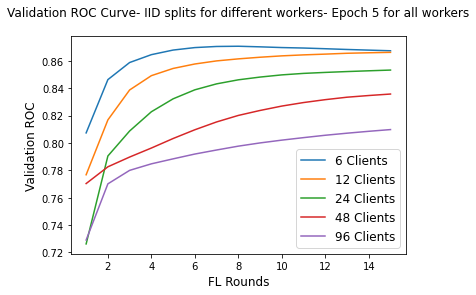

In [51]:
plt.plot(range(1,16),res_w6_c1_iid['val_roc'], label='6 Clients')
plt.plot(range(1,16),res_w12_c1_E5_iid['val_roc'], label='12 Clients')
plt.plot(range(1,16),res_w24_c1_E5_iid['val_roc'], label='24 Clients')
plt.plot(range(1,16),res_w48_c1_E5_iid['val_roc'], label='48 Clients')
plt.plot(range(1,16),res_w96_c1_E5_iid['val_roc'], label='96 Clients')


plt.title("Validation ROC Curve- IID splits for different clients- Epoch 5 for all workers",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

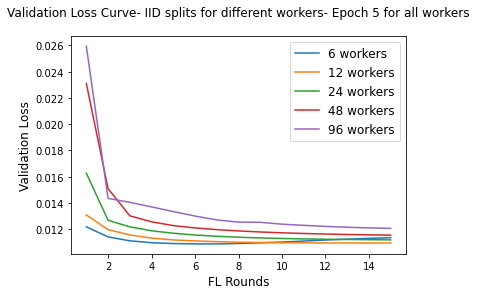

In [21]:
plt.plot(range(1,16),res_w6_c1_iid['val_loss'], label='6 workers')
plt.plot(range(1,16),res_w12_c1_E5_iid['val_loss'], label='12 workers')
plt.plot(range(1,16),res_w24_c1_E5_iid['val_loss'], label='24 workers')
plt.plot(range(1,16),res_w48_c1_E5_iid['val_loss'], label='48 workers')
plt.plot(range(1,16),res_w96_c1_E5_iid['val_loss'], label='96 workers')


plt.title("Validation Loss Curve- IID splits for different clients- Epoch 5 for all workers",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.show()

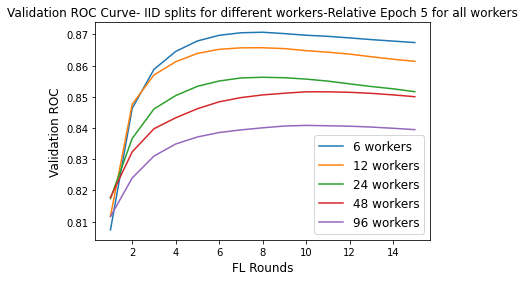

In [53]:
plt.plot(range(1,16),res_w6_c1_iid['val_roc'], label='6 workers')
plt.plot(range(1,16),res_w12_c1_iid['val_roc'], label='12 workers')
plt.plot(range(1,16),res_w24_c1_iid['val_roc'], label='24 workers')
plt.plot(range(1,16),res_w48_c1_iid['val_roc'], label='48 workers')
plt.plot(range(1,16),res_w96_c1_iid['val_roc'], label='96 workers')


plt.title("Validation ROC Curve- IID splits for different clients-Relative Epoch 5 for all workers")#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

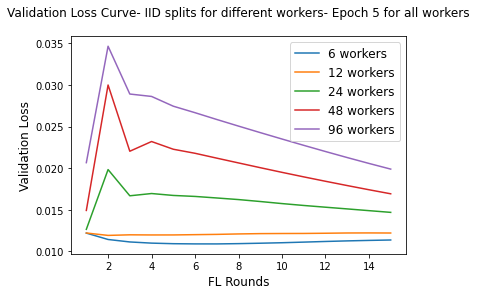

In [54]:
plt.plot(range(1,16),res_w6_c1_iid['val_loss'], label='6 workers')
plt.plot(range(1,16),res_w12_c1_iid['val_loss'], label='12 workers')
plt.plot(range(1,16),res_w24_c1_iid['val_loss'], label='24 workers')
plt.plot(range(1,16),res_w48_c1_iid['val_loss'], label='48 workers')
plt.plot(range(1,16),res_w96_c1_iid['val_loss'], label='96 workers')


plt.title("Validation Loss Curve- IID splits for different clients- Epoch 5 for all workers",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.show()

### 2. Impact of learning rate decay

Dataset split per image is IID on the labels 

Hyperparameters:
- 15 FL rounds
- 5 fixed local Epochs for all clients
- 256 batch size
- Learning rate decay 0.15 and no learning rate decay

The results show that small learning rate decay is needed for high number of clients. 

Even though no learning decay improves the ROC score for high number of clients, the score is not in line with benchmark observed for central validation. The same challenge was observed for non IID scenarios in the previous section.  

This suggests that despite the dataset split being IID on the labels, the data split is still heterogenous when the number of clients is large. This suggest that such split may have heterogenity on feature/input space the can also impact FedAvg performance.

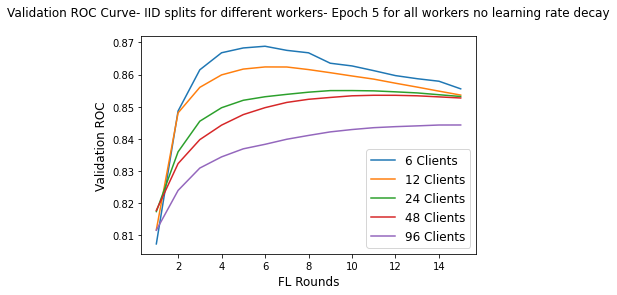

In [63]:
plt.plot(range(1,16),res_w6_c1_LRD0_iid['val_roc'], label='6 Clients')
plt.plot(range(1,16),res_w12_c1_LRD0_iid['val_roc'], label='12 Clients')
plt.plot(range(1,16),res_w24_c1_LRD0_iid['val_roc'], label='24 Clients')
plt.plot(range(1,16),res_w48_c1_LRD0_iid['val_roc'], label='48 Clients')
plt.plot(range(1,16),res_w96_c1_LRD0_iid['val_roc'], label='96 Clients')


plt.title("Validation ROC Curve- IID splits for different clients- Epoch 5 for all workers no learning rate decay",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

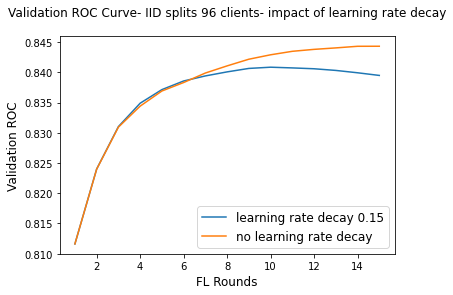

In [64]:
plt.plot(range(1,16),res_w96_c1_iid['val_roc'], label='learning rate decay 0.15')
plt.plot(range(1,16),res_w96_c1_LRD0_iid['val_roc'], label='no learning rate decay')


plt.title("Validation ROC Curve- IID splits 96 clients- impact of learning rate decay",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

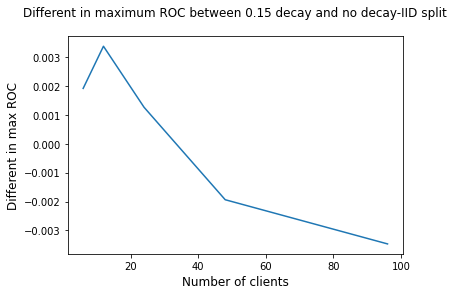

In [66]:
l=[max(res_w6_c1_iid['val_roc'])-max(res_w6_c1_LRD0_iid['val_roc'])]
l+=[max(res_w12_c1_iid['val_roc'])-max(res_w12_c1_LRD0_iid['val_roc'])]
l+=[max(res_w24_c1_iid['val_roc'])-max(res_w24_c1_LRD0_iid['val_roc'])]
l+=[max(res_w48_c1_iid['val_roc'])-max(res_w48_c1_LRD0_iid['val_roc'])]
l+=[max(res_w96_c1_iid['val_roc'])-max(res_w96_c1_LRD0_iid['val_roc'])]

plt.plot([6,12,24,48,96],l)

plt.title("Different in maximum ROC between 0.15 decay and no decay-IID split",pad=20)#, fontsize=28)
#plt.legend(fontsize=12)
plt.xlabel("Number of clients", fontsize=12)
plt.ylabel("Different in max ROC", fontsize=12)
plt.show()

#### Number of rounds needed to reach maximum ROC

In [72]:
D={'Clients':[6,12,24,48,96],'No LRD':[],'LRD 0.15':[]}
D['No LRD']+=[res_w6_c1_LRD0_iid['val_roc'].index(max(res_w6_c1_LRD0_iid['val_roc']))]
D['No LRD']+=[res_w12_c1_LRD0_iid['val_roc'].index(max(res_w12_c1_LRD0_iid['val_roc']))]
D['No LRD']+=[res_w24_c1_LRD0_iid['val_roc'].index(max(res_w24_c1_LRD0_iid['val_roc']))]
D['No LRD']+=[res_w48_c1_LRD0_iid['val_roc'].index(max(res_w48_c1_LRD0_iid['val_roc']))]
D['No LRD']+=[res_w96_c1_LRD0_iid['val_roc'].index(max(res_w96_c1_LRD0_iid['val_roc']))]

D['LRD 0.15']+=[res_w6_c1_iid['val_roc'].index(max(res_w6_c1_iid['val_roc']))]
D['LRD 0.15']+=[res_w12_c1_iid['val_roc'].index(max(res_w12_c1_iid['val_roc']))]
D['LRD 0.15']+=[res_w24_c1_iid['val_roc'].index(max(res_w24_c1_iid['val_roc']))]
D['LRD 0.15']+=[res_w48_c1_iid['val_roc'].index(max(res_w48_c1_iid['val_roc']))]
D['LRD 0.15']+=[res_w96_c1_iid['val_roc'].index(max(res_w96_c1_iid['val_roc']))]

res =pd.DataFrame(D)
res

,Clients,No LRD,LRD 0.15
0,6,5,7
1,12,5,7
2,24,9,7
3,48,10,9
4,96,14,9


### Conclusion

For a large number of clients we need to ensure that number of local updates is high enough to acheive fast learning with the FedAvg algorithm.

Low learning rate decay is required for a large number of clients. 

The results shows that with IID splits that ensure identical distribution for labels across clients, heterogeneity can still be challenging for the FedAvg algorithm. 